##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.13.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-rddtbn0f
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-rddtbn0f


  Resolved https://github.com/tensorflow/docs to commit 541d9fbaa497cbd8e3587c8118e34dc1dc2d04b6


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.7.13.64986-py3-none-any.whl size=183666 sha256=a09957357df4455c1f46993a7131e93364655c8700973e75ef7542e0f1d217e5
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-eueypy4f/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 1s

     49152/2816407858 [..............................] - ETA: 50:34

    212992/2816407858 [..............................] - ETA: 23:24

    442368/2816407858 [..............................] - ETA: 16:50

    688128/2816407858 [..............................] - ETA: 14:18

    933888/2816407858 [..............................] - ETA: 13:05

   1204224/2816407858 [..............................] - ETA: 12:08

   1482752/2816407858 [..............................] - ETA: 11:26

   1769472/2816407858 [..............................] - ETA: 10:55

   2064384/2816407858 [..............................] - ETA: 10:31

   2367488/2816407858 [..............................] - ETA: 10:09

   2670592/2816407858 [..............................] - ETA: 9:53 

   2973696/2816407858 [..............................] - ETA: 9:40

   3276800/2816407858 [..............................] - ETA: 9:30

   3579904/2816407858 [..............................] - ETA: 9:21

   3883008/2816407858 [..............................] - ETA: 9:14

   4186112/2816407858 [..............................] - ETA: 9:08

   4489216/2816407858 [..............................] - ETA: 9:02

   4792320/2816407858 [..............................] - ETA: 8:58

   5095424/2816407858 [..............................] - ETA: 8:53

   5398528/2816407858 [..............................] - ETA: 8:49

   5701632/2816407858 [..............................] - ETA: 8:46

   6012928/2816407858 [..............................] - ETA: 8:43

   6316032/2816407858 [..............................] - ETA: 8:40

   6619136/2816407858 [..............................] - ETA: 8:38

   6922240/2816407858 [..............................] - ETA: 8:36

   7225344/2816407858 [..............................] - ETA: 8:34

   7528448/2816407858 [..............................] - ETA: 8:32

   7815168/2816407858 [..............................] - ETA: 8:31

   8110080/2816407858 [..............................] - ETA: 8:30

   8413184/2816407858 [..............................] - ETA: 8:28

   8716288/2816407858 [..............................] - ETA: 8:27

   9019392/2816407858 [..............................] - ETA: 8:26

   9322496/2816407858 [..............................] - ETA: 8:24

   9625600/2816407858 [..............................] - ETA: 8:23

   9928704/2816407858 [..............................] - ETA: 8:22

  10231808/2816407858 [..............................] - ETA: 8:21

  10534912/2816407858 [..............................] - ETA: 8:20

  10838016/2816407858 [..............................] - ETA: 8:19

  11141120/2816407858 [..............................] - ETA: 8:18

  11444224/2816407858 [..............................] - ETA: 8:18

  11747328/2816407858 [..............................] - ETA: 8:17

  12050432/2816407858 [..............................] - ETA: 8:16

  12353536/2816407858 [..............................] - ETA: 8:15

  12656640/2816407858 [..............................] - ETA: 8:15

  12959744/2816407858 [..............................] - ETA: 8:14

  13254656/2816407858 [..............................] - ETA: 8:13

  13557760/2816407858 [..............................] - ETA: 8:13

  13852672/2816407858 [..............................] - ETA: 8:13

  14147584/2816407858 [..............................] - ETA: 8:12

  14450688/2816407858 [..............................] - ETA: 8:12

  14753792/2816407858 [..............................] - ETA: 8:11

  15056896/2816407858 [..............................] - ETA: 8:10

  15360000/2816407858 [..............................] - ETA: 8:10

  15663104/2816407858 [..............................] - ETA: 8:09

  15958016/2816407858 [..............................] - ETA: 8:09

  16261120/2816407858 [..............................] - ETA: 8:09

  16564224/2816407858 [..............................] - ETA: 8:08

  16867328/2816407858 [..............................] - ETA: 8:08

  17170432/2816407858 [..............................] - ETA: 8:07

  17473536/2816407858 [..............................] - ETA: 8:07

  17776640/2816407858 [..............................] - ETA: 8:06

  18079744/2816407858 [..............................] - ETA: 8:06

  18382848/2816407858 [..............................] - ETA: 8:06

  18685952/2816407858 [..............................] - ETA: 8:05

  18989056/2816407858 [..............................] - ETA: 8:05

  19292160/2816407858 [..............................] - ETA: 8:04

  19595264/2816407858 [..............................] - ETA: 8:04

  19890176/2816407858 [..............................] - ETA: 8:04

  20193280/2816407858 [..............................] - ETA: 8:04

  20496384/2816407858 [..............................] - ETA: 8:04

  20807680/2816407858 [..............................] - ETA: 8:03

  21118976/2816407858 [..............................] - ETA: 8:03

  21422080/2816407858 [..............................] - ETA: 8:03

  21725184/2816407858 [..............................] - ETA: 8:02

  22028288/2816407858 [..............................] - ETA: 8:02

  22331392/2816407858 [..............................] - ETA: 8:02

  22634496/2816407858 [..............................] - ETA: 8:01

  22937600/2816407858 [..............................] - ETA: 8:01

  23240704/2816407858 [..............................] - ETA: 8:01

  23543808/2816407858 [..............................] - ETA: 8:01

  23846912/2816407858 [..............................] - ETA: 8:01

  24150016/2816407858 [..............................] - ETA: 8:00

  24453120/2816407858 [..............................] - ETA: 8:00

  24756224/2816407858 [..............................] - ETA: 8:00

  25059328/2816407858 [..............................] - ETA: 8:00

  25362432/2816407858 [..............................] - ETA: 7:59

  25657344/2816407858 [..............................] - ETA: 7:59

  25952256/2816407858 [..............................] - ETA: 7:59

  26255360/2816407858 [..............................] - ETA: 7:59

  26558464/2816407858 [..............................] - ETA: 7:59

  26861568/2816407858 [..............................] - ETA: 7:59

  27164672/2816407858 [..............................] - ETA: 7:58

  27467776/2816407858 [..............................] - ETA: 7:58

  27770880/2816407858 [..............................] - ETA: 7:58

  28073984/2816407858 [..............................] - ETA: 7:58

  28377088/2816407858 [..............................] - ETA: 7:58

  28680192/2816407858 [..............................] - ETA: 7:57

  28991488/2816407858 [..............................] - ETA: 7:57

  29302784/2816407858 [..............................] - ETA: 7:57

  29605888/2816407858 [..............................] - ETA: 7:57

  29908992/2816407858 [..............................] - ETA: 7:57

  30212096/2816407858 [..............................] - ETA: 7:56

  30515200/2816407858 [..............................] - ETA: 7:56

  30818304/2816407858 [..............................] - ETA: 7:56

  31121408/2816407858 [..............................] - ETA: 7:56

  31424512/2816407858 [..............................] - ETA: 7:56

  31719424/2816407858 [..............................] - ETA: 7:56

  32022528/2816407858 [..............................] - ETA: 7:56

  32325632/2816407858 [..............................] - ETA: 7:56

  32628736/2816407858 [..............................] - ETA: 7:55

  32931840/2816407858 [..............................] - ETA: 7:55

  33234944/2816407858 [..............................] - ETA: 7:55

  33538048/2816407858 [..............................] - ETA: 7:55

  33841152/2816407858 [..............................] - ETA: 7:55

  34144256/2816407858 [..............................] - ETA: 7:55

  34447360/2816407858 [..............................] - ETA: 7:55

  34758656/2816407858 [..............................] - ETA: 7:54

  35061760/2816407858 [..............................] - ETA: 7:54

  35364864/2816407858 [..............................] - ETA: 7:54

  35667968/2816407858 [..............................] - ETA: 7:54

  35971072/2816407858 [..............................] - ETA: 7:54

  36274176/2816407858 [..............................] - ETA: 7:54

  36585472/2816407858 [..............................] - ETA: 7:53

  36888576/2816407858 [..............................] - ETA: 7:53

  37191680/2816407858 [..............................] - ETA: 7:53

  37494784/2816407858 [..............................] - ETA: 7:53

  37789696/2816407858 [..............................] - ETA: 7:53

  38092800/2816407858 [..............................] - ETA: 7:53

  38395904/2816407858 [..............................] - ETA: 7:53

  38699008/2816407858 [..............................] - ETA: 7:53

  39002112/2816407858 [..............................] - ETA: 7:53

  39305216/2816407858 [..............................] - ETA: 7:52

  39608320/2816407858 [..............................] - ETA: 7:52

  39911424/2816407858 [..............................] - ETA: 7:52

  40214528/2816407858 [..............................] - ETA: 7:52

  40517632/2816407858 [..............................] - ETA: 7:52

  40820736/2816407858 [..............................] - ETA: 7:52

  41123840/2816407858 [..............................] - ETA: 7:52

  41426944/2816407858 [..............................] - ETA: 7:52

  41730048/2816407858 [..............................] - ETA: 7:51

  42033152/2816407858 [..............................] - ETA: 7:51

  42336256/2816407858 [..............................] - ETA: 7:51

  42639360/2816407858 [..............................] - ETA: 7:51

  42942464/2816407858 [..............................] - ETA: 7:51

  43245568/2816407858 [..............................] - ETA: 7:51

  43548672/2816407858 [..............................] - ETA: 7:51

  43835392/2816407858 [..............................] - ETA: 7:51

  44138496/2816407858 [..............................] - ETA: 7:51

  44441600/2816407858 [..............................] - ETA: 7:51

  44744704/2816407858 [..............................] - ETA: 7:51

  45056000/2816407858 [..............................] - ETA: 7:50

  45359104/2816407858 [..............................] - ETA: 7:50

  45662208/2816407858 [..............................] - ETA: 7:50

  45965312/2816407858 [..............................] - ETA: 7:50

  46268416/2816407858 [..............................] - ETA: 7:50

  46571520/2816407858 [..............................] - ETA: 7:50

  46882816/2816407858 [..............................] - ETA: 7:50

  47185920/2816407858 [..............................] - ETA: 7:50

  47489024/2816407858 [..............................] - ETA: 7:50

  47792128/2816407858 [..............................] - ETA: 7:49

  48095232/2816407858 [..............................] - ETA: 7:49

  48398336/2816407858 [..............................] - ETA: 7:49

  48701440/2816407858 [..............................] - ETA: 7:49

  49012736/2816407858 [..............................] - ETA: 7:49

  49315840/2816407858 [..............................] - ETA: 7:49

  49610752/2816407858 [..............................] - ETA: 7:49

  49913856/2816407858 [..............................] - ETA: 7:49

  50216960/2816407858 [..............................] - ETA: 7:49

  50520064/2816407858 [..............................] - ETA: 7:49

  50823168/2816407858 [..............................] - ETA: 7:48

  51134464/2816407858 [..............................] - ETA: 7:48

  51437568/2816407858 [..............................] - ETA: 7:48

  51740672/2816407858 [..............................] - ETA: 7:48

  52043776/2816407858 [..............................] - ETA: 7:48

  52346880/2816407858 [..............................] - ETA: 7:48

  52649984/2816407858 [..............................] - ETA: 7:48

  52953088/2816407858 [..............................] - ETA: 7:48

  53256192/2816407858 [..............................] - ETA: 7:48

  53559296/2816407858 [..............................] - ETA: 7:48

  53862400/2816407858 [..............................] - ETA: 7:48

  54157312/2816407858 [..............................] - ETA: 7:47

  54460416/2816407858 [..............................] - ETA: 7:47

  54763520/2816407858 [..............................] - ETA: 7:47

  55066624/2816407858 [..............................] - ETA: 7:47

  55369728/2816407858 [..............................] - ETA: 7:47

  55664640/2816407858 [..............................] - ETA: 7:47

  55967744/2816407858 [..............................] - ETA: 7:47

  56270848/2816407858 [..............................] - ETA: 7:47

  56573952/2816407858 [..............................] - ETA: 7:47

  56868864/2816407858 [..............................] - ETA: 7:47

  57171968/2816407858 [..............................] - ETA: 7:47

  57475072/2816407858 [..............................] - ETA: 7:47

  57778176/2816407858 [..............................] - ETA: 7:46

  58081280/2816407858 [..............................] - ETA: 7:46

  58392576/2816407858 [..............................] - ETA: 7:46

  58695680/2816407858 [..............................] - ETA: 7:46

  59006976/2816407858 [..............................] - ETA: 7:46

  59318272/2816407858 [..............................] - ETA: 7:46

  59629568/2816407858 [..............................] - ETA: 7:46

  59932672/2816407858 [..............................] - ETA: 7:46

  60243968/2816407858 [..............................] - ETA: 7:46

  60555264/2816407858 [..............................] - ETA: 7:45

  60874752/2816407858 [..............................] - ETA: 7:45

  61186048/2816407858 [..............................] - ETA: 7:45

  61497344/2816407858 [..............................] - ETA: 7:45

  61792256/2816407858 [..............................] - ETA: 7:45

  62095360/2816407858 [..............................] - ETA: 7:45

  62406656/2816407858 [..............................] - ETA: 7:45

  62717952/2816407858 [..............................] - ETA: 7:45

  63029248/2816407858 [..............................] - ETA: 7:44

  63332352/2816407858 [..............................] - ETA: 7:44

  63651840/2816407858 [..............................] - ETA: 7:44

  63954944/2816407858 [..............................] - ETA: 7:44

  64266240/2816407858 [..............................] - ETA: 7:44

  64569344/2816407858 [..............................] - ETA: 7:44

  64872448/2816407858 [..............................] - ETA: 7:44

  65183744/2816407858 [..............................] - ETA: 7:44

  65486848/2816407858 [..............................] - ETA: 7:44

  65789952/2816407858 [..............................] - ETA: 7:44

  66093056/2816407858 [..............................] - ETA: 7:43

  66404352/2816407858 [..............................] - ETA: 7:43

  66699264/2816407858 [..............................] - ETA: 7:43

  67002368/2816407858 [..............................] - ETA: 7:43

  67305472/2816407858 [..............................] - ETA: 7:43

  67592192/2816407858 [..............................] - ETA: 7:43

  67895296/2816407858 [..............................] - ETA: 7:43

  68206592/2816407858 [..............................] - ETA: 7:43

  68509696/2816407858 [..............................] - ETA: 7:43

  68820992/2816407858 [..............................] - ETA: 7:43

  69132288/2816407858 [..............................] - ETA: 7:43

  69443584/2816407858 [..............................] - ETA: 7:43

  69738496/2816407858 [..............................] - ETA: 7:43

  70041600/2816407858 [..............................] - ETA: 7:43

  70320128/2816407858 [..............................] - ETA: 7:43

  70631424/2816407858 [..............................] - ETA: 7:42

  70942720/2816407858 [..............................] - ETA: 7:42

  71254016/2816407858 [..............................] - ETA: 7:42

  71557120/2816407858 [..............................] - ETA: 7:42

  71868416/2816407858 [..............................] - ETA: 7:42

  72179712/2816407858 [..............................] - ETA: 7:42

  72491008/2816407858 [..............................] - ETA: 7:42

  72769536/2816407858 [..............................] - ETA: 7:42

  73072640/2816407858 [..............................] - ETA: 7:42

  73351168/2816407858 [..............................] - ETA: 7:42

  73646080/2816407858 [..............................] - ETA: 7:42

  73949184/2816407858 [..............................] - ETA: 7:42

  74252288/2816407858 [..............................] - ETA: 7:42

  74547200/2816407858 [..............................] - ETA: 7:42

  74850304/2816407858 [..............................] - ETA: 7:42

  75161600/2816407858 [..............................] - ETA: 7:42

  75472896/2816407858 [..............................] - ETA: 7:41

  75759616/2816407858 [..............................] - ETA: 7:41

  76062720/2816407858 [..............................] - ETA: 7:41

  76365824/2816407858 [..............................] - ETA: 7:42

  76677120/2816407858 [..............................] - ETA: 7:41

  76988416/2816407858 [..............................] - ETA: 7:41

  77291520/2816407858 [..............................] - ETA: 7:41

  77594624/2816407858 [..............................] - ETA: 7:41

  77897728/2816407858 [..............................] - ETA: 7:41

  78217216/2816407858 [..............................] - ETA: 7:41

  78528512/2816407858 [..............................] - ETA: 7:41

  78815232/2816407858 [..............................] - ETA: 7:41

  79118336/2816407858 [..............................] - ETA: 7:41

  79405056/2816407858 [..............................] - ETA: 7:41

  79691776/2816407858 [..............................] - ETA: 7:41

  79994880/2816407858 [..............................] - ETA: 7:41

  80306176/2816407858 [..............................] - ETA: 7:41

  80601088/2816407858 [..............................] - ETA: 7:41

  80904192/2816407858 [..............................] - ETA: 7:41

  81215488/2816407858 [..............................] - ETA: 7:40

  81526784/2816407858 [..............................] - ETA: 7:40

  81821696/2816407858 [..............................] - ETA: 7:40

  82116608/2816407858 [..............................] - ETA: 7:40

  82411520/2816407858 [..............................] - ETA: 7:40

  82722816/2816407858 [..............................] - ETA: 7:40

  83034112/2816407858 [..............................] - ETA: 7:40

  83337216/2816407858 [..............................] - ETA: 7:40

  83640320/2816407858 [..............................] - ETA: 7:40

  83943424/2816407858 [..............................] - ETA: 7:40

  84254720/2816407858 [..............................] - ETA: 7:40

  84566016/2816407858 [..............................] - ETA: 7:40

  84860928/2816407858 [..............................] - ETA: 7:40

  85164032/2816407858 [..............................] - ETA: 7:40

  85450752/2816407858 [..............................] - ETA: 7:40

  85745664/2816407858 [..............................] - ETA: 7:40

  86056960/2816407858 [..............................] - ETA: 7:40

  86368256/2816407858 [..............................] - ETA: 7:39

  86671360/2816407858 [..............................] - ETA: 7:39

  86974464/2816407858 [..............................] - ETA: 7:39

  87285760/2816407858 [..............................] - ETA: 7:39

  87597056/2816407858 [..............................] - ETA: 7:39

  87883776/2816407858 [..............................] - ETA: 7:39

  88178688/2816407858 [..............................] - ETA: 7:39

  88457216/2816407858 [..............................] - ETA: 7:39

  88768512/2816407858 [..............................] - ETA: 7:39

  89079808/2816407858 [..............................] - ETA: 7:39

  89391104/2816407858 [..............................] - ETA: 7:39

  89694208/2816407858 [..............................] - ETA: 7:39

  89997312/2816407858 [..............................] - ETA: 7:39

  90308608/2816407858 [..............................] - ETA: 7:39

  90619904/2816407858 [..............................] - ETA: 7:38

  90914816/2816407858 [..............................] - ETA: 7:38

  91209728/2816407858 [..............................] - ETA: 7:38

  91488256/2816407858 [..............................] - ETA: 7:38

  91774976/2816407858 [..............................] - ETA: 7:38

  92078080/2816407858 [..............................] - ETA: 7:38

  92389376/2816407858 [..............................] - ETA: 7:38

  92692480/2816407858 [..............................] - ETA: 7:38

  93003776/2816407858 [..............................] - ETA: 7:38

  93315072/2816407858 [..............................] - ETA: 7:38

  93626368/2816407858 [..............................] - ETA: 7:38

  93937664/2816407858 [>.............................] - ETA: 7:38

  94216192/2816407858 [>.............................] - ETA: 7:38

  94519296/2816407858 [>.............................] - ETA: 7:38

  94806016/2816407858 [>.............................] - ETA: 7:38

  95117312/2816407858 [>.............................] - ETA: 7:38

  95420416/2816407858 [>.............................] - ETA: 7:38

  95723520/2816407858 [>.............................] - ETA: 7:38

  96026624/2816407858 [>.............................] - ETA: 7:38

  96337920/2816407858 [>.............................] - ETA: 7:38

  96649216/2816407858 [>.............................] - ETA: 7:37

  96960512/2816407858 [>.............................] - ETA: 7:37

  97239040/2816407858 [>.............................] - ETA: 7:37

  97525760/2816407858 [>.............................] - ETA: 7:37

  97804288/2816407858 [>.............................] - ETA: 7:37

  98115584/2816407858 [>.............................] - ETA: 7:37

  98426880/2816407858 [>.............................] - ETA: 7:37

  98738176/2816407858 [>.............................] - ETA: 7:37

  99033088/2816407858 [>.............................] - ETA: 7:37

  99344384/2816407858 [>.............................] - ETA: 7:37

  99655680/2816407858 [>.............................] - ETA: 7:37

  99975168/2816407858 [>.............................] - ETA: 7:37

 100261888/2816407858 [>.............................] - ETA: 7:37

 100564992/2816407858 [>.............................] - ETA: 7:37

 100843520/2816407858 [>.............................] - ETA: 7:37

 101154816/2816407858 [>.............................] - ETA: 7:37

 101466112/2816407858 [>.............................] - ETA: 7:37

 101769216/2816407858 [>.............................] - ETA: 7:36

 102072320/2816407858 [>.............................] - ETA: 7:36

 102383616/2816407858 [>.............................] - ETA: 7:36

 102703104/2816407858 [>.............................] - ETA: 7:36

 103014400/2816407858 [>.............................] - ETA: 7:36

 103292928/2816407858 [>.............................] - ETA: 7:36

 103579648/2816407858 [>.............................] - ETA: 7:36

 103858176/2816407858 [>.............................] - ETA: 7:36

 104169472/2816407858 [>.............................] - ETA: 7:36

 104480768/2816407858 [>.............................] - ETA: 7:36

 104792064/2816407858 [>.............................] - ETA: 7:36

 105095168/2816407858 [>.............................] - ETA: 7:36

 105406464/2816407858 [>.............................] - ETA: 7:36

 105717760/2816407858 [>.............................] - ETA: 7:36

 106020864/2816407858 [>.............................] - ETA: 7:36

 106299392/2816407858 [>.............................] - ETA: 7:36

 106602496/2816407858 [>.............................] - ETA: 7:36

 106872832/2816407858 [>.............................] - ETA: 7:36

 107184128/2816407858 [>.............................] - ETA: 7:36

 107495424/2816407858 [>.............................] - ETA: 7:35

 107806720/2816407858 [>.............................] - ETA: 7:35

 108109824/2816407858 [>.............................] - ETA: 7:35

 108421120/2816407858 [>.............................] - ETA: 7:35

 108732416/2816407858 [>.............................] - ETA: 7:35

 109043712/2816407858 [>.............................] - ETA: 7:35

 109322240/2816407858 [>.............................] - ETA: 7:35

 109608960/2816407858 [>.............................] - ETA: 7:35

 109887488/2816407858 [>.............................] - ETA: 7:35

 110198784/2816407858 [>.............................] - ETA: 7:35

 110510080/2816407858 [>.............................] - ETA: 7:35

 110821376/2816407858 [>.............................] - ETA: 7:35

 111124480/2816407858 [>.............................] - ETA: 7:35

 111435776/2816407858 [>.............................] - ETA: 7:35

 111747072/2816407858 [>.............................] - ETA: 7:35

 112058368/2816407858 [>.............................] - ETA: 7:35

 112345088/2816407858 [>.............................] - ETA: 7:35

 112648192/2816407858 [>.............................] - ETA: 7:34

 112926720/2816407858 [>.............................] - ETA: 7:35

 113238016/2816407858 [>.............................] - ETA: 7:34

 113549312/2816407858 [>.............................] - ETA: 7:34

 113860608/2816407858 [>.............................] - ETA: 7:34

 114163712/2816407858 [>.............................] - ETA: 7:34

 114466816/2816407858 [>.............................] - ETA: 7:34

 114778112/2816407858 [>.............................] - ETA: 7:34

 115089408/2816407858 [>.............................] - ETA: 7:34

 115367936/2816407858 [>.............................] - ETA: 7:34

 115662848/2816407858 [>.............................] - ETA: 7:34

 115941376/2816407858 [>.............................] - ETA: 7:34

 116252672/2816407858 [>.............................] - ETA: 7:34

 116563968/2816407858 [>.............................] - ETA: 7:34

 116875264/2816407858 [>.............................] - ETA: 7:34

 117178368/2816407858 [>.............................] - ETA: 7:34

 117481472/2816407858 [>.............................] - ETA: 7:34

 117776384/2816407858 [>.............................] - ETA: 7:34

 118087680/2816407858 [>.............................] - ETA: 7:33

 118374400/2816407858 [>.............................] - ETA: 7:33

 118677504/2816407858 [>.............................] - ETA: 7:33

 118956032/2816407858 [>.............................] - ETA: 7:33

 119267328/2816407858 [>.............................] - ETA: 7:33

 119578624/2816407858 [>.............................] - ETA: 7:33

 119889920/2816407858 [>.............................] - ETA: 7:33

 120184832/2816407858 [>.............................] - ETA: 7:33

 120487936/2816407858 [>.............................] - ETA: 7:33

 120799232/2816407858 [>.............................] - ETA: 7:33

 121110528/2816407858 [>.............................] - ETA: 7:33

 121389056/2816407858 [>.............................] - ETA: 7:33

 121675776/2816407858 [>.............................] - ETA: 7:33

 121970688/2816407858 [>.............................] - ETA: 7:33

 122290176/2816407858 [>.............................] - ETA: 7:33

 122609664/2816407858 [>.............................] - ETA: 7:33

 122929152/2816407858 [>.............................] - ETA: 7:33

 123232256/2816407858 [>.............................] - ETA: 7:33

 123543552/2816407858 [>.............................] - ETA: 7:32

 123863040/2816407858 [>.............................] - ETA: 7:32

 124182528/2816407858 [>.............................] - ETA: 7:32

 124477440/2816407858 [>.............................] - ETA: 7:32

 124772352/2816407858 [>.............................] - ETA: 7:32

 125067264/2816407858 [>.............................] - ETA: 7:32

 125386752/2816407858 [>.............................] - ETA: 7:32

 125714432/2816407858 [>.............................] - ETA: 7:32

 126033920/2816407858 [>.............................] - ETA: 7:32

 126337024/2816407858 [>.............................] - ETA: 7:32

 126656512/2816407858 [>.............................] - ETA: 7:32

 126976000/2816407858 [>.............................] - ETA: 7:31

 127295488/2816407858 [>.............................] - ETA: 7:31

 127574016/2816407858 [>.............................] - ETA: 7:31

 127877120/2816407858 [>.............................] - ETA: 7:31

 128172032/2816407858 [>.............................] - ETA: 7:31

 128491520/2816407858 [>.............................] - ETA: 7:31

 128811008/2816407858 [>.............................] - ETA: 7:31

 129130496/2816407858 [>.............................] - ETA: 7:31

 129433600/2816407858 [>.............................] - ETA: 7:31

 129753088/2816407858 [>.............................] - ETA: 7:31

 130080768/2816407858 [>.............................] - ETA: 7:31

 130400256/2816407858 [>.............................] - ETA: 7:31

 130686976/2816407858 [>.............................] - ETA: 7:31

 130990080/2816407858 [>.............................] - ETA: 7:31

 131284992/2816407858 [>.............................] - ETA: 7:30

 131604480/2816407858 [>.............................] - ETA: 7:30

 131923968/2816407858 [>.............................] - ETA: 7:30

 132235264/2816407858 [>.............................] - ETA: 7:30

 132546560/2816407858 [>.............................] - ETA: 7:30

 132866048/2816407858 [>.............................] - ETA: 7:30

 133177344/2816407858 [>.............................] - ETA: 7:30

 133496832/2816407858 [>.............................] - ETA: 7:30

 133775360/2816407858 [>.............................] - ETA: 7:30

 134078464/2816407858 [>.............................] - ETA: 7:30

 134381568/2816407858 [>.............................] - ETA: 7:30

 134701056/2816407858 [>.............................] - ETA: 7:30

 135020544/2816407858 [>.............................] - ETA: 7:29

 135323648/2816407858 [>.............................] - ETA: 7:29

 135634944/2816407858 [>.............................] - ETA: 7:29

 135954432/2816407858 [>.............................] - ETA: 7:29

 136273920/2816407858 [>.............................] - ETA: 7:29

 136585216/2816407858 [>.............................] - ETA: 7:29

 136880128/2816407858 [>.............................] - ETA: 7:29

 137158656/2816407858 [>.............................] - ETA: 7:29

 137478144/2816407858 [>.............................] - ETA: 7:29

 137797632/2816407858 [>.............................] - ETA: 7:29

 138117120/2816407858 [>.............................] - ETA: 7:29

 138428416/2816407858 [>.............................] - ETA: 7:29

 138739712/2816407858 [>.............................] - ETA: 7:28

 139059200/2816407858 [>.............................] - ETA: 7:28

 139378688/2816407858 [>.............................] - ETA: 7:28

 139665408/2816407858 [>.............................] - ETA: 7:28

 139968512/2816407858 [>.............................] - ETA: 7:28

 140255232/2816407858 [>.............................] - ETA: 7:28

 140574720/2816407858 [>.............................] - ETA: 7:28

 140894208/2816407858 [>.............................] - ETA: 7:28

 141213696/2816407858 [>.............................] - ETA: 7:28

 141524992/2816407858 [>.............................] - ETA: 7:28

 141836288/2816407858 [>.............................] - ETA: 7:28

 142155776/2816407858 [>.............................] - ETA: 7:28

 142467072/2816407858 [>.............................] - ETA: 7:28

 142761984/2816407858 [>.............................] - ETA: 7:28

 143073280/2816407858 [>.............................] - ETA: 7:27

 143360000/2816407858 [>.............................] - ETA: 7:27

 143679488/2816407858 [>.............................] - ETA: 7:27

 143998976/2816407858 [>.............................] - ETA: 7:27

 144318464/2816407858 [>.............................] - ETA: 7:27

 144629760/2816407858 [>.............................] - ETA: 7:27

 144941056/2816407858 [>.............................] - ETA: 7:27

 145260544/2816407858 [>.............................] - ETA: 7:27

 145580032/2816407858 [>.............................] - ETA: 7:27

 145850368/2816407858 [>.............................] - ETA: 7:27

 146145280/2816407858 [>.............................] - ETA: 7:27

 146440192/2816407858 [>.............................] - ETA: 7:27

 146759680/2816407858 [>.............................] - ETA: 7:27

 147079168/2816407858 [>.............................] - ETA: 7:27

 147390464/2816407858 [>.............................] - ETA: 7:26

 147701760/2816407858 [>.............................] - ETA: 7:26

 148021248/2816407858 [>.............................] - ETA: 7:26

 148332544/2816407858 [>.............................] - ETA: 7:26

 148652032/2816407858 [>.............................] - ETA: 7:26

 148930560/2816407858 [>.............................] - ETA: 7:26

 149233664/2816407858 [>.............................] - ETA: 7:26

 149528576/2816407858 [>.............................] - ETA: 7:26

 149848064/2816407858 [>.............................] - ETA: 7:26

 150167552/2816407858 [>.............................] - ETA: 7:26

 150478848/2816407858 [>.............................] - ETA: 7:26

 150790144/2816407858 [>.............................] - ETA: 7:26

 151101440/2816407858 [>.............................] - ETA: 7:26

 151420928/2816407858 [>.............................] - ETA: 7:25

 151740416/2816407858 [>.............................] - ETA: 7:25

 152002560/2816407858 [>.............................] - ETA: 7:25

 152297472/2816407858 [>.............................] - ETA: 7:25

 152584192/2816407858 [>.............................] - ETA: 7:25

 152895488/2816407858 [>.............................] - ETA: 7:25

 153206784/2816407858 [>.............................] - ETA: 7:25

 153518080/2816407858 [>.............................] - ETA: 7:25

 153821184/2816407858 [>.............................] - ETA: 7:25

 154132480/2816407858 [>.............................] - ETA: 7:25

 154443776/2816407858 [>.............................] - ETA: 7:25

 154755072/2816407858 [>.............................] - ETA: 7:25

 155033600/2816407858 [>.............................] - ETA: 7:25

 155328512/2816407858 [>.............................] - ETA: 7:25

 155615232/2816407858 [>.............................] - ETA: 7:25

 155926528/2816407858 [>.............................] - ETA: 7:25

 156237824/2816407858 [>.............................] - ETA: 7:25

 156549120/2816407858 [>.............................] - ETA: 7:25

 156852224/2816407858 [>.............................] - ETA: 7:25

 157155328/2816407858 [>.............................] - ETA: 7:25

 157466624/2816407858 [>.............................] - ETA: 7:24

 157769728/2816407858 [>.............................] - ETA: 7:24

 158040064/2816407858 [>.............................] - ETA: 7:24

 158334976/2816407858 [>.............................] - ETA: 7:24

 158621696/2816407858 [>.............................] - ETA: 7:24

 158932992/2816407858 [>.............................] - ETA: 7:24

 159244288/2816407858 [>.............................] - ETA: 7:24

 159555584/2816407858 [>.............................] - ETA: 7:24

 159858688/2816407858 [>.............................] - ETA: 7:24

 160161792/2816407858 [>.............................] - ETA: 7:24

 160473088/2816407858 [>.............................] - ETA: 7:24

 160784384/2816407858 [>.............................] - ETA: 7:24

 161062912/2816407858 [>.............................] - ETA: 7:24

 161366016/2816407858 [>.............................] - ETA: 7:24

 161652736/2816407858 [>.............................] - ETA: 7:24

 161964032/2816407858 [>.............................] - ETA: 7:24

 162275328/2816407858 [>.............................] - ETA: 7:24

 162586624/2816407858 [>.............................] - ETA: 7:24

 162889728/2816407858 [>.............................] - ETA: 7:24

 163192832/2816407858 [>.............................] - ETA: 7:24

 163504128/2816407858 [>.............................] - ETA: 7:23

 163807232/2816407858 [>.............................] - ETA: 7:23

 164077568/2816407858 [>.............................] - ETA: 7:23

 164372480/2816407858 [>.............................] - ETA: 7:23

 164659200/2816407858 [>.............................] - ETA: 7:23

 164970496/2816407858 [>.............................] - ETA: 7:23

 165289984/2816407858 [>.............................] - ETA: 7:23

 165601280/2816407858 [>.............................] - ETA: 7:23

 165904384/2816407858 [>.............................] - ETA: 7:23

 166207488/2816407858 [>.............................] - ETA: 7:23

 166518784/2816407858 [>.............................] - ETA: 7:23

 166830080/2816407858 [>.............................] - ETA: 7:23

 167116800/2816407858 [>.............................] - ETA: 7:23

 167411712/2816407858 [>.............................] - ETA: 7:23

 167698432/2816407858 [>.............................] - ETA: 7:23

 168009728/2816407858 [>.............................] - ETA: 7:23

 168321024/2816407858 [>.............................] - ETA: 7:23

 168632320/2816407858 [>.............................] - ETA: 7:23

 168935424/2816407858 [>.............................] - ETA: 7:23

 169230336/2816407858 [>.............................] - ETA: 7:23

 169541632/2816407858 [>.............................] - ETA: 7:22

 169844736/2816407858 [>.............................] - ETA: 7:22

 170123264/2816407858 [>.............................] - ETA: 7:22

 170418176/2816407858 [>.............................] - ETA: 7:22

 170696704/2816407858 [>.............................] - ETA: 7:22

 171008000/2816407858 [>.............................] - ETA: 7:22

 171319296/2816407858 [>.............................] - ETA: 7:22

 171630592/2816407858 [>.............................] - ETA: 7:22

 171933696/2816407858 [>.............................] - ETA: 7:22

 172236800/2816407858 [>.............................] - ETA: 7:22

 172548096/2816407858 [>.............................] - ETA: 7:22

 172859392/2816407858 [>.............................] - ETA: 7:22

 173146112/2816407858 [>.............................] - ETA: 7:22

 173441024/2816407858 [>.............................] - ETA: 7:22

 173719552/2816407858 [>.............................] - ETA: 7:22

 174030848/2816407858 [>.............................] - ETA: 7:22

 174342144/2816407858 [>.............................] - ETA: 7:22

 174653440/2816407858 [>.............................] - ETA: 7:22

 174964736/2816407858 [>.............................] - ETA: 7:22

 175267840/2816407858 [>.............................] - ETA: 7:22

 175570944/2816407858 [>.............................] - ETA: 7:22

 175874048/2816407858 [>.............................] - ETA: 7:21

 176177152/2816407858 [>.............................] - ETA: 7:21

 176455680/2816407858 [>.............................] - ETA: 7:21

 176758784/2816407858 [>.............................] - ETA: 7:21

 177045504/2816407858 [>.............................] - ETA: 7:21

 177356800/2816407858 [>.............................] - ETA: 7:21

 177668096/2816407858 [>.............................] - ETA: 7:21

 177979392/2816407858 [>.............................] - ETA: 7:21

 178282496/2816407858 [>.............................] - ETA: 7:21

 178585600/2816407858 [>.............................] - ETA: 7:21

 178896896/2816407858 [>.............................] - ETA: 7:21

 179208192/2816407858 [>.............................] - ETA: 7:21

 179486720/2816407858 [>.............................] - ETA: 7:21

 179789824/2816407858 [>.............................] - ETA: 7:21

 180076544/2816407858 [>.............................] - ETA: 7:21

 180387840/2816407858 [>.............................] - ETA: 7:21

 180699136/2816407858 [>.............................] - ETA: 7:21

 181010432/2816407858 [>.............................] - ETA: 7:21

 181313536/2816407858 [>.............................] - ETA: 7:21

 181608448/2816407858 [>.............................] - ETA: 7:21

 181903360/2816407858 [>.............................] - ETA: 7:21

 182214656/2816407858 [>.............................] - ETA: 7:20

 182493184/2816407858 [>.............................] - ETA: 7:20

 182788096/2816407858 [>.............................] - ETA: 7:20

 183074816/2816407858 [>.............................] - ETA: 7:20

 183386112/2816407858 [>.............................] - ETA: 7:20

 183697408/2816407858 [>.............................] - ETA: 7:20

 184008704/2816407858 [>.............................] - ETA: 7:20

 184311808/2816407858 [>.............................] - ETA: 7:20

 184614912/2816407858 [>.............................] - ETA: 7:20

 184926208/2816407858 [>.............................] - ETA: 7:20

 185237504/2816407858 [>.............................] - ETA: 7:20

 185516032/2816407858 [>.............................] - ETA: 7:20

 185819136/2816407858 [>.............................] - ETA: 7:20

 186105856/2816407858 [>.............................] - ETA: 7:20

 186417152/2816407858 [>.............................] - ETA: 7:20

 186728448/2816407858 [>.............................] - ETA: 7:20

 187039744/2816407858 [>.............................] - ETA: 7:20

 187342848/2816407858 [>.............................] - ETA: 7:20

 187629568/2816407858 [>.............................] - ETA: 7:20

 187932672/2816407858 [=>............................] - ETA: 7:20

 188243968/2816407858 [=>............................] - ETA: 7:19

 188522496/2816407858 [=>............................] - ETA: 7:19

 188825600/2816407858 [=>............................] - ETA: 7:19

 189104128/2816407858 [=>............................] - ETA: 7:19

 189415424/2816407858 [=>............................] - ETA: 7:19

 189734912/2816407858 [=>............................] - ETA: 7:19

 190046208/2816407858 [=>............................] - ETA: 7:19

 190349312/2816407858 [=>............................] - ETA: 7:19

 190652416/2816407858 [=>............................] - ETA: 7:19

 190955520/2816407858 [=>............................] - ETA: 7:19

 191266816/2816407858 [=>............................] - ETA: 7:19

 191545344/2816407858 [=>............................] - ETA: 7:19

 191848448/2816407858 [=>............................] - ETA: 7:19

 192135168/2816407858 [=>............................] - ETA: 7:19

 192446464/2816407858 [=>............................] - ETA: 7:19

 192757760/2816407858 [=>............................] - ETA: 7:19

 193069056/2816407858 [=>............................] - ETA: 7:19

 193372160/2816407858 [=>............................] - ETA: 7:19

 193658880/2816407858 [=>............................] - ETA: 7:19

 193961984/2816407858 [=>............................] - ETA: 7:19

 194273280/2816407858 [=>............................] - ETA: 7:18

 194551808/2816407858 [=>............................] - ETA: 7:18

 194854912/2816407858 [=>............................] - ETA: 7:18

 195149824/2816407858 [=>............................] - ETA: 7:18

 195461120/2816407858 [=>............................] - ETA: 7:18

 195772416/2816407858 [=>............................] - ETA: 7:18

 196083712/2816407858 [=>............................] - ETA: 7:18

 196386816/2816407858 [=>............................] - ETA: 7:18

 196681728/2816407858 [=>............................] - ETA: 7:18

 196984832/2816407858 [=>............................] - ETA: 7:18

 197304320/2816407858 [=>............................] - ETA: 7:18

 197582848/2816407858 [=>............................] - ETA: 7:18

 197885952/2816407858 [=>............................] - ETA: 7:18

 198180864/2816407858 [=>............................] - ETA: 7:18

 198492160/2816407858 [=>............................] - ETA: 7:18

 198803456/2816407858 [=>............................] - ETA: 7:18

 199114752/2816407858 [=>............................] - ETA: 7:18

 199417856/2816407858 [=>............................] - ETA: 7:18

 199704576/2816407858 [=>............................] - ETA: 7:18

 200007680/2816407858 [=>............................] - ETA: 7:18

 200318976/2816407858 [=>............................] - ETA: 7:18

 200597504/2816407858 [=>............................] - ETA: 7:18

 200900608/2816407858 [=>............................] - ETA: 7:17

 201195520/2816407858 [=>............................] - ETA: 7:17

 201490432/2816407858 [=>............................] - ETA: 7:17

 201801728/2816407858 [=>............................] - ETA: 7:17

 202113024/2816407858 [=>............................] - ETA: 7:17

 202416128/2816407858 [=>............................] - ETA: 7:17

 202719232/2816407858 [=>............................] - ETA: 7:17

 203014144/2816407858 [=>............................] - ETA: 7:17

 203325440/2816407858 [=>............................] - ETA: 7:17

 203612160/2816407858 [=>............................] - ETA: 7:17

 203915264/2816407858 [=>............................] - ETA: 7:17

 204218368/2816407858 [=>............................] - ETA: 7:17

 204513280/2816407858 [=>............................] - ETA: 7:17

 204824576/2816407858 [=>............................] - ETA: 7:17

 205135872/2816407858 [=>............................] - ETA: 7:17

 205438976/2816407858 [=>............................] - ETA: 7:17

 205725696/2816407858 [=>............................] - ETA: 7:17

 206004224/2816407858 [=>............................] - ETA: 7:17

 206307328/2816407858 [=>............................] - ETA: 7:17

 206618624/2816407858 [=>............................] - ETA: 7:17

 206913536/2816407858 [=>............................] - ETA: 7:17

 207216640/2816407858 [=>............................] - ETA: 7:16

 207527936/2816407858 [=>............................] - ETA: 7:16

 207839232/2816407858 [=>............................] - ETA: 7:16

 208150528/2816407858 [=>............................] - ETA: 7:16

 208437248/2816407858 [=>............................] - ETA: 7:16

 208740352/2816407858 [=>............................] - ETA: 7:16

 209018880/2816407858 [=>............................] - ETA: 7:16

 209330176/2816407858 [=>............................] - ETA: 7:16

 209641472/2816407858 [=>............................] - ETA: 7:16

 209936384/2816407858 [=>............................] - ETA: 7:16

 210239488/2816407858 [=>............................] - ETA: 7:16

 210550784/2816407858 [=>............................] - ETA: 7:16

 210862080/2816407858 [=>............................] - ETA: 7:16

 211173376/2816407858 [=>............................] - ETA: 7:16

 211451904/2816407858 [=>............................] - ETA: 7:16

 211746816/2816407858 [=>............................] - ETA: 7:16

 212017152/2816407858 [=>............................] - ETA: 7:16

 212328448/2816407858 [=>............................] - ETA: 7:16

 212639744/2816407858 [=>............................] - ETA: 7:16

 212942848/2816407858 [=>............................] - ETA: 7:16

 213245952/2816407858 [=>............................] - ETA: 7:15

 213557248/2816407858 [=>............................] - ETA: 7:15

 213876736/2816407858 [=>............................] - ETA: 7:15

 214196224/2816407858 [=>............................] - ETA: 7:15

 214482944/2816407858 [=>............................] - ETA: 7:15

 214786048/2816407858 [=>............................] - ETA: 7:15

 215064576/2816407858 [=>............................] - ETA: 7:15

 215375872/2816407858 [=>............................] - ETA: 7:15

 215695360/2816407858 [=>............................] - ETA: 7:15

 215998464/2816407858 [=>............................] - ETA: 7:15

 216301568/2816407858 [=>............................] - ETA: 7:15

 216612864/2816407858 [=>............................] - ETA: 7:15

 216924160/2816407858 [=>............................] - ETA: 7:15

 217235456/2816407858 [=>............................] - ETA: 7:15

 217513984/2816407858 [=>............................] - ETA: 7:15

 217808896/2816407858 [=>............................] - ETA: 7:15

 218079232/2816407858 [=>............................] - ETA: 7:15

 218390528/2816407858 [=>............................] - ETA: 7:15

 218701824/2816407858 [=>............................] - ETA: 7:15

 219013120/2816407858 [=>............................] - ETA: 7:15

 219324416/2816407858 [=>............................] - ETA: 7:14

 219635712/2816407858 [=>............................] - ETA: 7:14

 219947008/2816407858 [=>............................] - ETA: 7:14

 220258304/2816407858 [=>............................] - ETA: 7:14

 220545024/2816407858 [=>............................] - ETA: 7:14

 220848128/2816407858 [=>............................] - ETA: 7:14

 221118464/2816407858 [=>............................] - ETA: 7:14

 221429760/2816407858 [=>............................] - ETA: 7:14

 221741056/2816407858 [=>............................] - ETA: 7:14

 222044160/2816407858 [=>............................] - ETA: 7:14

 222347264/2816407858 [=>............................] - ETA: 7:14

 222650368/2816407858 [=>............................] - ETA: 7:14

 222961664/2816407858 [=>............................] - ETA: 7:14

 223272960/2816407858 [=>............................] - ETA: 7:14

 223559680/2816407858 [=>............................] - ETA: 7:14

 223846400/2816407858 [=>............................] - ETA: 7:14

 224108544/2816407858 [=>............................] - ETA: 7:14

 224419840/2816407858 [=>............................] - ETA: 7:14

 224731136/2816407858 [=>............................] - ETA: 7:14

 225042432/2816407858 [=>............................] - ETA: 7:14

 225345536/2816407858 [=>............................] - ETA: 7:14

 225648640/2816407858 [=>............................] - ETA: 7:13

 225959936/2816407858 [=>............................] - ETA: 7:13

 226271232/2816407858 [=>............................] - ETA: 7:13

 226574336/2816407858 [=>............................] - ETA: 7:13

 226852864/2816407858 [=>............................] - ETA: 7:13

 227131392/2816407858 [=>............................] - ETA: 7:13

 227434496/2816407858 [=>............................] - ETA: 7:13

 227745792/2816407858 [=>............................] - ETA: 7:13

 228057088/2816407858 [=>............................] - ETA: 7:13

 228360192/2816407858 [=>............................] - ETA: 7:13

 228663296/2816407858 [=>............................] - ETA: 7:13

 228974592/2816407858 [=>............................] - ETA: 7:13

 229285888/2816407858 [=>............................] - ETA: 7:13

 229588992/2816407858 [=>............................] - ETA: 7:13

 229859328/2816407858 [=>............................] - ETA: 7:13

 230154240/2816407858 [=>............................] - ETA: 7:13

 230440960/2816407858 [=>............................] - ETA: 7:13

 230752256/2816407858 [=>............................] - ETA: 7:13

 231063552/2816407858 [=>............................] - ETA: 7:13

 231374848/2816407858 [=>............................] - ETA: 7:13

 231677952/2816407858 [=>............................] - ETA: 7:13

 231981056/2816407858 [=>............................] - ETA: 7:12

 232284160/2816407858 [=>............................] - ETA: 7:12

 232587264/2816407858 [=>............................] - ETA: 7:12

 232865792/2816407858 [=>............................] - ETA: 7:12

 233160704/2816407858 [=>............................] - ETA: 7:12

 233439232/2816407858 [=>............................] - ETA: 7:12

 233750528/2816407858 [=>............................] - ETA: 7:12

 234061824/2816407858 [=>............................] - ETA: 7:12

 234373120/2816407858 [=>............................] - ETA: 7:12

 234676224/2816407858 [=>............................] - ETA: 7:12

 234979328/2816407858 [=>............................] - ETA: 7:12

 235282432/2816407858 [=>............................] - ETA: 7:12

 235593728/2816407858 [=>............................] - ETA: 7:12

 235880448/2816407858 [=>............................] - ETA: 7:12

 236175360/2816407858 [=>............................] - ETA: 7:12

 236453888/2816407858 [=>............................] - ETA: 7:12

 236765184/2816407858 [=>............................] - ETA: 7:12

 237076480/2816407858 [=>............................] - ETA: 7:12

 237387776/2816407858 [=>............................] - ETA: 7:12

 237690880/2816407858 [=>............................] - ETA: 7:12

 237993984/2816407858 [=>............................] - ETA: 7:12

 238313472/2816407858 [=>............................] - ETA: 7:11

 238624768/2816407858 [=>............................] - ETA: 7:11

 238911488/2816407858 [=>............................] - ETA: 7:11

 239206400/2816407858 [=>............................] - ETA: 7:11

 239484928/2816407858 [=>............................] - ETA: 7:11

 239796224/2816407858 [=>............................] - ETA: 7:11

 240107520/2816407858 [=>............................] - ETA: 7:11

 240418816/2816407858 [=>............................] - ETA: 7:11

 240721920/2816407858 [=>............................] - ETA: 7:11

 241025024/2816407858 [=>............................] - ETA: 7:11

 241328128/2816407858 [=>............................] - ETA: 7:11

 241639424/2816407858 [=>............................] - ETA: 7:11

 241926144/2816407858 [=>............................] - ETA: 7:11

 242221056/2816407858 [=>............................] - ETA: 7:11

 242499584/2816407858 [=>............................] - ETA: 7:11

 242810880/2816407858 [=>............................] - ETA: 7:11

 243122176/2816407858 [=>............................] - ETA: 7:11

 243433472/2816407858 [=>............................] - ETA: 7:11

 243736576/2816407858 [=>............................] - ETA: 7:11

 244039680/2816407858 [=>............................] - ETA: 7:11

 244350976/2816407858 [=>............................] - ETA: 7:10

 244662272/2816407858 [=>............................] - ETA: 7:10

 244957184/2816407858 [=>............................] - ETA: 7:10

 245243904/2816407858 [=>............................] - ETA: 7:10

 245522432/2816407858 [=>............................] - ETA: 7:10

 245833728/2816407858 [=>............................] - ETA: 7:10

 246145024/2816407858 [=>............................] - ETA: 7:10

 246456320/2816407858 [=>............................] - ETA: 7:10

 246759424/2816407858 [=>............................] - ETA: 7:10

 247062528/2816407858 [=>............................] - ETA: 7:10

 247357440/2816407858 [=>............................] - ETA: 7:10

 247668736/2816407858 [=>............................] - ETA: 7:10

 247971840/2816407858 [=>............................] - ETA: 7:10

 248250368/2816407858 [=>............................] - ETA: 7:10

 248528896/2816407858 [=>............................] - ETA: 7:10

 248840192/2816407858 [=>............................] - ETA: 7:10

 249151488/2816407858 [=>............................] - ETA: 7:10

 249462784/2816407858 [=>............................] - ETA: 7:10

 249774080/2816407858 [=>............................] - ETA: 7:10

 250077184/2816407858 [=>............................] - ETA: 7:10

 250388480/2816407858 [=>............................] - ETA: 7:09

 250699776/2816407858 [=>............................] - ETA: 7:09

 251011072/2816407858 [=>............................] - ETA: 7:09

 251289600/2816407858 [=>............................] - ETA: 7:09

 251568128/2816407858 [=>............................] - ETA: 7:09

 251879424/2816407858 [=>............................] - ETA: 7:09

 252190720/2816407858 [=>............................] - ETA: 7:09

 252502016/2816407858 [=>............................] - ETA: 7:09

 252813312/2816407858 [=>............................] - ETA: 7:09

 253116416/2816407858 [=>............................] - ETA: 7:09

 253411328/2816407858 [=>............................] - ETA: 7:09

 253722624/2816407858 [=>............................] - ETA: 7:09

 254033920/2816407858 [=>............................] - ETA: 7:09

 254304256/2816407858 [=>............................] - ETA: 7:09

 254607360/2816407858 [=>............................] - ETA: 7:09

 254894080/2816407858 [=>............................] - ETA: 7:09

 255205376/2816407858 [=>............................] - ETA: 7:09

 255516672/2816407858 [=>............................] - ETA: 7:09

 255827968/2816407858 [=>............................] - ETA: 7:09

 256131072/2816407858 [=>............................] - ETA: 7:08

 256434176/2816407858 [=>............................] - ETA: 7:08

 256745472/2816407858 [=>............................] - ETA: 7:08

 257056768/2816407858 [=>............................] - ETA: 7:08

 257327104/2816407858 [=>............................] - ETA: 7:08

 257630208/2816407858 [=>............................] - ETA: 7:08

 257916928/2816407858 [=>............................] - ETA: 7:08

 258228224/2816407858 [=>............................] - ETA: 7:08

 258539520/2816407858 [=>............................] - ETA: 7:08

 258850816/2816407858 [=>............................] - ETA: 7:08

 259145728/2816407858 [=>............................] - ETA: 7:08

 259440640/2816407858 [=>............................] - ETA: 7:08

 259751936/2816407858 [=>............................] - ETA: 7:08

 260063232/2816407858 [=>............................] - ETA: 7:08

 260341760/2816407858 [=>............................] - ETA: 7:08

 260644864/2816407858 [=>............................] - ETA: 7:08

 260931584/2816407858 [=>............................] - ETA: 7:08

 261242880/2816407858 [=>............................] - ETA: 7:08

 261554176/2816407858 [=>............................] - ETA: 7:08

 261865472/2816407858 [=>............................] - ETA: 7:08

 262168576/2816407858 [=>............................] - ETA: 7:07

 262471680/2816407858 [=>............................] - ETA: 7:07

 262782976/2816407858 [=>............................] - ETA: 7:07

 263102464/2816407858 [=>............................] - ETA: 7:07

 263380992/2816407858 [=>............................] - ETA: 7:07

 263684096/2816407858 [=>............................] - ETA: 7:07

 263970816/2816407858 [=>............................] - ETA: 7:07

 264282112/2816407858 [=>............................] - ETA: 7:07

 264593408/2816407858 [=>............................] - ETA: 7:07

 264904704/2816407858 [=>............................] - ETA: 7:07

 265199616/2816407858 [=>............................] - ETA: 7:07

 265494528/2816407858 [=>............................] - ETA: 7:07

 265805824/2816407858 [=>............................] - ETA: 7:07

 266117120/2816407858 [=>............................] - ETA: 7:07

 266395648/2816407858 [=>............................] - ETA: 7:07

 266698752/2816407858 [=>............................] - ETA: 7:07

 266985472/2816407858 [=>............................] - ETA: 7:07

 267304960/2816407858 [=>............................] - ETA: 7:07

 267616256/2816407858 [=>............................] - ETA: 7:07

 267927552/2816407858 [=>............................] - ETA: 7:07

 268238848/2816407858 [=>............................] - ETA: 7:06

 268533760/2816407858 [=>............................] - ETA: 7:06

 268845056/2816407858 [=>............................] - ETA: 7:06

 269156352/2816407858 [=>............................] - ETA: 7:06

 269434880/2816407858 [=>............................] - ETA: 7:06

 269737984/2816407858 [=>............................] - ETA: 7:06

 270024704/2816407858 [=>............................] - ETA: 7:06

 270336000/2816407858 [=>............................] - ETA: 7:06

 270647296/2816407858 [=>............................] - ETA: 7:06

 270950400/2816407858 [=>............................] - ETA: 7:06

 271245312/2816407858 [=>............................] - ETA: 7:06

 271540224/2816407858 [=>............................] - ETA: 7:06

 271851520/2816407858 [=>............................] - ETA: 7:06

 272162816/2816407858 [=>............................] - ETA: 7:06

 272441344/2816407858 [=>............................] - ETA: 7:06

 272744448/2816407858 [=>............................] - ETA: 7:06

 273022976/2816407858 [=>............................] - ETA: 7:06

 273334272/2816407858 [=>............................] - ETA: 7:06

 273645568/2816407858 [=>............................] - ETA: 7:06

 273956864/2816407858 [=>............................] - ETA: 7:06

 274268160/2816407858 [=>............................] - ETA: 7:05

 274571264/2816407858 [=>............................] - ETA: 7:05

 274882560/2816407858 [=>............................] - ETA: 7:05

 275193856/2816407858 [=>............................] - ETA: 7:05

 275472384/2816407858 [=>............................] - ETA: 7:05

 275775488/2816407858 [=>............................] - ETA: 7:05

 276062208/2816407858 [=>............................] - ETA: 7:05

 276365312/2816407858 [=>............................] - ETA: 7:05

 276676608/2816407858 [=>............................] - ETA: 7:05

 276987904/2816407858 [=>............................] - ETA: 7:05

 277291008/2816407858 [=>............................] - ETA: 7:05

 277594112/2816407858 [=>............................] - ETA: 7:05

 277872640/2816407858 [=>............................] - ETA: 7:05

 278192128/2816407858 [=>............................] - ETA: 7:05

 278503424/2816407858 [=>............................] - ETA: 7:05

 278806528/2816407858 [=>............................] - ETA: 7:05

 279117824/2816407858 [=>............................] - ETA: 7:05

 279429120/2816407858 [=>............................] - ETA: 7:05

 279748608/2816407858 [=>............................] - ETA: 7:05

 280068096/2816407858 [=>............................] - ETA: 7:04

 280363008/2816407858 [=>............................] - ETA: 7:04

 280666112/2816407858 [=>............................] - ETA: 7:04

 280952832/2816407858 [=>............................] - ETA: 7:04

 281272320/2816407858 [=>............................] - ETA: 7:04

 281591808/2816407858 [=>............................] - ETA: 7:04

 281903104/2816407858 [==>...........................] - ETA: 7:04

 282214400/2816407858 [==>...........................] - ETA: 7:04

 282533888/2816407858 [==>...........................] - ETA: 7:04

 282853376/2816407858 [==>...........................] - ETA: 7:04

 283164672/2816407858 [==>...........................] - ETA: 7:04

 283451392/2816407858 [==>...........................] - ETA: 7:04

 283762688/2816407858 [==>...........................] - ETA: 7:04

 284049408/2816407858 [==>...........................] - ETA: 7:04

 284368896/2816407858 [==>...........................] - ETA: 7:04

 284688384/2816407858 [==>...........................] - ETA: 7:04

 284999680/2816407858 [==>...........................] - ETA: 7:03

 285310976/2816407858 [==>...........................] - ETA: 7:03

 285630464/2816407858 [==>...........................] - ETA: 7:03

 285949952/2816407858 [==>...........................] - ETA: 7:03

 286269440/2816407858 [==>...........................] - ETA: 7:03

 286564352/2816407858 [==>...........................] - ETA: 7:03

 286875648/2816407858 [==>...........................] - ETA: 7:03

 287170560/2816407858 [==>...........................] - ETA: 7:03

 287490048/2816407858 [==>...........................] - ETA: 7:03

 287809536/2816407858 [==>...........................] - ETA: 7:03

 288120832/2816407858 [==>...........................] - ETA: 7:03

 288432128/2816407858 [==>...........................] - ETA: 7:03

 288743424/2816407858 [==>...........................] - ETA: 7:03

 289062912/2816407858 [==>...........................] - ETA: 7:03

 289357824/2816407858 [==>...........................] - ETA: 7:03

 289652736/2816407858 [==>...........................] - ETA: 7:03

 289955840/2816407858 [==>...........................] - ETA: 7:02

 290242560/2816407858 [==>...........................] - ETA: 7:02

 290562048/2816407858 [==>...........................] - ETA: 7:02

 290881536/2816407858 [==>...........................] - ETA: 7:02

 291192832/2816407858 [==>...........................] - ETA: 7:02

 291504128/2816407858 [==>...........................] - ETA: 7:02

 291815424/2816407858 [==>...........................] - ETA: 7:02

 292134912/2816407858 [==>...........................] - ETA: 7:02

 292438016/2816407858 [==>...........................] - ETA: 7:02

 292732928/2816407858 [==>...........................] - ETA: 7:02

 293027840/2816407858 [==>...........................] - ETA: 7:02

 293330944/2816407858 [==>...........................] - ETA: 7:02

 293642240/2816407858 [==>...........................] - ETA: 7:02

 293953536/2816407858 [==>...........................] - ETA: 7:02

 294264832/2816407858 [==>...........................] - ETA: 7:02

 294576128/2816407858 [==>...........................] - ETA: 7:02

 294887424/2816407858 [==>...........................] - ETA: 7:02

 295198720/2816407858 [==>...........................] - ETA: 7:01

 295501824/2816407858 [==>...........................] - ETA: 7:01

 295788544/2816407858 [==>...........................] - ETA: 7:01

 296075264/2816407858 [==>...........................] - ETA: 7:01

 296378368/2816407858 [==>...........................] - ETA: 7:01

 296697856/2816407858 [==>...........................] - ETA: 7:01

 297009152/2816407858 [==>...........................] - ETA: 7:01

 297312256/2816407858 [==>...........................] - ETA: 7:01

 297615360/2816407858 [==>...........................] - ETA: 7:01

 297926656/2816407858 [==>...........................] - ETA: 7:01

 298237952/2816407858 [==>...........................] - ETA: 7:01

 298549248/2816407858 [==>...........................] - ETA: 7:01

 298835968/2816407858 [==>...........................] - ETA: 7:01

 299122688/2816407858 [==>...........................] - ETA: 7:01

 299425792/2816407858 [==>...........................] - ETA: 7:01

 299737088/2816407858 [==>...........................] - ETA: 7:01

 300048384/2816407858 [==>...........................] - ETA: 7:01

 300359680/2816407858 [==>...........................] - ETA: 7:01

 300662784/2816407858 [==>...........................] - ETA: 7:01

 300974080/2816407858 [==>...........................] - ETA: 7:00

 301277184/2816407858 [==>...........................] - ETA: 7:00

 301580288/2816407858 [==>...........................] - ETA: 7:00

 301858816/2816407858 [==>...........................] - ETA: 7:00

 302153728/2816407858 [==>...........................] - ETA: 7:00

 302448640/2816407858 [==>...........................] - ETA: 7:00

 302759936/2816407858 [==>...........................] - ETA: 7:00

 303071232/2816407858 [==>...........................] - ETA: 7:00

 303382528/2816407858 [==>...........................] - ETA: 7:00

 303685632/2816407858 [==>...........................] - ETA: 7:00

 303996928/2816407858 [==>...........................] - ETA: 7:00

 304308224/2816407858 [==>...........................] - ETA: 7:00

 304619520/2816407858 [==>...........................] - ETA: 7:00

 304898048/2816407858 [==>...........................] - ETA: 7:00

 305192960/2816407858 [==>...........................] - ETA: 7:00

 305487872/2816407858 [==>...........................] - ETA: 7:00

 305799168/2816407858 [==>...........................] - ETA: 7:00

 306110464/2816407858 [==>...........................] - ETA: 7:00

 306413568/2816407858 [==>...........................] - ETA: 7:00

 306716672/2816407858 [==>...........................] - ETA: 7:00

 307027968/2816407858 [==>...........................] - ETA: 6:59

 307331072/2816407858 [==>...........................] - ETA: 6:59

 307642368/2816407858 [==>...........................] - ETA: 6:59

 307920896/2816407858 [==>...........................] - ETA: 6:59

 308224000/2816407858 [==>...........................] - ETA: 6:59

 308510720/2816407858 [==>...........................] - ETA: 6:59

 308822016/2816407858 [==>...........................] - ETA: 6:59

 309133312/2816407858 [==>...........................] - ETA: 6:59

 309444608/2816407858 [==>...........................] - ETA: 6:59

 309747712/2816407858 [==>...........................] - ETA: 6:59

 310059008/2816407858 [==>...........................] - ETA: 6:59

 310370304/2816407858 [==>...........................] - ETA: 6:59

 310689792/2816407858 [==>...........................] - ETA: 6:59

 310968320/2816407858 [==>...........................] - ETA: 6:59

 311263232/2816407858 [==>...........................] - ETA: 6:59

 311541760/2816407858 [==>...........................] - ETA: 6:59

 311853056/2816407858 [==>...........................] - ETA: 6:59

 312164352/2816407858 [==>...........................] - ETA: 6:59

 312467456/2816407858 [==>...........................] - ETA: 6:59

 312762368/2816407858 [==>...........................] - ETA: 6:59

 313057280/2816407858 [==>...........................] - ETA: 6:58

 313352192/2816407858 [==>...........................] - ETA: 6:58

 313655296/2816407858 [==>...........................] - ETA: 6:58

 313933824/2816407858 [==>...........................] - ETA: 6:58

 314228736/2816407858 [==>...........................] - ETA: 6:58

 314507264/2816407858 [==>...........................] - ETA: 6:58

 314818560/2816407858 [==>...........................] - ETA: 6:58

 315129856/2816407858 [==>...........................] - ETA: 6:58

 315441152/2816407858 [==>...........................] - ETA: 6:58

 315744256/2816407858 [==>...........................] - ETA: 6:58

 316047360/2816407858 [==>...........................] - ETA: 6:58

 316358656/2816407858 [==>...........................] - ETA: 6:58

 316669952/2816407858 [==>...........................] - ETA: 6:58

 316956672/2816407858 [==>...........................] - ETA: 6:58

 317251584/2816407858 [==>...........................] - ETA: 6:58

 317530112/2816407858 [==>...........................] - ETA: 6:58

 317841408/2816407858 [==>...........................] - ETA: 6:58

 318152704/2816407858 [==>...........................] - ETA: 6:58

 318464000/2816407858 [==>...........................] - ETA: 6:58

 318767104/2816407858 [==>...........................] - ETA: 6:58

 319070208/2816407858 [==>...........................] - ETA: 6:58

 319373312/2816407858 [==>...........................] - ETA: 6:57

 319684608/2816407858 [==>...........................] - ETA: 6:57

 319971328/2816407858 [==>...........................] - ETA: 6:57

 320274432/2816407858 [==>...........................] - ETA: 6:57

 320552960/2816407858 [==>...........................] - ETA: 6:57

 320864256/2816407858 [==>...........................] - ETA: 6:57

 321175552/2816407858 [==>...........................] - ETA: 6:57

 321486848/2816407858 [==>...........................] - ETA: 6:57

 321789952/2816407858 [==>...........................] - ETA: 6:57

 322084864/2816407858 [==>...........................] - ETA: 6:57

 322396160/2816407858 [==>...........................] - ETA: 6:57

 322707456/2816407858 [==>...........................] - ETA: 6:57

 322994176/2816407858 [==>...........................] - ETA: 6:57

 323289088/2816407858 [==>...........................] - ETA: 6:57

 323567616/2816407858 [==>...........................] - ETA: 6:57

 323878912/2816407858 [==>...........................] - ETA: 6:57

 324190208/2816407858 [==>...........................] - ETA: 6:57

 324501504/2816407858 [==>...........................] - ETA: 6:57

 324812800/2816407858 [==>...........................] - ETA: 6:57

 325115904/2816407858 [==>...........................] - ETA: 6:57

 325419008/2816407858 [==>...........................] - ETA: 6:56

 325730304/2816407858 [==>...........................] - ETA: 6:56

 326025216/2816407858 [==>...........................] - ETA: 6:56

 326320128/2816407858 [==>...........................] - ETA: 6:56

 326598656/2816407858 [==>...........................] - ETA: 6:56

 326909952/2816407858 [==>...........................] - ETA: 6:56

 327221248/2816407858 [==>...........................] - ETA: 6:56

 327532544/2816407858 [==>...........................] - ETA: 6:56

 327835648/2816407858 [==>...........................] - ETA: 6:56

 328138752/2816407858 [==>...........................] - ETA: 6:56

 328441856/2816407858 [==>...........................] - ETA: 6:56

 328753152/2816407858 [==>...........................] - ETA: 6:56

 329048064/2816407858 [==>...........................] - ETA: 6:56

 329334784/2816407858 [==>...........................] - ETA: 6:56

 329613312/2816407858 [==>...........................] - ETA: 6:56

 329924608/2816407858 [==>...........................] - ETA: 6:56

 330235904/2816407858 [==>...........................] - ETA: 6:56

 330547200/2816407858 [==>...........................] - ETA: 6:56

 330858496/2816407858 [==>...........................] - ETA: 6:56

 331153408/2816407858 [==>...........................] - ETA: 6:56

 331456512/2816407858 [==>...........................] - ETA: 6:55

 331767808/2816407858 [==>...........................] - ETA: 6:55

 332070912/2816407858 [==>...........................] - ETA: 6:55

 332349440/2816407858 [==>...........................] - ETA: 6:55

 332627968/2816407858 [==>...........................] - ETA: 6:55

 332939264/2816407858 [==>...........................] - ETA: 6:55

 333250560/2816407858 [==>...........................] - ETA: 6:55

 333561856/2816407858 [==>...........................] - ETA: 6:55

 333864960/2816407858 [==>...........................] - ETA: 6:55

 334168064/2816407858 [==>...........................] - ETA: 6:55

 334479360/2816407858 [==>...........................] - ETA: 6:55

 334790656/2816407858 [==>...........................] - ETA: 6:55

 335101952/2816407858 [==>...........................] - ETA: 6:55

 335372288/2816407858 [==>...........................] - ETA: 6:55

 335667200/2816407858 [==>...........................] - ETA: 6:55

 335970304/2816407858 [==>...........................] - ETA: 6:55

 336281600/2816407858 [==>...........................] - ETA: 6:55

 336592896/2816407858 [==>...........................] - ETA: 6:55

 336904192/2816407858 [==>...........................] - ETA: 6:55

 337190912/2816407858 [==>...........................] - ETA: 6:55

 337494016/2816407858 [==>...........................] - ETA: 6:54

 337805312/2816407858 [==>...........................] - ETA: 6:54

 338116608/2816407858 [==>...........................] - ETA: 6:54

 338395136/2816407858 [==>...........................] - ETA: 6:54

 338698240/2816407858 [==>...........................] - ETA: 6:54

 338984960/2816407858 [==>...........................] - ETA: 6:54

 339296256/2816407858 [==>...........................] - ETA: 6:54

 339607552/2816407858 [==>...........................] - ETA: 6:54

 339918848/2816407858 [==>...........................] - ETA: 6:54

 340221952/2816407858 [==>...........................] - ETA: 6:54

 340525056/2816407858 [==>...........................] - ETA: 6:54

 340844544/2816407858 [==>...........................] - ETA: 6:54

 341155840/2816407858 [==>...........................] - ETA: 6:54

 341434368/2816407858 [==>...........................] - ETA: 6:54

 341737472/2816407858 [==>...........................] - ETA: 6:54

 342032384/2816407858 [==>...........................] - ETA: 6:54

 342343680/2816407858 [==>...........................] - ETA: 6:54

 342646784/2816407858 [==>...........................] - ETA: 6:54

 342949888/2816407858 [==>...........................] - ETA: 6:54

 343244800/2816407858 [==>...........................] - ETA: 6:54

 343547904/2816407858 [==>...........................] - ETA: 6:53

 343859200/2816407858 [==>...........................] - ETA: 6:53

 344170496/2816407858 [==>...........................] - ETA: 6:53

 344449024/2816407858 [==>...........................] - ETA: 6:53

 344752128/2816407858 [==>...........................] - ETA: 6:53

 345038848/2816407858 [==>...........................] - ETA: 6:53

 345358336/2816407858 [==>...........................] - ETA: 6:53

 345669632/2816407858 [==>...........................] - ETA: 6:53

 345980928/2816407858 [==>...........................] - ETA: 6:53

 346284032/2816407858 [==>...........................] - ETA: 6:53

 346587136/2816407858 [==>...........................] - ETA: 6:53

 346898432/2816407858 [==>...........................] - ETA: 6:53

 347209728/2816407858 [==>...........................] - ETA: 6:53

 347480064/2816407858 [==>...........................] - ETA: 6:53

 347774976/2816407858 [==>...........................] - ETA: 6:53

 348061696/2816407858 [==>...........................] - ETA: 6:53

 348372992/2816407858 [==>...........................] - ETA: 6:53

 348684288/2816407858 [==>...........................] - ETA: 6:53

 348987392/2816407858 [==>...........................] - ETA: 6:53

 349290496/2816407858 [==>...........................] - ETA: 6:53

 349593600/2816407858 [==>...........................] - ETA: 6:52

 349913088/2816407858 [==>...........................] - ETA: 6:52

 350232576/2816407858 [==>...........................] - ETA: 6:52

 350502912/2816407858 [==>...........................] - ETA: 6:52

 350806016/2816407858 [==>...........................] - ETA: 6:52

 351092736/2816407858 [==>...........................] - ETA: 6:52

 351404032/2816407858 [==>...........................] - ETA: 6:52

 351723520/2816407858 [==>...........................] - ETA: 6:52

 352043008/2816407858 [==>...........................] - ETA: 6:52

 352354304/2816407858 [==>...........................] - ETA: 6:52

 352665600/2816407858 [==>...........................] - ETA: 6:52

 352976896/2816407858 [==>...........................] - ETA: 6:52

 353288192/2816407858 [==>...........................] - ETA: 6:52

 353558528/2816407858 [==>...........................] - ETA: 6:52

 353861632/2816407858 [==>...........................] - ETA: 6:52

 354148352/2816407858 [==>...........................] - ETA: 6:52

 354459648/2816407858 [==>...........................] - ETA: 6:52

 354770944/2816407858 [==>...........................] - ETA: 6:52

 355065856/2816407858 [==>...........................] - ETA: 6:52

 355368960/2816407858 [==>...........................] - ETA: 6:51

 355672064/2816407858 [==>...........................] - ETA: 6:51

 355983360/2816407858 [==>...........................] - ETA: 6:51

 356302848/2816407858 [==>...........................] - ETA: 6:51

 356573184/2816407858 [==>...........................] - ETA: 6:51

 356876288/2816407858 [==>...........................] - ETA: 6:51

 357163008/2816407858 [==>...........................] - ETA: 6:51

 357474304/2816407858 [==>...........................] - ETA: 6:51

 357785600/2816407858 [==>...........................] - ETA: 6:51

 358096896/2816407858 [==>...........................] - ETA: 6:51

 358400000/2816407858 [==>...........................] - ETA: 6:51

 358703104/2816407858 [==>...........................] - ETA: 6:51

 359014400/2816407858 [==>...........................] - ETA: 6:51

 359325696/2816407858 [==>...........................] - ETA: 6:51

 359604224/2816407858 [==>...........................] - ETA: 6:51

 359907328/2816407858 [==>...........................] - ETA: 6:51

 360194048/2816407858 [==>...........................] - ETA: 6:51

 360505344/2816407858 [==>...........................] - ETA: 6:51

 360816640/2816407858 [==>...........................] - ETA: 6:51

 361119744/2816407858 [==>...........................] - ETA: 6:51

 361422848/2816407858 [==>...........................] - ETA: 6:50

 361725952/2816407858 [==>...........................] - ETA: 6:50

 362020864/2816407858 [==>...........................] - ETA: 6:50

 362332160/2816407858 [==>...........................] - ETA: 6:50

 362627072/2816407858 [==>...........................] - ETA: 6:50

 362930176/2816407858 [==>...........................] - ETA: 6:50

 363233280/2816407858 [==>...........................] - ETA: 6:50

 363528192/2816407858 [==>...........................] - ETA: 6:50

 363839488/2816407858 [==>...........................] - ETA: 6:50

 364158976/2816407858 [==>...........................] - ETA: 6:50

 364470272/2816407858 [==>...........................] - ETA: 6:50

 364773376/2816407858 [==>...........................] - ETA: 6:50

 365076480/2816407858 [==>...........................] - ETA: 6:50

 365387776/2816407858 [==>...........................] - ETA: 6:50

 365674496/2816407858 [==>...........................] - ETA: 6:50

 365977600/2816407858 [==>...........................] - ETA: 6:50

 366280704/2816407858 [==>...........................] - ETA: 6:50

 366575616/2816407858 [==>...........................] - ETA: 6:50

 366878720/2816407858 [==>...........................] - ETA: 6:50

 367181824/2816407858 [==>...........................] - ETA: 6:50

 367484928/2816407858 [==>...........................] - ETA: 6:49

 367788032/2816407858 [==>...........................] - ETA: 6:49

 368082944/2816407858 [==>...........................] - ETA: 6:49

 368394240/2816407858 [==>...........................] - ETA: 6:49

 368689152/2816407858 [==>...........................] - ETA: 6:49

 368984064/2816407858 [==>...........................] - ETA: 6:49

 369287168/2816407858 [==>...........................] - ETA: 6:49

 369582080/2816407858 [==>...........................] - ETA: 6:49

 369893376/2816407858 [==>...........................] - ETA: 6:49

 370204672/2816407858 [==>...........................] - ETA: 6:49

 370507776/2816407858 [==>...........................] - ETA: 6:49

 370810880/2816407858 [==>...........................] - ETA: 6:49

 371097600/2816407858 [==>...........................] - ETA: 6:49

 371408896/2816407858 [==>...........................] - ETA: 6:49

 371712000/2816407858 [==>...........................] - ETA: 6:49

 372015104/2816407858 [==>...........................] - ETA: 6:49

 372318208/2816407858 [==>...........................] - ETA: 6:49

 372613120/2816407858 [==>...........................] - ETA: 6:49

 372908032/2816407858 [==>...........................] - ETA: 6:49

 373219328/2816407858 [==>...........................] - ETA: 6:49

 373522432/2816407858 [==>...........................] - ETA: 6:48

 373825536/2816407858 [==>...........................] - ETA: 6:48

 374128640/2816407858 [==>...........................] - ETA: 6:48

 374439936/2816407858 [==>...........................] - ETA: 6:48

 374726656/2816407858 [==>...........................] - ETA: 6:48

 375029760/2816407858 [==>...........................] - ETA: 6:48

 375332864/2816407858 [==>...........................] - ETA: 6:48

 375627776/2816407858 [===>..........................] - ETA: 6:48

 375947264/2816407858 [===>..........................] - ETA: 6:48

 376258560/2816407858 [===>..........................] - ETA: 6:48

 376561664/2816407858 [===>..........................] - ETA: 6:48

 376864768/2816407858 [===>..........................] - ETA: 6:48

 377143296/2816407858 [===>..........................] - ETA: 6:48

 377454592/2816407858 [===>..........................] - ETA: 6:48

 377765888/2816407858 [===>..........................] - ETA: 6:48

 378060800/2816407858 [===>..........................] - ETA: 6:48

 378363904/2816407858 [===>..........................] - ETA: 6:48

 378675200/2816407858 [===>..........................] - ETA: 6:48

 378978304/2816407858 [===>..........................] - ETA: 6:48

 379289600/2816407858 [===>..........................] - ETA: 6:47

 379576320/2816407858 [===>..........................] - ETA: 6:47

 379871232/2816407858 [===>..........................] - ETA: 6:47

 380149760/2816407858 [===>..........................] - ETA: 6:47

 380461056/2816407858 [===>..........................] - ETA: 6:47

 380780544/2816407858 [===>..........................] - ETA: 6:47

 381083648/2816407858 [===>..........................] - ETA: 6:47

 381386752/2816407858 [===>..........................] - ETA: 6:47

 381698048/2816407858 [===>..........................] - ETA: 6:47

 382017536/2816407858 [===>..........................] - ETA: 6:47

 382337024/2816407858 [===>..........................] - ETA: 6:47

 382631936/2816407858 [===>..........................] - ETA: 6:47

 382935040/2816407858 [===>..........................] - ETA: 6:47

 383213568/2816407858 [===>..........................] - ETA: 6:47

 383524864/2816407858 [===>..........................] - ETA: 6:47

 383836160/2816407858 [===>..........................] - ETA: 6:47

 384131072/2816407858 [===>..........................] - ETA: 6:47

 384434176/2816407858 [===>..........................] - ETA: 6:47

 384737280/2816407858 [===>..........................] - ETA: 6:47

 385040384/2816407858 [===>..........................] - ETA: 6:47

 385351680/2816407858 [===>..........................] - ETA: 6:46

 385638400/2816407858 [===>..........................] - ETA: 6:46

 385933312/2816407858 [===>..........................] - ETA: 6:46

 386211840/2816407858 [===>..........................] - ETA: 6:46

 386523136/2816407858 [===>..........................] - ETA: 6:46

 386834432/2816407858 [===>..........................] - ETA: 6:46

 387137536/2816407858 [===>..........................] - ETA: 6:46

 387440640/2816407858 [===>..........................] - ETA: 6:46

 387751936/2816407858 [===>..........................] - ETA: 6:46

 388071424/2816407858 [===>..........................] - ETA: 6:46

 388390912/2816407858 [===>..........................] - ETA: 6:46

 388677632/2816407858 [===>..........................] - ETA: 6:46

 388980736/2816407858 [===>..........................] - ETA: 6:46

 389259264/2816407858 [===>..........................] - ETA: 6:46

 389570560/2816407858 [===>..........................] - ETA: 6:46

 389881856/2816407858 [===>..........................] - ETA: 6:46

 390184960/2816407858 [===>..........................] - ETA: 6:46

 390488064/2816407858 [===>..........................] - ETA: 6:46

 390782976/2816407858 [===>..........................] - ETA: 6:46

 391086080/2816407858 [===>..........................] - ETA: 6:46

 391397376/2816407858 [===>..........................] - ETA: 6:45

 391684096/2816407858 [===>..........................] - ETA: 6:45

 391987200/2816407858 [===>..........................] - ETA: 6:45

 392257536/2816407858 [===>..........................] - ETA: 6:45

 392568832/2816407858 [===>..........................] - ETA: 6:45

 392880128/2816407858 [===>..........................] - ETA: 6:45

 393183232/2816407858 [===>..........................] - ETA: 6:45

 393486336/2816407858 [===>..........................] - ETA: 6:45

 393797632/2816407858 [===>..........................] - ETA: 6:45

 394108928/2816407858 [===>..........................] - ETA: 6:45

 394420224/2816407858 [===>..........................] - ETA: 6:45

 394706944/2816407858 [===>..........................] - ETA: 6:45

 395010048/2816407858 [===>..........................] - ETA: 6:45

 395288576/2816407858 [===>..........................] - ETA: 6:45

 395599872/2816407858 [===>..........................] - ETA: 6:45

 395911168/2816407858 [===>..........................] - ETA: 6:45

 396214272/2816407858 [===>..........................] - ETA: 6:45

 396517376/2816407858 [===>..........................] - ETA: 6:45

 396812288/2816407858 [===>..........................] - ETA: 6:45

 397123584/2816407858 [===>..........................] - ETA: 6:45

 397434880/2816407858 [===>..........................] - ETA: 6:44

 397729792/2816407858 [===>..........................] - ETA: 6:44

 398024704/2816407858 [===>..........................] - ETA: 6:44

 398303232/2816407858 [===>..........................] - ETA: 6:44

 398614528/2816407858 [===>..........................] - ETA: 6:44

 398925824/2816407858 [===>..........................] - ETA: 6:44

 399237120/2816407858 [===>..........................] - ETA: 6:44

 399548416/2816407858 [===>..........................] - ETA: 6:44

 399859712/2816407858 [===>..........................] - ETA: 6:44

 400179200/2816407858 [===>..........................] - ETA: 6:44

 400490496/2816407858 [===>..........................] - ETA: 6:44

 400801792/2816407858 [===>..........................] - ETA: 6:44

 401088512/2816407858 [===>..........................] - ETA: 6:44

 401367040/2816407858 [===>..........................] - ETA: 6:44

 401678336/2816407858 [===>..........................] - ETA: 6:44

 401981440/2816407858 [===>..........................] - ETA: 6:44

 402292736/2816407858 [===>..........................] - ETA: 6:44

 402595840/2816407858 [===>..........................] - ETA: 6:44

 402890752/2816407858 [===>..........................] - ETA: 6:44

 403202048/2816407858 [===>..........................] - ETA: 6:43

 403513344/2816407858 [===>..........................] - ETA: 6:43

 403824640/2816407858 [===>..........................] - ETA: 6:43

 404103168/2816407858 [===>..........................] - ETA: 6:43

 404381696/2816407858 [===>..........................] - ETA: 6:43

 404692992/2816407858 [===>..........................] - ETA: 6:43

 405004288/2816407858 [===>..........................] - ETA: 6:43

 405315584/2816407858 [===>..........................] - ETA: 6:43

 405618688/2816407858 [===>..........................] - ETA: 6:43

 405921792/2816407858 [===>..........................] - ETA: 6:43

 406233088/2816407858 [===>..........................] - ETA: 6:43

 406552576/2816407858 [===>..........................] - ETA: 6:43

 406863872/2816407858 [===>..........................] - ETA: 6:43

 407142400/2816407858 [===>..........................] - ETA: 6:43

 407420928/2816407858 [===>..........................] - ETA: 6:43

 407740416/2816407858 [===>..........................] - ETA: 6:43

 408051712/2816407858 [===>..........................] - ETA: 6:43

 408363008/2816407858 [===>..........................] - ETA: 6:43

 408666112/2816407858 [===>..........................] - ETA: 6:43

 408961024/2816407858 [===>..........................] - ETA: 6:43

 409272320/2816407858 [===>..........................] - ETA: 6:42

 409583616/2816407858 [===>..........................] - ETA: 6:42

 409894912/2816407858 [===>..........................] - ETA: 6:42

 410165248/2816407858 [===>..........................] - ETA: 6:42

 410443776/2816407858 [===>..........................] - ETA: 6:42

 410755072/2816407858 [===>..........................] - ETA: 6:42

 411058176/2816407858 [===>..........................] - ETA: 6:42

 411377664/2816407858 [===>..........................] - ETA: 6:42

 411688960/2816407858 [===>..........................] - ETA: 6:42

 411992064/2816407858 [===>..........................] - ETA: 6:42

 412295168/2816407858 [===>..........................] - ETA: 6:42

 412606464/2816407858 [===>..........................] - ETA: 6:42

 412909568/2816407858 [===>..........................] - ETA: 6:42

 413179904/2816407858 [===>..........................] - ETA: 6:42

 413466624/2816407858 [===>..........................] - ETA: 6:42

 413769728/2816407858 [===>..........................] - ETA: 6:42

 414081024/2816407858 [===>..........................] - ETA: 6:42

 414392320/2816407858 [===>..........................] - ETA: 6:42

 414687232/2816407858 [===>..........................] - ETA: 6:42

 414982144/2816407858 [===>..........................] - ETA: 6:42

 415285248/2816407858 [===>..........................] - ETA: 6:41

 415596544/2816407858 [===>..........................] - ETA: 6:41

 415907840/2816407858 [===>..........................] - ETA: 6:41

 416186368/2816407858 [===>..........................] - ETA: 6:41

 416481280/2816407858 [===>..........................] - ETA: 6:41

 416768000/2816407858 [===>..........................] - ETA: 6:41

 417079296/2816407858 [===>..........................] - ETA: 6:41

 417390592/2816407858 [===>..........................] - ETA: 6:41

 417701888/2816407858 [===>..........................] - ETA: 6:41

 418004992/2816407858 [===>..........................] - ETA: 6:41

 418308096/2816407858 [===>..........................] - ETA: 6:41

 418619392/2816407858 [===>..........................] - ETA: 6:41

 418930688/2816407858 [===>..........................] - ETA: 6:41

 419209216/2816407858 [===>..........................] - ETA: 6:41

 419504128/2816407858 [===>..........................] - ETA: 6:41

 419799040/2816407858 [===>..........................] - ETA: 6:41

 420110336/2816407858 [===>..........................] - ETA: 6:41

 420421632/2816407858 [===>..........................] - ETA: 6:41

 420724736/2816407858 [===>..........................] - ETA: 6:41

 421027840/2816407858 [===>..........................] - ETA: 6:41

 421330944/2816407858 [===>..........................] - ETA: 6:40

 421642240/2816407858 [===>..........................] - ETA: 6:40

 421953536/2816407858 [===>..........................] - ETA: 6:40

 422232064/2816407858 [===>..........................] - ETA: 6:40

 422526976/2816407858 [===>..........................] - ETA: 6:40

 422813696/2816407858 [===>..........................] - ETA: 6:40

 423124992/2816407858 [===>..........................] - ETA: 6:40

 423436288/2816407858 [===>..........................] - ETA: 6:40

 423747584/2816407858 [===>..........................] - ETA: 6:40

 424050688/2816407858 [===>..........................] - ETA: 6:40

 424353792/2816407858 [===>..........................] - ETA: 6:40

 424665088/2816407858 [===>..........................] - ETA: 6:40

 424976384/2816407858 [===>..........................] - ETA: 6:40

 425263104/2816407858 [===>..........................] - ETA: 6:40

 425558016/2816407858 [===>..........................] - ETA: 6:40

 425836544/2816407858 [===>..........................] - ETA: 6:40

 426147840/2816407858 [===>..........................] - ETA: 6:40

 426459136/2816407858 [===>..........................] - ETA: 6:40

 426762240/2816407858 [===>..........................] - ETA: 6:40

 427065344/2816407858 [===>..........................] - ETA: 6:40

 427368448/2816407858 [===>..........................] - ETA: 6:39

 427679744/2816407858 [===>..........................] - ETA: 6:39

 427991040/2816407858 [===>..........................] - ETA: 6:39

 428277760/2816407858 [===>..........................] - ETA: 6:39

 428572672/2816407858 [===>..........................] - ETA: 6:39

 428859392/2816407858 [===>..........................] - ETA: 6:39

 429170688/2816407858 [===>..........................] - ETA: 6:39

 429481984/2816407858 [===>..........................] - ETA: 6:39

 429793280/2816407858 [===>..........................] - ETA: 6:39

 430096384/2816407858 [===>..........................] - ETA: 6:39

 430399488/2816407858 [===>..........................] - ETA: 6:39

 430710784/2816407858 [===>..........................] - ETA: 6:39

 431022080/2816407858 [===>..........................] - ETA: 6:39

 431308800/2816407858 [===>..........................] - ETA: 6:39

 431603712/2816407858 [===>..........................] - ETA: 6:39

 431890432/2816407858 [===>..........................] - ETA: 6:39

 432201728/2816407858 [===>..........................] - ETA: 6:39

 432504832/2816407858 [===>..........................] - ETA: 6:39

 432807936/2816407858 [===>..........................] - ETA: 6:39

 433119232/2816407858 [===>..........................] - ETA: 6:39

 433422336/2816407858 [===>..........................] - ETA: 6:38

 433725440/2816407858 [===>..........................] - ETA: 6:38

 434036736/2816407858 [===>..........................] - ETA: 6:38

 434331648/2816407858 [===>..........................] - ETA: 6:38

 434618368/2816407858 [===>..........................] - ETA: 6:38

 434913280/2816407858 [===>..........................] - ETA: 6:38

 435208192/2816407858 [===>..........................] - ETA: 6:38

 435519488/2816407858 [===>..........................] - ETA: 6:38

 435830784/2816407858 [===>..........................] - ETA: 6:38

 436142080/2816407858 [===>..........................] - ETA: 6:38

 436445184/2816407858 [===>..........................] - ETA: 6:38

 436748288/2816407858 [===>..........................] - ETA: 6:38

 437059584/2816407858 [===>..........................] - ETA: 6:38

 437362688/2816407858 [===>..........................] - ETA: 6:38

 437641216/2816407858 [===>..........................] - ETA: 6:38

 437936128/2816407858 [===>..........................] - ETA: 6:38

 438222848/2816407858 [===>..........................] - ETA: 6:38

 438525952/2816407858 [===>..........................] - ETA: 6:38

 438837248/2816407858 [===>..........................] - ETA: 6:38

 439148544/2816407858 [===>..........................] - ETA: 6:38

 439451648/2816407858 [===>..........................] - ETA: 6:37

 439754752/2816407858 [===>..........................] - ETA: 6:37

 440066048/2816407858 [===>..........................] - ETA: 6:37

 440377344/2816407858 [===>..........................] - ETA: 6:37

 440647680/2816407858 [===>..........................] - ETA: 6:37

 440942592/2816407858 [===>..........................] - ETA: 6:37

 441237504/2816407858 [===>..........................] - ETA: 6:37

 441548800/2816407858 [===>..........................] - ETA: 6:37

 441860096/2816407858 [===>..........................] - ETA: 6:37

 442171392/2816407858 [===>..........................] - ETA: 6:37

 442474496/2816407858 [===>..........................] - ETA: 6:37

 442777600/2816407858 [===>..........................] - ETA: 6:37

 443088896/2816407858 [===>..........................] - ETA: 6:37

 443400192/2816407858 [===>..........................] - ETA: 6:37

 443678720/2816407858 [===>..........................] - ETA: 6:37

 443981824/2816407858 [===>..........................] - ETA: 6:37

 444276736/2816407858 [===>..........................] - ETA: 6:37

 444579840/2816407858 [===>..........................] - ETA: 6:37

 444891136/2816407858 [===>..........................] - ETA: 6:37

 445202432/2816407858 [===>..........................] - ETA: 6:36

 445505536/2816407858 [===>..........................] - ETA: 6:36

 445808640/2816407858 [===>..........................] - ETA: 6:36

 446119936/2816407858 [===>..........................] - ETA: 6:36

 446439424/2816407858 [===>..........................] - ETA: 6:36

 446717952/2816407858 [===>..........................] - ETA: 6:36

 447021056/2816407858 [===>..........................] - ETA: 6:36

 447315968/2816407858 [===>..........................] - ETA: 6:36

 447635456/2816407858 [===>..........................] - ETA: 6:36

 447954944/2816407858 [===>..........................] - ETA: 6:36

 448266240/2816407858 [===>..........................] - ETA: 6:36

 448569344/2816407858 [===>..........................] - ETA: 6:36

 448872448/2816407858 [===>..........................] - ETA: 6:36

 449183744/2816407858 [===>..........................] - ETA: 6:36

 449503232/2816407858 [===>..........................] - ETA: 6:36

 449781760/2816407858 [===>..........................] - ETA: 6:36

 450084864/2816407858 [===>..........................] - ETA: 6:36

 450371584/2816407858 [===>..........................] - ETA: 6:36

 450674688/2816407858 [===>..........................] - ETA: 6:36

 450985984/2816407858 [===>..........................] - ETA: 6:36

 451297280/2816407858 [===>..........................] - ETA: 6:35

 451600384/2816407858 [===>..........................] - ETA: 6:35

 451903488/2816407858 [===>..........................] - ETA: 6:35

 452198400/2816407858 [===>..........................] - ETA: 6:35

 452517888/2816407858 [===>..........................] - ETA: 6:35

 452820992/2816407858 [===>..........................] - ETA: 6:35

 453124096/2816407858 [===>..........................] - ETA: 6:35

 453435392/2816407858 [===>..........................] - ETA: 6:35

 453754880/2816407858 [===>..........................] - ETA: 6:35

 454049792/2816407858 [===>..........................] - ETA: 6:35

 454361088/2816407858 [===>..........................] - ETA: 6:35

 454664192/2816407858 [===>..........................] - ETA: 6:35

 454950912/2816407858 [===>..........................] - ETA: 6:35

 455262208/2816407858 [===>..........................] - ETA: 6:35

 455581696/2816407858 [===>..........................] - ETA: 6:35

 455876608/2816407858 [===>..........................] - ETA: 6:35

 456187904/2816407858 [===>..........................] - ETA: 6:35

 456499200/2816407858 [===>..........................] - ETA: 6:35

 456802304/2816407858 [===>..........................] - ETA: 6:34

 457097216/2816407858 [===>..........................] - ETA: 6:34

 457408512/2816407858 [===>..........................] - ETA: 6:34

 457711616/2816407858 [===>..........................] - ETA: 6:34

 458014720/2816407858 [===>..........................] - ETA: 6:34

 458334208/2816407858 [===>..........................] - ETA: 6:34

 458645504/2816407858 [===>..........................] - ETA: 6:34

 458948608/2816407858 [===>..........................] - ETA: 6:34

 459259904/2816407858 [===>..........................] - ETA: 6:34

 459571200/2816407858 [===>..........................] - ETA: 6:34

 459882496/2816407858 [===>..........................] - ETA: 6:34

 460177408/2816407858 [===>..........................] - ETA: 6:34

 460488704/2816407858 [===>..........................] - ETA: 6:34

 460767232/2816407858 [===>..........................] - ETA: 6:34

 461086720/2816407858 [===>..........................] - ETA: 6:34

 461406208/2816407858 [===>..........................] - ETA: 6:34

 461709312/2816407858 [===>..........................] - ETA: 6:34

 462012416/2816407858 [===>..........................] - ETA: 6:34

 462323712/2816407858 [===>..........................] - ETA: 6:33

 462626816/2816407858 [===>..........................] - ETA: 6:33

 462938112/2816407858 [===>..........................] - ETA: 6:33

 463233024/2816407858 [===>..........................] - ETA: 6:33

 463544320/2816407858 [===>..........................] - ETA: 6:33

 463822848/2816407858 [===>..........................] - ETA: 6:33

 464134144/2816407858 [===>..........................] - ETA: 6:33

 464453632/2816407858 [===>..........................] - ETA: 6:33

 464756736/2816407858 [===>..........................] - ETA: 6:33

 465068032/2816407858 [===>..........................] - ETA: 6:33

 465379328/2816407858 [===>..........................] - ETA: 6:33

 465690624/2816407858 [===>..........................] - ETA: 6:33

 466001920/2816407858 [===>..........................] - ETA: 6:33

 466296832/2816407858 [===>..........................] - ETA: 6:33

 466608128/2816407858 [===>..........................] - ETA: 6:33

 466886656/2816407858 [===>..........................] - ETA: 6:33

 467197952/2816407858 [===>..........................] - ETA: 6:33

 467509248/2816407858 [===>..........................] - ETA: 6:33

 467804160/2816407858 [===>..........................] - ETA: 6:33

 468107264/2816407858 [===>..........................] - ETA: 6:33

 468410368/2816407858 [===>..........................] - ETA: 6:32

 468705280/2816407858 [===>..........................] - ETA: 6:32

 469016576/2816407858 [===>..........................] - ETA: 6:32

 469303296/2816407858 [===>..........................] - ETA: 6:32

 469598208/2816407858 [====>.........................] - ETA: 6:32

 469868544/2816407858 [====>.........................] - ETA: 6:32

 470179840/2816407858 [====>.........................] - ETA: 6:32

 470491136/2816407858 [====>.........................] - ETA: 6:32

 470794240/2816407858 [====>.........................] - ETA: 6:32

 471097344/2816407858 [====>.........................] - ETA: 6:32

 471400448/2816407858 [====>.........................] - ETA: 6:32

 471711744/2816407858 [====>.........................] - ETA: 6:32

 472023040/2816407858 [====>.........................] - ETA: 6:32

 472317952/2816407858 [====>.........................] - ETA: 6:32

 472621056/2816407858 [====>.........................] - ETA: 6:32

 472891392/2816407858 [====>.........................] - ETA: 6:32

 473202688/2816407858 [====>.........................] - ETA: 6:32

 473513984/2816407858 [====>.........................] - ETA: 6:32

 473817088/2816407858 [====>.........................] - ETA: 6:32

 474128384/2816407858 [====>.........................] - ETA: 6:32

 474431488/2816407858 [====>.........................] - ETA: 6:31

 474734592/2816407858 [====>.........................] - ETA: 6:31

 475045888/2816407858 [====>.........................] - ETA: 6:31

 475340800/2816407858 [====>.........................] - ETA: 6:31

 475635712/2816407858 [====>.........................] - ETA: 6:31

 475914240/2816407858 [====>.........................] - ETA: 6:31

 476225536/2816407858 [====>.........................] - ETA: 6:31

 476536832/2816407858 [====>.........................] - ETA: 6:31

 476848128/2816407858 [====>.........................] - ETA: 6:31

 477159424/2816407858 [====>.........................] - ETA: 6:31

 477462528/2816407858 [====>.........................] - ETA: 6:31

 477773824/2816407858 [====>.........................] - ETA: 6:31

 478085120/2816407858 [====>.........................] - ETA: 6:31

 478388224/2816407858 [====>.........................] - ETA: 6:31

 478683136/2816407858 [====>.........................] - ETA: 6:31

 478961664/2816407858 [====>.........................] - ETA: 6:31

 479272960/2816407858 [====>.........................] - ETA: 6:31

 479592448/2816407858 [====>.........................] - ETA: 6:31

 479903744/2816407858 [====>.........................] - ETA: 6:31

 480215040/2816407858 [====>.........................] - ETA: 6:30

 480509952/2816407858 [====>.........................] - ETA: 6:30

 480821248/2816407858 [====>.........................] - ETA: 6:30

 481132544/2816407858 [====>.........................] - ETA: 6:30

 481427456/2816407858 [====>.........................] - ETA: 6:30

 481722368/2816407858 [====>.........................] - ETA: 6:30

 482000896/2816407858 [====>.........................] - ETA: 6:30

 482304000/2816407858 [====>.........................] - ETA: 6:30

 482615296/2816407858 [====>.........................] - ETA: 6:30

 482926592/2816407858 [====>.........................] - ETA: 6:30

 483229696/2816407858 [====>.........................] - ETA: 6:30

 483532800/2816407858 [====>.........................] - ETA: 6:30

 483844096/2816407858 [====>.........................] - ETA: 6:30

 484155392/2816407858 [====>.........................] - ETA: 6:30

 484466688/2816407858 [====>.........................] - ETA: 6:30

 484753408/2816407858 [====>.........................] - ETA: 6:30

 485040128/2816407858 [====>.........................] - ETA: 6:30

 485335040/2816407858 [====>.........................] - ETA: 6:30

 485654528/2816407858 [====>.........................] - ETA: 6:30

 485965824/2816407858 [====>.........................] - ETA: 6:30

 486268928/2816407858 [====>.........................] - ETA: 6:29

 486563840/2816407858 [====>.........................] - ETA: 6:29

 486875136/2816407858 [====>.........................] - ETA: 6:29

 487186432/2816407858 [====>.........................] - ETA: 6:29

 487497728/2816407858 [====>.........................] - ETA: 6:29

 487776256/2816407858 [====>.........................] - ETA: 6:29

 488071168/2816407858 [====>.........................] - ETA: 6:29

 488382464/2816407858 [====>.........................] - ETA: 6:29

 488693760/2816407858 [====>.........................] - ETA: 6:29

 489005056/2816407858 [====>.........................] - ETA: 6:29

 489316352/2816407858 [====>.........................] - ETA: 6:29

 489619456/2816407858 [====>.........................] - ETA: 6:29

 489930752/2816407858 [====>.........................] - ETA: 6:29

 490250240/2816407858 [====>.........................] - ETA: 6:29

 490569728/2816407858 [====>.........................] - ETA: 6:29

 490848256/2816407858 [====>.........................] - ETA: 6:29

 491126784/2816407858 [====>.........................] - ETA: 6:29

 491438080/2816407858 [====>.........................] - ETA: 6:29

 491749376/2816407858 [====>.........................] - ETA: 6:29

 492060672/2816407858 [====>.........................] - ETA: 6:28

 492363776/2816407858 [====>.........................] - ETA: 6:28

 492658688/2816407858 [====>.........................] - ETA: 6:28

 492961792/2816407858 [====>.........................] - ETA: 6:28

 493273088/2816407858 [====>.........................] - ETA: 6:28

 493584384/2816407858 [====>.........................] - ETA: 6:28

 493862912/2816407858 [====>.........................] - ETA: 6:28

 494157824/2816407858 [====>.........................] - ETA: 6:28

 494460928/2816407858 [====>.........................] - ETA: 6:28

 494772224/2816407858 [====>.........................] - ETA: 6:28

 495083520/2816407858 [====>.........................] - ETA: 6:28

 495386624/2816407858 [====>.........................] - ETA: 6:28

 495689728/2816407858 [====>.........................] - ETA: 6:28

 496001024/2816407858 [====>.........................] - ETA: 6:28

 496312320/2816407858 [====>.........................] - ETA: 6:28

 496623616/2816407858 [====>.........................] - ETA: 6:28

 496902144/2816407858 [====>.........................] - ETA: 6:28

 497197056/2816407858 [====>.........................] - ETA: 6:28

 497491968/2816407858 [====>.........................] - ETA: 6:28

 497803264/2816407858 [====>.........................] - ETA: 6:28

 498114560/2816407858 [====>.........................] - ETA: 6:27

 498417664/2816407858 [====>.........................] - ETA: 6:27

 498712576/2816407858 [====>.........................] - ETA: 6:27

 499015680/2816407858 [====>.........................] - ETA: 6:27

 499326976/2816407858 [====>.........................] - ETA: 6:27

 499638272/2816407858 [====>.........................] - ETA: 6:27

 499916800/2816407858 [====>.........................] - ETA: 6:27

 500211712/2816407858 [====>.........................] - ETA: 6:27

 500498432/2816407858 [====>.........................] - ETA: 6:27

 500809728/2816407858 [====>.........................] - ETA: 6:27

 501121024/2816407858 [====>.........................] - ETA: 6:27

 501432320/2816407858 [====>.........................] - ETA: 6:27

 501743616/2816407858 [====>.........................] - ETA: 6:27

 502046720/2816407858 [====>.........................] - ETA: 6:27

 502358016/2816407858 [====>.........................] - ETA: 6:27

 502669312/2816407858 [====>.........................] - ETA: 6:27

 502947840/2816407858 [====>.........................] - ETA: 6:27

 503242752/2816407858 [====>.........................] - ETA: 6:27

 503529472/2816407858 [====>.........................] - ETA: 6:27

 503840768/2816407858 [====>.........................] - ETA: 6:27

 504160256/2816407858 [====>.........................] - ETA: 6:26

 504463360/2816407858 [====>.........................] - ETA: 6:26

 504766464/2816407858 [====>.........................] - ETA: 6:26

 505069568/2816407858 [====>.........................] - ETA: 6:26

 505380864/2816407858 [====>.........................] - ETA: 6:26

 505692160/2816407858 [====>.........................] - ETA: 6:26

 505970688/2816407858 [====>.........................] - ETA: 6:26

 506265600/2816407858 [====>.........................] - ETA: 6:26

 506552320/2816407858 [====>.........................] - ETA: 6:26

 506863616/2816407858 [====>.........................] - ETA: 6:26

 507174912/2816407858 [====>.........................] - ETA: 6:26

 507486208/2816407858 [====>.........................] - ETA: 6:26

 507789312/2816407858 [====>.........................] - ETA: 6:26

 508092416/2816407858 [====>.........................] - ETA: 6:26

 508411904/2816407858 [====>.........................] - ETA: 6:26

 508723200/2816407858 [====>.........................] - ETA: 6:26

 509001728/2816407858 [====>.........................] - ETA: 6:26

 509296640/2816407858 [====>.........................] - ETA: 6:26

 509583360/2816407858 [====>.........................] - ETA: 6:26

 509902848/2816407858 [====>.........................] - ETA: 6:26

 510222336/2816407858 [====>.........................] - ETA: 6:25

 510525440/2816407858 [====>.........................] - ETA: 6:25

 510828544/2816407858 [====>.........................] - ETA: 6:25

 511131648/2816407858 [====>.........................] - ETA: 6:25

 511451136/2816407858 [====>.........................] - ETA: 6:25

 511762432/2816407858 [====>.........................] - ETA: 6:25

 512040960/2816407858 [====>.........................] - ETA: 6:25

 512344064/2816407858 [====>.........................] - ETA: 6:25

 512630784/2816407858 [====>.........................] - ETA: 6:25

 512942080/2816407858 [====>.........................] - ETA: 6:25

 513253376/2816407858 [====>.........................] - ETA: 6:25

 513564672/2816407858 [====>.........................] - ETA: 6:25

 513867776/2816407858 [====>.........................] - ETA: 6:25

 514170880/2816407858 [====>.........................] - ETA: 6:25

 514482176/2816407858 [====>.........................] - ETA: 6:25

 514793472/2816407858 [====>.........................] - ETA: 6:25

 515072000/2816407858 [====>.........................] - ETA: 6:25

 515366912/2816407858 [====>.........................] - ETA: 6:25

 515653632/2816407858 [====>.........................] - ETA: 6:25

 515964928/2816407858 [====>.........................] - ETA: 6:24

 516276224/2816407858 [====>.........................] - ETA: 6:24

 516579328/2816407858 [====>.........................] - ETA: 6:24

 516882432/2816407858 [====>.........................] - ETA: 6:24

 517185536/2816407858 [====>.........................] - ETA: 6:24

 517496832/2816407858 [====>.........................] - ETA: 6:24

 517808128/2816407858 [====>.........................] - ETA: 6:24

 518094848/2816407858 [====>.........................] - ETA: 6:24

 518397952/2816407858 [====>.........................] - ETA: 6:24

 518676480/2816407858 [====>.........................] - ETA: 6:24

 518987776/2816407858 [====>.........................] - ETA: 6:24

 519299072/2816407858 [====>.........................] - ETA: 6:24

 519610368/2816407858 [====>.........................] - ETA: 6:24

 519921664/2816407858 [====>.........................] - ETA: 6:24

 520224768/2816407858 [====>.........................] - ETA: 6:24

 520536064/2816407858 [====>.........................] - ETA: 6:24

 520847360/2816407858 [====>.........................] - ETA: 6:24

 521134080/2816407858 [====>.........................] - ETA: 6:24

 521428992/2816407858 [====>.........................] - ETA: 6:24

 521707520/2816407858 [====>.........................] - ETA: 6:24

 522018816/2816407858 [====>.........................] - ETA: 6:23

 522321920/2816407858 [====>.........................] - ETA: 6:23

 522625024/2816407858 [====>.........................] - ETA: 6:23

 522928128/2816407858 [====>.........................] - ETA: 6:23

 523231232/2816407858 [====>.........................] - ETA: 6:23

 523534336/2816407858 [====>.........................] - ETA: 6:23

 523845632/2816407858 [====>.........................] - ETA: 6:23

 524132352/2816407858 [====>.........................] - ETA: 6:23

 524427264/2816407858 [====>.........................] - ETA: 6:23

 524722176/2816407858 [====>.........................] - ETA: 6:23

 525033472/2816407858 [====>.........................] - ETA: 6:23

 525352960/2816407858 [====>.........................] - ETA: 6:23

 525664256/2816407858 [====>.........................] - ETA: 6:23

 525975552/2816407858 [====>.........................] - ETA: 6:23

 526278656/2816407858 [====>.........................] - ETA: 6:23

 526581760/2816407858 [====>.........................] - ETA: 6:23

 526893056/2816407858 [====>.........................] - ETA: 6:23

 527179776/2816407858 [====>.........................] - ETA: 6:23

 527474688/2816407858 [====>.........................] - ETA: 6:23

 527761408/2816407858 [====>.........................] - ETA: 6:22

 528072704/2816407858 [====>.........................] - ETA: 6:22

 528375808/2816407858 [====>.........................] - ETA: 6:22

 528687104/2816407858 [====>.........................] - ETA: 6:22

 528998400/2816407858 [====>.........................] - ETA: 6:22

 529301504/2816407858 [====>.........................] - ETA: 6:22

 529604608/2816407858 [====>.........................] - ETA: 6:22

 529915904/2816407858 [====>.........................] - ETA: 6:22

 530202624/2816407858 [====>.........................] - ETA: 6:22

 530505728/2816407858 [====>.........................] - ETA: 6:22

 530808832/2816407858 [====>.........................] - ETA: 6:22

 531103744/2816407858 [====>.........................] - ETA: 6:22

 531415040/2816407858 [====>.........................] - ETA: 6:22

 531726336/2816407858 [====>.........................] - ETA: 6:22

 532037632/2816407858 [====>.........................] - ETA: 6:22

 532348928/2816407858 [====>.........................] - ETA: 6:22

 532652032/2816407858 [====>.........................] - ETA: 6:22

 532963328/2816407858 [====>.........................] - ETA: 6:22

 533258240/2816407858 [====>.........................] - ETA: 6:22

 533561344/2816407858 [====>.........................] - ETA: 6:21

 533864448/2816407858 [====>.........................] - ETA: 6:21

 534167552/2816407858 [====>.........................] - ETA: 6:21

 534470656/2816407858 [====>.........................] - ETA: 6:21

 534790144/2816407858 [====>.........................] - ETA: 6:21

 535101440/2816407858 [====>.........................] - ETA: 6:21

 535404544/2816407858 [====>.........................] - ETA: 6:21

 535715840/2816407858 [====>.........................] - ETA: 6:21

 536027136/2816407858 [====>.........................] - ETA: 6:21

 536313856/2816407858 [====>.........................] - ETA: 6:21

 536616960/2816407858 [====>.........................] - ETA: 6:21

 536920064/2816407858 [====>.........................] - ETA: 6:21

 537223168/2816407858 [====>.........................] - ETA: 6:21

 537542656/2816407858 [====>.........................] - ETA: 6:21

 537862144/2816407858 [====>.........................] - ETA: 6:21

 538165248/2816407858 [====>.........................] - ETA: 6:21

 538468352/2816407858 [====>.........................] - ETA: 6:21

 538779648/2816407858 [====>.........................] - ETA: 6:21

 539099136/2816407858 [====>.........................] - ETA: 6:21

 539385856/2816407858 [====>.........................] - ETA: 6:20

 539688960/2816407858 [====>.........................] - ETA: 6:20

 539975680/2816407858 [====>.........................] - ETA: 6:20

 540286976/2816407858 [====>.........................] - ETA: 6:20

 540590080/2816407858 [====>.........................] - ETA: 6:20

 540901376/2816407858 [====>.........................] - ETA: 6:20

 541204480/2816407858 [====>.........................] - ETA: 6:20

 541507584/2816407858 [====>.........................] - ETA: 6:20

 541810688/2816407858 [====>.........................] - ETA: 6:20

 542121984/2816407858 [====>.........................] - ETA: 6:20

 542408704/2816407858 [====>.........................] - ETA: 6:20

 542711808/2816407858 [====>.........................] - ETA: 6:20

 543014912/2816407858 [====>.........................] - ETA: 6:20

 543301632/2816407858 [====>.........................] - ETA: 6:20

 543612928/2816407858 [====>.........................] - ETA: 6:20

 543924224/2816407858 [====>.........................] - ETA: 6:20

 544227328/2816407858 [====>.........................] - ETA: 6:20

 544530432/2816407858 [====>.........................] - ETA: 6:20

 544833536/2816407858 [====>.........................] - ETA: 6:20

 545144832/2816407858 [====>.........................] - ETA: 6:20

 545431552/2816407858 [====>.........................] - ETA: 6:19

 545734656/2816407858 [====>.........................] - ETA: 6:19

 546037760/2816407858 [====>.........................] - ETA: 6:19

 546324480/2816407858 [====>.........................] - ETA: 6:19

 546635776/2816407858 [====>.........................] - ETA: 6:19

 546947072/2816407858 [====>.........................] - ETA: 6:19

 547258368/2816407858 [====>.........................] - ETA: 6:19

 547561472/2816407858 [====>.........................] - ETA: 6:19

 547864576/2816407858 [====>.........................] - ETA: 6:19

 548175872/2816407858 [====>.........................] - ETA: 6:19

 548462592/2816407858 [====>.........................] - ETA: 6:19

 548765696/2816407858 [====>.........................] - ETA: 6:19

 549068800/2816407858 [====>.........................] - ETA: 6:19

 549363712/2816407858 [====>.........................] - ETA: 6:19

 549675008/2816407858 [====>.........................] - ETA: 6:19

 549986304/2816407858 [====>.........................] - ETA: 6:19

 550289408/2816407858 [====>.........................] - ETA: 6:19

 550592512/2816407858 [====>.........................] - ETA: 6:19

 550887424/2816407858 [====>.........................] - ETA: 6:19

 551206912/2816407858 [====>.........................] - ETA: 6:19

 551501824/2816407858 [====>.........................] - ETA: 6:18

 551796736/2816407858 [====>.........................] - ETA: 6:18

 552099840/2816407858 [====>.........................] - ETA: 6:18

 552386560/2816407858 [====>.........................] - ETA: 6:18

 552697856/2816407858 [====>.........................] - ETA: 6:18

 553017344/2816407858 [====>.........................] - ETA: 6:18

 553328640/2816407858 [====>.........................] - ETA: 6:18

 553631744/2816407858 [====>.........................] - ETA: 6:18

 553934848/2816407858 [====>.........................] - ETA: 6:18

 554246144/2816407858 [====>.........................] - ETA: 6:18

 554532864/2816407858 [====>.........................] - ETA: 6:18

 554827776/2816407858 [====>.........................] - ETA: 6:18

 555130880/2816407858 [====>.........................] - ETA: 6:18

 555425792/2816407858 [====>.........................] - ETA: 6:18

 555737088/2816407858 [====>.........................] - ETA: 6:18

 556048384/2816407858 [====>.........................] - ETA: 6:18

 556351488/2816407858 [====>.........................] - ETA: 6:18

 556654592/2816407858 [====>.........................] - ETA: 6:18

 556957696/2816407858 [====>.........................] - ETA: 6:18

 557268992/2816407858 [====>.........................] - ETA: 6:17

 557555712/2816407858 [====>.........................] - ETA: 6:17

 557850624/2816407858 [====>.........................] - ETA: 6:17

 558145536/2816407858 [====>.........................] - ETA: 6:17

 558424064/2816407858 [====>.........................] - ETA: 6:17

 558735360/2816407858 [====>.........................] - ETA: 6:17

 559046656/2816407858 [====>.........................] - ETA: 6:17

 559349760/2816407858 [====>.........................] - ETA: 6:17

 559652864/2816407858 [====>.........................] - ETA: 6:17

 559931392/2816407858 [====>.........................] - ETA: 6:17

 560242688/2816407858 [====>.........................] - ETA: 6:17

 560553984/2816407858 [====>.........................] - ETA: 6:17

 560857088/2816407858 [====>.........................] - ETA: 6:17

 561160192/2816407858 [====>.........................] - ETA: 6:17

 561463296/2816407858 [====>.........................] - ETA: 6:17

 561774592/2816407858 [====>.........................] - ETA: 6:17

 562085888/2816407858 [====>.........................] - ETA: 6:17

 562372608/2816407858 [====>.........................] - ETA: 6:17

 562667520/2816407858 [====>.........................] - ETA: 6:17

 562946048/2816407858 [====>.........................] - ETA: 6:17

 563257344/2816407858 [====>.........................] - ETA: 6:17

 563568640/2816407858 [=====>........................] - ETA: 6:16

 563871744/2816407858 [=====>........................] - ETA: 6:16

 564166656/2816407858 [=====>........................] - ETA: 6:16

 564469760/2816407858 [=====>........................] - ETA: 6:16

 564781056/2816407858 [=====>........................] - ETA: 6:16

 565092352/2816407858 [=====>........................] - ETA: 6:16

 565379072/2816407858 [=====>........................] - ETA: 6:16

 565682176/2816407858 [=====>........................] - ETA: 6:16

 565960704/2816407858 [=====>........................] - ETA: 6:16

 566272000/2816407858 [=====>........................] - ETA: 6:16

 566583296/2816407858 [=====>........................] - ETA: 6:16

 566886400/2816407858 [=====>........................] - ETA: 6:16

 567189504/2816407858 [=====>........................] - ETA: 6:16

 567500800/2816407858 [=====>........................] - ETA: 6:16

 567812096/2816407858 [=====>........................] - ETA: 6:16

 568123392/2816407858 [=====>........................] - ETA: 6:16

 568418304/2816407858 [=====>........................] - ETA: 6:16

 568721408/2816407858 [=====>........................] - ETA: 6:16

 568991744/2816407858 [=====>........................] - ETA: 6:16

 569303040/2816407858 [=====>........................] - ETA: 6:16

 569614336/2816407858 [=====>........................] - ETA: 6:15

 569917440/2816407858 [=====>........................] - ETA: 6:15

 570212352/2816407858 [=====>........................] - ETA: 6:15

 570515456/2816407858 [=====>........................] - ETA: 6:15

 570818560/2816407858 [=====>........................] - ETA: 6:15

 571129856/2816407858 [=====>........................] - ETA: 6:15

 571416576/2816407858 [=====>........................] - ETA: 6:15

 571711488/2816407858 [=====>........................] - ETA: 6:15

 571981824/2816407858 [=====>........................] - ETA: 6:15

 572293120/2816407858 [=====>........................] - ETA: 6:15

 572604416/2816407858 [=====>........................] - ETA: 6:15

 572907520/2816407858 [=====>........................] - ETA: 6:15

 573210624/2816407858 [=====>........................] - ETA: 6:15

 573513728/2816407858 [=====>........................] - ETA: 6:15

 573825024/2816407858 [=====>........................] - ETA: 6:15

 574136320/2816407858 [=====>........................] - ETA: 6:15

 574431232/2816407858 [=====>........................] - ETA: 6:15

 574734336/2816407858 [=====>........................] - ETA: 6:15

 575004672/2816407858 [=====>........................] - ETA: 6:15

 575315968/2816407858 [=====>........................] - ETA: 6:15

 575627264/2816407858 [=====>........................] - ETA: 6:14

 575938560/2816407858 [=====>........................] - ETA: 6:14

 576225280/2816407858 [=====>........................] - ETA: 6:14

 576528384/2816407858 [=====>........................] - ETA: 6:14

 576839680/2816407858 [=====>........................] - ETA: 6:14

 577150976/2816407858 [=====>........................] - ETA: 6:14

 577462272/2816407858 [=====>........................] - ETA: 6:14

 577740800/2816407858 [=====>........................] - ETA: 6:14

 578027520/2816407858 [=====>........................] - ETA: 6:14

 578322432/2816407858 [=====>........................] - ETA: 6:14

 578633728/2816407858 [=====>........................] - ETA: 6:14

 578945024/2816407858 [=====>........................] - ETA: 6:14

 579248128/2816407858 [=====>........................] - ETA: 6:14

 579551232/2816407858 [=====>........................] - ETA: 6:14

 579862528/2816407858 [=====>........................] - ETA: 6:14

 580173824/2816407858 [=====>........................] - ETA: 6:14

 580485120/2816407858 [=====>........................] - ETA: 6:14

 580763648/2816407858 [=====>........................] - ETA: 6:14

 581058560/2816407858 [=====>........................] - ETA: 6:14

 581337088/2816407858 [=====>........................] - ETA: 6:14

 581648384/2816407858 [=====>........................] - ETA: 6:14

 581951488/2816407858 [=====>........................] - ETA: 6:13

 582246400/2816407858 [=====>........................] - ETA: 6:13

 582557696/2816407858 [=====>........................] - ETA: 6:13

 582868992/2816407858 [=====>........................] - ETA: 6:13

 583180288/2816407858 [=====>........................] - ETA: 6:13

 583491584/2816407858 [=====>........................] - ETA: 6:13

 583770112/2816407858 [=====>........................] - ETA: 6:13

 584065024/2816407858 [=====>........................] - ETA: 6:13

 584351744/2816407858 [=====>........................] - ETA: 6:13

 584663040/2816407858 [=====>........................] - ETA: 6:13

 584974336/2816407858 [=====>........................] - ETA: 6:13

 585277440/2816407858 [=====>........................] - ETA: 6:13

 585580544/2816407858 [=====>........................] - ETA: 6:13

 585883648/2816407858 [=====>........................] - ETA: 6:13

 586194944/2816407858 [=====>........................] - ETA: 6:13

 586506240/2816407858 [=====>........................] - ETA: 6:13

 586784768/2816407858 [=====>........................] - ETA: 6:13

 587079680/2816407858 [=====>........................] - ETA: 6:13

 587358208/2816407858 [=====>........................] - ETA: 6:13

 587669504/2816407858 [=====>........................] - ETA: 6:13

 587972608/2816407858 [=====>........................] - ETA: 6:12

 588267520/2816407858 [=====>........................] - ETA: 6:12

 588570624/2816407858 [=====>........................] - ETA: 6:12

 588873728/2816407858 [=====>........................] - ETA: 6:12

 589185024/2816407858 [=====>........................] - ETA: 6:12

 589496320/2816407858 [=====>........................] - ETA: 6:12

 589783040/2816407858 [=====>........................] - ETA: 6:12

 590077952/2816407858 [=====>........................] - ETA: 6:12

 590356480/2816407858 [=====>........................] - ETA: 6:12

 590675968/2816407858 [=====>........................] - ETA: 6:12

 590987264/2816407858 [=====>........................] - ETA: 6:12

 591290368/2816407858 [=====>........................] - ETA: 6:12

 591593472/2816407858 [=====>........................] - ETA: 6:12

 591888384/2816407858 [=====>........................] - ETA: 6:12

 592199680/2816407858 [=====>........................] - ETA: 6:12

 592510976/2816407858 [=====>........................] - ETA: 6:12

 592797696/2816407858 [=====>........................] - ETA: 6:12

 593084416/2816407858 [=====>........................] - ETA: 6:12

 593362944/2816407858 [=====>........................] - ETA: 6:12

 593674240/2816407858 [=====>........................] - ETA: 6:12

 593977344/2816407858 [=====>........................] - ETA: 6:12

 594280448/2816407858 [=====>........................] - ETA: 6:11

 594583552/2816407858 [=====>........................] - ETA: 6:11

 594886656/2816407858 [=====>........................] - ETA: 6:11

 595197952/2816407858 [=====>........................] - ETA: 6:11

 595509248/2816407858 [=====>........................] - ETA: 6:11

 595804160/2816407858 [=====>........................] - ETA: 6:11

 596090880/2816407858 [=====>........................] - ETA: 6:11

 596369408/2816407858 [=====>........................] - ETA: 6:11

 596680704/2816407858 [=====>........................] - ETA: 6:11

 596992000/2816407858 [=====>........................] - ETA: 6:11

 597303296/2816407858 [=====>........................] - ETA: 6:11

 597606400/2816407858 [=====>........................] - ETA: 6:11

 597909504/2816407858 [=====>........................] - ETA: 6:11

 598220800/2816407858 [=====>........................] - ETA: 6:11

 598532096/2816407858 [=====>........................] - ETA: 6:11

 598835200/2816407858 [=====>........................] - ETA: 6:11

 599121920/2816407858 [=====>........................] - ETA: 6:11

 599400448/2816407858 [=====>........................] - ETA: 6:11

 599711744/2816407858 [=====>........................] - ETA: 6:11

 600006656/2816407858 [=====>........................] - ETA: 6:11

 600317952/2816407858 [=====>........................] - ETA: 6:10

 600621056/2816407858 [=====>........................] - ETA: 6:10

 600924160/2816407858 [=====>........................] - ETA: 6:10

 601235456/2816407858 [=====>........................] - ETA: 6:10

 601546752/2816407858 [=====>........................] - ETA: 6:10

 601858048/2816407858 [=====>........................] - ETA: 6:10

 602136576/2816407858 [=====>........................] - ETA: 6:10

 602415104/2816407858 [=====>........................] - ETA: 6:10

 602718208/2816407858 [=====>........................] - ETA: 6:10

 603029504/2816407858 [=====>........................] - ETA: 6:10

 603340800/2816407858 [=====>........................] - ETA: 6:10

 603652096/2816407858 [=====>........................] - ETA: 6:10

 603963392/2816407858 [=====>........................] - ETA: 6:10

 604274688/2816407858 [=====>........................] - ETA: 6:10

 604585984/2816407858 [=====>........................] - ETA: 6:10

 604897280/2816407858 [=====>........................] - ETA: 6:10

 605175808/2816407858 [=====>........................] - ETA: 6:10

 605462528/2816407858 [=====>........................] - ETA: 6:10

 605749248/2816407858 [=====>........................] - ETA: 6:10

 606052352/2816407858 [=====>........................] - ETA: 6:10

 606363648/2816407858 [=====>........................] - ETA: 6:09

 606666752/2816407858 [=====>........................] - ETA: 6:09

 606969856/2816407858 [=====>........................] - ETA: 6:09

 607281152/2816407858 [=====>........................] - ETA: 6:09

 607592448/2816407858 [=====>........................] - ETA: 6:09

 607903744/2816407858 [=====>........................] - ETA: 6:09

 608182272/2816407858 [=====>........................] - ETA: 6:09

 608477184/2816407858 [=====>........................] - ETA: 6:09

 608763904/2816407858 [=====>........................] - ETA: 6:09

 609075200/2816407858 [=====>........................] - ETA: 6:09

 609386496/2816407858 [=====>........................] - ETA: 6:09

 609689600/2816407858 [=====>........................] - ETA: 6:09

 610000896/2816407858 [=====>........................] - ETA: 6:09

 610312192/2816407858 [=====>........................] - ETA: 6:09

 610623488/2816407858 [=====>........................] - ETA: 6:09

 610934784/2816407858 [=====>........................] - ETA: 6:09

 611213312/2816407858 [=====>........................] - ETA: 6:09

 611508224/2816407858 [=====>........................] - ETA: 6:09

 611786752/2816407858 [=====>........................] - ETA: 6:09

 612089856/2816407858 [=====>........................] - ETA: 6:09

 612401152/2816407858 [=====>........................] - ETA: 6:08

 612712448/2816407858 [=====>........................] - ETA: 6:08

 613015552/2816407858 [=====>........................] - ETA: 6:08

 613326848/2816407858 [=====>........................] - ETA: 6:08

 613638144/2816407858 [=====>........................] - ETA: 6:08

 613949440/2816407858 [=====>........................] - ETA: 6:08

 614227968/2816407858 [=====>........................] - ETA: 6:08

 614531072/2816407858 [=====>........................] - ETA: 6:08

 614817792/2816407858 [=====>........................] - ETA: 6:08

 615129088/2816407858 [=====>........................] - ETA: 6:08

 615440384/2816407858 [=====>........................] - ETA: 6:08

 615751680/2816407858 [=====>........................] - ETA: 6:08

 616062976/2816407858 [=====>........................] - ETA: 6:08

 616366080/2816407858 [=====>........................] - ETA: 6:08

 616677376/2816407858 [=====>........................] - ETA: 6:08

 616988672/2816407858 [=====>........................] - ETA: 6:08

 617267200/2816407858 [=====>........................] - ETA: 6:08

 617562112/2816407858 [=====>........................] - ETA: 6:08

 617832448/2816407858 [=====>........................] - ETA: 6:08

 618135552/2816407858 [=====>........................] - ETA: 6:08

 618446848/2816407858 [=====>........................] - ETA: 6:07

 618758144/2816407858 [=====>........................] - ETA: 6:07

 619061248/2816407858 [=====>........................] - ETA: 6:07

 619364352/2816407858 [=====>........................] - ETA: 6:07

 619683840/2816407858 [=====>........................] - ETA: 6:07

 619995136/2816407858 [=====>........................] - ETA: 6:07

 620273664/2816407858 [=====>........................] - ETA: 6:07

 620568576/2816407858 [=====>........................] - ETA: 6:07

 620855296/2816407858 [=====>........................] - ETA: 6:07

 621166592/2816407858 [=====>........................] - ETA: 6:07

 621486080/2816407858 [=====>........................] - ETA: 6:07

 621805568/2816407858 [=====>........................] - ETA: 6:07

 622116864/2816407858 [=====>........................] - ETA: 6:07

 622428160/2816407858 [=====>........................] - ETA: 6:07

 622747648/2816407858 [=====>........................] - ETA: 6:07

 623067136/2816407858 [=====>........................] - ETA: 6:07

 623353856/2816407858 [=====>........................] - ETA: 6:07

 623656960/2816407858 [=====>........................] - ETA: 6:07

 623935488/2816407858 [=====>........................] - ETA: 6:07

 624246784/2816407858 [=====>........................] - ETA: 6:06

 624566272/2816407858 [=====>........................] - ETA: 6:06

 624877568/2816407858 [=====>........................] - ETA: 6:06

 625188864/2816407858 [=====>........................] - ETA: 6:06

 625491968/2816407858 [=====>........................] - ETA: 6:06

 625811456/2816407858 [=====>........................] - ETA: 6:06

 626130944/2816407858 [=====>........................] - ETA: 6:06

 626409472/2816407858 [=====>........................] - ETA: 6:06

 626712576/2816407858 [=====>........................] - ETA: 6:06

 626999296/2816407858 [=====>........................] - ETA: 6:06

 627318784/2816407858 [=====>........................] - ETA: 6:06

 627638272/2816407858 [=====>........................] - ETA: 6:06

 627949568/2816407858 [=====>........................] - ETA: 6:06

 628260864/2816407858 [=====>........................] - ETA: 6:06

 628563968/2816407858 [=====>........................] - ETA: 6:06

 628883456/2816407858 [=====>........................] - ETA: 6:06

 629194752/2816407858 [=====>........................] - ETA: 6:06

 629473280/2816407858 [=====>........................] - ETA: 6:06

 629776384/2816407858 [=====>........................] - ETA: 6:05

 630054912/2816407858 [=====>........................] - ETA: 6:05

 630366208/2816407858 [=====>........................] - ETA: 6:05

 630685696/2816407858 [=====>........................] - ETA: 6:05

 630996992/2816407858 [=====>........................] - ETA: 6:05

 631300096/2816407858 [=====>........................] - ETA: 6:05

 631603200/2816407858 [=====>........................] - ETA: 6:05

 631922688/2816407858 [=====>........................] - ETA: 6:05

 632233984/2816407858 [=====>........................] - ETA: 6:05

 632512512/2816407858 [=====>........................] - ETA: 6:05

 632815616/2816407858 [=====>........................] - ETA: 6:05

 633102336/2816407858 [=====>........................] - ETA: 6:05

 633413632/2816407858 [=====>........................] - ETA: 6:05

 633724928/2816407858 [=====>........................] - ETA: 6:05

 634036224/2816407858 [=====>........................] - ETA: 6:05

 634339328/2816407858 [=====>........................] - ETA: 6:05

 634642432/2816407858 [=====>........................] - ETA: 6:05

 634953728/2816407858 [=====>........................] - ETA: 6:05

 635265024/2816407858 [=====>........................] - ETA: 6:05

 635543552/2816407858 [=====>........................] - ETA: 6:05

 635830272/2816407858 [=====>........................] - ETA: 6:04

 636108800/2816407858 [=====>........................] - ETA: 6:04

 636420096/2816407858 [=====>........................] - ETA: 6:04

 636731392/2816407858 [=====>........................] - ETA: 6:04

 637042688/2816407858 [=====>........................] - ETA: 6:04

 637345792/2816407858 [=====>........................] - ETA: 6:04

 637648896/2816407858 [=====>........................] - ETA: 6:04

 637960192/2816407858 [=====>........................] - ETA: 6:04

 638271488/2816407858 [=====>........................] - ETA: 6:04

 638550016/2816407858 [=====>........................] - ETA: 6:04

 638853120/2816407858 [=====>........................] - ETA: 6:04

 639139840/2816407858 [=====>........................] - ETA: 6:04

 639451136/2816407858 [=====>........................] - ETA: 6:04

 639762432/2816407858 [=====>........................] - ETA: 6:04

 640073728/2816407858 [=====>........................] - ETA: 6:04

 640376832/2816407858 [=====>........................] - ETA: 6:04

 640679936/2816407858 [=====>........................] - ETA: 6:04

 640991232/2816407858 [=====>........................] - ETA: 6:04

 641302528/2816407858 [=====>........................] - ETA: 6:04

 641589248/2816407858 [=====>........................] - ETA: 6:03

 641875968/2816407858 [=====>........................] - ETA: 6:03

 642170880/2816407858 [=====>........................] - ETA: 6:03

 642473984/2816407858 [=====>........................] - ETA: 6:03

 642785280/2816407858 [=====>........................] - ETA: 6:03

 643096576/2816407858 [=====>........................] - ETA: 6:03

 643399680/2816407858 [=====>........................] - ETA: 6:03

 643702784/2816407858 [=====>........................] - ETA: 6:03

 644005888/2816407858 [=====>........................] - ETA: 6:03

 644317184/2816407858 [=====>........................] - ETA: 6:03

 644612096/2816407858 [=====>........................] - ETA: 6:03

 644915200/2816407858 [=====>........................] - ETA: 6:03

 645210112/2816407858 [=====>........................] - ETA: 6:03

 645521408/2816407858 [=====>........................] - ETA: 6:03

 645832704/2816407858 [=====>........................] - ETA: 6:03

 646144000/2816407858 [=====>........................] - ETA: 6:03

 646447104/2816407858 [=====>........................] - ETA: 6:03

 646750208/2816407858 [=====>........................] - ETA: 6:03

 647053312/2816407858 [=====>........................] - ETA: 6:03

 647364608/2816407858 [=====>........................] - ETA: 6:03

 647643136/2816407858 [=====>........................] - ETA: 6:02

 647929856/2816407858 [=====>........................] - ETA: 6:02

 648232960/2816407858 [=====>........................] - ETA: 6:02

 648527872/2816407858 [=====>........................] - ETA: 6:02

 648839168/2816407858 [=====>........................] - ETA: 6:02

 649150464/2816407858 [=====>........................] - ETA: 6:02

 649453568/2816407858 [=====>........................] - ETA: 6:02

 649756672/2816407858 [=====>........................] - ETA: 6:02

 650067968/2816407858 [=====>........................] - ETA: 6:02

 650379264/2816407858 [=====>........................] - ETA: 6:02

 650674176/2816407858 [=====>........................] - ETA: 6:02

 650969088/2816407858 [=====>........................] - ETA: 6:02

 651272192/2816407858 [=====>........................] - ETA: 6:02

 651567104/2816407858 [=====>........................] - ETA: 6:02

 651878400/2816407858 [=====>........................] - ETA: 6:02

 652189696/2816407858 [=====>........................] - ETA: 6:02

 652492800/2816407858 [=====>........................] - ETA: 6:02

 652795904/2816407858 [=====>........................] - ETA: 6:02

 653099008/2816407858 [=====>........................] - ETA: 6:02

 653410304/2816407858 [=====>........................] - ETA: 6:02

 653697024/2816407858 [=====>........................] - ETA: 6:01

 653983744/2816407858 [=====>........................] - ETA: 6:01

 654286848/2816407858 [=====>........................] - ETA: 6:01

 654573568/2816407858 [=====>........................] - ETA: 6:01

 654893056/2816407858 [=====>........................] - ETA: 6:01

 655204352/2816407858 [=====>........................] - ETA: 6:01

 655515648/2816407858 [=====>........................] - ETA: 6:01

 655818752/2816407858 [=====>........................] - ETA: 6:01

 656121856/2816407858 [=====>........................] - ETA: 6:01

 656433152/2816407858 [=====>........................] - ETA: 6:01

 656728064/2816407858 [=====>........................] - ETA: 6:01

 657022976/2816407858 [=====>........................] - ETA: 6:01

 657326080/2816407858 [======>.......................] - ETA: 6:01

 657612800/2816407858 [======>.......................] - ETA: 6:01

 657924096/2816407858 [======>.......................] - ETA: 6:01

 658235392/2816407858 [======>.......................] - ETA: 6:01

 658538496/2816407858 [======>.......................] - ETA: 6:01

 658849792/2816407858 [======>.......................] - ETA: 6:01

 659152896/2816407858 [======>.......................] - ETA: 6:01

 659464192/2816407858 [======>.......................] - ETA: 6:01

 659759104/2816407858 [======>.......................] - ETA: 6:00

 660037632/2816407858 [======>.......................] - ETA: 6:00

 660340736/2816407858 [======>.......................] - ETA: 6:00

 660627456/2816407858 [======>.......................] - ETA: 6:00

 660938752/2816407858 [======>.......................] - ETA: 6:00

 661250048/2816407858 [======>.......................] - ETA: 6:00

 661553152/2816407858 [======>.......................] - ETA: 6:00

 661856256/2816407858 [======>.......................] - ETA: 6:00

 662159360/2816407858 [======>.......................] - ETA: 6:00

 662470656/2816407858 [======>.......................] - ETA: 6:00

 662781952/2816407858 [======>.......................] - ETA: 6:00

 663060480/2816407858 [======>.......................] - ETA: 6:00

 663363584/2816407858 [======>.......................] - ETA: 6:00

 663650304/2816407858 [======>.......................] - ETA: 6:00

 663961600/2816407858 [======>.......................] - ETA: 6:00

 664272896/2816407858 [======>.......................] - ETA: 6:00

 664584192/2816407858 [======>.......................] - ETA: 6:00

 664887296/2816407858 [======>.......................] - ETA: 6:00

 665190400/2816407858 [======>.......................] - ETA: 6:00

 665501696/2816407858 [======>.......................] - ETA: 6:00

 665804800/2816407858 [======>.......................] - ETA: 5:59

 666075136/2816407858 [======>.......................] - ETA: 5:59

 666378240/2816407858 [======>.......................] - ETA: 5:59

 666664960/2816407858 [======>.......................] - ETA: 5:59

 666976256/2816407858 [======>.......................] - ETA: 5:59

 667287552/2816407858 [======>.......................] - ETA: 5:59

 667598848/2816407858 [======>.......................] - ETA: 5:59

 667901952/2816407858 [======>.......................] - ETA: 5:59

 668213248/2816407858 [======>.......................] - ETA: 5:59

 668524544/2816407858 [======>.......................] - ETA: 5:59

 668835840/2816407858 [======>.......................] - ETA: 5:59

 669106176/2816407858 [======>.......................] - ETA: 5:59

 669409280/2816407858 [======>.......................] - ETA: 5:59

 669696000/2816407858 [======>.......................] - ETA: 5:59

 670007296/2816407858 [======>.......................] - ETA: 5:59

 670318592/2816407858 [======>.......................] - ETA: 5:59

 670629888/2816407858 [======>.......................] - ETA: 5:59

 670932992/2816407858 [======>.......................] - ETA: 5:59

 671236096/2816407858 [======>.......................] - ETA: 5:59

 671539200/2816407858 [======>.......................] - ETA: 5:59

 671842304/2816407858 [======>.......................] - ETA: 5:58

 672112640/2816407858 [======>.......................] - ETA: 5:58

 672415744/2816407858 [======>.......................] - ETA: 5:58

 672702464/2816407858 [======>.......................] - ETA: 5:58

 673013760/2816407858 [======>.......................] - ETA: 5:58

 673325056/2816407858 [======>.......................] - ETA: 5:58

 673636352/2816407858 [======>.......................] - ETA: 5:58

 673939456/2816407858 [======>.......................] - ETA: 5:58

 674234368/2816407858 [======>.......................] - ETA: 5:58

 674545664/2816407858 [======>.......................] - ETA: 5:58

 674856960/2816407858 [======>.......................] - ETA: 5:58

 675135488/2816407858 [======>.......................] - ETA: 5:58

 675438592/2816407858 [======>.......................] - ETA: 5:58

 675733504/2816407858 [======>.......................] - ETA: 5:58

 676052992/2816407858 [======>.......................] - ETA: 5:58

 676372480/2816407858 [======>.......................] - ETA: 5:58

 676683776/2816407858 [======>.......................] - ETA: 5:58

 676986880/2816407858 [======>.......................] - ETA: 5:58

 677289984/2816407858 [======>.......................] - ETA: 5:58

 677593088/2816407858 [======>.......................] - ETA: 5:57

 677904384/2816407858 [======>.......................] - ETA: 5:57

 678174720/2816407858 [======>.......................] - ETA: 5:57

 678477824/2816407858 [======>.......................] - ETA: 5:57

 678764544/2816407858 [======>.......................] - ETA: 5:57

 679075840/2816407858 [======>.......................] - ETA: 5:57

 679387136/2816407858 [======>.......................] - ETA: 5:57

 679706624/2816407858 [======>.......................] - ETA: 5:57

 680009728/2816407858 [======>.......................] - ETA: 5:57

 680312832/2816407858 [======>.......................] - ETA: 5:57

 680624128/2816407858 [======>.......................] - ETA: 5:57

 680935424/2816407858 [======>.......................] - ETA: 5:57

 681213952/2816407858 [======>.......................] - ETA: 5:57

 681517056/2816407858 [======>.......................] - ETA: 5:57

 681803776/2816407858 [======>.......................] - ETA: 5:57

 682115072/2816407858 [======>.......................] - ETA: 5:57

 682426368/2816407858 [======>.......................] - ETA: 5:57

 682737664/2816407858 [======>.......................] - ETA: 5:57

 683040768/2816407858 [======>.......................] - ETA: 5:57

 683343872/2816407858 [======>.......................] - ETA: 5:57

 683638784/2816407858 [======>.......................] - ETA: 5:56

 683950080/2816407858 [======>.......................] - ETA: 5:56

 684228608/2816407858 [======>.......................] - ETA: 5:56

 684523520/2816407858 [======>.......................] - ETA: 5:56

 684810240/2816407858 [======>.......................] - ETA: 5:56

 685121536/2816407858 [======>.......................] - ETA: 5:56

 685432832/2816407858 [======>.......................] - ETA: 5:56

 685744128/2816407858 [======>.......................] - ETA: 5:56

 686047232/2816407858 [======>.......................] - ETA: 5:56

 686342144/2816407858 [======>.......................] - ETA: 5:56

 686653440/2816407858 [======>.......................] - ETA: 5:56

 686964736/2816407858 [======>.......................] - ETA: 5:56

 687243264/2816407858 [======>.......................] - ETA: 5:56

 687546368/2816407858 [======>.......................] - ETA: 5:56

 687833088/2816407858 [======>.......................] - ETA: 5:56

 688144384/2816407858 [======>.......................] - ETA: 5:56

 688455680/2816407858 [======>.......................] - ETA: 5:56

 688766976/2816407858 [======>.......................] - ETA: 5:56

 689070080/2816407858 [======>.......................] - ETA: 5:56

 689364992/2816407858 [======>.......................] - ETA: 5:56

 689659904/2816407858 [======>.......................] - ETA: 5:56

 689971200/2816407858 [======>.......................] - ETA: 5:55

 690257920/2816407858 [======>.......................] - ETA: 5:55

 690552832/2816407858 [======>.......................] - ETA: 5:55

 690855936/2816407858 [======>.......................] - ETA: 5:55

 691150848/2816407858 [======>.......................] - ETA: 5:55

 691462144/2816407858 [======>.......................] - ETA: 5:55

 691773440/2816407858 [======>.......................] - ETA: 5:55

 692076544/2816407858 [======>.......................] - ETA: 5:55

 692379648/2816407858 [======>.......................] - ETA: 5:55

 692682752/2816407858 [======>.......................] - ETA: 5:55

 692994048/2816407858 [======>.......................] - ETA: 5:55

 693280768/2816407858 [======>.......................] - ETA: 5:55

 693575680/2816407858 [======>.......................] - ETA: 5:55

 693886976/2816407858 [======>.......................] - ETA: 5:55

 694173696/2816407858 [======>.......................] - ETA: 5:55

 694484992/2816407858 [======>.......................] - ETA: 5:55

 694796288/2816407858 [======>.......................] - ETA: 5:55

 695099392/2816407858 [======>.......................] - ETA: 5:55

 695394304/2816407858 [======>.......................] - ETA: 5:55

 695689216/2816407858 [======>.......................] - ETA: 5:54

 696000512/2816407858 [======>.......................] - ETA: 5:54

 696287232/2816407858 [======>.......................] - ETA: 5:54

 696582144/2816407858 [======>.......................] - ETA: 5:54

 696885248/2816407858 [======>.......................] - ETA: 5:54

 697180160/2816407858 [======>.......................] - ETA: 5:54

 697491456/2816407858 [======>.......................] - ETA: 5:54

 697802752/2816407858 [======>.......................] - ETA: 5:54

 698105856/2816407858 [======>.......................] - ETA: 5:54

 698408960/2816407858 [======>.......................] - ETA: 5:54

 698712064/2816407858 [======>.......................] - ETA: 5:54

 699031552/2816407858 [======>.......................] - ETA: 5:54

 699326464/2816407858 [======>.......................] - ETA: 5:54

 699621376/2816407858 [======>.......................] - ETA: 5:54

 699924480/2816407858 [======>.......................] - ETA: 5:54

 700211200/2816407858 [======>.......................] - ETA: 5:54

 700522496/2816407858 [======>.......................] - ETA: 5:54

 700833792/2816407858 [======>.......................] - ETA: 5:54

 701145088/2816407858 [======>.......................] - ETA: 5:54

 701440000/2816407858 [======>.......................] - ETA: 5:54

 701734912/2816407858 [======>.......................] - ETA: 5:53

 702046208/2816407858 [======>.......................] - ETA: 5:53

 702349312/2816407858 [======>.......................] - ETA: 5:53

 702636032/2816407858 [======>.......................] - ETA: 5:53

 702939136/2816407858 [======>.......................] - ETA: 5:53

 703225856/2816407858 [======>.......................] - ETA: 5:53

 703537152/2816407858 [======>.......................] - ETA: 5:53

 703848448/2816407858 [======>.......................] - ETA: 5:53

 704159744/2816407858 [======>.......................] - ETA: 5:53

 704462848/2816407858 [======>.......................] - ETA: 5:53

 704765952/2816407858 [======>.......................] - ETA: 5:53

 705077248/2816407858 [======>.......................] - ETA: 5:53

 705380352/2816407858 [======>.......................] - ETA: 5:53

 705658880/2816407858 [======>.......................] - ETA: 5:53

 705961984/2816407858 [======>.......................] - ETA: 5:53

 706248704/2816407858 [======>.......................] - ETA: 5:53

 706560000/2816407858 [======>.......................] - ETA: 5:53

 706871296/2816407858 [======>.......................] - ETA: 5:53

 707182592/2816407858 [======>.......................] - ETA: 5:53

 707469312/2816407858 [======>.......................] - ETA: 5:53

 707764224/2816407858 [======>.......................] - ETA: 5:52

 708067328/2816407858 [======>.......................] - ETA: 5:52

 708378624/2816407858 [======>.......................] - ETA: 5:52

 708648960/2816407858 [======>.......................] - ETA: 5:52

 708952064/2816407858 [======>.......................] - ETA: 5:52

 709238784/2816407858 [======>.......................] - ETA: 5:52

 709550080/2816407858 [======>.......................] - ETA: 5:52

 709861376/2816407858 [======>.......................] - ETA: 5:52

 710164480/2816407858 [======>.......................] - ETA: 5:52

 710467584/2816407858 [======>.......................] - ETA: 5:52

 710770688/2816407858 [======>.......................] - ETA: 5:52

 711081984/2816407858 [======>.......................] - ETA: 5:52

 711393280/2816407858 [======>.......................] - ETA: 5:52

 711671808/2816407858 [======>.......................] - ETA: 5:52

 711974912/2816407858 [======>.......................] - ETA: 5:52

 712261632/2816407858 [======>.......................] - ETA: 5:52

 712572928/2816407858 [======>.......................] - ETA: 5:52

 712884224/2816407858 [======>.......................] - ETA: 5:52

 713187328/2816407858 [======>.......................] - ETA: 5:52

 713474048/2816407858 [======>.......................] - ETA: 5:52

 713768960/2816407858 [======>.......................] - ETA: 5:52

 714080256/2816407858 [======>.......................] - ETA: 5:51

 714391552/2816407858 [======>.......................] - ETA: 5:51

 714670080/2816407858 [======>.......................] - ETA: 5:51

 714973184/2816407858 [======>.......................] - ETA: 5:51

 715251712/2816407858 [======>.......................] - ETA: 5:51

 715571200/2816407858 [======>.......................] - ETA: 5:51

 715882496/2816407858 [======>.......................] - ETA: 5:51

 716193792/2816407858 [======>.......................] - ETA: 5:51

 716496896/2816407858 [======>.......................] - ETA: 5:51

 716800000/2816407858 [======>.......................] - ETA: 5:51

 717111296/2816407858 [======>.......................] - ETA: 5:51

 717422592/2816407858 [======>.......................] - ETA: 5:51

 717701120/2816407858 [======>.......................] - ETA: 5:51

 718004224/2816407858 [======>.......................] - ETA: 5:51

 718290944/2816407858 [======>.......................] - ETA: 5:51

 718602240/2816407858 [======>.......................] - ETA: 5:51

 718913536/2816407858 [======>.......................] - ETA: 5:51

 719224832/2816407858 [======>.......................] - ETA: 5:51

 719519744/2816407858 [======>.......................] - ETA: 5:51

 719822848/2816407858 [======>.......................] - ETA: 5:50

 720134144/2816407858 [======>.......................] - ETA: 5:50

 720445440/2816407858 [======>.......................] - ETA: 5:50

 720723968/2816407858 [======>.......................] - ETA: 5:50

 721027072/2816407858 [======>.......................] - ETA: 5:50

 721313792/2816407858 [======>.......................] - ETA: 5:50

 721625088/2816407858 [======>.......................] - ETA: 5:50

 721936384/2816407858 [======>.......................] - ETA: 5:50

 722247680/2816407858 [======>.......................] - ETA: 5:50

 722550784/2816407858 [======>.......................] - ETA: 5:50

 722853888/2816407858 [======>.......................] - ETA: 5:50

 723165184/2816407858 [======>.......................] - ETA: 5:50

 723476480/2816407858 [======>.......................] - ETA: 5:50

 723755008/2816407858 [======>.......................] - ETA: 5:50

 724058112/2816407858 [======>.......................] - ETA: 5:50

 724344832/2816407858 [======>.......................] - ETA: 5:50

 724647936/2816407858 [======>.......................] - ETA: 5:50

 724959232/2816407858 [======>.......................] - ETA: 5:50

 725262336/2816407858 [======>.......................] - ETA: 5:50

 725557248/2816407858 [======>.......................] - ETA: 5:50

 725860352/2816407858 [======>.......................] - ETA: 5:49

 726171648/2816407858 [======>.......................] - ETA: 5:49

 726482944/2816407858 [======>.......................] - ETA: 5:49

 726769664/2816407858 [======>.......................] - ETA: 5:49

 727072768/2816407858 [======>.......................] - ETA: 5:49

 727367680/2816407858 [======>.......................] - ETA: 5:49

 727670784/2816407858 [======>.......................] - ETA: 5:49

 727982080/2816407858 [======>.......................] - ETA: 5:49

 728301568/2816407858 [======>.......................] - ETA: 5:49

 728612864/2816407858 [======>.......................] - ETA: 5:49

 728915968/2816407858 [======>.......................] - ETA: 5:49

 729219072/2816407858 [======>.......................] - ETA: 5:49

 729530368/2816407858 [======>.......................] - ETA: 5:49

 729817088/2816407858 [======>.......................] - ETA: 5:49

 730120192/2816407858 [======>.......................] - ETA: 5:49

 730423296/2816407858 [======>.......................] - ETA: 5:49

 730734592/2816407858 [======>.......................] - ETA: 5:49

 731045888/2816407858 [======>.......................] - ETA: 5:49

 731348992/2816407858 [======>.......................] - ETA: 5:49

 731652096/2816407858 [======>.......................] - ETA: 5:49

 731947008/2816407858 [======>.......................] - ETA: 5:48

 732258304/2816407858 [======>.......................] - ETA: 5:48

 732569600/2816407858 [======>.......................] - ETA: 5:48

 732856320/2816407858 [======>.......................] - ETA: 5:48

 733151232/2816407858 [======>.......................] - ETA: 5:48

 733446144/2816407858 [======>.......................] - ETA: 5:48

 733749248/2816407858 [======>.......................] - ETA: 5:48

 734060544/2816407858 [======>.......................] - ETA: 5:48

 734371840/2816407858 [======>.......................] - ETA: 5:48

 734674944/2816407858 [======>.......................] - ETA: 5:48

 734978048/2816407858 [======>.......................] - ETA: 5:48

 735289344/2816407858 [======>.......................] - ETA: 5:48

 735600640/2816407858 [======>.......................] - ETA: 5:48

 735887360/2816407858 [======>.......................] - ETA: 5:48

 736190464/2816407858 [======>.......................] - ETA: 5:48

 736485376/2816407858 [======>.......................] - ETA: 5:48

 736788480/2816407858 [======>.......................] - ETA: 5:48

 737099776/2816407858 [======>.......................] - ETA: 5:48

 737402880/2816407858 [======>.......................] - ETA: 5:48

 737705984/2816407858 [======>.......................] - ETA: 5:48

 738009088/2816407858 [======>.......................] - ETA: 5:47

 738312192/2816407858 [======>.......................] - ETA: 5:47

 738623488/2816407858 [======>.......................] - ETA: 5:47

 738910208/2816407858 [======>.......................] - ETA: 5:47

 739205120/2816407858 [======>.......................] - ETA: 5:47

 739500032/2816407858 [======>.......................] - ETA: 5:47

 739794944/2816407858 [======>.......................] - ETA: 5:47

 740106240/2816407858 [======>.......................] - ETA: 5:47

 740417536/2816407858 [======>.......................] - ETA: 5:47

 740720640/2816407858 [======>.......................] - ETA: 5:47

 741015552/2816407858 [======>.......................] - ETA: 5:47

 741318656/2816407858 [======>.......................] - ETA: 5:47

 741629952/2816407858 [======>.......................] - ETA: 5:47

 741916672/2816407858 [======>.......................] - ETA: 5:47

 742219776/2816407858 [======>.......................] - ETA: 5:47

 742522880/2816407858 [======>.......................] - ETA: 5:47

 742809600/2816407858 [======>.......................] - ETA: 5:47

 743112704/2816407858 [======>.......................] - ETA: 5:47

 743415808/2816407858 [======>.......................] - ETA: 5:47

 743727104/2816407858 [======>.......................] - ETA: 5:47

 744030208/2816407858 [======>.......................] - ETA: 5:46

 744333312/2816407858 [======>.......................] - ETA: 5:46

 744652800/2816407858 [======>.......................] - ETA: 5:46

 744947712/2816407858 [======>.......................] - ETA: 5:46

 745242624/2816407858 [======>.......................] - ETA: 5:46

 745545728/2816407858 [======>.......................] - ETA: 5:46

 745840640/2816407858 [======>.......................] - ETA: 5:46

 746151936/2816407858 [======>.......................] - ETA: 5:46

 746463232/2816407858 [======>.......................] - ETA: 5:46

 746774528/2816407858 [======>.......................] - ETA: 5:46

 747077632/2816407858 [======>.......................] - ETA: 5:46

 747380736/2816407858 [======>.......................] - ETA: 5:46

 747692032/2816407858 [======>.......................] - ETA: 5:46

 747986944/2816407858 [======>.......................] - ETA: 5:46

 748281856/2816407858 [======>.......................] - ETA: 5:46

 748576768/2816407858 [======>.......................] - ETA: 5:46

 748863488/2816407858 [======>.......................] - ETA: 5:46

 749158400/2816407858 [======>.......................] - ETA: 5:46

 749469696/2816407858 [======>.......................] - ETA: 5:46

 749780992/2816407858 [======>.......................] - ETA: 5:46

 750075904/2816407858 [======>.......................] - ETA: 5:45

 750379008/2816407858 [======>.......................] - ETA: 5:45

 750690304/2816407858 [======>.......................] - ETA: 5:45

 751001600/2816407858 [======>.......................] - ETA: 5:45

 751280128/2816407858 [=======>......................] - ETA: 5:45

 751575040/2816407858 [=======>......................] - ETA: 5:45

 751861760/2816407858 [=======>......................] - ETA: 5:45

 752173056/2816407858 [=======>......................] - ETA: 5:45

 752484352/2816407858 [=======>......................] - ETA: 5:45

 752779264/2816407858 [=======>......................] - ETA: 5:45

 753041408/2816407858 [=======>......................] - ETA: 5:45

 753311744/2816407858 [=======>......................] - ETA: 5:45

 753582080/2816407858 [=======>......................] - ETA: 5:45

 753852416/2816407858 [=======>......................] - ETA: 5:45

 754106368/2816407858 [=======>......................] - ETA: 5:45

 754368512/2816407858 [=======>......................] - ETA: 5:45

 754630656/2816407858 [=======>......................] - ETA: 5:45

 754884608/2816407858 [=======>......................] - ETA: 5:45

 755154944/2816407858 [=======>......................] - ETA: 5:45

 755425280/2816407858 [=======>......................] - ETA: 5:45

 755695616/2816407858 [=======>......................] - ETA: 5:45

 755957760/2816407858 [=======>......................] - ETA: 5:45

 756219904/2816407858 [=======>......................] - ETA: 5:45

 756490240/2816407858 [=======>......................] - ETA: 5:45

 756760576/2816407858 [=======>......................] - ETA: 5:45

 757030912/2816407858 [=======>......................] - ETA: 5:45

 757276672/2816407858 [=======>......................] - ETA: 5:45

 757538816/2816407858 [=======>......................] - ETA: 5:45

 757792768/2816407858 [=======>......................] - ETA: 5:45

 758063104/2816407858 [=======>......................] - ETA: 5:44

 758341632/2816407858 [=======>......................] - ETA: 5:44

 758611968/2816407858 [=======>......................] - ETA: 5:44

 758882304/2816407858 [=======>......................] - ETA: 5:44

 759144448/2816407858 [=======>......................] - ETA: 5:44

 759414784/2816407858 [=======>......................] - ETA: 5:44

 759685120/2816407858 [=======>......................] - ETA: 5:44

 759963648/2816407858 [=======>......................] - ETA: 5:44

 760209408/2816407858 [=======>......................] - ETA: 5:44

 760471552/2816407858 [=======>......................] - ETA: 5:44

 760733696/2816407858 [=======>......................] - ETA: 5:44

 760987648/2816407858 [=======>......................] - ETA: 5:44

 761257984/2816407858 [=======>......................] - ETA: 5:44

 761528320/2816407858 [=======>......................] - ETA: 5:44

 761798656/2816407858 [=======>......................] - ETA: 5:44

 762068992/2816407858 [=======>......................] - ETA: 5:44

 762331136/2816407858 [=======>......................] - ETA: 5:44

 762601472/2816407858 [=======>......................] - ETA: 5:44

 762871808/2816407858 [=======>......................] - ETA: 5:44

 763142144/2816407858 [=======>......................] - ETA: 5:44

 763387904/2816407858 [=======>......................] - ETA: 5:44

 763650048/2816407858 [=======>......................] - ETA: 5:44

 763895808/2816407858 [=======>......................] - ETA: 5:44

 764174336/2816407858 [=======>......................] - ETA: 5:44

 764444672/2816407858 [=======>......................] - ETA: 5:44

 764715008/2816407858 [=======>......................] - ETA: 5:44

 764985344/2816407858 [=======>......................] - ETA: 5:44

 765247488/2816407858 [=======>......................] - ETA: 5:44

 765509632/2816407858 [=======>......................] - ETA: 5:44

 765779968/2816407858 [=======>......................] - ETA: 5:44

 766050304/2816407858 [=======>......................] - ETA: 5:44

 766304256/2816407858 [=======>......................] - ETA: 5:44

 766566400/2816407858 [=======>......................] - ETA: 5:44

 766836736/2816407858 [=======>......................] - ETA: 5:44

 767090688/2816407858 [=======>......................] - ETA: 5:44

 767361024/2816407858 [=======>......................] - ETA: 5:44

 767631360/2816407858 [=======>......................] - ETA: 5:43

 767901696/2816407858 [=======>......................] - ETA: 5:43

 768163840/2816407858 [=======>......................] - ETA: 5:43

 768425984/2816407858 [=======>......................] - ETA: 5:43

 768696320/2816407858 [=======>......................] - ETA: 5:43

 768974848/2816407858 [=======>......................] - ETA: 5:43

 769253376/2816407858 [=======>......................] - ETA: 5:43

 769499136/2816407858 [=======>......................] - ETA: 5:43

 769761280/2816407858 [=======>......................] - ETA: 5:43

 770007040/2816407858 [=======>......................] - ETA: 5:43

 770277376/2816407858 [=======>......................] - ETA: 5:43

 770547712/2816407858 [=======>......................] - ETA: 5:43

 770826240/2816407858 [=======>......................] - ETA: 5:43

 771096576/2816407858 [=======>......................] - ETA: 5:43

 771358720/2816407858 [=======>......................] - ETA: 5:43

 771620864/2816407858 [=======>......................] - ETA: 5:43

 771891200/2816407858 [=======>......................] - ETA: 5:43

 772161536/2816407858 [=======>......................] - ETA: 5:43

 772415488/2816407858 [=======>......................] - ETA: 5:43

 772677632/2816407858 [=======>......................] - ETA: 5:43

 772939776/2816407858 [=======>......................] - ETA: 5:43

 773193728/2816407858 [=======>......................] - ETA: 5:43

 773472256/2816407858 [=======>......................] - ETA: 5:43

 773750784/2816407858 [=======>......................] - ETA: 5:43

 774029312/2816407858 [=======>......................] - ETA: 5:43

 774299648/2816407858 [=======>......................] - ETA: 5:43

 774561792/2816407858 [=======>......................] - ETA: 5:43

 774832128/2816407858 [=======>......................] - ETA: 5:43

 775110656/2816407858 [=======>......................] - ETA: 5:43

 775380992/2816407858 [=======>......................] - ETA: 5:43

 775618560/2816407858 [=======>......................] - ETA: 5:43

 775880704/2816407858 [=======>......................] - ETA: 5:43

 776134656/2816407858 [=======>......................] - ETA: 5:43

 776413184/2816407858 [=======>......................] - ETA: 5:43

 776683520/2816407858 [=======>......................] - ETA: 5:42

 776953856/2816407858 [=======>......................] - ETA: 5:42

 777224192/2816407858 [=======>......................] - ETA: 5:42

 777486336/2816407858 [=======>......................] - ETA: 5:42

 777756672/2816407858 [=======>......................] - ETA: 5:42

 778035200/2816407858 [=======>......................] - ETA: 5:42

 778313728/2816407858 [=======>......................] - ETA: 5:42

 778559488/2816407858 [=======>......................] - ETA: 5:42

 778821632/2816407858 [=======>......................] - ETA: 5:42

 779083776/2816407858 [=======>......................] - ETA: 5:42

 779337728/2816407858 [=======>......................] - ETA: 5:42

 779616256/2816407858 [=======>......................] - ETA: 5:42

 779886592/2816407858 [=======>......................] - ETA: 5:42

 780156928/2816407858 [=======>......................] - ETA: 5:42

 780427264/2816407858 [=======>......................] - ETA: 5:42

 780689408/2816407858 [=======>......................] - ETA: 5:42

 780951552/2816407858 [=======>......................] - ETA: 5:42

 781230080/2816407858 [=======>......................] - ETA: 5:42

 781508608/2816407858 [=======>......................] - ETA: 5:42

 781754368/2816407858 [=======>......................] - ETA: 5:42

 782016512/2816407858 [=======>......................] - ETA: 5:42

 782270464/2816407858 [=======>......................] - ETA: 5:42

 782548992/2816407858 [=======>......................] - ETA: 5:42

 782819328/2816407858 [=======>......................] - ETA: 5:42

 783089664/2816407858 [=======>......................] - ETA: 5:42

 783360000/2816407858 [=======>......................] - ETA: 5:42

 783630336/2816407858 [=======>......................] - ETA: 5:42

 783892480/2816407858 [=======>......................] - ETA: 5:42

 784162816/2816407858 [=======>......................] - ETA: 5:42

 784433152/2816407858 [=======>......................] - ETA: 5:42

 784678912/2816407858 [=======>......................] - ETA: 5:42

 784941056/2816407858 [=======>......................] - ETA: 5:42

 785211392/2816407858 [=======>......................] - ETA: 5:42

 785465344/2816407858 [=======>......................] - ETA: 5:42

 785743872/2816407858 [=======>......................] - ETA: 5:41

 786022400/2816407858 [=======>......................] - ETA: 5:41

 786292736/2816407858 [=======>......................] - ETA: 5:41

 786563072/2816407858 [=======>......................] - ETA: 5:41

 786825216/2816407858 [=======>......................] - ETA: 5:41

 787095552/2816407858 [=======>......................] - ETA: 5:41

 787365888/2816407858 [=======>......................] - ETA: 5:41

 787644416/2816407858 [=======>......................] - ETA: 5:41

 787890176/2816407858 [=======>......................] - ETA: 5:41

 788152320/2816407858 [=======>......................] - ETA: 5:41

 788406272/2816407858 [=======>......................] - ETA: 5:41

 788676608/2816407858 [=======>......................] - ETA: 5:41

 788946944/2816407858 [=======>......................] - ETA: 5:41

 789217280/2816407858 [=======>......................] - ETA: 5:41

 789487616/2816407858 [=======>......................] - ETA: 5:41

 789757952/2816407858 [=======>......................] - ETA: 5:41

 790028288/2816407858 [=======>......................] - ETA: 5:41

 790306816/2816407858 [=======>......................] - ETA: 5:41

 790577152/2816407858 [=======>......................] - ETA: 5:41

 790822912/2816407858 [=======>......................] - ETA: 5:41

 791085056/2816407858 [=======>......................] - ETA: 5:41

 791347200/2816407858 [=======>......................] - ETA: 5:41

 791617536/2816407858 [=======>......................] - ETA: 5:41

 791887872/2816407858 [=======>......................] - ETA: 5:41

 792166400/2816407858 [=======>......................] - ETA: 5:41

 792444928/2816407858 [=======>......................] - ETA: 5:41

 792715264/2816407858 [=======>......................] - ETA: 5:41

 792977408/2816407858 [=======>......................] - ETA: 5:41

 793247744/2816407858 [=======>......................] - ETA: 5:41

 793518080/2816407858 [=======>......................] - ETA: 5:41

 793788416/2816407858 [=======>......................] - ETA: 5:41

 794034176/2816407858 [=======>......................] - ETA: 5:41

 794296320/2816407858 [=======>......................] - ETA: 5:41

 794550272/2816407858 [=======>......................] - ETA: 5:41

 794836992/2816407858 [=======>......................] - ETA: 5:40

 795115520/2816407858 [=======>......................] - ETA: 5:40

 795385856/2816407858 [=======>......................] - ETA: 5:40

 795656192/2816407858 [=======>......................] - ETA: 5:40

 795926528/2816407858 [=======>......................] - ETA: 5:40

 796196864/2816407858 [=======>......................] - ETA: 5:40

 796467200/2816407858 [=======>......................] - ETA: 5:40

 796737536/2816407858 [=======>......................] - ETA: 5:40

 796975104/2816407858 [=======>......................] - ETA: 5:40

 797245440/2816407858 [=======>......................] - ETA: 5:40

 797499392/2816407858 [=======>......................] - ETA: 5:40

 797786112/2816407858 [=======>......................] - ETA: 5:40

 798072832/2816407858 [=======>......................] - ETA: 5:40

 798351360/2816407858 [=======>......................] - ETA: 5:40

 798629888/2816407858 [=======>......................] - ETA: 5:40

 798900224/2816407858 [=======>......................] - ETA: 5:40

 799170560/2816407858 [=======>......................] - ETA: 5:40

 799457280/2816407858 [=======>......................] - ETA: 5:40

 799744000/2816407858 [=======>......................] - ETA: 5:40

 799997952/2816407858 [=======>......................] - ETA: 5:40

 800268288/2816407858 [=======>......................] - ETA: 5:40

 800530432/2816407858 [=======>......................] - ETA: 5:40

 800817152/2816407858 [=======>......................] - ETA: 5:40

 801103872/2816407858 [=======>......................] - ETA: 5:40

 801382400/2816407858 [=======>......................] - ETA: 5:40

 801669120/2816407858 [=======>......................] - ETA: 5:40

 801939456/2816407858 [=======>......................] - ETA: 5:40

 802209792/2816407858 [=======>......................] - ETA: 5:40

 802496512/2816407858 [=======>......................] - ETA: 5:40

 802775040/2816407858 [=======>......................] - ETA: 5:39

 803028992/2816407858 [=======>......................] - ETA: 5:39

 803307520/2816407858 [=======>......................] - ETA: 5:39

 803577856/2816407858 [=======>......................] - ETA: 5:39

 803864576/2816407858 [=======>......................] - ETA: 5:39

 804151296/2816407858 [=======>......................] - ETA: 5:39

 804438016/2816407858 [=======>......................] - ETA: 5:39

 804724736/2816407858 [=======>......................] - ETA: 5:39

 804995072/2816407858 [=======>......................] - ETA: 5:39

 805273600/2816407858 [=======>......................] - ETA: 5:39

 805560320/2816407858 [=======>......................] - ETA: 5:39

 805847040/2816407858 [=======>......................] - ETA: 5:39

 806109184/2816407858 [=======>......................] - ETA: 5:39

 806387712/2816407858 [=======>......................] - ETA: 5:39

 806649856/2816407858 [=======>......................] - ETA: 5:39

 806944768/2816407858 [=======>......................] - ETA: 5:39

 807239680/2816407858 [=======>......................] - ETA: 5:39

 807526400/2816407858 [=======>......................] - ETA: 5:39

 807804928/2816407858 [=======>......................] - ETA: 5:39

 808083456/2816407858 [=======>......................] - ETA: 5:39

 808370176/2816407858 [=======>......................] - ETA: 5:39

 808665088/2816407858 [=======>......................] - ETA: 5:39

 808951808/2816407858 [=======>......................] - ETA: 5:39

 809205760/2816407858 [=======>......................] - ETA: 5:39

 809484288/2816407858 [=======>......................] - ETA: 5:39

 809754624/2816407858 [=======>......................] - ETA: 5:39

 810041344/2816407858 [=======>......................] - ETA: 5:38

 810328064/2816407858 [=======>......................] - ETA: 5:38

 810614784/2816407858 [=======>......................] - ETA: 5:38

 810901504/2816407858 [=======>......................] - ETA: 5:38

 811180032/2816407858 [=======>......................] - ETA: 5:38

 811458560/2816407858 [=======>......................] - ETA: 5:38

 811745280/2816407858 [=======>......................] - ETA: 5:38

 812032000/2816407858 [=======>......................] - ETA: 5:38

 812285952/2816407858 [=======>......................] - ETA: 5:38

 812564480/2816407858 [=======>......................] - ETA: 5:38

 812834816/2816407858 [=======>......................] - ETA: 5:38

 813121536/2816407858 [=======>......................] - ETA: 5:38

 813408256/2816407858 [=======>......................] - ETA: 5:38

 813686784/2816407858 [=======>......................] - ETA: 5:38

 813965312/2816407858 [=======>......................] - ETA: 5:38

 814235648/2816407858 [=======>......................] - ETA: 5:38

 814514176/2816407858 [=======>......................] - ETA: 5:38

 814800896/2816407858 [=======>......................] - ETA: 5:38

 815087616/2816407858 [=======>......................] - ETA: 5:38

 815333376/2816407858 [=======>......................] - ETA: 5:38

 815603712/2816407858 [=======>......................] - ETA: 5:38

 815865856/2816407858 [=======>......................] - ETA: 5:38

 816152576/2816407858 [=======>......................] - ETA: 5:38

 816439296/2816407858 [=======>......................] - ETA: 5:38

 816726016/2816407858 [=======>......................] - ETA: 5:38

 817004544/2816407858 [=======>......................] - ETA: 5:38

 817274880/2816407858 [=======>......................] - ETA: 5:37

 817545216/2816407858 [=======>......................] - ETA: 5:37

 817831936/2816407858 [=======>......................] - ETA: 5:37

 818118656/2816407858 [=======>......................] - ETA: 5:37

 818372608/2816407858 [=======>......................] - ETA: 5:37

 818642944/2816407858 [=======>......................] - ETA: 5:37

 818905088/2816407858 [=======>......................] - ETA: 5:37

 819191808/2816407858 [=======>......................] - ETA: 5:37

 819478528/2816407858 [=======>......................] - ETA: 5:37

 819757056/2816407858 [=======>......................] - ETA: 5:37

 820035584/2816407858 [=======>......................] - ETA: 5:37

 820314112/2816407858 [=======>......................] - ETA: 5:37

 820592640/2816407858 [=======>......................] - ETA: 5:37

 820871168/2816407858 [=======>......................] - ETA: 5:37

 821157888/2816407858 [=======>......................] - ETA: 5:37

 821411840/2816407858 [=======>......................] - ETA: 5:37

 821690368/2816407858 [=======>......................] - ETA: 5:37

 821952512/2816407858 [=======>......................] - ETA: 5:37

 822239232/2816407858 [=======>......................] - ETA: 5:37

 822525952/2816407858 [=======>......................] - ETA: 5:37

 822804480/2816407858 [=======>......................] - ETA: 5:37

 823083008/2816407858 [=======>......................] - ETA: 5:37

 823353344/2816407858 [=======>......................] - ETA: 5:37

 823631872/2816407858 [=======>......................] - ETA: 5:37

 823910400/2816407858 [=======>......................] - ETA: 5:37

 824188928/2816407858 [=======>......................] - ETA: 5:37

 824442880/2816407858 [=======>......................] - ETA: 5:37

 824713216/2816407858 [=======>......................] - ETA: 5:36

 824967168/2816407858 [=======>......................] - ETA: 5:36

 825253888/2816407858 [=======>......................] - ETA: 5:36

 825532416/2816407858 [=======>......................] - ETA: 5:36

 825819136/2816407858 [=======>......................] - ETA: 5:36

 826097664/2816407858 [=======>......................] - ETA: 5:36

 826368000/2816407858 [=======>......................] - ETA: 5:36

 826638336/2816407858 [=======>......................] - ETA: 5:36

 826916864/2816407858 [=======>......................] - ETA: 5:36

 827195392/2816407858 [=======>......................] - ETA: 5:36

 827449344/2816407858 [=======>......................] - ETA: 5:36

 827719680/2816407858 [=======>......................] - ETA: 5:36

 827990016/2816407858 [=======>......................] - ETA: 5:36

 828252160/2816407858 [=======>......................] - ETA: 5:36

 828538880/2816407858 [=======>......................] - ETA: 5:36

 828817408/2816407858 [=======>......................] - ETA: 5:36

 829104128/2816407858 [=======>......................] - ETA: 5:36

 829382656/2816407858 [=======>......................] - ETA: 5:36

 829652992/2816407858 [=======>......................] - ETA: 5:36

 829931520/2816407858 [=======>......................] - ETA: 5:36

 830210048/2816407858 [=======>......................] - ETA: 5:36

 830472192/2816407858 [=======>......................] - ETA: 5:36

 830742528/2816407858 [=======>......................] - ETA: 5:36

 831021056/2816407858 [=======>......................] - ETA: 5:36

 831283200/2816407858 [=======>......................] - ETA: 5:36

 831569920/2816407858 [=======>......................] - ETA: 5:36

 831856640/2816407858 [=======>......................] - ETA: 5:36

 832143360/2816407858 [=======>......................] - ETA: 5:36

 832421888/2816407858 [=======>......................] - ETA: 5:35

 832692224/2816407858 [=======>......................] - ETA: 5:35

 832970752/2816407858 [=======>......................] - ETA: 5:35

 833249280/2816407858 [=======>......................] - ETA: 5:35

 833511424/2816407858 [=======>......................] - ETA: 5:35

 833781760/2816407858 [=======>......................] - ETA: 5:35

 834060288/2816407858 [=======>......................] - ETA: 5:35

 834330624/2816407858 [=======>......................] - ETA: 5:35

 834617344/2816407858 [=======>......................] - ETA: 5:35

 834904064/2816407858 [=======>......................] - ETA: 5:35

 835182592/2816407858 [=======>......................] - ETA: 5:35

 835461120/2816407858 [=======>......................] - ETA: 5:35

 835731456/2816407858 [=======>......................] - ETA: 5:35

 836009984/2816407858 [=======>......................] - ETA: 5:35

 836288512/2816407858 [=======>......................] - ETA: 5:35

 836550656/2816407858 [=======>......................] - ETA: 5:35

 836829184/2816407858 [=======>......................] - ETA: 5:35

 837107712/2816407858 [=======>......................] - ETA: 5:35

 837378048/2816407858 [=======>......................] - ETA: 5:35

 837672960/2816407858 [=======>......................] - ETA: 5:35

 837959680/2816407858 [=======>......................] - ETA: 5:35

 838246400/2816407858 [=======>......................] - ETA: 5:35

 838524928/2816407858 [=======>......................] - ETA: 5:35

 838803456/2816407858 [=======>......................] - ETA: 5:35

 839090176/2816407858 [=======>......................] - ETA: 5:35

 839376896/2816407858 [=======>......................] - ETA: 5:34

 839630848/2816407858 [=======>......................] - ETA: 5:34

 839901184/2816407858 [=======>......................] - ETA: 5:34

 840179712/2816407858 [=======>......................] - ETA: 5:34

 840441856/2816407858 [=======>......................] - ETA: 5:34

 840728576/2816407858 [=======>......................] - ETA: 5:34

 841015296/2816407858 [=======>......................] - ETA: 5:34

 841302016/2816407858 [=======>......................] - ETA: 5:34

 841580544/2816407858 [=======>......................] - ETA: 5:34

 841850880/2816407858 [=======>......................] - ETA: 5:34

 842129408/2816407858 [=======>......................] - ETA: 5:34

 842416128/2816407858 [=======>......................] - ETA: 5:34

 842670080/2816407858 [=======>......................] - ETA: 5:34

 842940416/2816407858 [=======>......................] - ETA: 5:34

 843218944/2816407858 [=======>......................] - ETA: 5:34

 843481088/2816407858 [=======>......................] - ETA: 5:34

 843767808/2816407858 [=======>......................] - ETA: 5:34

 844054528/2816407858 [=======>......................] - ETA: 5:34

 844341248/2816407858 [=======>......................] - ETA: 5:34

 844619776/2816407858 [=======>......................] - ETA: 5:34

 844890112/2816407858 [=======>......................] - ETA: 5:34

 845168640/2816407858 [========>.....................] - ETA: 5:34

 845455360/2816407858 [========>.....................] - ETA: 5:34

 845709312/2816407858 [========>.....................] - ETA: 5:34

 845971456/2816407858 [========>.....................] - ETA: 5:34

 846249984/2816407858 [========>.....................] - ETA: 5:34

 846512128/2816407858 [========>.....................] - ETA: 5:34

 846798848/2816407858 [========>.....................] - ETA: 5:34

 847085568/2816407858 [========>.....................] - ETA: 5:33

 847372288/2816407858 [========>.....................] - ETA: 5:33

 847650816/2816407858 [========>.....................] - ETA: 5:33

 847921152/2816407858 [========>.....................] - ETA: 5:33

 848199680/2816407858 [========>.....................] - ETA: 5:33

 848486400/2816407858 [========>.....................] - ETA: 5:33

 848748544/2816407858 [========>.....................] - ETA: 5:33

 849018880/2816407858 [========>.....................] - ETA: 5:33

 849289216/2816407858 [========>.....................] - ETA: 5:33

 849551360/2816407858 [========>.....................] - ETA: 5:33

 849838080/2816407858 [========>.....................] - ETA: 5:33

 850124800/2816407858 [========>.....................] - ETA: 5:33

 850411520/2816407858 [========>.....................] - ETA: 5:33

 850690048/2816407858 [========>.....................] - ETA: 5:33

 850968576/2816407858 [========>.....................] - ETA: 5:33

 851247104/2816407858 [========>.....................] - ETA: 5:33

 851533824/2816407858 [========>.....................] - ETA: 5:33

 851795968/2816407858 [========>.....................] - ETA: 5:33

 852058112/2816407858 [========>.....................] - ETA: 5:33

 852336640/2816407858 [========>.....................] - ETA: 5:33

 852598784/2816407858 [========>.....................] - ETA: 5:33

 852885504/2816407858 [========>.....................] - ETA: 5:33

 853172224/2816407858 [========>.....................] - ETA: 5:33

 853458944/2816407858 [========>.....................] - ETA: 5:33

 853737472/2816407858 [========>.....................] - ETA: 5:33

 854016000/2816407858 [========>.....................] - ETA: 5:33

 854294528/2816407858 [========>.....................] - ETA: 5:32

 854581248/2816407858 [========>.....................] - ETA: 5:32

 854843392/2816407858 [========>.....................] - ETA: 5:32

 855105536/2816407858 [========>.....................] - ETA: 5:32

 855384064/2816407858 [========>.....................] - ETA: 5:32

 855646208/2816407858 [========>.....................] - ETA: 5:32

 855932928/2816407858 [========>.....................] - ETA: 5:32

 856203264/2816407858 [========>.....................] - ETA: 5:32

 856498176/2816407858 [========>.....................] - ETA: 5:32

 856776704/2816407858 [========>.....................] - ETA: 5:32

 857047040/2816407858 [========>.....................] - ETA: 5:32

 857325568/2816407858 [========>.....................] - ETA: 5:32

 857612288/2816407858 [========>.....................] - ETA: 5:32

 857890816/2816407858 [========>.....................] - ETA: 5:32

 858152960/2816407858 [========>.....................] - ETA: 5:32

 858423296/2816407858 [========>.....................] - ETA: 5:32

 858685440/2816407858 [========>.....................] - ETA: 5:32

 858972160/2816407858 [========>.....................] - ETA: 5:32

 859258880/2816407858 [========>.....................] - ETA: 5:32

 859545600/2816407858 [========>.....................] - ETA: 5:32

 859824128/2816407858 [========>.....................] - ETA: 5:32

 860102656/2816407858 [========>.....................] - ETA: 5:32

 860381184/2816407858 [========>.....................] - ETA: 5:32

 860667904/2816407858 [========>.....................] - ETA: 5:32

 860946432/2816407858 [========>.....................] - ETA: 5:32

 861208576/2816407858 [========>.....................] - ETA: 5:32

 861487104/2816407858 [========>.....................] - ETA: 5:31

 861757440/2816407858 [========>.....................] - ETA: 5:31

 862044160/2816407858 [========>.....................] - ETA: 5:31

 862330880/2816407858 [========>.....................] - ETA: 5:31

 862617600/2816407858 [========>.....................] - ETA: 5:31

 862904320/2816407858 [========>.....................] - ETA: 5:31

 863182848/2816407858 [========>.....................] - ETA: 5:31

 863469568/2816407858 [========>.....................] - ETA: 5:31

 863764480/2816407858 [========>.....................] - ETA: 5:31

 864026624/2816407858 [========>.....................] - ETA: 5:31

 864305152/2816407858 [========>.....................] - ETA: 5:31

 864583680/2816407858 [========>.....................] - ETA: 5:31

 864845824/2816407858 [========>.....................] - ETA: 5:31

 865132544/2816407858 [========>.....................] - ETA: 5:31

 865419264/2816407858 [========>.....................] - ETA: 5:31

 865705984/2816407858 [========>.....................] - ETA: 5:31

 865984512/2816407858 [========>.....................] - ETA: 5:31

 866263040/2816407858 [========>.....................] - ETA: 5:31

 866549760/2816407858 [========>.....................] - ETA: 5:31

 866836480/2816407858 [========>.....................] - ETA: 5:31

 867098624/2816407858 [========>.....................] - ETA: 5:31

 867368960/2816407858 [========>.....................] - ETA: 5:31

 867647488/2816407858 [========>.....................] - ETA: 5:31

 867917824/2816407858 [========>.....................] - ETA: 5:31

 868212736/2816407858 [========>.....................] - ETA: 5:31

 868507648/2816407858 [========>.....................] - ETA: 5:30

 868794368/2816407858 [========>.....................] - ETA: 5:30

 869072896/2816407858 [========>.....................] - ETA: 5:30

 869343232/2816407858 [========>.....................] - ETA: 5:30

 869629952/2816407858 [========>.....................] - ETA: 5:30

 869916672/2816407858 [========>.....................] - ETA: 5:30

 870178816/2816407858 [========>.....................] - ETA: 5:30

 870457344/2816407858 [========>.....................] - ETA: 5:30

 870727680/2816407858 [========>.....................] - ETA: 5:30

 871006208/2816407858 [========>.....................] - ETA: 5:30

 871292928/2816407858 [========>.....................] - ETA: 5:30

 871579648/2816407858 [========>.....................] - ETA: 5:30

 871866368/2816407858 [========>.....................] - ETA: 5:30

 872153088/2816407858 [========>.....................] - ETA: 5:30

 872431616/2816407858 [========>.....................] - ETA: 5:30

 872718336/2816407858 [========>.....................] - ETA: 5:30

 873013248/2816407858 [========>.....................] - ETA: 5:30

 873275392/2816407858 [========>.....................] - ETA: 5:30

 873553920/2816407858 [========>.....................] - ETA: 5:30

 873816064/2816407858 [========>.....................] - ETA: 5:30

 874102784/2816407858 [========>.....................] - ETA: 5:30

 874397696/2816407858 [========>.....................] - ETA: 5:30

 874692608/2816407858 [========>.....................] - ETA: 5:30

 874979328/2816407858 [========>.....................] - ETA: 5:30

 875257856/2816407858 [========>.....................] - ETA: 5:29

 875544576/2816407858 [========>.....................] - ETA: 5:29

 875839488/2816407858 [========>.....................] - ETA: 5:29

 876134400/2816407858 [========>.....................] - ETA: 5:29

 876396544/2816407858 [========>.....................] - ETA: 5:29

 876675072/2816407858 [========>.....................] - ETA: 5:29

 876945408/2816407858 [========>.....................] - ETA: 5:29

 877232128/2816407858 [========>.....................] - ETA: 5:29

 877527040/2816407858 [========>.....................] - ETA: 5:29

 877821952/2816407858 [========>.....................] - ETA: 5:29

 878108672/2816407858 [========>.....................] - ETA: 5:29

 878387200/2816407858 [========>.....................] - ETA: 5:29

 878665728/2816407858 [========>.....................] - ETA: 5:29

 878952448/2816407858 [========>.....................] - ETA: 5:29

 879239168/2816407858 [========>.....................] - ETA: 5:29

 879501312/2816407858 [========>.....................] - ETA: 5:29

 879779840/2816407858 [========>.....................] - ETA: 5:29

 880050176/2816407858 [========>.....................] - ETA: 5:29

 880345088/2816407858 [========>.....................] - ETA: 5:29

 880631808/2816407858 [========>.....................] - ETA: 5:29

 880918528/2816407858 [========>.....................] - ETA: 5:29

 881205248/2816407858 [========>.....................] - ETA: 5:29

 881491968/2816407858 [========>.....................] - ETA: 5:29

 881778688/2816407858 [========>.....................] - ETA: 5:28

 882073600/2816407858 [========>.....................] - ETA: 5:28

 882343936/2816407858 [========>.....................] - ETA: 5:28

 882622464/2816407858 [========>.....................] - ETA: 5:28

 882900992/2816407858 [========>.....................] - ETA: 5:28

 883171328/2816407858 [========>.....................] - ETA: 5:28

 883458048/2816407858 [========>.....................] - ETA: 5:28

 883752960/2816407858 [========>.....................] - ETA: 5:28

 884039680/2816407858 [========>.....................] - ETA: 5:28

 884318208/2816407858 [========>.....................] - ETA: 5:28

 884596736/2816407858 [========>.....................] - ETA: 5:28

 884883456/2816407858 [========>.....................] - ETA: 5:28

 885170176/2816407858 [========>.....................] - ETA: 5:28

 885432320/2816407858 [========>.....................] - ETA: 5:28

 885702656/2816407858 [========>.....................] - ETA: 5:28

 885981184/2816407858 [========>.....................] - ETA: 5:28

 886251520/2816407858 [========>.....................] - ETA: 5:28

 886538240/2816407858 [========>.....................] - ETA: 5:28

 886824960/2816407858 [========>.....................] - ETA: 5:28

 887111680/2816407858 [========>.....................] - ETA: 5:28

 887390208/2816407858 [========>.....................] - ETA: 5:28

 887668736/2816407858 [========>.....................] - ETA: 5:28

 887955456/2816407858 [========>.....................] - ETA: 5:28

 888242176/2816407858 [========>.....................] - ETA: 5:28

 888504320/2816407858 [========>.....................] - ETA: 5:28

 888782848/2816407858 [========>.....................] - ETA: 5:27

 889044992/2816407858 [========>.....................] - ETA: 5:27

 889339904/2816407858 [========>.....................] - ETA: 5:27

 889626624/2816407858 [========>.....................] - ETA: 5:27

 889913344/2816407858 [========>.....................] - ETA: 5:27

 890200064/2816407858 [========>.....................] - ETA: 5:27

 890478592/2816407858 [========>.....................] - ETA: 5:27

 890757120/2816407858 [========>.....................] - ETA: 5:27

 891043840/2816407858 [========>.....................] - ETA: 5:27

 891330560/2816407858 [========>.....................] - ETA: 5:27

 891584512/2816407858 [========>.....................] - ETA: 5:27

 891863040/2816407858 [========>.....................] - ETA: 5:27

 892125184/2816407858 [========>.....................] - ETA: 5:27

 892411904/2816407858 [========>.....................] - ETA: 5:27

 892698624/2816407858 [========>.....................] - ETA: 5:27

 892985344/2816407858 [========>.....................] - ETA: 5:27

 893263872/2816407858 [========>.....................] - ETA: 5:27

 893542400/2816407858 [========>.....................] - ETA: 5:27

 893820928/2816407858 [========>.....................] - ETA: 5:27

 894107648/2816407858 [========>.....................] - ETA: 5:27

 894394368/2816407858 [========>.....................] - ETA: 5:27

 894648320/2816407858 [========>.....................] - ETA: 5:27

 894926848/2816407858 [========>.....................] - ETA: 5:27

 895188992/2816407858 [========>.....................] - ETA: 5:27

 895475712/2816407858 [========>.....................] - ETA: 5:26

 895762432/2816407858 [========>.....................] - ETA: 5:26

 896049152/2816407858 [========>.....................] - ETA: 5:26

 896327680/2816407858 [========>.....................] - ETA: 5:26

 896606208/2816407858 [========>.....................] - ETA: 5:26

 896884736/2816407858 [========>.....................] - ETA: 5:26

 897171456/2816407858 [========>.....................] - ETA: 5:26

 897458176/2816407858 [========>.....................] - ETA: 5:26

 897720320/2816407858 [========>.....................] - ETA: 5:26

 897990656/2816407858 [========>.....................] - ETA: 5:26

 898252800/2816407858 [========>.....................] - ETA: 5:26

 898539520/2816407858 [========>.....................] - ETA: 5:26

 898826240/2816407858 [========>.....................] - ETA: 5:26

 899112960/2816407858 [========>.....................] - ETA: 5:26

 899399680/2816407858 [========>.....................] - ETA: 5:26

 899678208/2816407858 [========>.....................] - ETA: 5:26

 899964928/2816407858 [========>.....................] - ETA: 5:26

 900251648/2816407858 [========>.....................] - ETA: 5:26

 900538368/2816407858 [========>.....................] - ETA: 5:26

 900792320/2816407858 [========>.....................] - ETA: 5:26

 901062656/2816407858 [========>.....................] - ETA: 5:26

 901324800/2816407858 [========>.....................] - ETA: 5:26

 901611520/2816407858 [========>.....................] - ETA: 5:26

 901898240/2816407858 [========>.....................] - ETA: 5:26

 902184960/2816407858 [========>.....................] - ETA: 5:26

 902471680/2816407858 [========>.....................] - ETA: 5:25

 902742016/2816407858 [========>.....................] - ETA: 5:25

 903028736/2816407858 [========>.....................] - ETA: 5:25

 903315456/2816407858 [========>.....................] - ETA: 5:25

 903602176/2816407858 [========>.....................] - ETA: 5:25

 903856128/2816407858 [========>.....................] - ETA: 5:25

 904134656/2816407858 [========>.....................] - ETA: 5:25

 904396800/2816407858 [========>.....................] - ETA: 5:25

 904683520/2816407858 [========>.....................] - ETA: 5:25

 904970240/2816407858 [========>.....................] - ETA: 5:25

 905256960/2816407858 [========>.....................] - ETA: 5:25

 905543680/2816407858 [========>.....................] - ETA: 5:25

 905822208/2816407858 [========>.....................] - ETA: 5:25

 906100736/2816407858 [========>.....................] - ETA: 5:25

 906387456/2816407858 [========>.....................] - ETA: 5:25

 906674176/2816407858 [========>.....................] - ETA: 5:25

 906928128/2816407858 [========>.....................] - ETA: 5:25

 907206656/2816407858 [========>.....................] - ETA: 5:25

 907468800/2816407858 [========>.....................] - ETA: 5:25

 907755520/2816407858 [========>.....................] - ETA: 5:25

 908042240/2816407858 [========>.....................] - ETA: 5:25

 908320768/2816407858 [========>.....................] - ETA: 5:25

 908599296/2816407858 [========>.....................] - ETA: 5:25

 908877824/2816407858 [========>.....................] - ETA: 5:25

 909164544/2816407858 [========>.....................] - ETA: 5:24

 909451264/2816407858 [========>.....................] - ETA: 5:24

 909737984/2816407858 [========>.....................] - ETA: 5:24

 910000128/2816407858 [========>.....................] - ETA: 5:24

 910278656/2816407858 [========>.....................] - ETA: 5:24

 910540800/2816407858 [========>.....................] - ETA: 5:24

 910827520/2816407858 [========>.....................] - ETA: 5:24

 911114240/2816407858 [========>.....................] - ETA: 5:24

 911400960/2816407858 [========>.....................] - ETA: 5:24

 911679488/2816407858 [========>.....................] - ETA: 5:24

 911949824/2816407858 [========>.....................] - ETA: 5:24

 912236544/2816407858 [========>.....................] - ETA: 5:24

 912523264/2816407858 [========>.....................] - ETA: 5:24

 912801792/2816407858 [========>.....................] - ETA: 5:24

 913063936/2816407858 [========>.....................] - ETA: 5:24

 913342464/2816407858 [========>.....................] - ETA: 5:24

 913612800/2816407858 [========>.....................] - ETA: 5:24

 913899520/2816407858 [========>.....................] - ETA: 5:24

 914186240/2816407858 [========>.....................] - ETA: 5:24

 914472960/2816407858 [========>.....................] - ETA: 5:24

 914751488/2816407858 [========>.....................] - ETA: 5:24

 915021824/2816407858 [========>.....................] - ETA: 5:24

 915308544/2816407858 [========>.....................] - ETA: 5:24

 915595264/2816407858 [========>.....................] - ETA: 5:24

 915865600/2816407858 [========>.....................] - ETA: 5:24

 916135936/2816407858 [========>.....................] - ETA: 5:23

 916414464/2816407858 [========>.....................] - ETA: 5:23

 916676608/2816407858 [========>.....................] - ETA: 5:23

 916963328/2816407858 [========>.....................] - ETA: 5:23

 917250048/2816407858 [========>.....................] - ETA: 5:23

 917536768/2816407858 [========>.....................] - ETA: 5:23

 917815296/2816407858 [========>.....................] - ETA: 5:23

 918093824/2816407858 [========>.....................] - ETA: 5:23

 918372352/2816407858 [========>.....................] - ETA: 5:23

 918659072/2816407858 [========>.....................] - ETA: 5:23

 918929408/2816407858 [========>.....................] - ETA: 5:23

 919199744/2816407858 [========>.....................] - ETA: 5:23

 919478272/2816407858 [========>.....................] - ETA: 5:23

 919748608/2816407858 [========>.....................] - ETA: 5:23

 920035328/2816407858 [========>.....................] - ETA: 5:23

 920322048/2816407858 [========>.....................] - ETA: 5:23

 920608768/2816407858 [========>.....................] - ETA: 5:23

 920887296/2816407858 [========>.....................] - ETA: 5:23

 921157632/2816407858 [========>.....................] - ETA: 5:23

 921444352/2816407858 [========>.....................] - ETA: 5:23

 921722880/2816407858 [========>.....................] - ETA: 5:23

 921985024/2816407858 [========>.....................] - ETA: 5:23

 922255360/2816407858 [========>.....................] - ETA: 5:23

 922542080/2816407858 [========>.....................] - ETA: 5:23

 922812416/2816407858 [========>.....................] - ETA: 5:22

 923099136/2816407858 [========>.....................] - ETA: 5:22

 923385856/2816407858 [========>.....................] - ETA: 5:22

 923672576/2816407858 [========>.....................] - ETA: 5:22

 923942912/2816407858 [========>.....................] - ETA: 5:22

 924213248/2816407858 [========>.....................] - ETA: 5:22

 924499968/2816407858 [========>.....................] - ETA: 5:22

 924786688/2816407858 [========>.....................] - ETA: 5:22

 925048832/2816407858 [========>.....................] - ETA: 5:22

 925327360/2816407858 [========>.....................] - ETA: 5:22

 925605888/2816407858 [========>.....................] - ETA: 5:22

 925868032/2816407858 [========>.....................] - ETA: 5:22

 926154752/2816407858 [========>.....................] - ETA: 5:22

 926441472/2816407858 [========>.....................] - ETA: 5:22

 926728192/2816407858 [========>.....................] - ETA: 5:22

 927006720/2816407858 [========>.....................] - ETA: 5:22

 927285248/2816407858 [========>.....................] - ETA: 5:22

 927571968/2816407858 [========>.....................] - ETA: 5:22

 927858688/2816407858 [========>.....................] - ETA: 5:22

 928120832/2816407858 [========>.....................] - ETA: 5:22

 928391168/2816407858 [========>.....................] - ETA: 5:22

 928669696/2816407858 [========>.....................] - ETA: 5:22

 928931840/2816407858 [========>.....................] - ETA: 5:22

 929218560/2816407858 [========>.....................] - ETA: 5:22

 929505280/2816407858 [========>.....................] - ETA: 5:22

 929792000/2816407858 [========>.....................] - ETA: 5:21

 930070528/2816407858 [========>.....................] - ETA: 5:21

 930349056/2816407858 [========>.....................] - ETA: 5:21

 930635776/2816407858 [========>.....................] - ETA: 5:21

 930930688/2816407858 [========>.....................] - ETA: 5:21

 931192832/2816407858 [========>.....................] - ETA: 5:21

 931471360/2816407858 [========>.....................] - ETA: 5:21

 931749888/2816407858 [========>.....................] - ETA: 5:21

 932028416/2816407858 [========>.....................] - ETA: 5:21

 932315136/2816407858 [========>.....................] - ETA: 5:21

 932601856/2816407858 [========>.....................] - ETA: 5:21

 932888576/2816407858 [========>.....................] - ETA: 5:21

 933167104/2816407858 [========>.....................] - ETA: 5:21

 933453824/2816407858 [========>.....................] - ETA: 5:21

 933740544/2816407858 [========>.....................] - ETA: 5:21

 934027264/2816407858 [========>.....................] - ETA: 5:21

 934289408/2816407858 [========>.....................] - ETA: 5:21

 934567936/2816407858 [========>.....................] - ETA: 5:21

 934830080/2816407858 [========>.....................] - ETA: 5:21

 935116800/2816407858 [========>.....................] - ETA: 5:21

 935403520/2816407858 [========>.....................] - ETA: 5:21

 935698432/2816407858 [========>.....................] - ETA: 5:21

 935985152/2816407858 [========>.....................] - ETA: 5:21

 936263680/2816407858 [========>.....................] - ETA: 5:20

 936542208/2816407858 [========>.....................] - ETA: 5:20

 936828928/2816407858 [========>.....................] - ETA: 5:20

 937123840/2816407858 [========>.....................] - ETA: 5:20

 937377792/2816407858 [========>.....................] - ETA: 5:20

 937656320/2816407858 [========>.....................] - ETA: 5:20

 937918464/2816407858 [========>.....................] - ETA: 5:20

 938205184/2816407858 [========>.....................] - ETA: 5:20

 938491904/2816407858 [========>.....................] - ETA: 5:20

 938778624/2816407858 [========>.....................] - ETA: 5:20

 939057152/2816407858 [=========>....................] - ETA: 5:20

 939335680/2816407858 [=========>....................] - ETA: 5:20

 939606016/2816407858 [=========>....................] - ETA: 5:20

 939892736/2816407858 [=========>....................] - ETA: 5:20

 940179456/2816407858 [=========>....................] - ETA: 5:20

 940433408/2816407858 [=========>....................] - ETA: 5:20

 940711936/2816407858 [=========>....................] - ETA: 5:20

 940974080/2816407858 [=========>....................] - ETA: 5:20

 941260800/2816407858 [=========>....................] - ETA: 5:20

 941547520/2816407858 [=========>....................] - ETA: 5:20

 941834240/2816407858 [=========>....................] - ETA: 5:20

 942112768/2816407858 [=========>....................] - ETA: 5:20

 942391296/2816407858 [=========>....................] - ETA: 5:20

 942678016/2816407858 [=========>....................] - ETA: 5:20

 942964736/2816407858 [=========>....................] - ETA: 5:20

 943251456/2816407858 [=========>....................] - ETA: 5:19

 943505408/2816407858 [=========>....................] - ETA: 5:19

 943783936/2816407858 [=========>....................] - ETA: 5:19

 944037888/2816407858 [=========>....................] - ETA: 5:19

 944324608/2816407858 [=========>....................] - ETA: 5:19

 944611328/2816407858 [=========>....................] - ETA: 5:19

 944898048/2816407858 [=========>....................] - ETA: 5:19

 945176576/2816407858 [=========>....................] - ETA: 5:19

 945455104/2816407858 [=========>....................] - ETA: 5:19

 945741824/2816407858 [=========>....................] - ETA: 5:19

 946028544/2816407858 [=========>....................] - ETA: 5:19

 946315264/2816407858 [=========>....................] - ETA: 5:19

 946569216/2816407858 [=========>....................] - ETA: 5:19

 946847744/2816407858 [=========>....................] - ETA: 5:19

 947109888/2816407858 [=========>....................] - ETA: 5:19

 947396608/2816407858 [=========>....................] - ETA: 5:19

 947683328/2816407858 [=========>....................] - ETA: 5:19

 947970048/2816407858 [=========>....................] - ETA: 5:19

 948256768/2816407858 [=========>....................] - ETA: 5:19

 948535296/2816407858 [=========>....................] - ETA: 5:19

 948813824/2816407858 [=========>....................] - ETA: 5:19

 949100544/2816407858 [=========>....................] - ETA: 5:19

 949387264/2816407858 [=========>....................] - ETA: 5:19

 949641216/2816407858 [=========>....................] - ETA: 5:19

 949919744/2816407858 [=========>....................] - ETA: 5:18

 950173696/2816407858 [=========>....................] - ETA: 5:18

 950460416/2816407858 [=========>....................] - ETA: 5:18

 950747136/2816407858 [=========>....................] - ETA: 5:18

 951033856/2816407858 [=========>....................] - ETA: 5:18

 951312384/2816407858 [=========>....................] - ETA: 5:18

 951590912/2816407858 [=========>....................] - ETA: 5:18

 951869440/2816407858 [=========>....................] - ETA: 5:18

 952156160/2816407858 [=========>....................] - ETA: 5:18

 952442880/2816407858 [=========>....................] - ETA: 5:18

 952696832/2816407858 [=========>....................] - ETA: 5:18

 952967168/2816407858 [=========>....................] - ETA: 5:18

 953229312/2816407858 [=========>....................] - ETA: 5:18

 953516032/2816407858 [=========>....................] - ETA: 5:18

 953802752/2816407858 [=========>....................] - ETA: 5:18

 954089472/2816407858 [=========>....................] - ETA: 5:18

 954368000/2816407858 [=========>....................] - ETA: 5:18

 954638336/2816407858 [=========>....................] - ETA: 5:18

 954916864/2816407858 [=========>....................] - ETA: 5:18

 955203584/2816407858 [=========>....................] - ETA: 5:18

 955490304/2816407858 [=========>....................] - ETA: 5:18

 955744256/2816407858 [=========>....................] - ETA: 5:18

 956014592/2816407858 [=========>....................] - ETA: 5:18

 956276736/2816407858 [=========>....................] - ETA: 5:18

 956563456/2816407858 [=========>....................] - ETA: 5:18

 956850176/2816407858 [=========>....................] - ETA: 5:17

 957136896/2816407858 [=========>....................] - ETA: 5:17

 957415424/2816407858 [=========>....................] - ETA: 5:17

 957693952/2816407858 [=========>....................] - ETA: 5:17

 957972480/2816407858 [=========>....................] - ETA: 5:17

 958259200/2816407858 [=========>....................] - ETA: 5:17

 958545920/2816407858 [=========>....................] - ETA: 5:17

 958799872/2816407858 [=========>....................] - ETA: 5:17

 959070208/2816407858 [=========>....................] - ETA: 5:17

 959332352/2816407858 [=========>....................] - ETA: 5:17

 959619072/2816407858 [=========>....................] - ETA: 5:17

 959905792/2816407858 [=========>....................] - ETA: 5:17

 960192512/2816407858 [=========>....................] - ETA: 5:17

 960471040/2816407858 [=========>....................] - ETA: 5:17

 960749568/2816407858 [=========>....................] - ETA: 5:17

 961028096/2816407858 [=========>....................] - ETA: 5:17

 961314816/2816407858 [=========>....................] - ETA: 5:17

 961601536/2816407858 [=========>....................] - ETA: 5:17

 961855488/2816407858 [=========>....................] - ETA: 5:17

 962134016/2816407858 [=========>....................] - ETA: 5:17

 962404352/2816407858 [=========>....................] - ETA: 5:17

 962691072/2816407858 [=========>....................] - ETA: 5:17

 962977792/2816407858 [=========>....................] - ETA: 5:17

 963264512/2816407858 [=========>....................] - ETA: 5:17

 963543040/2816407858 [=========>....................] - ETA: 5:16

 963821568/2816407858 [=========>....................] - ETA: 5:16

 964100096/2816407858 [=========>....................] - ETA: 5:16

 964386816/2816407858 [=========>....................] - ETA: 5:16

 964665344/2816407858 [=========>....................] - ETA: 5:16

 964919296/2816407858 [=========>....................] - ETA: 5:16

 965197824/2816407858 [=========>....................] - ETA: 5:16

 965459968/2816407858 [=========>....................] - ETA: 5:16

 965746688/2816407858 [=========>....................] - ETA: 5:16

 966033408/2816407858 [=========>....................] - ETA: 5:16

 966320128/2816407858 [=========>....................] - ETA: 5:16

 966598656/2816407858 [=========>....................] - ETA: 5:16

 966868992/2816407858 [=========>....................] - ETA: 5:16

 967155712/2816407858 [=========>....................] - ETA: 5:16

 967442432/2816407858 [=========>....................] - ETA: 5:16

 967720960/2816407858 [=========>....................] - ETA: 5:16

 967983104/2816407858 [=========>....................] - ETA: 5:16

 968261632/2816407858 [=========>....................] - ETA: 5:16

 968531968/2816407858 [=========>....................] - ETA: 5:16

 968826880/2816407858 [=========>....................] - ETA: 5:16

 969113600/2816407858 [=========>....................] - ETA: 5:16

 969400320/2816407858 [=========>....................] - ETA: 5:16

 969678848/2816407858 [=========>....................] - ETA: 5:16

 969957376/2816407858 [=========>....................] - ETA: 5:16

 970244096/2816407858 [=========>....................] - ETA: 5:15

 970530816/2816407858 [=========>....................] - ETA: 5:15

 970801152/2816407858 [=========>....................] - ETA: 5:15

 971071488/2816407858 [=========>....................] - ETA: 5:15

 971350016/2816407858 [=========>....................] - ETA: 5:15

 971612160/2816407858 [=========>....................] - ETA: 5:15

 971898880/2816407858 [=========>....................] - ETA: 5:15

 972185600/2816407858 [=========>....................] - ETA: 5:15

 972472320/2816407858 [=========>....................] - ETA: 5:15

 972750848/2816407858 [=========>....................] - ETA: 5:15

 973029376/2816407858 [=========>....................] - ETA: 5:15

 973307904/2816407858 [=========>....................] - ETA: 5:15

 973594624/2816407858 [=========>....................] - ETA: 5:15

 973856768/2816407858 [=========>....................] - ETA: 5:15

 974127104/2816407858 [=========>....................] - ETA: 5:15

 974397440/2816407858 [=========>....................] - ETA: 5:15

 974659584/2816407858 [=========>....................] - ETA: 5:15

 974946304/2816407858 [=========>....................] - ETA: 5:15

 975233024/2816407858 [=========>....................] - ETA: 5:15

 975519744/2816407858 [=========>....................] - ETA: 5:15

 975798272/2816407858 [=========>....................] - ETA: 5:15

 976076800/2816407858 [=========>....................] - ETA: 5:15

 976355328/2816407858 [=========>....................] - ETA: 5:15

 976642048/2816407858 [=========>....................] - ETA: 5:15

 976904192/2816407858 [=========>....................] - ETA: 5:14

 977174528/2816407858 [=========>....................] - ETA: 5:14

 977453056/2816407858 [=========>....................] - ETA: 5:14

 977715200/2816407858 [=========>....................] - ETA: 5:14

 978001920/2816407858 [=========>....................] - ETA: 5:14

 978288640/2816407858 [=========>....................] - ETA: 5:14

 978575360/2816407858 [=========>....................] - ETA: 5:14

 978853888/2816407858 [=========>....................] - ETA: 5:14

 979132416/2816407858 [=========>....................] - ETA: 5:14

 979419136/2816407858 [=========>....................] - ETA: 5:14

 979705856/2816407858 [=========>....................] - ETA: 5:14

 979968000/2816407858 [=========>....................] - ETA: 5:14

 980246528/2816407858 [=========>....................] - ETA: 5:14

 980516864/2816407858 [=========>....................] - ETA: 5:14

 980795392/2816407858 [=========>....................] - ETA: 5:14

 981082112/2816407858 [=========>....................] - ETA: 5:14

 981368832/2816407858 [=========>....................] - ETA: 5:14

 981647360/2816407858 [=========>....................] - ETA: 5:14

 981925888/2816407858 [=========>....................] - ETA: 5:14

 982204416/2816407858 [=========>....................] - ETA: 5:14

 982491136/2816407858 [=========>....................] - ETA: 5:14

 982777856/2816407858 [=========>....................] - ETA: 5:14

 983040000/2816407858 [=========>....................] - ETA: 5:14

 983302144/2816407858 [=========>....................] - ETA: 5:14

 983580672/2816407858 [=========>....................] - ETA: 5:13

 983851008/2816407858 [=========>....................] - ETA: 5:13

 984137728/2816407858 [=========>....................] - ETA: 5:13

 984424448/2816407858 [=========>....................] - ETA: 5:13

 984711168/2816407858 [=========>....................] - ETA: 5:13

 984989696/2816407858 [=========>....................] - ETA: 5:13

 985268224/2816407858 [=========>....................] - ETA: 5:13

 985563136/2816407858 [=========>....................] - ETA: 5:13

 985849856/2816407858 [=========>....................] - ETA: 5:13

 986112000/2816407858 [=========>....................] - ETA: 5:13

 986382336/2816407858 [=========>....................] - ETA: 5:13

 986669056/2816407858 [=========>....................] - ETA: 5:13

 986955776/2816407858 [=========>....................] - ETA: 5:13

 987242496/2816407858 [=========>....................] - ETA: 5:13

 987529216/2816407858 [=========>....................] - ETA: 5:13

 987815936/2816407858 [=========>....................] - ETA: 5:13

 988094464/2816407858 [=========>....................] - ETA: 5:13

 988372992/2816407858 [=========>....................] - ETA: 5:13

 988651520/2816407858 [=========>....................] - ETA: 5:13

 988938240/2816407858 [=========>....................] - ETA: 5:13

 989192192/2816407858 [=========>....................] - ETA: 5:13

 989470720/2816407858 [=========>....................] - ETA: 5:13

 989732864/2816407858 [=========>....................] - ETA: 5:13

 990019584/2816407858 [=========>....................] - ETA: 5:12

 990306304/2816407858 [=========>....................] - ETA: 5:12

 990593024/2816407858 [=========>....................] - ETA: 5:12

 990879744/2816407858 [=========>....................] - ETA: 5:12

 991158272/2816407858 [=========>....................] - ETA: 5:12

 991436800/2816407858 [=========>....................] - ETA: 5:12

 991723520/2816407858 [=========>....................] - ETA: 5:12

 992010240/2816407858 [=========>....................] - ETA: 5:12

 992272384/2816407858 [=========>....................] - ETA: 5:12

 992550912/2816407858 [=========>....................] - ETA: 5:12

 992804864/2816407858 [=========>....................] - ETA: 5:12

 993091584/2816407858 [=========>....................] - ETA: 5:12

 993378304/2816407858 [=========>....................] - ETA: 5:12

 993665024/2816407858 [=========>....................] - ETA: 5:12

 993951744/2816407858 [=========>....................] - ETA: 5:12

 994230272/2816407858 [=========>....................] - ETA: 5:12

 994500608/2816407858 [=========>....................] - ETA: 5:12

 994787328/2816407858 [=========>....................] - ETA: 5:12

 995074048/2816407858 [=========>....................] - ETA: 5:12

 995328000/2816407858 [=========>....................] - ETA: 5:12

 995606528/2816407858 [=========>....................] - ETA: 5:12

 995860480/2816407858 [=========>....................] - ETA: 5:12

 996147200/2816407858 [=========>....................] - ETA: 5:12

 996433920/2816407858 [=========>....................] - ETA: 5:12

 996720640/2816407858 [=========>....................] - ETA: 5:11

 997007360/2816407858 [=========>....................] - ETA: 5:11

 997285888/2816407858 [=========>....................] - ETA: 5:11

 997564416/2816407858 [=========>....................] - ETA: 5:11

 997851136/2816407858 [=========>....................] - ETA: 5:11

 998137856/2816407858 [=========>....................] - ETA: 5:11

 998391808/2816407858 [=========>....................] - ETA: 5:11

 998662144/2816407858 [=========>....................] - ETA: 5:11

 998924288/2816407858 [=========>....................] - ETA: 5:11

 999211008/2816407858 [=========>....................] - ETA: 5:11

 999497728/2816407858 [=========>....................] - ETA: 5:11

 999784448/2816407858 [=========>....................] - ETA: 5:11

1000062976/2816407858 [=========>....................] - ETA: 5:11

1000341504/2816407858 [=========>....................] - ETA: 5:11

1000611840/2816407858 [=========>....................] - ETA: 5:11

1000898560/2816407858 [=========>....................] - ETA: 5:11

1001185280/2816407858 [=========>....................] - ETA: 5:11

1001439232/2816407858 [=========>....................] - ETA: 5:11

1001717760/2816407858 [=========>....................] - ETA: 5:11

1001979904/2816407858 [=========>....................] - ETA: 5:11

1002266624/2816407858 [=========>....................] - ETA: 5:11

1002553344/2816407858 [=========>....................] - ETA: 5:11

1002840064/2816407858 [=========>....................] - ETA: 5:11

1003118592/2816407858 [=========>....................] - ETA: 5:11

1003397120/2816407858 [=========>....................] - ETA: 5:10

1003667456/2816407858 [=========>....................] - ETA: 5:10

1003954176/2816407858 [=========>....................] - ETA: 5:10

1004240896/2816407858 [=========>....................] - ETA: 5:10

1004494848/2816407858 [=========>....................] - ETA: 5:10

1004765184/2816407858 [=========>....................] - ETA: 5:10

1005035520/2816407858 [=========>....................] - ETA: 5:10

1005314048/2816407858 [=========>....................] - ETA: 5:10

1005600768/2816407858 [=========>....................] - ETA: 5:10

1005887488/2816407858 [=========>....................] - ETA: 5:10

1006174208/2816407858 [=========>....................] - ETA: 5:10

1006452736/2816407858 [=========>....................] - ETA: 5:10

1006731264/2816407858 [=========>....................] - ETA: 5:10

1007017984/2816407858 [=========>....................] - ETA: 5:10

1007304704/2816407858 [=========>....................] - ETA: 5:10

1007558656/2816407858 [=========>....................] - ETA: 5:10

1007837184/2816407858 [=========>....................] - ETA: 5:10

1008099328/2816407858 [=========>....................] - ETA: 5:10

1008386048/2816407858 [=========>....................] - ETA: 5:10

1008672768/2816407858 [=========>....................] - ETA: 5:10

1008959488/2816407858 [=========>....................] - ETA: 5:10

1009238016/2816407858 [=========>....................] - ETA: 5:10

1009516544/2816407858 [=========>....................] - ETA: 5:10

1009795072/2816407858 [=========>....................] - ETA: 5:09

1010081792/2816407858 [=========>....................] - ETA: 5:09

1010368512/2816407858 [=========>....................] - ETA: 5:09

1010622464/2816407858 [=========>....................] - ETA: 5:09

1010900992/2816407858 [=========>....................] - ETA: 5:09

1011163136/2816407858 [=========>....................] - ETA: 5:09

1011449856/2816407858 [=========>....................] - ETA: 5:09

1011736576/2816407858 [=========>....................] - ETA: 5:09

1012023296/2816407858 [=========>....................] - ETA: 5:09

1012301824/2816407858 [=========>....................] - ETA: 5:09

1012572160/2816407858 [=========>....................] - ETA: 5:09

1012850688/2816407858 [=========>....................] - ETA: 5:09

1013137408/2816407858 [=========>....................] - ETA: 5:09

1013424128/2816407858 [=========>....................] - ETA: 5:09

1013678080/2816407858 [=========>....................] - ETA: 5:09

1013956608/2816407858 [=========>....................] - ETA: 5:09

1014210560/2816407858 [=========>....................] - ETA: 5:09

1014497280/2816407858 [=========>....................] - ETA: 5:09

1014784000/2816407858 [=========>....................] - ETA: 5:09

1015070720/2816407858 [=========>....................] - ETA: 5:09

1015349248/2816407858 [=========>....................] - ETA: 5:09

1015627776/2816407858 [=========>....................] - ETA: 5:09

1015914496/2816407858 [=========>....................] - ETA: 5:09

1016201216/2816407858 [=========>....................] - ETA: 5:09

1016487936/2816407858 [=========>....................] - ETA: 5:08

1016741888/2816407858 [=========>....................] - ETA: 5:08

1017020416/2816407858 [=========>....................] - ETA: 5:08

1017282560/2816407858 [=========>....................] - ETA: 5:08

1017561088/2816407858 [=========>....................] - ETA: 5:08

1017847808/2816407858 [=========>....................] - ETA: 5:08

1018134528/2816407858 [=========>....................] - ETA: 5:08

1018413056/2816407858 [=========>....................] - ETA: 5:08

1018691584/2816407858 [=========>....................] - ETA: 5:08

1018970112/2816407858 [=========>....................] - ETA: 5:08

1019256832/2816407858 [=========>....................] - ETA: 5:08

1019543552/2816407858 [=========>....................] - ETA: 5:08

1019789312/2816407858 [=========>....................] - ETA: 5:08

1020067840/2816407858 [=========>....................] - ETA: 5:08

1020329984/2816407858 [=========>....................] - ETA: 5:08

1020616704/2816407858 [=========>....................] - ETA: 5:08

1020903424/2816407858 [=========>....................] - ETA: 5:08

1021190144/2816407858 [=========>....................] - ETA: 5:08

1021468672/2816407858 [=========>....................] - ETA: 5:08

1021739008/2816407858 [=========>....................] - ETA: 5:08

1022017536/2816407858 [=========>....................] - ETA: 5:08

1022304256/2816407858 [=========>....................] - ETA: 5:08

1022590976/2816407858 [=========>....................] - ETA: 5:08

1022836736/2816407858 [=========>....................] - ETA: 5:08

1023115264/2816407858 [=========>....................] - ETA: 5:07

1023377408/2816407858 [=========>....................] - ETA: 5:07

1023664128/2816407858 [=========>....................] - ETA: 5:07

1023950848/2816407858 [=========>....................] - ETA: 5:07

1024237568/2816407858 [=========>....................] - ETA: 5:07

1024516096/2816407858 [=========>....................] - ETA: 5:07

1024786432/2816407858 [=========>....................] - ETA: 5:07

1025064960/2816407858 [=========>....................] - ETA: 5:07

1025351680/2816407858 [=========>....................] - ETA: 5:07

1025638400/2816407858 [=========>....................] - ETA: 5:07

1025892352/2816407858 [=========>....................] - ETA: 5:07

1026170880/2816407858 [=========>....................] - ETA: 5:07

1026441216/2816407858 [=========>....................] - ETA: 5:07

1026727936/2816407858 [=========>....................] - ETA: 5:07

1027014656/2816407858 [=========>....................] - ETA: 5:07

1027301376/2816407858 [=========>....................] - ETA: 5:07

1027579904/2816407858 [=========>....................] - ETA: 5:07

1027850240/2816407858 [=========>....................] - ETA: 5:07

1028128768/2816407858 [=========>....................] - ETA: 5:07

1028415488/2816407858 [=========>....................] - ETA: 5:07

1028702208/2816407858 [=========>....................] - ETA: 5:07

1028956160/2816407858 [=========>....................] - ETA: 5:07

1029234688/2816407858 [=========>....................] - ETA: 5:07

1029496832/2816407858 [=========>....................] - ETA: 5:06

1029775360/2816407858 [=========>....................] - ETA: 5:06

1030062080/2816407858 [=========>....................] - ETA: 5:06

1030348800/2816407858 [=========>....................] - ETA: 5:06

1030627328/2816407858 [=========>....................] - ETA: 5:06

1030905856/2816407858 [=========>....................] - ETA: 5:06

1031184384/2816407858 [=========>....................] - ETA: 5:06

1031471104/2816407858 [=========>....................] - ETA: 5:06

1031757824/2816407858 [=========>....................] - ETA: 5:06

1032003584/2816407858 [=========>....................] - ETA: 5:06

1032282112/2816407858 [=========>....................] - ETA: 5:06

1032544256/2816407858 [=========>....................] - ETA: 5:06

1032830976/2816407858 [==========>...................] - ETA: 5:06

1033117696/2816407858 [==========>...................] - ETA: 5:06

1033404416/2816407858 [==========>...................] - ETA: 5:06

1033682944/2816407858 [==========>...................] - ETA: 5:06

1033961472/2816407858 [==========>...................] - ETA: 5:06

1034240000/2816407858 [==========>...................] - ETA: 5:06

1034518528/2816407858 [==========>...................] - ETA: 5:06

1034805248/2816407858 [==========>...................] - ETA: 5:06

1035051008/2816407858 [==========>...................] - ETA: 5:06

1035329536/2816407858 [==========>...................] - ETA: 5:06

1035591680/2816407858 [==========>...................] - ETA: 5:06

1035878400/2816407858 [==========>...................] - ETA: 5:06

1036165120/2816407858 [==========>...................] - ETA: 5:05

1036443648/2816407858 [==========>...................] - ETA: 5:05

1036722176/2816407858 [==========>...................] - ETA: 5:05

1037000704/2816407858 [==========>...................] - ETA: 5:05

1037279232/2816407858 [==========>...................] - ETA: 5:05

1037565952/2816407858 [==========>...................] - ETA: 5:05

1037852672/2816407858 [==========>...................] - ETA: 5:05

1038106624/2816407858 [==========>...................] - ETA: 5:05

1038376960/2816407858 [==========>...................] - ETA: 5:05

1038639104/2816407858 [==========>...................] - ETA: 5:05

1038925824/2816407858 [==========>...................] - ETA: 5:05

1039212544/2816407858 [==========>...................] - ETA: 5:05

1039491072/2816407858 [==========>...................] - ETA: 5:05

1039769600/2816407858 [==========>...................] - ETA: 5:05

1040048128/2816407858 [==========>...................] - ETA: 5:05

1040326656/2816407858 [==========>...................] - ETA: 5:05

1040613376/2816407858 [==========>...................] - ETA: 5:05

1040900096/2816407858 [==========>...................] - ETA: 5:05

1041154048/2816407858 [==========>...................] - ETA: 5:05

1041424384/2816407858 [==========>...................] - ETA: 5:05

1041686528/2816407858 [==========>...................] - ETA: 5:05

1041965056/2816407858 [==========>...................] - ETA: 5:05

1042251776/2816407858 [==========>...................] - ETA: 5:05

1042538496/2816407858 [==========>...................] - ETA: 5:04

1042817024/2816407858 [==========>...................] - ETA: 5:04

1043095552/2816407858 [==========>...................] - ETA: 5:04

1043374080/2816407858 [==========>...................] - ETA: 5:04

1043660800/2816407858 [==========>...................] - ETA: 5:04

1043947520/2816407858 [==========>...................] - ETA: 5:04

1044201472/2816407858 [==========>...................] - ETA: 5:04

1044480000/2816407858 [==========>...................] - ETA: 5:04

1044733952/2816407858 [==========>...................] - ETA: 5:04

1045020672/2816407858 [==========>...................] - ETA: 5:04

1045307392/2816407858 [==========>...................] - ETA: 5:04

1045594112/2816407858 [==========>...................] - ETA: 5:04

1045872640/2816407858 [==========>...................] - ETA: 5:04

1046142976/2816407858 [==========>...................] - ETA: 5:04

1046413312/2816407858 [==========>...................] - ETA: 5:04

1046700032/2816407858 [==========>...................] - ETA: 5:04

1046986752/2816407858 [==========>...................] - ETA: 5:04

1047240704/2816407858 [==========>...................] - ETA: 5:04

1047519232/2816407858 [==========>...................] - ETA: 5:04

1047781376/2816407858 [==========>...................] - ETA: 5:04

1048068096/2816407858 [==========>...................] - ETA: 5:04

1048354816/2816407858 [==========>...................] - ETA: 5:04

1048641536/2816407858 [==========>...................] - ETA: 5:04

1048920064/2816407858 [==========>...................] - ETA: 5:04

1049190400/2816407858 [==========>...................] - ETA: 5:03

1049468928/2816407858 [==========>...................] - ETA: 5:03

1049747456/2816407858 [==========>...................] - ETA: 5:03

1050034176/2816407858 [==========>...................] - ETA: 5:03

1050288128/2816407858 [==========>...................] - ETA: 5:03

1050558464/2816407858 [==========>...................] - ETA: 5:03

1050820608/2816407858 [==========>...................] - ETA: 5:03

1051107328/2816407858 [==========>...................] - ETA: 5:03

1051394048/2816407858 [==========>...................] - ETA: 5:03

1051680768/2816407858 [==========>...................] - ETA: 5:03

1051967488/2816407858 [==========>...................] - ETA: 5:03

1052246016/2816407858 [==========>...................] - ETA: 5:03

1052524544/2816407858 [==========>...................] - ETA: 5:03

1052803072/2816407858 [==========>...................] - ETA: 5:03

1053089792/2816407858 [==========>...................] - ETA: 5:03

1053343744/2816407858 [==========>...................] - ETA: 5:03

1053622272/2816407858 [==========>...................] - ETA: 5:03

1053884416/2816407858 [==========>...................] - ETA: 5:03

1054171136/2816407858 [==========>...................] - ETA: 5:03

1054457856/2816407858 [==========>...................] - ETA: 5:03

1054744576/2816407858 [==========>...................] - ETA: 5:03

1055023104/2816407858 [==========>...................] - ETA: 5:03

1055301632/2816407858 [==========>...................] - ETA: 5:03

1055580160/2816407858 [==========>...................] - ETA: 5:02

1055866880/2816407858 [==========>...................] - ETA: 5:02

1056153600/2816407858 [==========>...................] - ETA: 5:02

1056407552/2816407858 [==========>...................] - ETA: 5:02

1056686080/2816407858 [==========>...................] - ETA: 5:02

1056948224/2816407858 [==========>...................] - ETA: 5:02

1057226752/2816407858 [==========>...................] - ETA: 5:02

1057513472/2816407858 [==========>...................] - ETA: 5:02

1057800192/2816407858 [==========>...................] - ETA: 5:02

1058086912/2816407858 [==========>...................] - ETA: 5:02

1058365440/2816407858 [==========>...................] - ETA: 5:02

1058643968/2816407858 [==========>...................] - ETA: 5:02

1058938880/2816407858 [==========>...................] - ETA: 5:02

1059225600/2816407858 [==========>...................] - ETA: 5:02

1059479552/2816407858 [==========>...................] - ETA: 5:02

1059749888/2816407858 [==========>...................] - ETA: 5:02

1060003840/2816407858 [==========>...................] - ETA: 5:02

1060290560/2816407858 [==========>...................] - ETA: 5:02

1060577280/2816407858 [==========>...................] - ETA: 5:02

1060864000/2816407858 [==========>...................] - ETA: 5:02

1061150720/2816407858 [==========>...................] - ETA: 5:02

1061421056/2816407858 [==========>...................] - ETA: 5:02

1061699584/2816407858 [==========>...................] - ETA: 5:02

1061961728/2816407858 [==========>...................] - ETA: 5:02

1062248448/2816407858 [==========>...................] - ETA: 5:01

1062535168/2816407858 [==========>...................] - ETA: 5:01

1062821888/2816407858 [==========>...................] - ETA: 5:01

1063100416/2816407858 [==========>...................] - ETA: 5:01

1063387136/2816407858 [==========>...................] - ETA: 5:01

1063673856/2816407858 [==========>...................] - ETA: 5:01

1063960576/2816407858 [==========>...................] - ETA: 5:01

1064230912/2816407858 [==========>...................] - ETA: 5:01

1064501248/2816407858 [==========>...................] - ETA: 5:01

1064779776/2816407858 [==========>...................] - ETA: 5:01

1065050112/2816407858 [==========>...................] - ETA: 5:01

1065336832/2816407858 [==========>...................] - ETA: 5:01

1065615360/2816407858 [==========>...................] - ETA: 5:01

1065893888/2816407858 [==========>...................] - ETA: 5:01

1066172416/2816407858 [==========>...................] - ETA: 5:01

1066459136/2816407858 [==========>...................] - ETA: 5:01

1066745856/2816407858 [==========>...................] - ETA: 5:01

1067032576/2816407858 [==========>...................] - ETA: 5:01

1067294720/2816407858 [==========>...................] - ETA: 5:01

1067573248/2816407858 [==========>...................] - ETA: 5:01

1067843584/2816407858 [==========>...................] - ETA: 5:01

1068113920/2816407858 [==========>...................] - ETA: 5:01

1068400640/2816407858 [==========>...................] - ETA: 5:00

1068687360/2816407858 [==========>...................] - ETA: 5:00

1068965888/2816407858 [==========>...................] - ETA: 5:00

1069252608/2816407858 [==========>...................] - ETA: 5:00

1069539328/2816407858 [==========>...................] - ETA: 5:00

1069826048/2816407858 [==========>...................] - ETA: 5:00

1070104576/2816407858 [==========>...................] - ETA: 5:00

1070366720/2816407858 [==========>...................] - ETA: 5:00

1070645248/2816407858 [==========>...................] - ETA: 5:00

1070907392/2816407858 [==========>...................] - ETA: 5:00

1071185920/2816407858 [==========>...................] - ETA: 5:00

1071472640/2816407858 [==========>...................] - ETA: 5:00

1071759360/2816407858 [==========>...................] - ETA: 5:00

1072029696/2816407858 [==========>...................] - ETA: 5:00

1072308224/2816407858 [==========>...................] - ETA: 5:00

1072594944/2816407858 [==========>...................] - ETA: 5:00

1072881664/2816407858 [==========>...................] - ETA: 5:00

1073168384/2816407858 [==========>...................] - ETA: 5:00

1073430528/2816407858 [==========>...................] - ETA: 5:00

1073709056/2816407858 [==========>...................] - ETA: 5:00

1073954816/2816407858 [==========>...................] - ETA: 5:00

1074241536/2816407858 [==========>...................] - ETA: 5:00

1074528256/2816407858 [==========>...................] - ETA: 5:00

1074814976/2816407858 [==========>...................] - ETA: 4:59

1075085312/2816407858 [==========>...................] - ETA: 4:59

1075372032/2816407858 [==========>...................] - ETA: 4:59

1075658752/2816407858 [==========>...................] - ETA: 4:59

1075945472/2816407858 [==========>...................] - ETA: 4:59

1076232192/2816407858 [==========>...................] - ETA: 4:59

1076486144/2816407858 [==========>...................] - ETA: 4:59

1076764672/2816407858 [==========>...................] - ETA: 4:59

1077018624/2816407858 [==========>...................] - ETA: 4:59

1077305344/2816407858 [==========>...................] - ETA: 4:59

1077583872/2816407858 [==========>...................] - ETA: 4:59

1077870592/2816407858 [==========>...................] - ETA: 4:59

1078149120/2816407858 [==========>...................] - ETA: 4:59

1078427648/2816407858 [==========>...................] - ETA: 4:59

1078714368/2816407858 [==========>...................] - ETA: 4:59

1079001088/2816407858 [==========>...................] - ETA: 4:59

1079287808/2816407858 [==========>...................] - ETA: 4:59

1079549952/2816407858 [==========>...................] - ETA: 4:59

1079820288/2816407858 [==========>...................] - ETA: 4:59

1080074240/2816407858 [==========>...................] - ETA: 4:59

1080352768/2816407858 [==========>...................] - ETA: 4:59

1080639488/2816407858 [==========>...................] - ETA: 4:59

1080926208/2816407858 [==========>...................] - ETA: 4:59

1081204736/2816407858 [==========>...................] - ETA: 4:58

1081483264/2816407858 [==========>...................] - ETA: 4:58

1081769984/2816407858 [==========>...................] - ETA: 4:58

1082056704/2816407858 [==========>...................] - ETA: 4:58

1082343424/2816407858 [==========>...................] - ETA: 4:58

1082605568/2816407858 [==========>...................] - ETA: 4:58

1082884096/2816407858 [==========>...................] - ETA: 4:58

1083138048/2816407858 [==========>...................] - ETA: 4:58

1083424768/2816407858 [==========>...................] - ETA: 4:58

1083711488/2816407858 [==========>...................] - ETA: 4:58

1083998208/2816407858 [==========>...................] - ETA: 4:58

1084268544/2816407858 [==========>...................] - ETA: 4:58

1084547072/2816407858 [==========>...................] - ETA: 4:58

1084833792/2816407858 [==========>...................] - ETA: 4:58

1085128704/2816407858 [==========>...................] - ETA: 4:58

1085415424/2816407858 [==========>...................] - ETA: 4:58

1085677568/2816407858 [==========>...................] - ETA: 4:58

1085947904/2816407858 [==========>...................] - ETA: 4:58

1086201856/2816407858 [==========>...................] - ETA: 4:58

1086488576/2816407858 [==========>...................] - ETA: 4:58

1086775296/2816407858 [==========>...................] - ETA: 4:58

1087062016/2816407858 [==========>...................] - ETA: 4:58

1087340544/2816407858 [==========>...................] - ETA: 4:58

1087619072/2816407858 [==========>...................] - ETA: 4:57

1087905792/2816407858 [==========>...................] - ETA: 4:57

1088192512/2816407858 [==========>...................] - ETA: 4:57

1088479232/2816407858 [==========>...................] - ETA: 4:57

1088741376/2816407858 [==========>...................] - ETA: 4:57

1089011712/2816407858 [==========>...................] - ETA: 4:57

1089257472/2816407858 [==========>...................] - ETA: 4:57

1089544192/2816407858 [==========>...................] - ETA: 4:57

1089830912/2816407858 [==========>...................] - ETA: 4:57

1090117632/2816407858 [==========>...................] - ETA: 4:57

1090396160/2816407858 [==========>...................] - ETA: 4:57

1090674688/2816407858 [==========>...................] - ETA: 4:57

1090961408/2816407858 [==========>...................] - ETA: 4:57

1091248128/2816407858 [==========>...................] - ETA: 4:57

1091534848/2816407858 [==========>...................] - ETA: 4:57

1091788800/2816407858 [==========>...................] - ETA: 4:57

1092059136/2816407858 [==========>...................] - ETA: 4:57

1092313088/2816407858 [==========>...................] - ETA: 4:57

1092599808/2816407858 [==========>...................] - ETA: 4:57

1092886528/2816407858 [==========>...................] - ETA: 4:57

1093173248/2816407858 [==========>...................] - ETA: 4:57

1093451776/2816407858 [==========>...................] - ETA: 4:57

1093730304/2816407858 [==========>...................] - ETA: 4:57

1094008832/2816407858 [==========>...................] - ETA: 4:56

1094295552/2816407858 [==========>...................] - ETA: 4:56

1094582272/2816407858 [==========>...................] - ETA: 4:56

1094844416/2816407858 [==========>...................] - ETA: 4:56

1095114752/2816407858 [==========>...................] - ETA: 4:56

1095376896/2816407858 [==========>...................] - ETA: 4:56

1095663616/2816407858 [==========>...................] - ETA: 4:56

1095950336/2816407858 [==========>...................] - ETA: 4:56

1096237056/2816407858 [==========>...................] - ETA: 4:56

1096515584/2816407858 [==========>...................] - ETA: 4:56

1096794112/2816407858 [==========>...................] - ETA: 4:56

1097080832/2816407858 [==========>...................] - ETA: 4:56

1097367552/2816407858 [==========>...................] - ETA: 4:56

1097654272/2816407858 [==========>...................] - ETA: 4:56

1097916416/2816407858 [==========>...................] - ETA: 4:56

1098186752/2816407858 [==========>...................] - ETA: 4:56

1098440704/2816407858 [==========>...................] - ETA: 4:56

1098727424/2816407858 [==========>...................] - ETA: 4:56

1099014144/2816407858 [==========>...................] - ETA: 4:56

1099300864/2816407858 [==========>...................] - ETA: 4:56

1099579392/2816407858 [==========>...................] - ETA: 4:56

1099857920/2816407858 [==========>...................] - ETA: 4:56

1100144640/2816407858 [==========>...................] - ETA: 4:56

1100431360/2816407858 [==========>...................] - ETA: 4:55

1100718080/2816407858 [==========>...................] - ETA: 4:55

1100972032/2816407858 [==========>...................] - ETA: 4:55

1101242368/2816407858 [==========>...................] - ETA: 4:55

1101496320/2816407858 [==========>...................] - ETA: 4:55

1101783040/2816407858 [==========>...................] - ETA: 4:55

1102069760/2816407858 [==========>...................] - ETA: 4:55

1102356480/2816407858 [==========>...................] - ETA: 4:55

1102635008/2816407858 [==========>...................] - ETA: 4:55

1102913536/2816407858 [==========>...................] - ETA: 4:55

1103200256/2816407858 [==========>...................] - ETA: 4:55

1103486976/2816407858 [==========>...................] - ETA: 4:55

1103773696/2816407858 [==========>...................] - ETA: 4:55

1104035840/2816407858 [==========>...................] - ETA: 4:55

1104306176/2816407858 [==========>...................] - ETA: 4:55

1104560128/2816407858 [==========>...................] - ETA: 4:55

1104846848/2816407858 [==========>...................] - ETA: 4:55

1105133568/2816407858 [==========>...................] - ETA: 4:55

1105420288/2816407858 [==========>...................] - ETA: 4:55

1105698816/2816407858 [==========>...................] - ETA: 4:55

1105977344/2816407858 [==========>...................] - ETA: 4:55

1106264064/2816407858 [==========>...................] - ETA: 4:55

1106550784/2816407858 [==========>...................] - ETA: 4:55

1106837504/2816407858 [==========>...................] - ETA: 4:54

1107099648/2816407858 [==========>...................] - ETA: 4:54

1107369984/2816407858 [==========>...................] - ETA: 4:54

1107632128/2816407858 [==========>...................] - ETA: 4:54

1107918848/2816407858 [==========>...................] - ETA: 4:54

1108205568/2816407858 [==========>...................] - ETA: 4:54

1108492288/2816407858 [==========>...................] - ETA: 4:54

1108770816/2816407858 [==========>...................] - ETA: 4:54

1109049344/2816407858 [==========>...................] - ETA: 4:54

1109327872/2816407858 [==========>...................] - ETA: 4:54

1109614592/2816407858 [==========>...................] - ETA: 4:54

1109901312/2816407858 [==========>...................] - ETA: 4:54

1110155264/2816407858 [==========>...................] - ETA: 4:54

1110425600/2816407858 [==========>...................] - ETA: 4:54

1110687744/2816407858 [==========>...................] - ETA: 4:54

1110974464/2816407858 [==========>...................] - ETA: 4:54

1111261184/2816407858 [==========>...................] - ETA: 4:54

1111547904/2816407858 [==========>...................] - ETA: 4:54

1111826432/2816407858 [==========>...................] - ETA: 4:54

1112104960/2816407858 [==========>...................] - ETA: 4:54

1112391680/2816407858 [==========>...................] - ETA: 4:54

1112678400/2816407858 [==========>...................] - ETA: 4:54

1112965120/2816407858 [==========>...................] - ETA: 4:54

1113219072/2816407858 [==========>...................] - ETA: 4:53

1113489408/2816407858 [==========>...................] - ETA: 4:53

1113751552/2816407858 [==========>...................] - ETA: 4:53

1114038272/2816407858 [==========>...................] - ETA: 4:53

1114324992/2816407858 [==========>...................] - ETA: 4:53

1114611712/2816407858 [==========>...................] - ETA: 4:53

1114890240/2816407858 [==========>...................] - ETA: 4:53

1115168768/2816407858 [==========>...................] - ETA: 4:53

1115455488/2816407858 [==========>...................] - ETA: 4:53

1115742208/2816407858 [==========>...................] - ETA: 4:53

1116028928/2816407858 [==========>...................] - ETA: 4:53

1116282880/2816407858 [==========>...................] - ETA: 4:53

1116553216/2816407858 [==========>...................] - ETA: 4:53

1116815360/2816407858 [==========>...................] - ETA: 4:53

1117102080/2816407858 [==========>...................] - ETA: 4:53

1117388800/2816407858 [==========>...................] - ETA: 4:53

1117675520/2816407858 [==========>...................] - ETA: 4:53

1117962240/2816407858 [==========>...................] - ETA: 4:53

1118240768/2816407858 [==========>...................] - ETA: 4:53

1118527488/2816407858 [==========>...................] - ETA: 4:53

1118814208/2816407858 [==========>...................] - ETA: 4:53

1119100928/2816407858 [==========>...................] - ETA: 4:53

1119354880/2816407858 [==========>...................] - ETA: 4:53

1119625216/2816407858 [==========>...................] - ETA: 4:52

1119887360/2816407858 [==========>...................] - ETA: 4:52

1120174080/2816407858 [==========>...................] - ETA: 4:52

1120460800/2816407858 [==========>...................] - ETA: 4:52

1120747520/2816407858 [==========>...................] - ETA: 4:52

1121026048/2816407858 [==========>...................] - ETA: 4:52

1121304576/2816407858 [==========>...................] - ETA: 4:52

1121583104/2816407858 [==========>...................] - ETA: 4:52

1121869824/2816407858 [==========>...................] - ETA: 4:52

1122156544/2816407858 [==========>...................] - ETA: 4:52

1122410496/2816407858 [==========>...................] - ETA: 4:52

1122680832/2816407858 [==========>...................] - ETA: 4:52

1122942976/2816407858 [==========>...................] - ETA: 4:52

1123229696/2816407858 [==========>...................] - ETA: 4:52

1123516416/2816407858 [==========>...................] - ETA: 4:52

1123803136/2816407858 [==========>...................] - ETA: 4:52

1124081664/2816407858 [==========>...................] - ETA: 4:52

1124360192/2816407858 [==========>...................] - ETA: 4:52

1124646912/2816407858 [==========>...................] - ETA: 4:52

1124933632/2816407858 [==========>...................] - ETA: 4:52

1125220352/2816407858 [==========>...................] - ETA: 4:52

1125474304/2816407858 [==========>...................] - ETA: 4:52

1125744640/2816407858 [==========>...................] - ETA: 4:52

1126006784/2816407858 [==========>...................] - ETA: 4:51

1126293504/2816407858 [==========>...................] - ETA: 4:51

1126580224/2816407858 [===========>..................] - ETA: 4:51

1126866944/2816407858 [===========>..................] - ETA: 4:51

1127145472/2816407858 [===========>..................] - ETA: 4:51

1127424000/2816407858 [===========>..................] - ETA: 4:51

1127710720/2816407858 [===========>..................] - ETA: 4:51

1127997440/2816407858 [===========>..................] - ETA: 4:51

1128284160/2816407858 [===========>..................] - ETA: 4:51

1128538112/2816407858 [===========>..................] - ETA: 4:51

1128808448/2816407858 [===========>..................] - ETA: 4:51

1129078784/2816407858 [===========>..................] - ETA: 4:51

1129365504/2816407858 [===========>..................] - ETA: 4:51

1129652224/2816407858 [===========>..................] - ETA: 4:51

1129938944/2816407858 [===========>..................] - ETA: 4:51

1130217472/2816407858 [===========>..................] - ETA: 4:51

1130496000/2816407858 [===========>..................] - ETA: 4:51

1130782720/2816407858 [===========>..................] - ETA: 4:51

1131069440/2816407858 [===========>..................] - ETA: 4:51

1131356160/2816407858 [===========>..................] - ETA: 4:51

1131601920/2816407858 [===========>..................] - ETA: 4:51

1131880448/2816407858 [===========>..................] - ETA: 4:51

1132142592/2816407858 [===========>..................] - ETA: 4:50

1132429312/2816407858 [===========>..................] - ETA: 4:50

1132716032/2816407858 [===========>..................] - ETA: 4:50

1133002752/2816407858 [===========>..................] - ETA: 4:50

1133289472/2816407858 [===========>..................] - ETA: 4:50

1133559808/2816407858 [===========>..................] - ETA: 4:50

1133846528/2816407858 [===========>..................] - ETA: 4:50

1134133248/2816407858 [===========>..................] - ETA: 4:50

1134419968/2816407858 [===========>..................] - ETA: 4:50

1134665728/2816407858 [===========>..................] - ETA: 4:50

1134944256/2816407858 [===========>..................] - ETA: 4:50

1135214592/2816407858 [===========>..................] - ETA: 4:50

1135501312/2816407858 [===========>..................] - ETA: 4:50

1135788032/2816407858 [===========>..................] - ETA: 4:50

1136074752/2816407858 [===========>..................] - ETA: 4:50

1136353280/2816407858 [===========>..................] - ETA: 4:50

1136631808/2816407858 [===========>..................] - ETA: 4:50

1136918528/2816407858 [===========>..................] - ETA: 4:50

1137205248/2816407858 [===========>..................] - ETA: 4:50

1137491968/2816407858 [===========>..................] - ETA: 4:50

1137745920/2816407858 [===========>..................] - ETA: 4:50

1138008064/2816407858 [===========>..................] - ETA: 4:50

1138278400/2816407858 [===========>..................] - ETA: 4:50

1138565120/2816407858 [===========>..................] - ETA: 4:49

1138851840/2816407858 [===========>..................] - ETA: 4:49

1139138560/2816407858 [===========>..................] - ETA: 4:49

1139425280/2816407858 [===========>..................] - ETA: 4:49

1139703808/2816407858 [===========>..................] - ETA: 4:49

1139990528/2816407858 [===========>..................] - ETA: 4:49

1140269056/2816407858 [===========>..................] - ETA: 4:49

1140555776/2816407858 [===========>..................] - ETA: 4:49

1140817920/2816407858 [===========>..................] - ETA: 4:49

1141096448/2816407858 [===========>..................] - ETA: 4:49

1141374976/2816407858 [===========>..................] - ETA: 4:49

1141661696/2816407858 [===========>..................] - ETA: 4:49

1141948416/2816407858 [===========>..................] - ETA: 4:49

1142235136/2816407858 [===========>..................] - ETA: 4:49

1142513664/2816407858 [===========>..................] - ETA: 4:49

1142784000/2816407858 [===========>..................] - ETA: 4:49

1143078912/2816407858 [===========>..................] - ETA: 4:49

1143365632/2816407858 [===========>..................] - ETA: 4:49

1143627776/2816407858 [===========>..................] - ETA: 4:49

1143898112/2816407858 [===========>..................] - ETA: 4:49

1144160256/2816407858 [===========>..................] - ETA: 4:49

1144438784/2816407858 [===========>..................] - ETA: 4:49

1144717312/2816407858 [===========>..................] - ETA: 4:48

1145004032/2816407858 [===========>..................] - ETA: 4:48

1145290752/2816407858 [===========>..................] - ETA: 4:48

1145569280/2816407858 [===========>..................] - ETA: 4:48

1145847808/2816407858 [===========>..................] - ETA: 4:48

1146142720/2816407858 [===========>..................] - ETA: 4:48

1146429440/2816407858 [===========>..................] - ETA: 4:48

1146691584/2816407858 [===========>..................] - ETA: 4:48

1146953728/2816407858 [===========>..................] - ETA: 4:48

1147215872/2816407858 [===========>..................] - ETA: 4:48

1147502592/2816407858 [===========>..................] - ETA: 4:48

1147789312/2816407858 [===========>..................] - ETA: 4:48

1148076032/2816407858 [===========>..................] - ETA: 4:48

1148362752/2816407858 [===========>..................] - ETA: 4:48

1148641280/2816407858 [===========>..................] - ETA: 4:48

1148919808/2816407858 [===========>..................] - ETA: 4:48

1149198336/2816407858 [===========>..................] - ETA: 4:48

1149485056/2816407858 [===========>..................] - ETA: 4:48

1149747200/2816407858 [===========>..................] - ETA: 4:48

1150017536/2816407858 [===========>..................] - ETA: 4:48

1150279680/2816407858 [===========>..................] - ETA: 4:48

1150566400/2816407858 [===========>..................] - ETA: 4:48

1150853120/2816407858 [===========>..................] - ETA: 4:48

1151139840/2816407858 [===========>..................] - ETA: 4:47

1151418368/2816407858 [===========>..................] - ETA: 4:47

1151696896/2816407858 [===========>..................] - ETA: 4:47

1151975424/2816407858 [===========>..................] - ETA: 4:47

1152262144/2816407858 [===========>..................] - ETA: 4:47

1152548864/2816407858 [===========>..................] - ETA: 4:47

1152811008/2816407858 [===========>..................] - ETA: 4:47

1153089536/2816407858 [===========>..................] - ETA: 4:47

1153368064/2816407858 [===========>..................] - ETA: 4:47

1153630208/2816407858 [===========>..................] - ETA: 4:47

1153916928/2816407858 [===========>..................] - ETA: 4:47

1154203648/2816407858 [===========>..................] - ETA: 4:47

1154490368/2816407858 [===========>..................] - ETA: 4:47

1154768896/2816407858 [===========>..................] - ETA: 4:47

1155047424/2816407858 [===========>..................] - ETA: 4:47

1155334144/2816407858 [===========>..................] - ETA: 4:47

1155620864/2816407858 [===========>..................] - ETA: 4:47

1155883008/2816407858 [===========>..................] - ETA: 4:47

1156161536/2816407858 [===========>..................] - ETA: 4:47

1156440064/2816407858 [===========>..................] - ETA: 4:47

1156710400/2816407858 [===========>..................] - ETA: 4:47

1157005312/2816407858 [===========>..................] - ETA: 4:47

1157292032/2816407858 [===========>..................] - ETA: 4:46

1157570560/2816407858 [===========>..................] - ETA: 4:46

1157840896/2816407858 [===========>..................] - ETA: 4:46

1158127616/2816407858 [===========>..................] - ETA: 4:46

1158397952/2816407858 [===========>..................] - ETA: 4:46

1158684672/2816407858 [===========>..................] - ETA: 4:46

1158955008/2816407858 [===========>..................] - ETA: 4:46

1159233536/2816407858 [===========>..................] - ETA: 4:46

1159512064/2816407858 [===========>..................] - ETA: 4:46

1159782400/2816407858 [===========>..................] - ETA: 4:46

1160069120/2816407858 [===========>..................] - ETA: 4:46

1160355840/2816407858 [===========>..................] - ETA: 4:46

1160642560/2816407858 [===========>..................] - ETA: 4:46

1160912896/2816407858 [===========>..................] - ETA: 4:46

1161191424/2816407858 [===========>..................] - ETA: 4:46

1161461760/2816407858 [===========>..................] - ETA: 4:46

1161748480/2816407858 [===========>..................] - ETA: 4:46

1162018816/2816407858 [===========>..................] - ETA: 4:46

1162297344/2816407858 [===========>..................] - ETA: 4:46

1162584064/2816407858 [===========>..................] - ETA: 4:46

1162854400/2816407858 [===========>..................] - ETA: 4:46

1163141120/2816407858 [===========>..................] - ETA: 4:46

1163427840/2816407858 [===========>..................] - ETA: 4:45

1163714560/2816407858 [===========>..................] - ETA: 4:45

1163984896/2816407858 [===========>..................] - ETA: 4:45

1164263424/2816407858 [===========>..................] - ETA: 4:45

1164525568/2816407858 [===========>..................] - ETA: 4:45

1164812288/2816407858 [===========>..................] - ETA: 4:45

1165099008/2816407858 [===========>..................] - ETA: 4:45

1165377536/2816407858 [===========>..................] - ETA: 4:45

1165656064/2816407858 [===========>..................] - ETA: 4:45

1165942784/2816407858 [===========>..................] - ETA: 4:45

1166229504/2816407858 [===========>..................] - ETA: 4:45

1166516224/2816407858 [===========>..................] - ETA: 4:45

1166786560/2816407858 [===========>..................] - ETA: 4:45

1167065088/2816407858 [===========>..................] - ETA: 4:45

1167343616/2816407858 [===========>..................] - ETA: 4:45

1167605760/2816407858 [===========>..................] - ETA: 4:45

1167900672/2816407858 [===========>..................] - ETA: 4:45

1168187392/2816407858 [===========>..................] - ETA: 4:45

1168465920/2816407858 [===========>..................] - ETA: 4:45

1168744448/2816407858 [===========>..................] - ETA: 4:45

1169031168/2816407858 [===========>..................] - ETA: 4:45

1169317888/2816407858 [===========>..................] - ETA: 4:45

1169604608/2816407858 [===========>..................] - ETA: 4:44

1169874944/2816407858 [===========>..................] - ETA: 4:44

1170153472/2816407858 [===========>..................] - ETA: 4:44

1170423808/2816407858 [===========>..................] - ETA: 4:44

1170694144/2816407858 [===========>..................] - ETA: 4:44

1170980864/2816407858 [===========>..................] - ETA: 4:44

1171267584/2816407858 [===========>..................] - ETA: 4:44

1171546112/2816407858 [===========>..................] - ETA: 4:44

1171824640/2816407858 [===========>..................] - ETA: 4:44

1172119552/2816407858 [===========>..................] - ETA: 4:44

1172414464/2816407858 [===========>..................] - ETA: 4:44

1172709376/2816407858 [===========>..................] - ETA: 4:44

1172979712/2816407858 [===========>..................] - ETA: 4:44

1173258240/2816407858 [===========>..................] - ETA: 4:44

1173504000/2816407858 [===========>..................] - ETA: 4:44

1173790720/2816407858 [===========>..................] - ETA: 4:44

1174085632/2816407858 [===========>..................] - ETA: 4:44

1174372352/2816407858 [===========>..................] - ETA: 4:44

1174650880/2816407858 [===========>..................] - ETA: 4:44

1174929408/2816407858 [===========>..................] - ETA: 4:44

1175216128/2816407858 [===========>..................] - ETA: 4:44

1175502848/2816407858 [===========>..................] - ETA: 4:44

1175789568/2816407858 [===========>..................] - ETA: 4:43

1176059904/2816407858 [===========>..................] - ETA: 4:43

1176338432/2816407858 [===========>..................] - ETA: 4:43

1176592384/2816407858 [===========>..................] - ETA: 4:43

1176879104/2816407858 [===========>..................] - ETA: 4:43

1177165824/2816407858 [===========>..................] - ETA: 4:43

1177444352/2816407858 [===========>..................] - ETA: 4:43

1177722880/2816407858 [===========>..................] - ETA: 4:43

1178001408/2816407858 [===========>..................] - ETA: 4:43

1178296320/2816407858 [===========>..................] - ETA: 4:43

1178583040/2816407858 [===========>..................] - ETA: 4:43

1178869760/2816407858 [===========>..................] - ETA: 4:43

1179131904/2816407858 [===========>..................] - ETA: 4:43

1179410432/2816407858 [===========>..................] - ETA: 4:43

1179664384/2816407858 [===========>..................] - ETA: 4:43

1179951104/2816407858 [===========>..................] - ETA: 4:43

1180237824/2816407858 [===========>..................] - ETA: 4:43

1180524544/2816407858 [===========>..................] - ETA: 4:43

1180803072/2816407858 [===========>..................] - ETA: 4:43

1181089792/2816407858 [===========>..................] - ETA: 4:43

1181376512/2816407858 [===========>..................] - ETA: 4:43

1181663232/2816407858 [===========>..................] - ETA: 4:43

1181949952/2816407858 [===========>..................] - ETA: 4:42

1182212096/2816407858 [===========>..................] - ETA: 4:42

1182482432/2816407858 [===========>..................] - ETA: 4:42

1182736384/2816407858 [===========>..................] - ETA: 4:42

1183023104/2816407858 [===========>..................] - ETA: 4:42

1183309824/2816407858 [===========>..................] - ETA: 4:42

1183596544/2816407858 [===========>..................] - ETA: 4:42

1183883264/2816407858 [===========>..................] - ETA: 4:42

1184161792/2816407858 [===========>..................] - ETA: 4:42

1184448512/2816407858 [===========>..................] - ETA: 4:42

1184735232/2816407858 [===========>..................] - ETA: 4:42

1185021952/2816407858 [===========>..................] - ETA: 4:42

1185292288/2816407858 [===========>..................] - ETA: 4:42

1185570816/2816407858 [===========>..................] - ETA: 4:42

1185832960/2816407858 [===========>..................] - ETA: 4:42

1186119680/2816407858 [===========>..................] - ETA: 4:42

1186406400/2816407858 [===========>..................] - ETA: 4:42

1186684928/2816407858 [===========>..................] - ETA: 4:42

1186971648/2816407858 [===========>..................] - ETA: 4:42

1187258368/2816407858 [===========>..................] - ETA: 4:42

1187545088/2816407858 [===========>..................] - ETA: 4:42

1187831808/2816407858 [===========>..................] - ETA: 4:42

1188118528/2816407858 [===========>..................] - ETA: 4:41

1188380672/2816407858 [===========>..................] - ETA: 4:41

1188651008/2816407858 [===========>..................] - ETA: 4:41

1188913152/2816407858 [===========>..................] - ETA: 4:41

1189208064/2816407858 [===========>..................] - ETA: 4:41

1189494784/2816407858 [===========>..................] - ETA: 4:41

1189781504/2816407858 [===========>..................] - ETA: 4:41

1190060032/2816407858 [===========>..................] - ETA: 4:41

1190338560/2816407858 [===========>..................] - ETA: 4:41

1190633472/2816407858 [===========>..................] - ETA: 4:41

1190920192/2816407858 [===========>..................] - ETA: 4:41

1191206912/2816407858 [===========>..................] - ETA: 4:41

1191469056/2816407858 [===========>..................] - ETA: 4:41

1191739392/2816407858 [===========>..................] - ETA: 4:41

1191993344/2816407858 [===========>..................] - ETA: 4:41

1192280064/2816407858 [===========>..................] - ETA: 4:41

1192574976/2816407858 [===========>..................] - ETA: 4:41

1192861696/2816407858 [===========>..................] - ETA: 4:41

1193140224/2816407858 [===========>..................] - ETA: 4:41

1193418752/2816407858 [===========>..................] - ETA: 4:41

1193705472/2816407858 [===========>..................] - ETA: 4:41

1193992192/2816407858 [===========>..................] - ETA: 4:41

1194278912/2816407858 [===========>..................] - ETA: 4:40

1194532864/2816407858 [===========>..................] - ETA: 4:40

1194811392/2816407858 [===========>..................] - ETA: 4:40

1195073536/2816407858 [===========>..................] - ETA: 4:40

1195360256/2816407858 [===========>..................] - ETA: 4:40

1195646976/2816407858 [===========>..................] - ETA: 4:40

1195933696/2816407858 [===========>..................] - ETA: 4:40

1196212224/2816407858 [===========>..................] - ETA: 4:40

1196490752/2816407858 [===========>..................] - ETA: 4:40

1196785664/2816407858 [===========>..................] - ETA: 4:40

1197072384/2816407858 [===========>..................] - ETA: 4:40

1197367296/2816407858 [===========>..................] - ETA: 4:40

1197629440/2816407858 [===========>..................] - ETA: 4:40

1197891584/2816407858 [===========>..................] - ETA: 4:40

1198161920/2816407858 [===========>..................] - ETA: 4:40

1198448640/2816407858 [===========>..................] - ETA: 4:40

1198735360/2816407858 [===========>..................] - ETA: 4:40

1199013888/2816407858 [===========>..................] - ETA: 4:40

1199300608/2816407858 [===========>..................] - ETA: 4:40

1199587328/2816407858 [===========>..................] - ETA: 4:40

1199874048/2816407858 [===========>..................] - ETA: 4:40

1200168960/2816407858 [===========>..................] - ETA: 4:40

1200455680/2816407858 [===========>..................] - ETA: 4:39

1200701440/2816407858 [===========>..................] - ETA: 4:39

1200963584/2816407858 [===========>..................] - ETA: 4:39

1201242112/2816407858 [===========>..................] - ETA: 4:39

1201528832/2816407858 [===========>..................] - ETA: 4:39

1201823744/2816407858 [===========>..................] - ETA: 4:39

1202110464/2816407858 [===========>..................] - ETA: 4:39

1202388992/2816407858 [===========>..................] - ETA: 4:39

1202667520/2816407858 [===========>..................] - ETA: 4:39

1202946048/2816407858 [===========>..................] - ETA: 4:39

1203224576/2816407858 [===========>..................] - ETA: 4:39

1203511296/2816407858 [===========>..................] - ETA: 4:39

1203765248/2816407858 [===========>..................] - ETA: 4:39

1204027392/2816407858 [===========>..................] - ETA: 4:39

1204314112/2816407858 [===========>..................] - ETA: 4:39

1204600832/2816407858 [===========>..................] - ETA: 4:39

1204887552/2816407858 [===========>..................] - ETA: 4:39

1205166080/2816407858 [===========>..................] - ETA: 4:39

1205444608/2816407858 [===========>..................] - ETA: 4:39

1205723136/2816407858 [===========>..................] - ETA: 4:39

1206009856/2816407858 [===========>..................] - ETA: 4:39

1206296576/2816407858 [===========>..................] - ETA: 4:39

1206583296/2816407858 [===========>..................] - ETA: 4:38

1206837248/2816407858 [===========>..................] - ETA: 4:38

1207099392/2816407858 [===========>..................] - ETA: 4:38

1207386112/2816407858 [===========>..................] - ETA: 4:38

1207672832/2816407858 [===========>..................] - ETA: 4:38

1207959552/2816407858 [===========>..................] - ETA: 4:38

1208246272/2816407858 [===========>..................] - ETA: 4:38

1208524800/2816407858 [===========>..................] - ETA: 4:38

1208803328/2816407858 [===========>..................] - ETA: 4:38

1209098240/2816407858 [===========>..................] - ETA: 4:38

1209384960/2816407858 [===========>..................] - ETA: 4:38

1209655296/2816407858 [===========>..................] - ETA: 4:38

1209917440/2816407858 [===========>..................] - ETA: 4:38

1210171392/2816407858 [===========>..................] - ETA: 4:38

1210458112/2816407858 [===========>..................] - ETA: 4:38

1210744832/2816407858 [===========>..................] - ETA: 4:38

1211031552/2816407858 [===========>..................] - ETA: 4:38

1211318272/2816407858 [===========>..................] - ETA: 4:38

1211596800/2816407858 [===========>..................] - ETA: 4:38

1211875328/2816407858 [===========>..................] - ETA: 4:38

1212162048/2816407858 [===========>..................] - ETA: 4:38

1212456960/2816407858 [===========>..................] - ETA: 4:38

1212719104/2816407858 [===========>..................] - ETA: 4:37

1212989440/2816407858 [===========>..................] - ETA: 4:37

1213259776/2816407858 [===========>..................] - ETA: 4:37

1213546496/2816407858 [===========>..................] - ETA: 4:37

1213833216/2816407858 [===========>..................] - ETA: 4:37

1214119936/2816407858 [===========>..................] - ETA: 4:37

1214406656/2816407858 [===========>..................] - ETA: 4:37

1214685184/2816407858 [===========>..................] - ETA: 4:37

1214963712/2816407858 [===========>..................] - ETA: 4:37

1215250432/2816407858 [===========>..................] - ETA: 4:37

1215537152/2816407858 [===========>..................] - ETA: 4:37

1215799296/2816407858 [===========>..................] - ETA: 4:37

1216069632/2816407858 [===========>..................] - ETA: 4:37

1216323584/2816407858 [===========>..................] - ETA: 4:37

1216610304/2816407858 [===========>..................] - ETA: 4:37

1216905216/2816407858 [===========>..................] - ETA: 4:37

1217191936/2816407858 [===========>..................] - ETA: 4:37

1217478656/2816407858 [===========>..................] - ETA: 4:37

1217757184/2816407858 [===========>..................] - ETA: 4:37

1218035712/2816407858 [===========>..................] - ETA: 4:37

1218322432/2816407858 [===========>..................] - ETA: 4:37

1218609152/2816407858 [===========>..................] - ETA: 4:37

1218871296/2816407858 [===========>..................] - ETA: 4:36

1219149824/2816407858 [===========>..................] - ETA: 4:36

1219411968/2816407858 [===========>..................] - ETA: 4:36

1219706880/2816407858 [===========>..................] - ETA: 4:36

1220001792/2816407858 [===========>..................] - ETA: 4:36

1220288512/2816407858 [===========>..................] - ETA: 4:36

1220575232/2816407858 [============>.................] - ETA: 4:36

1220853760/2816407858 [============>.................] - ETA: 4:36

1221132288/2816407858 [============>.................] - ETA: 4:36

1221419008/2816407858 [============>.................] - ETA: 4:36

1221705728/2816407858 [============>.................] - ETA: 4:36

1221959680/2816407858 [============>.................] - ETA: 4:36

1222238208/2816407858 [============>.................] - ETA: 4:36

1222508544/2816407858 [============>.................] - ETA: 4:36

1222803456/2816407858 [============>.................] - ETA: 4:36

1223090176/2816407858 [============>.................] - ETA: 4:36

1223376896/2816407858 [============>.................] - ETA: 4:36

1223663616/2816407858 [============>.................] - ETA: 4:36

1223950336/2816407858 [============>.................] - ETA: 4:36

1224237056/2816407858 [============>.................] - ETA: 4:36

1224531968/2816407858 [============>.................] - ETA: 4:36

1224818688/2816407858 [============>.................] - ETA: 4:36

1225072640/2816407858 [============>.................] - ETA: 4:35

1225351168/2816407858 [============>.................] - ETA: 4:35

1225613312/2816407858 [============>.................] - ETA: 4:35

1225900032/2816407858 [============>.................] - ETA: 4:35

1226186752/2816407858 [============>.................] - ETA: 4:35

1226481664/2816407858 [============>.................] - ETA: 4:35

1226760192/2816407858 [============>.................] - ETA: 4:35

1227038720/2816407858 [============>.................] - ETA: 4:35

1227325440/2816407858 [============>.................] - ETA: 4:35

1227620352/2816407858 [============>.................] - ETA: 4:35

1227907072/2816407858 [============>.................] - ETA: 4:35

1228161024/2816407858 [============>.................] - ETA: 4:35

1228439552/2816407858 [============>.................] - ETA: 4:35

1228701696/2816407858 [============>.................] - ETA: 4:35

1228988416/2816407858 [============>.................] - ETA: 4:35

1229266944/2816407858 [============>.................] - ETA: 4:35

1229553664/2816407858 [============>.................] - ETA: 4:35

1229840384/2816407858 [============>.................] - ETA: 4:35

1230118912/2816407858 [============>.................] - ETA: 4:35

1230397440/2816407858 [============>.................] - ETA: 4:35

1230684160/2816407858 [============>.................] - ETA: 4:35

1230970880/2816407858 [============>.................] - ETA: 4:34

1231224832/2816407858 [============>.................] - ETA: 4:34

1231503360/2816407858 [============>.................] - ETA: 4:34

1231773696/2816407858 [============>.................] - ETA: 4:34

1232060416/2816407858 [============>.................] - ETA: 4:34

1232355328/2816407858 [============>.................] - ETA: 4:34

1232650240/2816407858 [============>.................] - ETA: 4:34

1232928768/2816407858 [============>.................] - ETA: 4:34

1233207296/2816407858 [============>.................] - ETA: 4:34

1233494016/2816407858 [============>.................] - ETA: 4:34

1233780736/2816407858 [============>.................] - ETA: 4:34

1234067456/2816407858 [============>.................] - ETA: 4:34

1234329600/2816407858 [============>.................] - ETA: 4:34

1234608128/2816407858 [============>.................] - ETA: 4:34

1234878464/2816407858 [============>.................] - ETA: 4:34

1235173376/2816407858 [============>.................] - ETA: 4:34

1235460096/2816407858 [============>.................] - ETA: 4:34

1235755008/2816407858 [============>.................] - ETA: 4:34

1236041728/2816407858 [============>.................] - ETA: 4:34

1236328448/2816407858 [============>.................] - ETA: 4:34

1236623360/2816407858 [============>.................] - ETA: 4:34

1236918272/2816407858 [============>.................] - ETA: 4:34

1237180416/2816407858 [============>.................] - ETA: 4:33

1237458944/2816407858 [============>.................] - ETA: 4:33

1237745664/2816407858 [============>.................] - ETA: 4:33

1238024192/2816407858 [============>.................] - ETA: 4:33

1238319104/2816407858 [============>.................] - ETA: 4:33

1238614016/2816407858 [============>.................] - ETA: 4:33

1238908928/2816407858 [============>.................] - ETA: 4:33

1239195648/2816407858 [============>.................] - ETA: 4:33

1239482368/2816407858 [============>.................] - ETA: 4:33

1239769088/2816407858 [============>.................] - ETA: 4:33

1240064000/2816407858 [============>.................] - ETA: 4:33

1240326144/2816407858 [============>.................] - ETA: 4:33

1240612864/2816407858 [============>.................] - ETA: 4:33

1240883200/2816407858 [============>.................] - ETA: 4:33

1241169920/2816407858 [============>.................] - ETA: 4:33

1241464832/2816407858 [============>.................] - ETA: 4:33

1241751552/2816407858 [============>.................] - ETA: 4:33

1242030080/2816407858 [============>.................] - ETA: 4:33

1242308608/2816407858 [============>.................] - ETA: 4:33

1242587136/2816407858 [============>.................] - ETA: 4:33

1242873856/2816407858 [============>.................] - ETA: 4:33

1243168768/2816407858 [============>.................] - ETA: 4:32

1243430912/2816407858 [============>.................] - ETA: 4:32

1243709440/2816407858 [============>.................] - ETA: 4:32

1243979776/2816407858 [============>.................] - ETA: 4:32

1244274688/2816407858 [============>.................] - ETA: 4:32

1244569600/2816407858 [============>.................] - ETA: 4:32

1244856320/2816407858 [============>.................] - ETA: 4:32

1245134848/2816407858 [============>.................] - ETA: 4:32

1245405184/2816407858 [============>.................] - ETA: 4:32

1245683712/2816407858 [============>.................] - ETA: 4:32

1245970432/2816407858 [============>.................] - ETA: 4:32

1246257152/2816407858 [============>.................] - ETA: 4:32

1246519296/2816407858 [============>.................] - ETA: 4:32

1246797824/2816407858 [============>.................] - ETA: 4:32

1247059968/2816407858 [============>.................] - ETA: 4:32

1247338496/2816407858 [============>.................] - ETA: 4:32

1247625216/2816407858 [============>.................] - ETA: 4:32

1247911936/2816407858 [============>.................] - ETA: 4:32

1248190464/2816407858 [============>.................] - ETA: 4:32

1248468992/2816407858 [============>.................] - ETA: 4:32

1248747520/2816407858 [============>.................] - ETA: 4:32

1249034240/2816407858 [============>.................] - ETA: 4:32

1249320960/2816407858 [============>.................] - ETA: 4:31

1249574912/2816407858 [============>.................] - ETA: 4:31

1249853440/2816407858 [============>.................] - ETA: 4:31

1250123776/2816407858 [============>.................] - ETA: 4:31

1250410496/2816407858 [============>.................] - ETA: 4:31

1250705408/2816407858 [============>.................] - ETA: 4:31

1250992128/2816407858 [============>.................] - ETA: 4:31

1251270656/2816407858 [============>.................] - ETA: 4:31

1251549184/2816407858 [============>.................] - ETA: 4:31

1251803136/2816407858 [============>.................] - ETA: 4:31

1252089856/2816407858 [============>.................] - ETA: 4:31

1252384768/2816407858 [============>.................] - ETA: 4:31

1252663296/2816407858 [============>.................] - ETA: 4:31

1252941824/2816407858 [============>.................] - ETA: 4:31

1253220352/2816407858 [============>.................] - ETA: 4:31

1253507072/2816407858 [============>.................] - ETA: 4:31

1253801984/2816407858 [============>.................] - ETA: 4:31

1254096896/2816407858 [============>.................] - ETA: 4:31

1254367232/2816407858 [============>.................] - ETA: 4:31

1254653952/2816407858 [============>.................] - ETA: 4:31

1254924288/2816407858 [============>.................] - ETA: 4:31

1255211008/2816407858 [============>.................] - ETA: 4:30

1255505920/2816407858 [============>.................] - ETA: 4:30

1255792640/2816407858 [============>.................] - ETA: 4:30

1256079360/2816407858 [============>.................] - ETA: 4:30

1256374272/2816407858 [============>.................] - ETA: 4:30

1256677376/2816407858 [============>.................] - ETA: 4:30

1256980480/2816407858 [============>.................] - ETA: 4:30

1257259008/2816407858 [============>.................] - ETA: 4:30

1257537536/2816407858 [============>.................] - ETA: 4:30

1257816064/2816407858 [============>.................] - ETA: 4:30

1258086400/2816407858 [============>.................] - ETA: 4:30

1258381312/2816407858 [============>.................] - ETA: 4:30

1258676224/2816407858 [============>.................] - ETA: 4:30

1258962944/2816407858 [============>.................] - ETA: 4:30

1259249664/2816407858 [============>.................] - ETA: 4:30

1259544576/2816407858 [============>.................] - ETA: 4:30

1259847680/2816407858 [============>.................] - ETA: 4:30

1260142592/2816407858 [============>.................] - ETA: 4:30

1260421120/2816407858 [============>.................] - ETA: 4:30

1260707840/2816407858 [============>.................] - ETA: 4:30

1260969984/2816407858 [============>.................] - ETA: 4:30

1261264896/2816407858 [============>.................] - ETA: 4:29

1261559808/2816407858 [============>.................] - ETA: 4:29

1261854720/2816407858 [============>.................] - ETA: 4:29

1262149632/2816407858 [============>.................] - ETA: 4:29

1262444544/2816407858 [============>.................] - ETA: 4:29

1262747648/2816407858 [============>.................] - ETA: 4:29

1263050752/2816407858 [============>.................] - ETA: 4:29

1263345664/2816407858 [============>.................] - ETA: 4:29

1263616000/2816407858 [============>.................] - ETA: 4:29

1263894528/2816407858 [============>.................] - ETA: 4:29

1264156672/2816407858 [============>.................] - ETA: 4:29

1264443392/2816407858 [============>.................] - ETA: 4:29

1264746496/2816407858 [============>.................] - ETA: 4:29

1265033216/2816407858 [============>.................] - ETA: 4:29

1265319936/2816407858 [============>.................] - ETA: 4:29

1265606656/2816407858 [============>.................] - ETA: 4:29

1265885184/2816407858 [============>.................] - ETA: 4:29

1266163712/2816407858 [============>.................] - ETA: 4:29

1266450432/2816407858 [============>.................] - ETA: 4:29

1266712576/2816407858 [============>.................] - ETA: 4:29

1266982912/2816407858 [============>.................] - ETA: 4:28

1267245056/2816407858 [============>.................] - ETA: 4:28

1267531776/2816407858 [============>.................] - ETA: 4:28

1267818496/2816407858 [============>.................] - ETA: 4:28

1268097024/2816407858 [============>.................] - ETA: 4:28

1268375552/2816407858 [============>.................] - ETA: 4:28

1268654080/2816407858 [============>.................] - ETA: 4:28

1268940800/2816407858 [============>.................] - ETA: 4:28

1269227520/2816407858 [============>.................] - ETA: 4:28

1269514240/2816407858 [============>.................] - ETA: 4:28

1269776384/2816407858 [============>.................] - ETA: 4:28

1270046720/2816407858 [============>.................] - ETA: 4:28

1270308864/2816407858 [============>.................] - ETA: 4:28

1270595584/2816407858 [============>.................] - ETA: 4:28

1270882304/2816407858 [============>.................] - ETA: 4:28

1271160832/2816407858 [============>.................] - ETA: 4:28

1271439360/2816407858 [============>.................] - ETA: 4:28

1271717888/2816407858 [============>.................] - ETA: 4:28

1272004608/2816407858 [============>.................] - ETA: 4:28

1272291328/2816407858 [============>.................] - ETA: 4:28

1272586240/2816407858 [============>.................] - ETA: 4:28

1272848384/2816407858 [============>.................] - ETA: 4:28

1273110528/2816407858 [============>.................] - ETA: 4:27

1273380864/2816407858 [============>.................] - ETA: 4:27

1273667584/2816407858 [============>.................] - ETA: 4:27

1273954304/2816407858 [============>.................] - ETA: 4:27

1274232832/2816407858 [============>.................] - ETA: 4:27

1274519552/2816407858 [============>.................] - ETA: 4:27

1274806272/2816407858 [============>.................] - ETA: 4:27

1275092992/2816407858 [============>.................] - ETA: 4:27

1275387904/2816407858 [============>.................] - ETA: 4:27

1275674624/2816407858 [============>.................] - ETA: 4:27

1275920384/2816407858 [============>.................] - ETA: 4:27

1276174336/2816407858 [============>.................] - ETA: 4:27

1276452864/2816407858 [============>.................] - ETA: 4:27

1276739584/2816407858 [============>.................] - ETA: 4:27

1277026304/2816407858 [============>.................] - ETA: 4:27

1277313024/2816407858 [============>.................] - ETA: 4:27

1277599744/2816407858 [============>.................] - ETA: 4:27

1277894656/2816407858 [============>.................] - ETA: 4:27

1278189568/2816407858 [============>.................] - ETA: 4:27

1278484480/2816407858 [============>.................] - ETA: 4:27

1278771200/2816407858 [============>.................] - ETA: 4:27

1279033344/2816407858 [============>.................] - ETA: 4:27

1279287296/2816407858 [============>.................] - ETA: 4:26

1279565824/2816407858 [============>.................] - ETA: 4:26

1279860736/2816407858 [============>.................] - ETA: 4:26

1280155648/2816407858 [============>.................] - ETA: 4:26

1280450560/2816407858 [============>.................] - ETA: 4:26

1280745472/2816407858 [============>.................] - ETA: 4:26

1281040384/2816407858 [============>.................] - ETA: 4:26

1281335296/2816407858 [============>.................] - ETA: 4:26

1281630208/2816407858 [============>.................] - ETA: 4:26

1281908736/2816407858 [============>.................] - ETA: 4:26

1282195456/2816407858 [============>.................] - ETA: 4:26

1282465792/2816407858 [============>.................] - ETA: 4:26

1282760704/2816407858 [============>.................] - ETA: 4:26

1283063808/2816407858 [============>.................] - ETA: 4:26

1283358720/2816407858 [============>.................] - ETA: 4:26

1283653632/2816407858 [============>.................] - ETA: 4:26

1283948544/2816407858 [============>.................] - ETA: 4:26

1284243456/2816407858 [============>.................] - ETA: 4:26

1284538368/2816407858 [============>.................] - ETA: 4:26

1284833280/2816407858 [============>.................] - ETA: 4:26

1285095424/2816407858 [============>.................] - ETA: 4:25

1285365760/2816407858 [============>.................] - ETA: 4:25

1285660672/2816407858 [============>.................] - ETA: 4:25

1285955584/2816407858 [============>.................] - ETA: 4:25

1286250496/2816407858 [============>.................] - ETA: 4:25

1286545408/2816407858 [============>.................] - ETA: 4:25

1286832128/2816407858 [============>.................] - ETA: 4:25

1287118848/2816407858 [============>.................] - ETA: 4:25

1287413760/2816407858 [============>.................] - ETA: 4:25

1287708672/2816407858 [============>.................] - ETA: 4:25

1287979008/2816407858 [============>.................] - ETA: 4:25

1288257536/2816407858 [============>.................] - ETA: 4:25

1288527872/2816407858 [============>.................] - ETA: 4:25

1288822784/2816407858 [============>.................] - ETA: 4:25

1289117696/2816407858 [============>.................] - ETA: 4:25

1289412608/2816407858 [============>.................] - ETA: 4:25

1289699328/2816407858 [============>.................] - ETA: 4:25

1289986048/2816407858 [============>.................] - ETA: 4:25

1290272768/2816407858 [============>.................] - ETA: 4:25

1290559488/2816407858 [============>.................] - ETA: 4:25

1290846208/2816407858 [============>.................] - ETA: 4:24

1291100160/2816407858 [============>.................] - ETA: 4:24

1291362304/2816407858 [============>.................] - ETA: 4:24

1291640832/2816407858 [============>.................] - ETA: 4:24

1291927552/2816407858 [============>.................] - ETA: 4:24

1292214272/2816407858 [============>.................] - ETA: 4:24

1292500992/2816407858 [============>.................] - ETA: 4:24

1292787712/2816407858 [============>.................] - ETA: 4:24

1293074432/2816407858 [============>.................] - ETA: 4:24

1293369344/2816407858 [============>.................] - ETA: 4:24

1293664256/2816407858 [============>.................] - ETA: 4:24

1293959168/2816407858 [============>.................] - ETA: 4:24

1294221312/2816407858 [============>.................] - ETA: 4:24

1294491648/2816407858 [============>.................] - ETA: 4:24

1294786560/2816407858 [============>.................] - ETA: 4:24

1295081472/2816407858 [============>.................] - ETA: 4:24

1295376384/2816407858 [============>.................] - ETA: 4:24

1295671296/2816407858 [============>.................] - ETA: 4:24

1295966208/2816407858 [============>.................] - ETA: 4:24

1296261120/2816407858 [============>.................] - ETA: 4:24

1296556032/2816407858 [============>.................] - ETA: 4:24

1296859136/2816407858 [============>.................] - ETA: 4:23

1297129472/2816407858 [============>.................] - ETA: 4:23

1297408000/2816407858 [============>.................] - ETA: 4:23

1297686528/2816407858 [============>.................] - ETA: 4:23

1297989632/2816407858 [============>.................] - ETA: 4:23

1298292736/2816407858 [============>.................] - ETA: 4:23

1298595840/2816407858 [============>.................] - ETA: 4:23

1298898944/2816407858 [============>.................] - ETA: 4:23

1299202048/2816407858 [============>.................] - ETA: 4:23

1299505152/2816407858 [============>.................] - ETA: 4:23

1299800064/2816407858 [============>.................] - ETA: 4:23

1300103168/2816407858 [============>.................] - ETA: 4:23

1300373504/2816407858 [============>.................] - ETA: 4:23

1300660224/2816407858 [============>.................] - ETA: 4:23

1300963328/2816407858 [============>.................] - ETA: 4:23

1301274624/2816407858 [============>.................] - ETA: 4:23

1301577728/2816407858 [============>.................] - ETA: 4:23

1301880832/2816407858 [============>.................] - ETA: 4:23

1302183936/2816407858 [============>.................] - ETA: 4:23

1302487040/2816407858 [============>.................] - ETA: 4:22

1302790144/2816407858 [============>.................] - ETA: 4:22

1303068672/2816407858 [============>.................] - ETA: 4:22

1303306240/2816407858 [============>.................] - ETA: 4:22

1303576576/2816407858 [============>.................] - ETA: 4:22

1303838720/2816407858 [============>.................] - ETA: 4:22

1304125440/2816407858 [============>.................] - ETA: 4:22

1304420352/2816407858 [============>.................] - ETA: 4:22

1304723456/2816407858 [============>.................] - ETA: 4:22

1305018368/2816407858 [============>.................] - ETA: 4:22

1305313280/2816407858 [============>.................] - ETA: 4:22

1305608192/2816407858 [============>.................] - ETA: 4:22

1305903104/2816407858 [============>.................] - ETA: 4:22

1306206208/2816407858 [============>.................] - ETA: 4:22

1306468352/2816407858 [============>.................] - ETA: 4:22

1306746880/2816407858 [============>.................] - ETA: 4:22

1307041792/2816407858 [============>.................] - ETA: 4:22

1307336704/2816407858 [============>.................] - ETA: 4:22

1307631616/2816407858 [============>.................] - ETA: 4:22

1307934720/2816407858 [============>.................] - ETA: 4:22

1308221440/2816407858 [============>.................] - ETA: 4:21

1308516352/2816407858 [============>.................] - ETA: 4:21

1308819456/2816407858 [============>.................] - ETA: 4:21

1309122560/2816407858 [============>.................] - ETA: 4:21

1309392896/2816407858 [============>.................] - ETA: 4:21

1309687808/2816407858 [============>.................] - ETA: 4:21

1309966336/2816407858 [============>.................] - ETA: 4:21

1310269440/2816407858 [============>.................] - ETA: 4:21

1310556160/2816407858 [============>.................] - ETA: 4:21

1310851072/2816407858 [============>.................] - ETA: 4:21

1311145984/2816407858 [============>.................] - ETA: 4:21

1311440896/2816407858 [============>.................] - ETA: 4:21

1311735808/2816407858 [============>.................] - ETA: 4:21

1312030720/2816407858 [============>.................] - ETA: 4:21

1312317440/2816407858 [============>.................] - ETA: 4:21

1312595968/2816407858 [============>.................] - ETA: 4:21

1312874496/2816407858 [============>.................] - ETA: 4:21

1313177600/2816407858 [============>.................] - ETA: 4:21

1313480704/2816407858 [============>.................] - ETA: 4:21

1313792000/2816407858 [============>.................] - ETA: 4:21

1314103296/2816407858 [============>.................] - ETA: 4:20

1314398208/2816407858 [=============>................] - ETA: 4:20

1314693120/2816407858 [=============>................] - ETA: 4:20

1314988032/2816407858 [=============>................] - ETA: 4:20

1315299328/2816407858 [=============>................] - ETA: 4:20

1315586048/2816407858 [=============>................] - ETA: 4:20

1315880960/2816407858 [=============>................] - ETA: 4:20

1316175872/2816407858 [=============>................] - ETA: 4:20

1316487168/2816407858 [=============>................] - ETA: 4:20

1316790272/2816407858 [=============>................] - ETA: 4:20

1317093376/2816407858 [=============>................] - ETA: 4:20

1317396480/2816407858 [=============>................] - ETA: 4:20

1317699584/2816407858 [=============>................] - ETA: 4:20

1317986304/2816407858 [=============>................] - ETA: 4:20

1318289408/2816407858 [=============>................] - ETA: 4:20

1318576128/2816407858 [=============>................] - ETA: 4:20

1318871040/2816407858 [=============>................] - ETA: 4:20

1319165952/2816407858 [=============>................] - ETA: 4:20

1319477248/2816407858 [=============>................] - ETA: 4:20

1319788544/2816407858 [=============>................] - ETA: 4:19

1320091648/2816407858 [=============>................] - ETA: 4:19

1320386560/2816407858 [=============>................] - ETA: 4:19

1320681472/2816407858 [=============>................] - ETA: 4:19

1320951808/2816407858 [=============>................] - ETA: 4:19

1321254912/2816407858 [=============>................] - ETA: 4:19

1321566208/2816407858 [=============>................] - ETA: 4:19

1321861120/2816407858 [=============>................] - ETA: 4:19

1322156032/2816407858 [=============>................] - ETA: 4:19

1322459136/2816407858 [=============>................] - ETA: 4:19

1322754048/2816407858 [=============>................] - ETA: 4:19

1323048960/2816407858 [=============>................] - ETA: 4:19

1323327488/2816407858 [=============>................] - ETA: 4:19

1323622400/2816407858 [=============>................] - ETA: 4:19

1323892736/2816407858 [=============>................] - ETA: 4:19

1324171264/2816407858 [=============>................] - ETA: 4:19

1324457984/2816407858 [=============>................] - ETA: 4:19

1324744704/2816407858 [=============>................] - ETA: 4:19

1325031424/2816407858 [=============>................] - ETA: 4:19

1325309952/2816407858 [=============>................] - ETA: 4:19

1325604864/2816407858 [=============>................] - ETA: 4:18

1325899776/2816407858 [=============>................] - ETA: 4:18

1326186496/2816407858 [=============>................] - ETA: 4:18

1326448640/2816407858 [=============>................] - ETA: 4:18

1326727168/2816407858 [=============>................] - ETA: 4:18

1326981120/2816407858 [=============>................] - ETA: 4:18

1327276032/2816407858 [=============>................] - ETA: 4:18

1327570944/2816407858 [=============>................] - ETA: 4:18

1327857664/2816407858 [=============>................] - ETA: 4:18

1328144384/2816407858 [=============>................] - ETA: 4:18

1328431104/2816407858 [=============>................] - ETA: 4:18

1328726016/2816407858 [=============>................] - ETA: 4:18

1329012736/2816407858 [=============>................] - ETA: 4:18

1329299456/2816407858 [=============>................] - ETA: 4:18

1329569792/2816407858 [=============>................] - ETA: 4:18

1329848320/2816407858 [=============>................] - ETA: 4:18

1330110464/2816407858 [=============>................] - ETA: 4:18

1330397184/2816407858 [=============>................] - ETA: 4:18

1330692096/2816407858 [=============>................] - ETA: 4:18

1330978816/2816407858 [=============>................] - ETA: 4:18

1331265536/2816407858 [=============>................] - ETA: 4:18

1331552256/2816407858 [=============>................] - ETA: 4:17

1331838976/2816407858 [=============>................] - ETA: 4:17

1332125696/2816407858 [=============>................] - ETA: 4:17

1332412416/2816407858 [=============>................] - ETA: 4:17

1332682752/2816407858 [=============>................] - ETA: 4:17

1332961280/2816407858 [=============>................] - ETA: 4:17

1333223424/2816407858 [=============>................] - ETA: 4:17

1333518336/2816407858 [=============>................] - ETA: 4:17

1333813248/2816407858 [=============>................] - ETA: 4:17

1334108160/2816407858 [=============>................] - ETA: 4:17

1334403072/2816407858 [=============>................] - ETA: 4:17

1334681600/2816407858 [=============>................] - ETA: 4:17

1334976512/2816407858 [=============>................] - ETA: 4:17

1335271424/2816407858 [=============>................] - ETA: 4:17

1335566336/2816407858 [=============>................] - ETA: 4:17

1335828480/2816407858 [=============>................] - ETA: 4:17

1336082432/2816407858 [=============>................] - ETA: 4:17

1336377344/2816407858 [=============>................] - ETA: 4:17

1336672256/2816407858 [=============>................] - ETA: 4:17

1336967168/2816407858 [=============>................] - ETA: 4:17

1337262080/2816407858 [=============>................] - ETA: 4:16

1337548800/2816407858 [=============>................] - ETA: 4:16

1337843712/2816407858 [=============>................] - ETA: 4:16

1338138624/2816407858 [=============>................] - ETA: 4:16

1338433536/2816407858 [=============>................] - ETA: 4:16

1338712064/2816407858 [=============>................] - ETA: 4:16

1338990592/2816407858 [=============>................] - ETA: 4:16

1339260928/2816407858 [=============>................] - ETA: 4:16

1339564032/2816407858 [=============>................] - ETA: 4:16

1339858944/2816407858 [=============>................] - ETA: 4:16

1340153856/2816407858 [=============>................] - ETA: 4:16

1340448768/2816407858 [=============>................] - ETA: 4:16

1340735488/2816407858 [=============>................] - ETA: 4:16

1341022208/2816407858 [=============>................] - ETA: 4:16

1341317120/2816407858 [=============>................] - ETA: 4:16

1341612032/2816407858 [=============>................] - ETA: 4:16

1341882368/2816407858 [=============>................] - ETA: 4:16

1342144512/2816407858 [=============>................] - ETA: 4:16

1342431232/2816407858 [=============>................] - ETA: 4:16

1342726144/2816407858 [=============>................] - ETA: 4:16

1343021056/2816407858 [=============>................] - ETA: 4:16

1343307776/2816407858 [=============>................] - ETA: 4:15

1343594496/2816407858 [=============>................] - ETA: 4:15

1343889408/2816407858 [=============>................] - ETA: 4:15

1344184320/2816407858 [=============>................] - ETA: 4:15

1344479232/2816407858 [=============>................] - ETA: 4:15

1344765952/2816407858 [=============>................] - ETA: 4:15

1345028096/2816407858 [=============>................] - ETA: 4:15

1345290240/2816407858 [=============>................] - ETA: 4:15

1345576960/2816407858 [=============>................] - ETA: 4:15

1345871872/2816407858 [=============>................] - ETA: 4:15

1346166784/2816407858 [=============>................] - ETA: 4:15

1346453504/2816407858 [=============>................] - ETA: 4:15

1346748416/2816407858 [=============>................] - ETA: 4:15

1347035136/2816407858 [=============>................] - ETA: 4:15

1347321856/2816407858 [=============>................] - ETA: 4:15

1347616768/2816407858 [=============>................] - ETA: 4:15

1347878912/2816407858 [=============>................] - ETA: 4:15

1348149248/2816407858 [=============>................] - ETA: 4:15

1348411392/2816407858 [=============>................] - ETA: 4:15

1348706304/2816407858 [=============>................] - ETA: 4:15

1348993024/2816407858 [=============>................] - ETA: 4:15

1349279744/2816407858 [=============>................] - ETA: 4:14

1349566464/2816407858 [=============>................] - ETA: 4:14

1349853184/2816407858 [=============>................] - ETA: 4:14

1350139904/2816407858 [=============>................] - ETA: 4:14

1350434816/2816407858 [=============>................] - ETA: 4:14

1350721536/2816407858 [=============>................] - ETA: 4:14

1350983680/2816407858 [=============>................] - ETA: 4:14

1351262208/2816407858 [=============>................] - ETA: 4:14

1351532544/2816407858 [=============>................] - ETA: 4:14

1351827456/2816407858 [=============>................] - ETA: 4:14

1352122368/2816407858 [=============>................] - ETA: 4:14

1352417280/2816407858 [=============>................] - ETA: 4:14

1352704000/2816407858 [=============>................] - ETA: 4:14

1352998912/2816407858 [=============>................] - ETA: 4:14

1353293824/2816407858 [=============>................] - ETA: 4:14

1353588736/2816407858 [=============>................] - ETA: 4:14

1353883648/2816407858 [=============>................] - ETA: 4:14

1354137600/2816407858 [=============>................] - ETA: 4:14

1354399744/2816407858 [=============>................] - ETA: 4:14

1354686464/2816407858 [=============>................] - ETA: 4:14

1354981376/2816407858 [=============>................] - ETA: 4:13

1355268096/2816407858 [=============>................] - ETA: 4:13

1355554816/2816407858 [=============>................] - ETA: 4:13

1355833344/2816407858 [=============>................] - ETA: 4:13

1356120064/2816407858 [=============>................] - ETA: 4:13

1356414976/2816407858 [=============>................] - ETA: 4:13

1356709888/2816407858 [=============>................] - ETA: 4:13

1356988416/2816407858 [=============>................] - ETA: 4:13

1357242368/2816407858 [=============>................] - ETA: 4:13

1357504512/2816407858 [=============>................] - ETA: 4:13

1357791232/2816407858 [=============>................] - ETA: 4:13

1358086144/2816407858 [=============>................] - ETA: 4:13

1358381056/2816407858 [=============>................] - ETA: 4:13

1358675968/2816407858 [=============>................] - ETA: 4:13

1358970880/2816407858 [=============>................] - ETA: 4:13

1359257600/2816407858 [=============>................] - ETA: 4:13

1359544320/2816407858 [=============>................] - ETA: 4:13

1359839232/2816407858 [=============>................] - ETA: 4:13

1360109568/2816407858 [=============>................] - ETA: 4:13

1360379904/2816407858 [=============>................] - ETA: 4:13

1360650240/2816407858 [=============>................] - ETA: 4:13

1360936960/2816407858 [=============>................] - ETA: 4:12

1361223680/2816407858 [=============>................] - ETA: 4:12

1361510400/2816407858 [=============>................] - ETA: 4:12

1361797120/2816407858 [=============>................] - ETA: 4:12

1362075648/2816407858 [=============>................] - ETA: 4:12

1362362368/2816407858 [=============>................] - ETA: 4:12

1362657280/2816407858 [=============>................] - ETA: 4:12

1362952192/2816407858 [=============>................] - ETA: 4:12

1363206144/2816407858 [=============>................] - ETA: 4:12

1363484672/2816407858 [=============>................] - ETA: 4:12

1363755008/2816407858 [=============>................] - ETA: 4:12

1364049920/2816407858 [=============>................] - ETA: 4:12

1364344832/2816407858 [=============>................] - ETA: 4:12

1364639744/2816407858 [=============>................] - ETA: 4:12

1364934656/2816407858 [=============>................] - ETA: 4:12

1365221376/2816407858 [=============>................] - ETA: 4:12

1365516288/2816407858 [=============>................] - ETA: 4:12

1365811200/2816407858 [=============>................] - ETA: 4:12

1366106112/2816407858 [=============>................] - ETA: 4:12

1366368256/2816407858 [=============>................] - ETA: 4:12

1366654976/2816407858 [=============>................] - ETA: 4:12

1366925312/2816407858 [=============>................] - ETA: 4:11

1367220224/2816407858 [=============>................] - ETA: 4:11

1367515136/2816407858 [=============>................] - ETA: 4:11

1367810048/2816407858 [=============>................] - ETA: 4:11

1368104960/2816407858 [=============>................] - ETA: 4:11

1368391680/2816407858 [=============>................] - ETA: 4:11

1368678400/2816407858 [=============>................] - ETA: 4:11

1368973312/2816407858 [=============>................] - ETA: 4:11

1369251840/2816407858 [=============>................] - ETA: 4:11

1369538560/2816407858 [=============>................] - ETA: 4:11

1369833472/2816407858 [=============>................] - ETA: 4:11

1370112000/2816407858 [=============>................] - ETA: 4:11

1370406912/2816407858 [=============>................] - ETA: 4:11

1370693632/2816407858 [=============>................] - ETA: 4:11

1370980352/2816407858 [=============>................] - ETA: 4:11

1371267072/2816407858 [=============>................] - ETA: 4:11

1371545600/2816407858 [=============>................] - ETA: 4:11

1371840512/2816407858 [=============>................] - ETA: 4:11

1372135424/2816407858 [=============>................] - ETA: 4:11

1372405760/2816407858 [=============>................] - ETA: 4:11

1372692480/2816407858 [=============>................] - ETA: 4:10

1372962816/2816407858 [=============>................] - ETA: 4:10

1373249536/2816407858 [=============>................] - ETA: 4:10

1373536256/2816407858 [=============>................] - ETA: 4:10

1373822976/2816407858 [=============>................] - ETA: 4:10

1374109696/2816407858 [=============>................] - ETA: 4:10

1374388224/2816407858 [=============>................] - ETA: 4:10

1374666752/2816407858 [=============>................] - ETA: 4:10

1374953472/2816407858 [=============>................] - ETA: 4:10

1375240192/2816407858 [=============>................] - ETA: 4:10

1375485952/2816407858 [=============>................] - ETA: 4:10

1375756288/2816407858 [=============>................] - ETA: 4:10

1376018432/2816407858 [=============>................] - ETA: 4:10

1376296960/2816407858 [=============>................] - ETA: 4:10

1376583680/2816407858 [=============>................] - ETA: 4:10

1376870400/2816407858 [=============>................] - ETA: 4:10

1377157120/2816407858 [=============>................] - ETA: 4:10

1377443840/2816407858 [=============>................] - ETA: 4:10

1377705984/2816407858 [=============>................] - ETA: 4:10

1377992704/2816407858 [=============>................] - ETA: 4:10

1378279424/2816407858 [=============>................] - ETA: 4:10

1378549760/2816407858 [=============>................] - ETA: 4:10

1378836480/2816407858 [=============>................] - ETA: 4:09

1379106816/2816407858 [=============>................] - ETA: 4:09

1379401728/2816407858 [=============>................] - ETA: 4:09

1379696640/2816407858 [=============>................] - ETA: 4:09

1379983360/2816407858 [=============>................] - ETA: 4:09

1380261888/2816407858 [=============>................] - ETA: 4:09

1380532224/2816407858 [=============>................] - ETA: 4:09

1380810752/2816407858 [=============>................] - ETA: 4:09

1381105664/2816407858 [=============>................] - ETA: 4:09

1381400576/2816407858 [=============>................] - ETA: 4:09

1381654528/2816407858 [=============>................] - ETA: 4:09

1381941248/2816407858 [=============>................] - ETA: 4:09

1382211584/2816407858 [=============>................] - ETA: 4:09

1382506496/2816407858 [=============>................] - ETA: 4:09

1382793216/2816407858 [=============>................] - ETA: 4:09

1383079936/2816407858 [=============>................] - ETA: 4:09

1383366656/2816407858 [=============>................] - ETA: 4:09

1383653376/2816407858 [=============>................] - ETA: 4:09

1383940096/2816407858 [=============>................] - ETA: 4:09

1384235008/2816407858 [=============>................] - ETA: 4:09

1384505344/2816407858 [=============>................] - ETA: 4:09

1384775680/2816407858 [=============>................] - ETA: 4:08

1385054208/2816407858 [=============>................] - ETA: 4:08

1385324544/2816407858 [=============>................] - ETA: 4:08

1385619456/2816407858 [=============>................] - ETA: 4:08

1385906176/2816407858 [=============>................] - ETA: 4:08

1386192896/2816407858 [=============>................] - ETA: 4:08

1386471424/2816407858 [=============>................] - ETA: 4:08

1386749952/2816407858 [=============>................] - ETA: 4:08

1387012096/2816407858 [=============>................] - ETA: 4:08

1387298816/2816407858 [=============>................] - ETA: 4:08

1387585536/2816407858 [=============>................] - ETA: 4:08

1387864064/2816407858 [=============>................] - ETA: 4:08

1388142592/2816407858 [=============>................] - ETA: 4:08

1388429312/2816407858 [=============>................] - ETA: 4:08

1388716032/2816407858 [=============>................] - ETA: 4:08

1389002752/2816407858 [=============>................] - ETA: 4:08

1389264896/2816407858 [=============>................] - ETA: 4:08

1389535232/2816407858 [=============>................] - ETA: 4:08

1389789184/2816407858 [=============>................] - ETA: 4:08

1390075904/2816407858 [=============>................] - ETA: 4:08

1390362624/2816407858 [=============>................] - ETA: 4:08

1390641152/2816407858 [=============>................] - ETA: 4:07

1390919680/2816407858 [=============>................] - ETA: 4:07

1391198208/2816407858 [=============>................] - ETA: 4:07

1391484928/2816407858 [=============>................] - ETA: 4:07

1391771648/2816407858 [=============>................] - ETA: 4:07

1392058368/2816407858 [=============>................] - ETA: 4:07

1392328704/2816407858 [=============>................] - ETA: 4:07

1392599040/2816407858 [=============>................] - ETA: 4:07

1392852992/2816407858 [=============>................] - ETA: 4:07

1393139712/2816407858 [=============>................] - ETA: 4:07

1393426432/2816407858 [=============>................] - ETA: 4:07

1393704960/2816407858 [=============>................] - ETA: 4:07

1393991680/2816407858 [=============>................] - ETA: 4:07

1394270208/2816407858 [=============>................] - ETA: 4:07

1394565120/2816407858 [=============>................] - ETA: 4:07

1394851840/2816407858 [=============>................] - ETA: 4:07

1395122176/2816407858 [=============>................] - ETA: 4:07

1395408896/2816407858 [=============>................] - ETA: 4:07

1395679232/2816407858 [=============>................] - ETA: 4:07

1395941376/2816407858 [=============>................] - ETA: 4:07

1396236288/2816407858 [=============>................] - ETA: 4:07

1396523008/2816407858 [=============>................] - ETA: 4:07

1396801536/2816407858 [=============>................] - ETA: 4:06

1397088256/2816407858 [=============>................] - ETA: 4:06

1397383168/2816407858 [=============>................] - ETA: 4:06

1397669888/2816407858 [=============>................] - ETA: 4:06

1397964800/2816407858 [=============>................] - ETA: 4:06

1398243328/2816407858 [=============>................] - ETA: 4:06

1398530048/2816407858 [=============>................] - ETA: 4:06

1398800384/2816407858 [=============>................] - ETA: 4:06

1399078912/2816407858 [=============>................] - ETA: 4:06

1399373824/2816407858 [=============>................] - ETA: 4:06

1399668736/2816407858 [=============>................] - ETA: 4:06

1399955456/2816407858 [=============>................] - ETA: 4:06

1400250368/2816407858 [=============>................] - ETA: 4:06

1400537088/2816407858 [=============>................] - ETA: 4:06

1400823808/2816407858 [=============>................] - ETA: 4:06

1401110528/2816407858 [=============>................] - ETA: 4:06

1401380864/2816407858 [=============>................] - ETA: 4:06

1401667584/2816407858 [=============>................] - ETA: 4:06

1401929728/2816407858 [=============>................] - ETA: 4:06

1402224640/2816407858 [=============>................] - ETA: 4:06

1402519552/2816407858 [=============>................] - ETA: 4:05

1402806272/2816407858 [=============>................] - ETA: 4:05

1403092992/2816407858 [=============>................] - ETA: 4:05

1403379712/2816407858 [=============>................] - ETA: 4:05

1403674624/2816407858 [=============>................] - ETA: 4:05

1403969536/2816407858 [=============>................] - ETA: 4:05

1404248064/2816407858 [=============>................] - ETA: 4:05

1404534784/2816407858 [=============>................] - ETA: 4:05

1404805120/2816407858 [=============>................] - ETA: 4:05

1405067264/2816407858 [=============>................] - ETA: 4:05

1405353984/2816407858 [=============>................] - ETA: 4:05

1405632512/2816407858 [=============>................] - ETA: 4:05

1405911040/2816407858 [=============>................] - ETA: 4:05

1406197760/2816407858 [=============>................] - ETA: 4:05

1406492672/2816407858 [=============>................] - ETA: 4:05

1406787584/2816407858 [=============>................] - ETA: 4:05

1407082496/2816407858 [=============>................] - ETA: 4:05

1407352832/2816407858 [=============>................] - ETA: 4:05

1407631360/2816407858 [=============>................] - ETA: 4:05

1407901696/2816407858 [=============>................] - ETA: 4:05

1408180224/2816407858 [=============>................] - ETA: 4:05

1408458752/2816407858 [==============>...............] - ETA: 4:04

1408745472/2816407858 [==============>...............] - ETA: 4:04

1409024000/2816407858 [==============>...............] - ETA: 4:04

1409310720/2816407858 [==============>...............] - ETA: 4:04

1409597440/2816407858 [==============>...............] - ETA: 4:04

1409884160/2816407858 [==============>...............] - ETA: 4:04

1410179072/2816407858 [==============>...............] - ETA: 4:04

1410457600/2816407858 [==============>...............] - ETA: 4:04

1410744320/2816407858 [==============>...............] - ETA: 4:04

1411006464/2816407858 [==============>...............] - ETA: 4:04

1411301376/2816407858 [==============>...............] - ETA: 4:04

1411588096/2816407858 [==============>...............] - ETA: 4:04

1411874816/2816407858 [==============>...............] - ETA: 4:04

1412153344/2816407858 [==============>...............] - ETA: 4:04

1412431872/2816407858 [==============>...............] - ETA: 4:04

1412718592/2816407858 [==============>...............] - ETA: 4:04

1413005312/2816407858 [==============>...............] - ETA: 4:04

1413300224/2816407858 [==============>...............] - ETA: 4:04

1413570560/2816407858 [==============>...............] - ETA: 4:04

1413840896/2816407858 [==============>...............] - ETA: 4:04

1414103040/2816407858 [==============>...............] - ETA: 4:04

1414389760/2816407858 [==============>...............] - ETA: 4:03

1414684672/2816407858 [==============>...............] - ETA: 4:03

1414963200/2816407858 [==============>...............] - ETA: 4:03

1415241728/2816407858 [==============>...............] - ETA: 4:03

1415520256/2816407858 [==============>...............] - ETA: 4:03

1415815168/2816407858 [==============>...............] - ETA: 4:03

1416101888/2816407858 [==============>...............] - ETA: 4:03

1416396800/2816407858 [==============>...............] - ETA: 4:03

1416658944/2816407858 [==============>...............] - ETA: 4:03

1416929280/2816407858 [==============>...............] - ETA: 4:03

1417183232/2816407858 [==============>...............] - ETA: 4:03

1417461760/2816407858 [==============>...............] - ETA: 4:03

1417740288/2816407858 [==============>...............] - ETA: 4:03

1418018816/2816407858 [==============>...............] - ETA: 4:03

1418297344/2816407858 [==============>...............] - ETA: 4:03

1418575872/2816407858 [==============>...............] - ETA: 4:03

1418862592/2816407858 [==============>...............] - ETA: 4:03

1419157504/2816407858 [==============>...............] - ETA: 4:03

1419444224/2816407858 [==============>...............] - ETA: 4:03

1419706368/2816407858 [==============>...............] - ETA: 4:03

1419968512/2816407858 [==============>...............] - ETA: 4:03

1420222464/2816407858 [==============>...............] - ETA: 4:03

1420509184/2816407858 [==============>...............] - ETA: 4:02

1420787712/2816407858 [==============>...............] - ETA: 4:02

1421074432/2816407858 [==============>...............] - ETA: 4:02

1421361152/2816407858 [==============>...............] - ETA: 4:02

1421639680/2816407858 [==============>...............] - ETA: 4:02

1421926400/2816407858 [==============>...............] - ETA: 4:02

1422213120/2816407858 [==============>...............] - ETA: 4:02

1422499840/2816407858 [==============>...............] - ETA: 4:02

1422753792/2816407858 [==============>...............] - ETA: 4:02

1423015936/2816407858 [==============>...............] - ETA: 4:02

1423278080/2816407858 [==============>...............] - ETA: 4:02

1423564800/2816407858 [==============>...............] - ETA: 4:02

1423851520/2816407858 [==============>...............] - ETA: 4:02

1424138240/2816407858 [==============>...............] - ETA: 4:02

1424416768/2816407858 [==============>...............] - ETA: 4:02

1424695296/2816407858 [==============>...............] - ETA: 4:02

1424973824/2816407858 [==============>...............] - ETA: 4:02

1425252352/2816407858 [==============>...............] - ETA: 4:02

1425539072/2816407858 [==============>...............] - ETA: 4:02

1425809408/2816407858 [==============>...............] - ETA: 4:02

1426079744/2816407858 [==============>...............] - ETA: 4:02

1426333696/2816407858 [==============>...............] - ETA: 4:02

1426620416/2816407858 [==============>...............] - ETA: 4:01

1426907136/2816407858 [==============>...............] - ETA: 4:01

1427193856/2816407858 [==============>...............] - ETA: 4:01

1427480576/2816407858 [==============>...............] - ETA: 4:01

1427750912/2816407858 [==============>...............] - ETA: 4:01

1428029440/2816407858 [==============>...............] - ETA: 4:01

1428307968/2816407858 [==============>...............] - ETA: 4:01

1428594688/2816407858 [==============>...............] - ETA: 4:01

1428856832/2816407858 [==============>...............] - ETA: 4:01

1429135360/2816407858 [==============>...............] - ETA: 4:01

1429389312/2816407858 [==============>...............] - ETA: 4:01

1429676032/2816407858 [==============>...............] - ETA: 4:01

1429970944/2816407858 [==============>...............] - ETA: 4:01

1430249472/2816407858 [==============>...............] - ETA: 4:01

1430519808/2816407858 [==============>...............] - ETA: 4:01

1430790144/2816407858 [==============>...............] - ETA: 4:01

1431085056/2816407858 [==============>...............] - ETA: 4:01

1431379968/2816407858 [==============>...............] - ETA: 4:01

1431674880/2816407858 [==============>...............] - ETA: 4:01

1431937024/2816407858 [==============>...............] - ETA: 4:01

1432215552/2816407858 [==============>...............] - ETA: 4:01

1432477696/2816407858 [==============>...............] - ETA: 4:00

1432756224/2816407858 [==============>...............] - ETA: 4:00

1433034752/2816407858 [==============>...............] - ETA: 4:00

1433313280/2816407858 [==============>...............] - ETA: 4:00

1433591808/2816407858 [==============>...............] - ETA: 4:00

1433878528/2816407858 [==============>...............] - ETA: 4:00

1434165248/2816407858 [==============>...............] - ETA: 4:00

1434451968/2816407858 [==============>...............] - ETA: 4:00

1434738688/2816407858 [==============>...............] - ETA: 4:00

1435000832/2816407858 [==============>...............] - ETA: 4:00

1435279360/2816407858 [==============>...............] - ETA: 4:00

1435533312/2816407858 [==============>...............] - ETA: 4:00

1435803648/2816407858 [==============>...............] - ETA: 4:00

1436090368/2816407858 [==============>...............] - ETA: 4:00

1436385280/2816407858 [==============>...............] - ETA: 4:00

1436672000/2816407858 [==============>...............] - ETA: 4:00

1436958720/2816407858 [==============>...............] - ETA: 4:00

1437237248/2816407858 [==============>...............] - ETA: 4:00

1437523968/2816407858 [==============>...............] - ETA: 4:00

1437802496/2816407858 [==============>...............] - ETA: 4:00

1438056448/2816407858 [==============>...............] - ETA: 4:00

1438326784/2816407858 [==============>...............] - ETA: 4:00

1438588928/2816407858 [==============>...............] - ETA: 3:59

1438867456/2816407858 [==============>...............] - ETA: 3:59

1439154176/2816407858 [==============>...............] - ETA: 3:59

1439449088/2816407858 [==============>...............] - ETA: 3:59

1439735808/2816407858 [==============>...............] - ETA: 3:59

1440014336/2816407858 [==============>...............] - ETA: 3:59

1440301056/2816407858 [==============>...............] - ETA: 3:59

1440595968/2816407858 [==============>...............] - ETA: 3:59

1440882688/2816407858 [==============>...............] - ETA: 3:59

1441144832/2816407858 [==============>...............] - ETA: 3:59

1441415168/2816407858 [==============>...............] - ETA: 3:59

1441669120/2816407858 [==============>...............] - ETA: 3:59

1441955840/2816407858 [==============>...............] - ETA: 3:59

1442250752/2816407858 [==============>...............] - ETA: 3:59

1442545664/2816407858 [==============>...............] - ETA: 3:59

1442840576/2816407858 [==============>...............] - ETA: 3:59

1443119104/2816407858 [==============>...............] - ETA: 3:59

1443397632/2816407858 [==============>...............] - ETA: 3:59

1443684352/2816407858 [==============>...............] - ETA: 3:59

1443979264/2816407858 [==============>...............] - ETA: 3:59

1444241408/2816407858 [==============>...............] - ETA: 3:59

1444519936/2816407858 [==============>...............] - ETA: 3:58

1444790272/2816407858 [==============>...............] - ETA: 3:58

1445085184/2816407858 [==============>...............] - ETA: 3:58

1445371904/2816407858 [==============>...............] - ETA: 3:58

1445658624/2816407858 [==============>...............] - ETA: 3:58

1445937152/2816407858 [==============>...............] - ETA: 3:58

1446215680/2816407858 [==============>...............] - ETA: 3:58

1446502400/2816407858 [==============>...............] - ETA: 3:58

1446789120/2816407858 [==============>...............] - ETA: 3:58

1447084032/2816407858 [==============>...............] - ETA: 3:58

1447346176/2816407858 [==============>...............] - ETA: 3:58

1447632896/2816407858 [==============>...............] - ETA: 3:58

1447903232/2816407858 [==============>...............] - ETA: 3:58

1448198144/2816407858 [==============>...............] - ETA: 3:58

1448493056/2816407858 [==============>...............] - ETA: 3:58

1448779776/2816407858 [==============>...............] - ETA: 3:58

1449066496/2816407858 [==============>...............] - ETA: 3:58

1449361408/2816407858 [==============>...............] - ETA: 3:58

1449656320/2816407858 [==============>...............] - ETA: 3:58

1449943040/2816407858 [==============>...............] - ETA: 3:58

1450213376/2816407858 [==============>...............] - ETA: 3:58

1450500096/2816407858 [==============>...............] - ETA: 3:57

1450762240/2816407858 [==============>...............] - ETA: 3:57

1451048960/2816407858 [==============>...............] - ETA: 3:57

1451343872/2816407858 [==============>...............] - ETA: 3:57

1451638784/2816407858 [==============>...............] - ETA: 3:57

1451933696/2816407858 [==============>...............] - ETA: 3:57

1452212224/2816407858 [==============>...............] - ETA: 3:57

1452498944/2816407858 [==============>...............] - ETA: 3:57

1452793856/2816407858 [==============>...............] - ETA: 3:57

1453088768/2816407858 [==============>...............] - ETA: 3:57

1453342720/2816407858 [==============>...............] - ETA: 3:57

1453629440/2816407858 [==============>...............] - ETA: 3:57

1453891584/2816407858 [==============>...............] - ETA: 3:57

1454178304/2816407858 [==============>...............] - ETA: 3:57

1454473216/2816407858 [==============>...............] - ETA: 3:57

1454768128/2816407858 [==============>...............] - ETA: 3:57

1455054848/2816407858 [==============>...............] - ETA: 3:57

1455341568/2816407858 [==============>...............] - ETA: 3:57

1455628288/2816407858 [==============>...............] - ETA: 3:57

1455923200/2816407858 [==============>...............] - ETA: 3:57

1456218112/2816407858 [==============>...............] - ETA: 3:56

1456472064/2816407858 [==============>...............] - ETA: 3:56

1456758784/2816407858 [==============>...............] - ETA: 3:56

1457029120/2816407858 [==============>...............] - ETA: 3:56

1457324032/2816407858 [==============>...............] - ETA: 3:56

1457610752/2816407858 [==============>...............] - ETA: 3:56

1457897472/2816407858 [==============>...............] - ETA: 3:56

1458176000/2816407858 [==============>...............] - ETA: 3:56

1458462720/2816407858 [==============>...............] - ETA: 3:56

1458757632/2816407858 [==============>...............] - ETA: 3:56

1459044352/2816407858 [==============>...............] - ETA: 3:56

1459314688/2816407858 [==============>...............] - ETA: 3:56

1459585024/2816407858 [==============>...............] - ETA: 3:56

1459863552/2816407858 [==============>...............] - ETA: 3:56

1460142080/2816407858 [==============>...............] - ETA: 3:56

1460428800/2816407858 [==============>...............] - ETA: 3:56

1460723712/2816407858 [==============>...............] - ETA: 3:56

1461010432/2816407858 [==============>...............] - ETA: 3:56

1461288960/2816407858 [==============>...............] - ETA: 3:56

1461575680/2816407858 [==============>...............] - ETA: 3:56

1461870592/2816407858 [==============>...............] - ETA: 3:56

1462165504/2816407858 [==============>...............] - ETA: 3:55

1462427648/2816407858 [==============>...............] - ETA: 3:55

1462697984/2816407858 [==============>...............] - ETA: 3:55

1462968320/2816407858 [==============>...............] - ETA: 3:55

1463263232/2816407858 [==============>...............] - ETA: 3:55

1463558144/2816407858 [==============>...............] - ETA: 3:55

1463853056/2816407858 [==============>...............] - ETA: 3:55

1464147968/2816407858 [==============>...............] - ETA: 3:55

1464434688/2816407858 [==============>...............] - ETA: 3:55

1464705024/2816407858 [==============>...............] - ETA: 3:55

1464983552/2816407858 [==============>...............] - ETA: 3:55

1465270272/2816407858 [==============>...............] - ETA: 3:55

1465532416/2816407858 [==============>...............] - ETA: 3:55

1465819136/2816407858 [==============>...............] - ETA: 3:55

1466081280/2816407858 [==============>...............] - ETA: 3:55

1466376192/2816407858 [==============>...............] - ETA: 3:55

1466671104/2816407858 [==============>...............] - ETA: 3:55

1466966016/2816407858 [==============>...............] - ETA: 3:55

1467244544/2816407858 [==============>...............] - ETA: 3:55

1467523072/2816407858 [==============>...............] - ETA: 3:55

1467801600/2816407858 [==============>...............] - ETA: 3:55

1468088320/2816407858 [==============>...............] - ETA: 3:54

1468383232/2816407858 [==============>...............] - ETA: 3:54

1468637184/2816407858 [==============>...............] - ETA: 3:54

1468915712/2816407858 [==============>...............] - ETA: 3:54

1469194240/2816407858 [==============>...............] - ETA: 3:54

1469489152/2816407858 [==============>...............] - ETA: 3:54

1469784064/2816407858 [==============>...............] - ETA: 3:54

1470070784/2816407858 [==============>...............] - ETA: 3:54

1470349312/2816407858 [==============>...............] - ETA: 3:54

1470627840/2816407858 [==============>...............] - ETA: 3:54

1470914560/2816407858 [==============>...............] - ETA: 3:54

1471201280/2816407858 [==============>...............] - ETA: 3:54

1471488000/2816407858 [==============>...............] - ETA: 3:54

1471758336/2816407858 [==============>...............] - ETA: 3:54

1472045056/2816407858 [==============>...............] - ETA: 3:54

1472315392/2816407858 [==============>...............] - ETA: 3:54

1472593920/2816407858 [==============>...............] - ETA: 3:54

1472880640/2816407858 [==============>...............] - ETA: 3:54

1473167360/2816407858 [==============>...............] - ETA: 3:54

1473445888/2816407858 [==============>...............] - ETA: 3:54

1473716224/2816407858 [==============>...............] - ETA: 3:54

1474011136/2816407858 [==============>...............] - ETA: 3:53

1474297856/2816407858 [==============>...............] - ETA: 3:53

1474568192/2816407858 [==============>...............] - ETA: 3:53

1474846720/2816407858 [==============>...............] - ETA: 3:53

1475133440/2816407858 [==============>...............] - ETA: 3:53

1475395584/2816407858 [==============>...............] - ETA: 3:53

1475674112/2816407858 [==============>...............] - ETA: 3:53

1475969024/2816407858 [==============>...............] - ETA: 3:53

1476255744/2816407858 [==============>...............] - ETA: 3:53

1476526080/2816407858 [==============>...............] - ETA: 3:53

1476796416/2816407858 [==============>...............] - ETA: 3:53

1477083136/2816407858 [==============>...............] - ETA: 3:53

1477369856/2816407858 [==============>...............] - ETA: 3:53

1477632000/2816407858 [==============>...............] - ETA: 3:53

1477894144/2816407858 [==============>...............] - ETA: 3:53

1478172672/2816407858 [==============>...............] - ETA: 3:53

1478434816/2816407858 [==============>...............] - ETA: 3:53

1478721536/2816407858 [==============>...............] - ETA: 3:53

1479016448/2816407858 [==============>...............] - ETA: 3:53

1479303168/2816407858 [==============>...............] - ETA: 3:53

1479581696/2816407858 [==============>...............] - ETA: 3:53

1479852032/2816407858 [==============>...............] - ETA: 3:52

1480130560/2816407858 [==============>...............] - ETA: 3:52

1480417280/2816407858 [==============>...............] - ETA: 3:52

1480687616/2816407858 [==============>...............] - ETA: 3:52

1480957952/2816407858 [==============>...............] - ETA: 3:52

1481236480/2816407858 [==============>...............] - ETA: 3:52

1481498624/2816407858 [==============>...............] - ETA: 3:52

1481793536/2816407858 [==============>...............] - ETA: 3:52

1482072064/2816407858 [==============>...............] - ETA: 3:52

1482350592/2816407858 [==============>...............] - ETA: 3:52

1482637312/2816407858 [==============>...............] - ETA: 3:52

1482907648/2816407858 [==============>...............] - ETA: 3:52

1483186176/2816407858 [==============>...............] - ETA: 3:52

1483481088/2816407858 [==============>...............] - ETA: 3:52

1483743232/2816407858 [==============>...............] - ETA: 3:52

1484021760/2816407858 [==============>...............] - ETA: 3:52

1484292096/2816407858 [==============>...............] - ETA: 3:52

1484554240/2816407858 [==============>...............] - ETA: 3:52

1484832768/2816407858 [==============>...............] - ETA: 3:52

1485119488/2816407858 [==============>...............] - ETA: 3:52

1485406208/2816407858 [==============>...............] - ETA: 3:52

1485676544/2816407858 [==============>...............] - ETA: 3:52

1485955072/2816407858 [==============>...............] - ETA: 3:51

1486249984/2816407858 [==============>...............] - ETA: 3:51

1486544896/2816407858 [==============>...............] - ETA: 3:51

1486807040/2816407858 [==============>...............] - ETA: 3:51

1487077376/2816407858 [==============>...............] - ETA: 3:51

1487355904/2816407858 [==============>...............] - ETA: 3:51

1487626240/2816407858 [==============>...............] - ETA: 3:51

1487912960/2816407858 [==============>...............] - ETA: 3:51

1488199680/2816407858 [==============>...............] - ETA: 3:51

1488494592/2816407858 [==============>...............] - ETA: 3:51

1488781312/2816407858 [==============>...............] - ETA: 3:51

1489068032/2816407858 [==============>...............] - ETA: 3:51

1489362944/2816407858 [==============>...............] - ETA: 3:51

1489649664/2816407858 [==============>...............] - ETA: 3:51

1489911808/2816407858 [==============>...............] - ETA: 3:51

1490190336/2816407858 [==============>...............] - ETA: 3:51

1490468864/2816407858 [==============>...............] - ETA: 3:51

1490763776/2816407858 [==============>...............] - ETA: 3:51

1491050496/2816407858 [==============>...............] - ETA: 3:51

1491337216/2816407858 [==============>...............] - ETA: 3:51

1491632128/2816407858 [==============>...............] - ETA: 3:51

1491918848/2816407858 [==============>...............] - ETA: 3:50

1492205568/2816407858 [==============>...............] - ETA: 3:50

1492492288/2816407858 [==============>...............] - ETA: 3:50

1492787200/2816407858 [==============>...............] - ETA: 3:50

1493041152/2816407858 [==============>...............] - ETA: 3:50

1493311488/2816407858 [==============>...............] - ETA: 3:50

1493581824/2816407858 [==============>...............] - ETA: 3:50

1493884928/2816407858 [==============>...............] - ETA: 3:50

1494179840/2816407858 [==============>...............] - ETA: 3:50

1494466560/2816407858 [==============>...............] - ETA: 3:50

1494761472/2816407858 [==============>...............] - ETA: 3:50

1495056384/2816407858 [==============>...............] - ETA: 3:50

1495351296/2816407858 [==============>...............] - ETA: 3:50

1495654400/2816407858 [==============>...............] - ETA: 3:50

1495924736/2816407858 [==============>...............] - ETA: 3:50

1496203264/2816407858 [==============>...............] - ETA: 3:50

1496489984/2816407858 [==============>...............] - ETA: 3:50

1496768512/2816407858 [==============>...............] - ETA: 3:50

1497071616/2816407858 [==============>...............] - ETA: 3:50

1497374720/2816407858 [==============>...............] - ETA: 3:50

1497669632/2816407858 [==============>...............] - ETA: 3:49

1497964544/2816407858 [==============>...............] - ETA: 3:49

1498251264/2816407858 [==============>...............] - ETA: 3:49

1498554368/2816407858 [==============>...............] - ETA: 3:49

1498857472/2816407858 [==============>...............] - ETA: 3:49

1499119616/2816407858 [==============>...............] - ETA: 3:49

1499398144/2816407858 [==============>...............] - ETA: 3:49

1499676672/2816407858 [==============>...............] - ETA: 3:49

1499979776/2816407858 [==============>...............] - ETA: 3:49

1500274688/2816407858 [==============>...............] - ETA: 3:49

1500561408/2816407858 [==============>...............] - ETA: 3:49

1500856320/2816407858 [==============>...............] - ETA: 3:49

1501143040/2816407858 [==============>...............] - ETA: 3:49

1501429760/2816407858 [==============>...............] - ETA: 3:49

1501724672/2816407858 [==============>...............] - ETA: 3:49

1502003200/2816407858 [==============>...............] - ETA: 3:49

1502273536/2816407858 [===============>..............] - ETA: 3:49

1502552064/2816407858 [===============>..............] - ETA: 3:49

1502838784/2816407858 [===============>..............] - ETA: 3:49

1503125504/2816407858 [===============>..............] - ETA: 3:49

1503420416/2816407858 [===============>..............] - ETA: 3:48

1503715328/2816407858 [===============>..............] - ETA: 3:48

1504002048/2816407858 [===============>..............] - ETA: 3:48

1504288768/2816407858 [===============>..............] - ETA: 3:48

1504567296/2816407858 [===============>..............] - ETA: 3:48

1504854016/2816407858 [===============>..............] - ETA: 3:48

1505124352/2816407858 [===============>..............] - ETA: 3:48

1505411072/2816407858 [===============>..............] - ETA: 3:48

1505705984/2816407858 [===============>..............] - ETA: 3:48

1506033664/2816407858 [===============>..............] - ETA: 3:48

1506361344/2816407858 [===============>..............] - ETA: 3:48

1506697216/2816407858 [===============>..............] - ETA: 3:48

1507024896/2816407858 [===============>..............] - ETA: 3:48

1507336192/2816407858 [===============>..............] - ETA: 3:48

1507655680/2816407858 [===============>..............] - ETA: 3:48

1507983360/2816407858 [===============>..............] - ETA: 3:48

1508278272/2816407858 [===============>..............] - ETA: 3:48

1508597760/2816407858 [===============>..............] - ETA: 3:48

1508892672/2816407858 [===============>..............] - ETA: 3:47

1509220352/2816407858 [===============>..............] - ETA: 3:47

1509548032/2816407858 [===============>..............] - ETA: 3:47

1509875712/2816407858 [===============>..............] - ETA: 3:47

1510187008/2816407858 [===============>..............] - ETA: 3:47

1510506496/2816407858 [===============>..............] - ETA: 3:47

1510834176/2816407858 [===============>..............] - ETA: 3:47

1511145472/2816407858 [===============>..............] - ETA: 3:47

1511456768/2816407858 [===============>..............] - ETA: 3:47

1511759872/2816407858 [===============>..............] - ETA: 3:47

1512079360/2816407858 [===============>..............] - ETA: 3:47

1512415232/2816407858 [===============>..............] - ETA: 3:47

1512742912/2816407858 [===============>..............] - ETA: 3:47

1513054208/2816407858 [===============>..............] - ETA: 3:47

1513365504/2816407858 [===============>..............] - ETA: 3:47

1513693184/2816407858 [===============>..............] - ETA: 3:47

1514037248/2816407858 [===============>..............] - ETA: 3:47

1514340352/2816407858 [===============>..............] - ETA: 3:46

1514651648/2816407858 [===============>..............] - ETA: 3:46

1514962944/2816407858 [===============>..............] - ETA: 3:46

1515290624/2816407858 [===============>..............] - ETA: 3:46

1515626496/2816407858 [===============>..............] - ETA: 3:46

1515954176/2816407858 [===============>..............] - ETA: 3:46

1516265472/2816407858 [===============>..............] - ETA: 3:46

1516584960/2816407858 [===============>..............] - ETA: 3:46

1516920832/2816407858 [===============>..............] - ETA: 3:46

1517232128/2816407858 [===============>..............] - ETA: 3:46

1517535232/2816407858 [===============>..............] - ETA: 3:46

1517854720/2816407858 [===============>..............] - ETA: 3:46

1518174208/2816407858 [===============>..............] - ETA: 3:46

1518510080/2816407858 [===============>..............] - ETA: 3:46

1518837760/2816407858 [===============>..............] - ETA: 3:46

1519157248/2816407858 [===============>..............] - ETA: 3:46

1519476736/2816407858 [===============>..............] - ETA: 3:45

1519804416/2816407858 [===============>..............] - ETA: 3:45

1520123904/2816407858 [===============>..............] - ETA: 3:45

1520427008/2816407858 [===============>..............] - ETA: 3:45

1520754688/2816407858 [===============>..............] - ETA: 3:45

1521065984/2816407858 [===============>..............] - ETA: 3:45

1521393664/2816407858 [===============>..............] - ETA: 3:45

1521721344/2816407858 [===============>..............] - ETA: 3:45

1522040832/2816407858 [===============>..............] - ETA: 3:45

1522352128/2816407858 [===============>..............] - ETA: 3:45

1522679808/2816407858 [===============>..............] - ETA: 3:45

1523007488/2816407858 [===============>..............] - ETA: 3:45

1523310592/2816407858 [===============>..............] - ETA: 3:45

1523630080/2816407858 [===============>..............] - ETA: 3:45

1523941376/2816407858 [===============>..............] - ETA: 3:45

1524269056/2816407858 [===============>..............] - ETA: 3:45

1524588544/2816407858 [===============>..............] - ETA: 3:45

1524908032/2816407858 [===============>..............] - ETA: 3:44

1525227520/2816407858 [===============>..............] - ETA: 3:44

1525547008/2816407858 [===============>..............] - ETA: 3:44

1525882880/2816407858 [===============>..............] - ETA: 3:44

1526210560/2816407858 [===============>..............] - ETA: 3:44

1526505472/2816407858 [===============>..............] - ETA: 3:44

1526824960/2816407858 [===============>..............] - ETA: 3:44

1527128064/2816407858 [===============>..............] - ETA: 3:44

1527447552/2816407858 [===============>..............] - ETA: 3:44

1527767040/2816407858 [===============>..............] - ETA: 3:44

1528086528/2816407858 [===============>..............] - ETA: 3:44

1528406016/2816407858 [===============>..............] - ETA: 3:44

1528733696/2816407858 [===============>..............] - ETA: 3:44

1529069568/2816407858 [===============>..............] - ETA: 3:44

1529372672/2816407858 [===============>..............] - ETA: 3:44

1529692160/2816407858 [===============>..............] - ETA: 3:44

1529995264/2816407858 [===============>..............] - ETA: 3:44

1530314752/2816407858 [===============>..............] - ETA: 3:43

1530634240/2816407858 [===============>..............] - ETA: 3:43

1530961920/2816407858 [===============>..............] - ETA: 3:43

1531281408/2816407858 [===============>..............] - ETA: 3:43

1531600896/2816407858 [===============>..............] - ETA: 3:43

1531928576/2816407858 [===============>..............] - ETA: 3:43

1532256256/2816407858 [===============>..............] - ETA: 3:43

1532551168/2816407858 [===============>..............] - ETA: 3:43

1532870656/2816407858 [===============>..............] - ETA: 3:43

1533173760/2816407858 [===============>..............] - ETA: 3:43

1533501440/2816407858 [===============>..............] - ETA: 3:43

1533820928/2816407858 [===============>..............] - ETA: 3:43

1534140416/2816407858 [===============>..............] - ETA: 3:43

1534459904/2816407858 [===============>..............] - ETA: 3:43

1534779392/2816407858 [===============>..............] - ETA: 3:43

1535098880/2816407858 [===============>..............] - ETA: 3:43

1535418368/2816407858 [===============>..............] - ETA: 3:43

1535729664/2816407858 [===============>..............] - ETA: 3:42

1536049152/2816407858 [===============>..............] - ETA: 3:42

1536352256/2816407858 [===============>..............] - ETA: 3:42

1536671744/2816407858 [===============>..............] - ETA: 3:42

1536991232/2816407858 [===============>..............] - ETA: 3:42

1537310720/2816407858 [===============>..............] - ETA: 3:42

1537630208/2816407858 [===============>..............] - ETA: 3:42

1537933312/2816407858 [===============>..............] - ETA: 3:42

1538260992/2816407858 [===============>..............] - ETA: 3:42

1538588672/2816407858 [===============>..............] - ETA: 3:42

1538908160/2816407858 [===============>..............] - ETA: 3:42

1539227648/2816407858 [===============>..............] - ETA: 3:42

1539555328/2816407858 [===============>..............] - ETA: 3:42

1539866624/2816407858 [===============>..............] - ETA: 3:42

1540161536/2816407858 [===============>..............] - ETA: 3:42

1540472832/2816407858 [===============>..............] - ETA: 3:42

1540775936/2816407858 [===============>..............] - ETA: 3:42

1541111808/2816407858 [===============>..............] - ETA: 3:41

1541439488/2816407858 [===============>..............] - ETA: 3:41

1541758976/2816407858 [===============>..............] - ETA: 3:41

1542078464/2816407858 [===============>..............] - ETA: 3:41

1542406144/2816407858 [===============>..............] - ETA: 3:41

1542733824/2816407858 [===============>..............] - ETA: 3:41

1543036928/2816407858 [===============>..............] - ETA: 3:41

1543348224/2816407858 [===============>..............] - ETA: 3:41

1543651328/2816407858 [===============>..............] - ETA: 3:41

1543954432/2816407858 [===============>..............] - ETA: 3:41

1544290304/2816407858 [===============>..............] - ETA: 3:41

1544617984/2816407858 [===============>..............] - ETA: 3:41

1544937472/2816407858 [===============>..............] - ETA: 3:41

1545273344/2816407858 [===============>..............] - ETA: 3:41

1545609216/2816407858 [===============>..............] - ETA: 3:41

1545945088/2816407858 [===============>..............] - ETA: 3:41

1546240000/2816407858 [===============>..............] - ETA: 3:40

1546551296/2816407858 [===============>..............] - ETA: 3:40

1546846208/2816407858 [===============>..............] - ETA: 3:40

1547173888/2816407858 [===============>..............] - ETA: 3:40

1547501568/2816407858 [===============>..............] - ETA: 3:40

1547821056/2816407858 [===============>..............] - ETA: 3:40

1548140544/2816407858 [===============>..............] - ETA: 3:40

1548476416/2816407858 [===============>..............] - ETA: 3:40

1548812288/2816407858 [===============>..............] - ETA: 3:40

1549123584/2816407858 [===============>..............] - ETA: 3:40

1549434880/2816407858 [===============>..............] - ETA: 3:40

1549737984/2816407858 [===============>..............] - ETA: 3:40

1550049280/2816407858 [===============>..............] - ETA: 3:40

1550385152/2816407858 [===============>..............] - ETA: 3:40

1550712832/2816407858 [===============>..............] - ETA: 3:40

1551040512/2816407858 [===============>..............] - ETA: 3:40

1551376384/2816407858 [===============>..............] - ETA: 3:40

1551720448/2816407858 [===============>..............] - ETA: 3:39

1552056320/2816407858 [===============>..............] - ETA: 3:39

1552351232/2816407858 [===============>..............] - ETA: 3:39

1552662528/2816407858 [===============>..............] - ETA: 3:39

1552957440/2816407858 [===============>..............] - ETA: 3:39

1553293312/2816407858 [===============>..............] - ETA: 3:39

1553620992/2816407858 [===============>..............] - ETA: 3:39

1553940480/2816407858 [===============>..............] - ETA: 3:39

1554268160/2816407858 [===============>..............] - ETA: 3:39

1554604032/2816407858 [===============>..............] - ETA: 3:39

1554931712/2816407858 [===============>..............] - ETA: 3:39

1555234816/2816407858 [===============>..............] - ETA: 3:39

1555546112/2816407858 [===============>..............] - ETA: 3:39

1555832832/2816407858 [===============>..............] - ETA: 3:39

1556168704/2816407858 [===============>..............] - ETA: 3:39

1556504576/2816407858 [===============>..............] - ETA: 3:39

1556824064/2816407858 [===============>..............] - ETA: 3:39

1557143552/2816407858 [===============>..............] - ETA: 3:38

1557471232/2816407858 [===============>..............] - ETA: 3:38

1557807104/2816407858 [===============>..............] - ETA: 3:38

1558126592/2816407858 [===============>..............] - ETA: 3:38

1558421504/2816407858 [===============>..............] - ETA: 3:38

1558716416/2816407858 [===============>..............] - ETA: 3:38

1559011328/2816407858 [===============>..............] - ETA: 3:38

1559347200/2816407858 [===============>..............] - ETA: 3:38

1559683072/2816407858 [===============>..............] - ETA: 3:38

1560010752/2816407858 [===============>..............] - ETA: 3:38

1560330240/2816407858 [===============>..............] - ETA: 3:38

1560657920/2816407858 [===============>..............] - ETA: 3:38

1560977408/2816407858 [===============>..............] - ETA: 3:38

1561288704/2816407858 [===============>..............] - ETA: 3:38

1561575424/2816407858 [===============>..............] - ETA: 3:38

1561878528/2816407858 [===============>..............] - ETA: 3:38

1562189824/2816407858 [===============>..............] - ETA: 3:38

1562525696/2816407858 [===============>..............] - ETA: 3:37

1562853376/2816407858 [===============>..............] - ETA: 3:37

1563181056/2816407858 [===============>..............] - ETA: 3:37

1563500544/2816407858 [===============>..............] - ETA: 3:37

1563820032/2816407858 [===============>..............] - ETA: 3:37

1564139520/2816407858 [===============>..............] - ETA: 3:37

1564434432/2816407858 [===============>..............] - ETA: 3:37

1564737536/2816407858 [===============>..............] - ETA: 3:37

1565032448/2816407858 [===============>..............] - ETA: 3:37

1565360128/2816407858 [===============>..............] - ETA: 3:37

1565687808/2816407858 [===============>..............] - ETA: 3:37

1566007296/2816407858 [===============>..............] - ETA: 3:37

1566326784/2816407858 [===============>..............] - ETA: 3:37

1566654464/2816407858 [===============>..............] - ETA: 3:37

1566973952/2816407858 [===============>..............] - ETA: 3:37

1567293440/2816407858 [===============>..............] - ETA: 3:37

1567580160/2816407858 [===============>..............] - ETA: 3:37

1567883264/2816407858 [===============>..............] - ETA: 3:36

1568178176/2816407858 [===============>..............] - ETA: 3:36

1568514048/2816407858 [===============>..............] - ETA: 3:36

1568849920/2816407858 [===============>..............] - ETA: 3:36

1569177600/2816407858 [===============>..............] - ETA: 3:36

1569505280/2816407858 [===============>..............] - ETA: 3:36

1569841152/2816407858 [===============>..............] - ETA: 3:36

1570168832/2816407858 [===============>..............] - ETA: 3:36

1570480128/2816407858 [===============>..............] - ETA: 3:36

1570766848/2816407858 [===============>..............] - ETA: 3:36

1571053568/2816407858 [===============>..............] - ETA: 3:36

1571373056/2816407858 [===============>..............] - ETA: 3:36

1571708928/2816407858 [===============>..............] - ETA: 3:36

1572036608/2816407858 [===============>..............] - ETA: 3:36

1572364288/2816407858 [===============>..............] - ETA: 3:36

1572683776/2816407858 [===============>..............] - ETA: 3:36

1573011456/2816407858 [===============>..............] - ETA: 3:36

1573330944/2816407858 [===============>..............] - ETA: 3:35

1573625856/2816407858 [===============>..............] - ETA: 3:35

1573928960/2816407858 [===============>..............] - ETA: 3:35

1574215680/2816407858 [===============>..............] - ETA: 3:35

1574551552/2816407858 [===============>..............] - ETA: 3:35

1574887424/2816407858 [===============>..............] - ETA: 3:35

1575215104/2816407858 [===============>..............] - ETA: 3:35

1575534592/2816407858 [===============>..............] - ETA: 3:35

1575862272/2816407858 [===============>..............] - ETA: 3:35

1576189952/2816407858 [===============>..............] - ETA: 3:35

1576509440/2816407858 [===============>..............] - ETA: 3:35

1576796160/2816407858 [===============>..............] - ETA: 3:35

1577074688/2816407858 [===============>..............] - ETA: 3:35

1577402368/2816407858 [===============>..............] - ETA: 3:35

1577738240/2816407858 [===============>..............] - ETA: 3:35

1578065920/2816407858 [===============>..............] - ETA: 3:35

1578385408/2816407858 [===============>..............] - ETA: 3:35

1578713088/2816407858 [===============>..............] - ETA: 3:34

1579048960/2816407858 [===============>..............] - ETA: 3:34

1579384832/2816407858 [===============>..............] - ETA: 3:34

1579679744/2816407858 [===============>..............] - ETA: 3:34

1579974656/2816407858 [===============>..............] - ETA: 3:34

1580261376/2816407858 [===============>..............] - ETA: 3:34

1580580864/2816407858 [===============>..............] - ETA: 3:34

1580908544/2816407858 [===============>..............] - ETA: 3:34

1581236224/2816407858 [===============>..............] - ETA: 3:34

1581563904/2816407858 [===============>..............] - ETA: 3:34

1581899776/2816407858 [===============>..............] - ETA: 3:34

1582235648/2816407858 [===============>..............] - ETA: 3:34

1582571520/2816407858 [===============>..............] - ETA: 3:34

1582866432/2816407858 [===============>..............] - ETA: 3:34

1583153152/2816407858 [===============>..............] - ETA: 3:34

1583464448/2816407858 [===============>..............] - ETA: 3:34

1583792128/2816407858 [===============>..............] - ETA: 3:34

1584119808/2816407858 [===============>..............] - ETA: 3:33

1584447488/2816407858 [===============>..............] - ETA: 3:33

1584766976/2816407858 [===============>..............] - ETA: 3:33

1585094656/2816407858 [===============>..............] - ETA: 3:33

1585430528/2816407858 [===============>..............] - ETA: 3:33

1585758208/2816407858 [===============>..............] - ETA: 3:33

1586044928/2816407858 [===============>..............] - ETA: 3:33

1586331648/2816407858 [===============>..............] - ETA: 3:33

1586651136/2816407858 [===============>..............] - ETA: 3:33

1586978816/2816407858 [===============>..............] - ETA: 3:33

1587306496/2816407858 [===============>..............] - ETA: 3:33

1587634176/2816407858 [===============>..............] - ETA: 3:33

1587961856/2816407858 [===============>..............] - ETA: 3:33

1588297728/2816407858 [===============>..............] - ETA: 3:33

1588633600/2816407858 [===============>..............] - ETA: 3:33

1588928512/2816407858 [===============>..............] - ETA: 3:33

1589239808/2816407858 [===============>..............] - ETA: 3:33

1589534720/2816407858 [===============>..............] - ETA: 3:32

1589854208/2816407858 [===============>..............] - ETA: 3:32

1590173696/2816407858 [===============>..............] - ETA: 3:32

1590501376/2816407858 [===============>..............] - ETA: 3:32

1590829056/2816407858 [===============>..............] - ETA: 3:32

1591164928/2816407858 [===============>..............] - ETA: 3:32

1591500800/2816407858 [===============>..............] - ETA: 3:32

1591828480/2816407858 [===============>..............] - ETA: 3:32

1592115200/2816407858 [===============>..............] - ETA: 3:32

1592418304/2816407858 [===============>..............] - ETA: 3:32

1592729600/2816407858 [===============>..............] - ETA: 3:32

1593049088/2816407858 [===============>..............] - ETA: 3:32

1593376768/2816407858 [===============>..............] - ETA: 3:32

1593704448/2816407858 [===============>..............] - ETA: 3:32

1594032128/2816407858 [===============>..............] - ETA: 3:32

1594368000/2816407858 [===============>..............] - ETA: 3:32

1594703872/2816407858 [===============>..............] - ETA: 3:32

1594998784/2816407858 [===============>..............] - ETA: 3:31

1595301888/2816407858 [===============>..............] - ETA: 3:31

1595588608/2816407858 [===============>..............] - ETA: 3:31

1595908096/2816407858 [===============>..............] - ETA: 3:31

1596235776/2816407858 [================>.............] - ETA: 3:31

1596571648/2816407858 [================>.............] - ETA: 3:31

1596899328/2816407858 [================>.............] - ETA: 3:31

1597218816/2816407858 [================>.............] - ETA: 3:31

1597546496/2816407858 [================>.............] - ETA: 3:31

1597874176/2816407858 [================>.............] - ETA: 3:31

1598152704/2816407858 [================>.............] - ETA: 3:31

1598464000/2816407858 [================>.............] - ETA: 3:31

1598758912/2816407858 [================>.............] - ETA: 3:31

1599078400/2816407858 [================>.............] - ETA: 3:31

1599406080/2816407858 [================>.............] - ETA: 3:31

1599725568/2816407858 [================>.............] - ETA: 3:31

1600045056/2816407858 [================>.............] - ETA: 3:31

1600364544/2816407858 [================>.............] - ETA: 3:30

1600684032/2816407858 [================>.............] - ETA: 3:30

1600987136/2816407858 [================>.............] - ETA: 3:30

1601273856/2816407858 [================>.............] - ETA: 3:30

1601560576/2816407858 [================>.............] - ETA: 3:30

1601871872/2816407858 [================>.............] - ETA: 3:30

1602183168/2816407858 [================>.............] - ETA: 3:30

1602502656/2816407858 [================>.............] - ETA: 3:30

1602813952/2816407858 [================>.............] - ETA: 3:30

1603117056/2816407858 [================>.............] - ETA: 3:30

1603428352/2816407858 [================>.............] - ETA: 3:30

1603747840/2816407858 [================>.............] - ETA: 3:30

1604050944/2816407858 [================>.............] - ETA: 3:30

1604345856/2816407858 [================>.............] - ETA: 3:30

1604632576/2816407858 [================>.............] - ETA: 3:30

1604952064/2816407858 [================>.............] - ETA: 3:30

1605271552/2816407858 [================>.............] - ETA: 3:30

1605591040/2816407858 [================>.............] - ETA: 3:30

1605902336/2816407858 [================>.............] - ETA: 3:29

1606213632/2816407858 [================>.............] - ETA: 3:29

1606533120/2816407858 [================>.............] - ETA: 3:29

1606852608/2816407858 [================>.............] - ETA: 3:29

1607139328/2816407858 [================>.............] - ETA: 3:29

1607442432/2816407858 [================>.............] - ETA: 3:29

1607729152/2816407858 [================>.............] - ETA: 3:29

1608048640/2816407858 [================>.............] - ETA: 3:29

1608368128/2816407858 [================>.............] - ETA: 3:29

1608687616/2816407858 [================>.............] - ETA: 3:29

1608998912/2816407858 [================>.............] - ETA: 3:29

1609310208/2816407858 [================>.............] - ETA: 3:29

1609621504/2816407858 [================>.............] - ETA: 3:29

1609940992/2816407858 [================>.............] - ETA: 3:29

1610227712/2816407858 [================>.............] - ETA: 3:29

1610530816/2816407858 [================>.............] - ETA: 3:29

1610817536/2816407858 [================>.............] - ETA: 3:29

1611137024/2816407858 [================>.............] - ETA: 3:29

1611448320/2816407858 [================>.............] - ETA: 3:28

1611767808/2816407858 [================>.............] - ETA: 3:28

1612070912/2816407858 [================>.............] - ETA: 3:28

1612382208/2816407858 [================>.............] - ETA: 3:28

1612693504/2816407858 [================>.............] - ETA: 3:28

1613012992/2816407858 [================>.............] - ETA: 3:28

1613299712/2816407858 [================>.............] - ETA: 3:28

1613602816/2816407858 [================>.............] - ETA: 3:28

1613897728/2816407858 [================>.............] - ETA: 3:28

1614217216/2816407858 [================>.............] - ETA: 3:28

1614536704/2816407858 [================>.............] - ETA: 3:28

1614856192/2816407858 [================>.............] - ETA: 3:28

1615167488/2816407858 [================>.............] - ETA: 3:28

1615470592/2816407858 [================>.............] - ETA: 3:28

1615790080/2816407858 [================>.............] - ETA: 3:28

1616109568/2816407858 [================>.............] - ETA: 3:28

1616388096/2816407858 [================>.............] - ETA: 3:28

1616691200/2816407858 [================>.............] - ETA: 3:28

1616986112/2816407858 [================>.............] - ETA: 3:27

1617305600/2816407858 [================>.............] - ETA: 3:27

1617625088/2816407858 [================>.............] - ETA: 3:27

1617936384/2816407858 [================>.............] - ETA: 3:27

1618247680/2816407858 [================>.............] - ETA: 3:27

1618550784/2816407858 [================>.............] - ETA: 3:27

1618870272/2816407858 [================>.............] - ETA: 3:27

1619189760/2816407858 [================>.............] - ETA: 3:27

1619468288/2816407858 [================>.............] - ETA: 3:27

1619779584/2816407858 [================>.............] - ETA: 3:27

1620074496/2816407858 [================>.............] - ETA: 3:27

1620393984/2816407858 [================>.............] - ETA: 3:27

1620713472/2816407858 [================>.............] - ETA: 3:27

1621024768/2816407858 [================>.............] - ETA: 3:27

1621336064/2816407858 [================>.............] - ETA: 3:27

1621647360/2816407858 [================>.............] - ETA: 3:27

1621966848/2816407858 [================>.............] - ETA: 3:27

1622278144/2816407858 [================>.............] - ETA: 3:27

1622564864/2816407858 [================>.............] - ETA: 3:26

1622876160/2816407858 [================>.............] - ETA: 3:26

1623179264/2816407858 [================>.............] - ETA: 3:26

1623490560/2816407858 [================>.............] - ETA: 3:26

1623810048/2816407858 [================>.............] - ETA: 3:26

1624113152/2816407858 [================>.............] - ETA: 3:26

1624416256/2816407858 [================>.............] - ETA: 3:26

1624727552/2816407858 [================>.............] - ETA: 3:26

1625047040/2816407858 [================>.............] - ETA: 3:26

1625350144/2816407858 [================>.............] - ETA: 3:26

1625653248/2816407858 [================>.............] - ETA: 3:26

1625956352/2816407858 [================>.............] - ETA: 3:26

1626251264/2816407858 [================>.............] - ETA: 3:26

1626570752/2816407858 [================>.............] - ETA: 3:26

1626890240/2816407858 [================>.............] - ETA: 3:26

1627209728/2816407858 [================>.............] - ETA: 3:26

1627521024/2816407858 [================>.............] - ETA: 3:26

1627832320/2816407858 [================>.............] - ETA: 3:26

1628151808/2816407858 [================>.............] - ETA: 3:25

1628438528/2816407858 [================>.............] - ETA: 3:25

1628749824/2816407858 [================>.............] - ETA: 3:25

1629044736/2816407858 [================>.............] - ETA: 3:25

1629364224/2816407858 [================>.............] - ETA: 3:25

1629691904/2816407858 [================>.............] - ETA: 3:25

1630011392/2816407858 [================>.............] - ETA: 3:25

1630322688/2816407858 [================>.............] - ETA: 3:25

1630625792/2816407858 [================>.............] - ETA: 3:25

1630937088/2816407858 [================>.............] - ETA: 3:25

1631256576/2816407858 [================>.............] - ETA: 3:25

1631543296/2816407858 [================>.............] - ETA: 3:25

1631846400/2816407858 [================>.............] - ETA: 3:25

1632133120/2816407858 [================>.............] - ETA: 3:25

1632452608/2816407858 [================>.............] - ETA: 3:25

1632772096/2816407858 [================>.............] - ETA: 3:25

1633083392/2816407858 [================>.............] - ETA: 3:25

1633386496/2816407858 [================>.............] - ETA: 3:25

1633689600/2816407858 [================>.............] - ETA: 3:24

1634009088/2816407858 [================>.............] - ETA: 3:24

1634328576/2816407858 [================>.............] - ETA: 3:24

1634615296/2816407858 [================>.............] - ETA: 3:24

1634918400/2816407858 [================>.............] - ETA: 3:24

1635205120/2816407858 [================>.............] - ETA: 3:24

1635516416/2816407858 [================>.............] - ETA: 3:24

1635835904/2816407858 [================>.............] - ETA: 3:24

1636155392/2816407858 [================>.............] - ETA: 3:24

1636466688/2816407858 [================>.............] - ETA: 3:24

1636769792/2816407858 [================>.............] - ETA: 3:24

1637089280/2816407858 [================>.............] - ETA: 3:24

1637408768/2816407858 [================>.............] - ETA: 3:24

1637679104/2816407858 [================>.............] - ETA: 3:24

1637990400/2816407858 [================>.............] - ETA: 3:24

1638277120/2816407858 [================>.............] - ETA: 3:24

1638596608/2816407858 [================>.............] - ETA: 3:24

1638916096/2816407858 [================>.............] - ETA: 3:24

1639227392/2816407858 [================>.............] - ETA: 3:23

1639530496/2816407858 [================>.............] - ETA: 3:23

1639833600/2816407858 [================>.............] - ETA: 3:23

1640144896/2816407858 [================>.............] - ETA: 3:23

1640464384/2816407858 [================>.............] - ETA: 3:23

1640759296/2816407858 [================>.............] - ETA: 3:23

1641070592/2816407858 [================>.............] - ETA: 3:23

1641365504/2816407858 [================>.............] - ETA: 3:23

1641676800/2816407858 [================>.............] - ETA: 3:23

1641996288/2816407858 [================>.............] - ETA: 3:23

1642315776/2816407858 [================>.............] - ETA: 3:23

1642618880/2816407858 [================>.............] - ETA: 3:23

1642930176/2816407858 [================>.............] - ETA: 3:23

1643225088/2816407858 [================>.............] - ETA: 3:23

1643544576/2816407858 [================>.............] - ETA: 3:23

1643847680/2816407858 [================>.............] - ETA: 3:23

1644150784/2816407858 [================>.............] - ETA: 3:23

1644462080/2816407858 [================>.............] - ETA: 3:23

1644781568/2816407858 [================>.............] - ETA: 3:22

1645101056/2816407858 [================>.............] - ETA: 3:22

1645395968/2816407858 [================>.............] - ETA: 3:22

1645699072/2816407858 [================>.............] - ETA: 3:22

1645977600/2816407858 [================>.............] - ETA: 3:22

1646297088/2816407858 [================>.............] - ETA: 3:22

1646616576/2816407858 [================>.............] - ETA: 3:22

1646919680/2816407858 [================>.............] - ETA: 3:22

1647230976/2816407858 [================>.............] - ETA: 3:22

1647542272/2816407858 [================>.............] - ETA: 3:22

1647861760/2816407858 [================>.............] - ETA: 3:22

1648173056/2816407858 [================>.............] - ETA: 3:22

1648467968/2816407858 [================>.............] - ETA: 3:22

1648779264/2816407858 [================>.............] - ETA: 3:22

1649065984/2816407858 [================>.............] - ETA: 3:22

1649385472/2816407858 [================>.............] - ETA: 3:22

1649704960/2816407858 [================>.............] - ETA: 3:22

1650016256/2816407858 [================>.............] - ETA: 3:22

1650319360/2816407858 [================>.............] - ETA: 3:21

1650630656/2816407858 [================>.............] - ETA: 3:21

1650950144/2816407858 [================>.............] - ETA: 3:21

1651277824/2816407858 [================>.............] - ETA: 3:21

1651572736/2816407858 [================>.............] - ETA: 3:21

1651884032/2816407858 [================>.............] - ETA: 3:21

1652170752/2816407858 [================>.............] - ETA: 3:21

1652490240/2816407858 [================>.............] - ETA: 3:21

1652809728/2816407858 [================>.............] - ETA: 3:21

1653112832/2816407858 [================>.............] - ETA: 3:21

1653424128/2816407858 [================>.............] - ETA: 3:21

1653751808/2816407858 [================>.............] - ETA: 3:21

1654071296/2816407858 [================>.............] - ETA: 3:21

1654390784/2816407858 [================>.............] - ETA: 3:21

1654677504/2816407858 [================>.............] - ETA: 3:21

1654980608/2816407858 [================>.............] - ETA: 3:21

1655267328/2816407858 [================>.............] - ETA: 3:21

1655586816/2816407858 [================>.............] - ETA: 3:21

1655906304/2816407858 [================>.............] - ETA: 3:20

1656217600/2816407858 [================>.............] - ETA: 3:20

1656528896/2816407858 [================>.............] - ETA: 3:20

1656848384/2816407858 [================>.............] - ETA: 3:20

1657167872/2816407858 [================>.............] - ETA: 3:20

1657470976/2816407858 [================>.............] - ETA: 3:20

1657765888/2816407858 [================>.............] - ETA: 3:20

1658060800/2816407858 [================>.............] - ETA: 3:20

1658363904/2816407858 [================>.............] - ETA: 3:20

1658691584/2816407858 [================>.............] - ETA: 3:20

1659011072/2816407858 [================>.............] - ETA: 3:20

1659322368/2816407858 [================>.............] - ETA: 3:20

1659633664/2816407858 [================>.............] - ETA: 3:20

1659953152/2816407858 [================>.............] - ETA: 3:20

1660272640/2816407858 [================>.............] - ETA: 3:20

1660583936/2816407858 [================>.............] - ETA: 3:20

1660878848/2816407858 [================>.............] - ETA: 3:20

1661157376/2816407858 [================>.............] - ETA: 3:20

1661476864/2816407858 [================>.............] - ETA: 3:19

1661796352/2816407858 [================>.............] - ETA: 3:19

1662107648/2816407858 [================>.............] - ETA: 3:19

1662418944/2816407858 [================>.............] - ETA: 3:19

1662730240/2816407858 [================>.............] - ETA: 3:19

1663049728/2816407858 [================>.............] - ETA: 3:19

1663369216/2816407858 [================>.............] - ETA: 3:19

1663664128/2816407858 [================>.............] - ETA: 3:19

1663967232/2816407858 [================>.............] - ETA: 3:19

1664245760/2816407858 [================>.............] - ETA: 3:19

1664565248/2816407858 [================>.............] - ETA: 3:19

1664884736/2816407858 [================>.............] - ETA: 3:19

1665204224/2816407858 [================>.............] - ETA: 3:19

1665515520/2816407858 [================>.............] - ETA: 3:19

1665826816/2816407858 [================>.............] - ETA: 3:19

1666146304/2816407858 [================>.............] - ETA: 3:19

1666465792/2816407858 [================>.............] - ETA: 3:19

1666760704/2816407858 [================>.............] - ETA: 3:19

1667063808/2816407858 [================>.............] - ETA: 3:18

1667358720/2816407858 [================>.............] - ETA: 3:18

1667678208/2816407858 [================>.............] - ETA: 3:18

1667997696/2816407858 [================>.............] - ETA: 3:18

1668308992/2816407858 [================>.............] - ETA: 3:18

1668620288/2816407858 [================>.............] - ETA: 3:18

1668939776/2816407858 [================>.............] - ETA: 3:18

1669259264/2816407858 [================>.............] - ETA: 3:18

1669578752/2816407858 [================>.............] - ETA: 3:18

1669873664/2816407858 [================>.............] - ETA: 3:18

1670176768/2816407858 [================>.............] - ETA: 3:18

1670471680/2816407858 [================>.............] - ETA: 3:18

1670791168/2816407858 [================>.............] - ETA: 3:18

1671110656/2816407858 [================>.............] - ETA: 3:18

1671430144/2816407858 [================>.............] - ETA: 3:18

1671749632/2816407858 [================>.............] - ETA: 3:18

1672069120/2816407858 [================>.............] - ETA: 3:18

1672388608/2816407858 [================>.............] - ETA: 3:18

1672708096/2816407858 [================>.............] - ETA: 3:17

1672994816/2816407858 [================>.............] - ETA: 3:17

1673289728/2816407858 [================>.............] - ETA: 3:17

1673592832/2816407858 [================>.............] - ETA: 3:17

1673912320/2816407858 [================>.............] - ETA: 3:17

1674231808/2816407858 [================>.............] - ETA: 3:17

1674543104/2816407858 [================>.............] - ETA: 3:17

1674854400/2816407858 [================>.............] - ETA: 3:17

1675173888/2816407858 [================>.............] - ETA: 3:17

1675493376/2816407858 [================>.............] - ETA: 3:17

1675812864/2816407858 [================>.............] - ETA: 3:17

1676091392/2816407858 [================>.............] - ETA: 3:17

1676378112/2816407858 [================>.............] - ETA: 3:17

1676689408/2816407858 [================>.............] - ETA: 3:17

1677008896/2816407858 [================>.............] - ETA: 3:17

1677328384/2816407858 [================>.............] - ETA: 3:17

1677639680/2816407858 [================>.............] - ETA: 3:17

1677950976/2816407858 [================>.............] - ETA: 3:17

1678262272/2816407858 [================>.............] - ETA: 3:16

1678581760/2816407858 [================>.............] - ETA: 3:16

1678893056/2816407858 [================>.............] - ETA: 3:16

1679171584/2816407858 [================>.............] - ETA: 3:16

1679458304/2816407858 [================>.............] - ETA: 3:16

1679769600/2816407858 [================>.............] - ETA: 3:16

1680089088/2816407858 [================>.............] - ETA: 3:16

1680408576/2816407858 [================>.............] - ETA: 3:16

1680719872/2816407858 [================>.............] - ETA: 3:16

1681031168/2816407858 [================>.............] - ETA: 3:16

1681342464/2816407858 [================>.............] - ETA: 3:16

1681661952/2816407858 [================>.............] - ETA: 3:16

1681965056/2816407858 [================>.............] - ETA: 3:16

1682251776/2816407858 [================>.............] - ETA: 3:16

1682530304/2816407858 [================>.............] - ETA: 3:16

1682841600/2816407858 [================>.............] - ETA: 3:16

1683152896/2816407858 [================>.............] - ETA: 3:16

1683464192/2816407858 [================>.............] - ETA: 3:16

1683767296/2816407858 [================>.............] - ETA: 3:15

1684070400/2816407858 [================>.............] - ETA: 3:15

1684373504/2816407858 [================>.............] - ETA: 3:15

1684684800/2816407858 [================>.............] - ETA: 3:15

1684996096/2816407858 [================>.............] - ETA: 3:15

1685274624/2816407858 [================>.............] - ETA: 3:15

1685561344/2816407858 [================>.............] - ETA: 3:15

1685872640/2816407858 [================>.............] - ETA: 3:15

1686183936/2816407858 [================>.............] - ETA: 3:15

1686495232/2816407858 [================>.............] - ETA: 3:15

1686806528/2816407858 [================>.............] - ETA: 3:15

1687109632/2816407858 [================>.............] - ETA: 3:15

1687420928/2816407858 [================>.............] - ETA: 3:15

1687732224/2816407858 [================>.............] - ETA: 3:15

1688043520/2816407858 [================>.............] - ETA: 3:15

1688322048/2816407858 [================>.............] - ETA: 3:15

1688608768/2816407858 [================>.............] - ETA: 3:15

1688920064/2816407858 [================>.............] - ETA: 3:15

1689231360/2816407858 [================>.............] - ETA: 3:15

1689542656/2816407858 [================>.............] - ETA: 3:14

1689853952/2816407858 [=================>............] - ETA: 3:14

1690165248/2816407858 [=================>............] - ETA: 3:14

1690468352/2816407858 [=================>............] - ETA: 3:14

1690779648/2816407858 [=================>............] - ETA: 3:14

1691090944/2816407858 [=================>............] - ETA: 3:14

1691369472/2816407858 [=================>............] - ETA: 3:14

1691672576/2816407858 [=================>............] - ETA: 3:14

1691959296/2816407858 [=================>............] - ETA: 3:14

1692270592/2816407858 [=================>............] - ETA: 3:14

1692581888/2816407858 [=================>............] - ETA: 3:14

1692893184/2816407858 [=================>............] - ETA: 3:14

1693196288/2816407858 [=================>............] - ETA: 3:14

1693499392/2816407858 [=================>............] - ETA: 3:14

1693810688/2816407858 [=================>............] - ETA: 3:14

1694121984/2816407858 [=================>............] - ETA: 3:14

1694392320/2816407858 [=================>............] - ETA: 3:14

1694695424/2816407858 [=================>............] - ETA: 3:14

1694982144/2816407858 [=================>............] - ETA: 3:13

1695293440/2816407858 [=================>............] - ETA: 3:13

1695604736/2816407858 [=================>............] - ETA: 3:13

1695916032/2816407858 [=================>............] - ETA: 3:13

1696219136/2816407858 [=================>............] - ETA: 3:13

1696522240/2816407858 [=================>............] - ETA: 3:13

1696833536/2816407858 [=================>............] - ETA: 3:13

1697144832/2816407858 [=================>............] - ETA: 3:13

1697415168/2816407858 [=================>............] - ETA: 3:13

1697718272/2816407858 [=================>............] - ETA: 3:13

1698004992/2816407858 [=================>............] - ETA: 3:13

1698316288/2816407858 [=================>............] - ETA: 3:13

1698627584/2816407858 [=================>............] - ETA: 3:13

1698938880/2816407858 [=================>............] - ETA: 3:13

1699241984/2816407858 [=================>............] - ETA: 3:13

1699545088/2816407858 [=================>............] - ETA: 3:13

1699864576/2816407858 [=================>............] - ETA: 3:13

1700175872/2816407858 [=================>............] - ETA: 3:13

1700446208/2816407858 [=================>............] - ETA: 3:13

1700749312/2816407858 [=================>............] - ETA: 3:12

1701036032/2816407858 [=================>............] - ETA: 3:12

1701347328/2816407858 [=================>............] - ETA: 3:12

1701658624/2816407858 [=================>............] - ETA: 3:12

1701969920/2816407858 [=================>............] - ETA: 3:12

1702273024/2816407858 [=================>............] - ETA: 3:12

1702576128/2816407858 [=================>............] - ETA: 3:12

1702895616/2816407858 [=================>............] - ETA: 3:12

1703206912/2816407858 [=================>............] - ETA: 3:12

1703477248/2816407858 [=================>............] - ETA: 3:12

1703780352/2816407858 [=================>............] - ETA: 3:12

1704067072/2816407858 [=================>............] - ETA: 3:12

1704378368/2816407858 [=================>............] - ETA: 3:12

1704689664/2816407858 [=================>............] - ETA: 3:12

1705009152/2816407858 [=================>............] - ETA: 3:12

1705312256/2816407858 [=================>............] - ETA: 3:12

1705615360/2816407858 [=================>............] - ETA: 3:12

1705934848/2816407858 [=================>............] - ETA: 3:12

1706246144/2816407858 [=================>............] - ETA: 3:11

1706524672/2816407858 [=================>............] - ETA: 3:11

1706827776/2816407858 [=================>............] - ETA: 3:11

1707114496/2816407858 [=================>............] - ETA: 3:11

1707433984/2816407858 [=================>............] - ETA: 3:11

1707745280/2816407858 [=================>............] - ETA: 3:11

1708056576/2816407858 [=================>............] - ETA: 3:11

1708359680/2816407858 [=================>............] - ETA: 3:11

1708662784/2816407858 [=================>............] - ETA: 3:11

1708957696/2816407858 [=================>............] - ETA: 3:11

1709277184/2816407858 [=================>............] - ETA: 3:11

1709580288/2816407858 [=================>............] - ETA: 3:11

1709883392/2816407858 [=================>............] - ETA: 3:11

1710194688/2816407858 [=================>............] - ETA: 3:11

1710505984/2816407858 [=================>............] - ETA: 3:11

1710809088/2816407858 [=================>............] - ETA: 3:11

1711112192/2816407858 [=================>............] - ETA: 3:11

1711407104/2816407858 [=================>............] - ETA: 3:11

1711693824/2816407858 [=================>............] - ETA: 3:11

1712005120/2816407858 [=================>............] - ETA: 3:10

1712316416/2816407858 [=================>............] - ETA: 3:10

1712611328/2816407858 [=================>............] - ETA: 3:10

1712914432/2816407858 [=================>............] - ETA: 3:10

1713225728/2816407858 [=================>............] - ETA: 3:10

1713537024/2816407858 [=================>............] - ETA: 3:10

1713840128/2816407858 [=================>............] - ETA: 3:10

1714135040/2816407858 [=================>............] - ETA: 3:10

1714429952/2816407858 [=================>............] - ETA: 3:10

1714708480/2816407858 [=================>............] - ETA: 3:10

1715019776/2816407858 [=================>............] - ETA: 3:10

1715331072/2816407858 [=================>............] - ETA: 3:10

1715625984/2816407858 [=================>............] - ETA: 3:10

1715929088/2816407858 [=================>............] - ETA: 3:10

1716240384/2816407858 [=================>............] - ETA: 3:10

1716551680/2816407858 [=================>............] - ETA: 3:10

1716862976/2816407858 [=================>............] - ETA: 3:10

1717149696/2816407858 [=================>............] - ETA: 3:10

1717444608/2816407858 [=================>............] - ETA: 3:10

1717723136/2816407858 [=================>............] - ETA: 3:09

1718034432/2816407858 [=================>............] - ETA: 3:09

1718345728/2816407858 [=================>............] - ETA: 3:09

1718640640/2816407858 [=================>............] - ETA: 3:09

1718943744/2816407858 [=================>............] - ETA: 3:09

1719246848/2816407858 [=================>............] - ETA: 3:09

1719558144/2816407858 [=================>............] - ETA: 3:09

1719869440/2816407858 [=================>............] - ETA: 3:09

1720156160/2816407858 [=================>............] - ETA: 3:09

1720451072/2816407858 [=================>............] - ETA: 3:09

1720737792/2816407858 [=================>............] - ETA: 3:09

1721049088/2816407858 [=================>............] - ETA: 3:09

1721360384/2816407858 [=================>............] - ETA: 3:09

1721663488/2816407858 [=================>............] - ETA: 3:09

1721966592/2816407858 [=================>............] - ETA: 3:09

1722277888/2816407858 [=================>............] - ETA: 3:09

1722589184/2816407858 [=================>............] - ETA: 3:09

1722900480/2816407858 [=================>............] - ETA: 3:09

1723187200/2816407858 [=================>............] - ETA: 3:09

1723482112/2816407858 [=================>............] - ETA: 3:08

1723760640/2816407858 [=================>............] - ETA: 3:08

1724071936/2816407858 [=================>............] - ETA: 3:08

1724383232/2816407858 [=================>............] - ETA: 3:08

1724686336/2816407858 [=================>............] - ETA: 3:08

1724997632/2816407858 [=================>............] - ETA: 3:08

1725300736/2816407858 [=================>............] - ETA: 3:08

1725620224/2816407858 [=================>............] - ETA: 3:08

1725931520/2816407858 [=================>............] - ETA: 3:08

1726218240/2816407858 [=================>............] - ETA: 3:08

1726513152/2816407858 [=================>............] - ETA: 3:08

1726791680/2816407858 [=================>............] - ETA: 3:08

1727102976/2816407858 [=================>............] - ETA: 3:08

1727414272/2816407858 [=================>............] - ETA: 3:08

1727725568/2816407858 [=================>............] - ETA: 3:08

1728028672/2816407858 [=================>............] - ETA: 3:08

1728339968/2816407858 [=================>............] - ETA: 3:08

1728651264/2816407858 [=================>............] - ETA: 3:08

1728962560/2816407858 [=================>............] - ETA: 3:07

1729249280/2816407858 [=================>............] - ETA: 3:07

1729544192/2816407858 [=================>............] - ETA: 3:07

1729822720/2816407858 [=================>............] - ETA: 3:07

1730134016/2816407858 [=================>............] - ETA: 3:07

1730445312/2816407858 [=================>............] - ETA: 3:07

1730748416/2816407858 [=================>............] - ETA: 3:07

1731051520/2816407858 [=================>............] - ETA: 3:07

1731354624/2816407858 [=================>............] - ETA: 3:07

1731665920/2816407858 [=================>............] - ETA: 3:07

1731977216/2816407858 [=================>............] - ETA: 3:07

1732263936/2816407858 [=================>............] - ETA: 3:07

1732558848/2816407858 [=================>............] - ETA: 3:07

1732837376/2816407858 [=================>............] - ETA: 3:07

1733148672/2816407858 [=================>............] - ETA: 3:07

1733459968/2816407858 [=================>............] - ETA: 3:07

1733771264/2816407858 [=================>............] - ETA: 3:07

1734074368/2816407858 [=================>............] - ETA: 3:07

1734385664/2816407858 [=================>............] - ETA: 3:07

1734696960/2816407858 [=================>............] - ETA: 3:06

1735008256/2816407858 [=================>............] - ETA: 3:06

1735294976/2816407858 [=================>............] - ETA: 3:06

1735589888/2816407858 [=================>............] - ETA: 3:06

1735868416/2816407858 [=================>............] - ETA: 3:06

1736179712/2816407858 [=================>............] - ETA: 3:06

1736491008/2816407858 [=================>............] - ETA: 3:06

1736802304/2816407858 [=================>............] - ETA: 3:06

1737105408/2816407858 [=================>............] - ETA: 3:06

1737416704/2816407858 [=================>............] - ETA: 3:06

1737728000/2816407858 [=================>............] - ETA: 3:06

1738039296/2816407858 [=================>............] - ETA: 3:06

1738334208/2816407858 [=================>............] - ETA: 3:06

1738629120/2816407858 [=================>............] - ETA: 3:06

1738899456/2816407858 [=================>............] - ETA: 3:06

1739210752/2816407858 [=================>............] - ETA: 3:06

1739522048/2816407858 [=================>............] - ETA: 3:06

1739833344/2816407858 [=================>............] - ETA: 3:06

1740136448/2816407858 [=================>............] - ETA: 3:06

1740439552/2816407858 [=================>............] - ETA: 3:05

1740750848/2816407858 [=================>............] - ETA: 3:05

1741062144/2816407858 [=================>............] - ETA: 3:05

1741365248/2816407858 [=================>............] - ETA: 3:05

1741660160/2816407858 [=================>............] - ETA: 3:05

1741938688/2816407858 [=================>............] - ETA: 3:05

1742258176/2816407858 [=================>............] - ETA: 3:05

1742569472/2816407858 [=================>............] - ETA: 3:05

1742880768/2816407858 [=================>............] - ETA: 3:05

1743183872/2816407858 [=================>............] - ETA: 3:05

1743486976/2816407858 [=================>............] - ETA: 3:05

1743798272/2816407858 [=================>............] - ETA: 3:05

1744109568/2816407858 [=================>............] - ETA: 3:05

1744404480/2816407858 [=================>............] - ETA: 3:05

1744699392/2816407858 [=================>............] - ETA: 3:05

1744977920/2816407858 [=================>............] - ETA: 3:05

1745289216/2816407858 [=================>............] - ETA: 3:05

1745600512/2816407858 [=================>............] - ETA: 3:05

1745911808/2816407858 [=================>............] - ETA: 3:04

1746214912/2816407858 [=================>............] - ETA: 3:04

1746518016/2816407858 [=================>............] - ETA: 3:04

1746829312/2816407858 [=================>............] - ETA: 3:04

1747140608/2816407858 [=================>............] - ETA: 3:04

1747443712/2816407858 [=================>............] - ETA: 3:04

1747722240/2816407858 [=================>............] - ETA: 3:04

1748000768/2816407858 [=================>............] - ETA: 3:04

1748312064/2816407858 [=================>............] - ETA: 3:04

1748623360/2816407858 [=================>............] - ETA: 3:04

1748934656/2816407858 [=================>............] - ETA: 3:04

1749237760/2816407858 [=================>............] - ETA: 3:04

1749549056/2816407858 [=================>............] - ETA: 3:04

1749860352/2816407858 [=================>............] - ETA: 3:04

1750171648/2816407858 [=================>............] - ETA: 3:04

1750482944/2816407858 [=================>............] - ETA: 3:04

1750761472/2816407858 [=================>............] - ETA: 3:04

1751040000/2816407858 [=================>............] - ETA: 3:04

1751343104/2816407858 [=================>............] - ETA: 3:04

1751654400/2816407858 [=================>............] - ETA: 3:03

1751965696/2816407858 [=================>............] - ETA: 3:03

1752268800/2816407858 [=================>............] - ETA: 3:03

1752571904/2816407858 [=================>............] - ETA: 3:03

1752883200/2816407858 [=================>............] - ETA: 3:03

1753194496/2816407858 [=================>............] - ETA: 3:03

1753505792/2816407858 [=================>............] - ETA: 3:03

1753776128/2816407858 [=================>............] - ETA: 3:03

1754071040/2816407858 [=================>............] - ETA: 3:03

1754365952/2816407858 [=================>............] - ETA: 3:03

1754677248/2816407858 [=================>............] - ETA: 3:03

1754996736/2816407858 [=================>............] - ETA: 3:03

1755299840/2816407858 [=================>............] - ETA: 3:03

1755602944/2816407858 [=================>............] - ETA: 3:03

1755914240/2816407858 [=================>............] - ETA: 3:03

1756225536/2816407858 [=================>............] - ETA: 3:03

1756536832/2816407858 [=================>............] - ETA: 3:03

1756815360/2816407858 [=================>............] - ETA: 3:03

1757110272/2816407858 [=================>............] - ETA: 3:03

1757396992/2816407858 [=================>............] - ETA: 3:02

1757716480/2816407858 [=================>............] - ETA: 3:02

1758035968/2816407858 [=================>............] - ETA: 3:02

1758339072/2816407858 [=================>............] - ETA: 3:02

1758642176/2816407858 [=================>............] - ETA: 3:02

1758953472/2816407858 [=================>............] - ETA: 3:02

1759264768/2816407858 [=================>............] - ETA: 3:02

1759576064/2816407858 [=================>............] - ETA: 3:02

1759854592/2816407858 [=================>............] - ETA: 3:02

1760149504/2816407858 [=================>............] - ETA: 3:02

1760436224/2816407858 [=================>............] - ETA: 3:02

1760747520/2816407858 [=================>............] - ETA: 3:02

1761058816/2816407858 [=================>............] - ETA: 3:02

1761370112/2816407858 [=================>............] - ETA: 3:02

1761673216/2816407858 [=================>............] - ETA: 3:02

1761976320/2816407858 [=================>............] - ETA: 3:02

1762287616/2816407858 [=================>............] - ETA: 3:02

1762598912/2816407858 [=================>............] - ETA: 3:02

1762877440/2816407858 [=================>............] - ETA: 3:02

1763172352/2816407858 [=================>............] - ETA: 3:01

1763459072/2816407858 [=================>............] - ETA: 3:01

1763770368/2816407858 [=================>............] - ETA: 3:01

1764089856/2816407858 [=================>............] - ETA: 3:01

1764401152/2816407858 [=================>............] - ETA: 3:01

1764704256/2816407858 [=================>............] - ETA: 3:01

1765007360/2816407858 [=================>............] - ETA: 3:01

1765318656/2816407858 [=================>............] - ETA: 3:01

1765629952/2816407858 [=================>............] - ETA: 3:01

1765908480/2816407858 [=================>............] - ETA: 3:01

1766203392/2816407858 [=================>............] - ETA: 3:01

1766490112/2816407858 [=================>............] - ETA: 3:01

1766801408/2816407858 [=================>............] - ETA: 3:01

1767112704/2816407858 [=================>............] - ETA: 3:01

1767424000/2816407858 [=================>............] - ETA: 3:01

1767727104/2816407858 [=================>............] - ETA: 3:01

1768030208/2816407858 [=================>............] - ETA: 3:01

1768341504/2816407858 [=================>............] - ETA: 3:01

1768660992/2816407858 [=================>............] - ETA: 3:00

1768939520/2816407858 [=================>............] - ETA: 3:00

1769234432/2816407858 [=================>............] - ETA: 3:00

1769521152/2816407858 [=================>............] - ETA: 3:00

1769832448/2816407858 [=================>............] - ETA: 3:00

1770143744/2816407858 [=================>............] - ETA: 3:00

1770455040/2816407858 [=================>............] - ETA: 3:00

1770766336/2816407858 [=================>............] - ETA: 3:00

1771077632/2816407858 [=================>............] - ETA: 3:00

1771397120/2816407858 [=================>............] - ETA: 3:00

1771716608/2816407858 [=================>............] - ETA: 3:00

1771995136/2816407858 [=================>............] - ETA: 3:00

1772298240/2816407858 [=================>............] - ETA: 3:00

1772593152/2816407858 [=================>............] - ETA: 3:00

1772912640/2816407858 [=================>............] - ETA: 3:00

1773232128/2816407858 [=================>............] - ETA: 3:00

1773543424/2816407858 [=================>............] - ETA: 3:00

1773854720/2816407858 [=================>............] - ETA: 3:00

1774166016/2816407858 [=================>............] - ETA: 3:00

1774485504/2816407858 [=================>............] - ETA: 2:59

1774804992/2816407858 [=================>............] - ETA: 2:59

1775091712/2816407858 [=================>............] - ETA: 2:59

1775386624/2816407858 [=================>............] - ETA: 2:59

1775689728/2816407858 [=================>............] - ETA: 2:59

1776009216/2816407858 [=================>............] - ETA: 2:59

1776328704/2816407858 [=================>............] - ETA: 2:59

1776640000/2816407858 [=================>............] - ETA: 2:59

1776951296/2816407858 [=================>............] - ETA: 2:59

1777262592/2816407858 [=================>............] - ETA: 2:59

1777582080/2816407858 [=================>............] - ETA: 2:59

1777893376/2816407858 [=================>............] - ETA: 2:59

1778180096/2816407858 [=================>............] - ETA: 2:59

1778483200/2816407858 [=================>............] - ETA: 2:59

1778778112/2816407858 [=================>............] - ETA: 2:59

1779097600/2816407858 [=================>............] - ETA: 2:59

1779417088/2816407858 [=================>............] - ETA: 2:59

1779728384/2816407858 [=================>............] - ETA: 2:59

1780031488/2816407858 [=================>............] - ETA: 2:58

1780342784/2816407858 [=================>............] - ETA: 2:58

1780662272/2816407858 [=================>............] - ETA: 2:58

1780965376/2816407858 [=================>............] - ETA: 2:58

1781260288/2816407858 [=================>............] - ETA: 2:58

1781555200/2816407858 [=================>............] - ETA: 2:58

1781874688/2816407858 [=================>............] - ETA: 2:58

1782194176/2816407858 [=================>............] - ETA: 2:58

1782513664/2816407858 [=================>............] - ETA: 2:58

1782824960/2816407858 [=================>............] - ETA: 2:58

1783128064/2816407858 [=================>............] - ETA: 2:58

1783439360/2816407858 [=================>............] - ETA: 2:58

1783758848/2816407858 [==================>...........] - ETA: 2:58

1784045568/2816407858 [==================>...........] - ETA: 2:58

1784340480/2816407858 [==================>...........] - ETA: 2:58

1784627200/2816407858 [==================>...........] - ETA: 2:58

1784938496/2816407858 [==================>...........] - ETA: 2:58

1785249792/2816407858 [==================>...........] - ETA: 2:58

1785561088/2816407858 [==================>...........] - ETA: 2:57

1785872384/2816407858 [==================>...........] - ETA: 2:57

1786175488/2816407858 [==================>...........] - ETA: 2:57

1786486784/2816407858 [==================>...........] - ETA: 2:57

1786798080/2816407858 [==================>...........] - ETA: 2:57

1787084800/2816407858 [==================>...........] - ETA: 2:57

1787379712/2816407858 [==================>...........] - ETA: 2:57

1787666432/2816407858 [==================>...........] - ETA: 2:57

1787977728/2816407858 [==================>...........] - ETA: 2:57

1788289024/2816407858 [==================>...........] - ETA: 2:57

1788608512/2816407858 [==================>...........] - ETA: 2:57

1788919808/2816407858 [==================>...........] - ETA: 2:57

1789222912/2816407858 [==================>...........] - ETA: 2:57

1789534208/2816407858 [==================>...........] - ETA: 2:57

1789853696/2816407858 [==================>...........] - ETA: 2:57

1790140416/2816407858 [==================>...........] - ETA: 2:57

1790443520/2816407858 [==================>...........] - ETA: 2:57

1790730240/2816407858 [==================>...........] - ETA: 2:57

1791049728/2816407858 [==================>...........] - ETA: 2:57

1791361024/2816407858 [==================>...........] - ETA: 2:56

1791680512/2816407858 [==================>...........] - ETA: 2:56

1791991808/2816407858 [==================>...........] - ETA: 2:56

1792294912/2816407858 [==================>...........] - ETA: 2:56

1792606208/2816407858 [==================>...........] - ETA: 2:56

1792925696/2816407858 [==================>...........] - ETA: 2:56

1793212416/2816407858 [==================>...........] - ETA: 2:56

1793507328/2816407858 [==================>...........] - ETA: 2:56

1793794048/2816407858 [==================>...........] - ETA: 2:56

1794105344/2816407858 [==================>...........] - ETA: 2:56

1794424832/2816407858 [==================>...........] - ETA: 2:56

1794736128/2816407858 [==================>...........] - ETA: 2:56

1795039232/2816407858 [==================>...........] - ETA: 2:56

1795342336/2816407858 [==================>...........] - ETA: 2:56

1795653632/2816407858 [==================>...........] - ETA: 2:56

1795964928/2816407858 [==================>...........] - ETA: 2:56

1796243456/2816407858 [==================>...........] - ETA: 2:56

1796546560/2816407858 [==================>...........] - ETA: 2:56

1796833280/2816407858 [==================>...........] - ETA: 2:55

1797144576/2816407858 [==================>...........] - ETA: 2:55

1797455872/2816407858 [==================>...........] - ETA: 2:55

1797767168/2816407858 [==================>...........] - ETA: 2:55

1798070272/2816407858 [==================>...........] - ETA: 2:55

1798373376/2816407858 [==================>...........] - ETA: 2:55

1798684672/2816407858 [==================>...........] - ETA: 2:55

1798995968/2816407858 [==================>...........] - ETA: 2:55

1799274496/2816407858 [==================>...........] - ETA: 2:55

1799577600/2816407858 [==================>...........] - ETA: 2:55

1799864320/2816407858 [==================>...........] - ETA: 2:55

1800175616/2816407858 [==================>...........] - ETA: 2:55

1800486912/2816407858 [==================>...........] - ETA: 2:55

1800806400/2816407858 [==================>...........] - ETA: 2:55

1801117696/2816407858 [==================>...........] - ETA: 2:55

1801420800/2816407858 [==================>...........] - ETA: 2:55

1801732096/2816407858 [==================>...........] - ETA: 2:55

1802043392/2816407858 [==================>...........] - ETA: 2:55

1802321920/2816407858 [==================>...........] - ETA: 2:55

1802625024/2816407858 [==================>...........] - ETA: 2:54

1802911744/2816407858 [==================>...........] - ETA: 2:54

1803223040/2816407858 [==================>...........] - ETA: 2:54

1803534336/2816407858 [==================>...........] - ETA: 2:54

1803845632/2816407858 [==================>...........] - ETA: 2:54

1804148736/2816407858 [==================>...........] - ETA: 2:54

1804451840/2816407858 [==================>...........] - ETA: 2:54

1804763136/2816407858 [==================>...........] - ETA: 2:54

1805074432/2816407858 [==================>...........] - ETA: 2:54

1805361152/2816407858 [==================>...........] - ETA: 2:54

1805664256/2816407858 [==================>...........] - ETA: 2:54

1805950976/2816407858 [==================>...........] - ETA: 2:54

1806262272/2816407858 [==================>...........] - ETA: 2:54

1806573568/2816407858 [==================>...........] - ETA: 2:54

1806884864/2816407858 [==================>...........] - ETA: 2:54

1807187968/2816407858 [==================>...........] - ETA: 2:54

1807491072/2816407858 [==================>...........] - ETA: 2:54

1807802368/2816407858 [==================>...........] - ETA: 2:54

1808113664/2816407858 [==================>...........] - ETA: 2:54

1808392192/2816407858 [==================>...........] - ETA: 2:53

1808687104/2816407858 [==================>...........] - ETA: 2:53

1808973824/2816407858 [==================>...........] - ETA: 2:53

1809293312/2816407858 [==================>...........] - ETA: 2:53

1809604608/2816407858 [==================>...........] - ETA: 2:53

1809915904/2816407858 [==================>...........] - ETA: 2:53

1810227200/2816407858 [==================>...........] - ETA: 2:53

1810522112/2816407858 [==================>...........] - ETA: 2:53

1810833408/2816407858 [==================>...........] - ETA: 2:53

1811144704/2816407858 [==================>...........] - ETA: 2:53

1811431424/2816407858 [==================>...........] - ETA: 2:53

1811726336/2816407858 [==================>...........] - ETA: 2:53

1812029440/2816407858 [==================>...........] - ETA: 2:53

1812324352/2816407858 [==================>...........] - ETA: 2:53

1812635648/2816407858 [==================>...........] - ETA: 2:53

1812946944/2816407858 [==================>...........] - ETA: 2:53

1813258240/2816407858 [==================>...........] - ETA: 2:53

1813561344/2816407858 [==================>...........] - ETA: 2:53

1813872640/2816407858 [==================>...........] - ETA: 2:52

1814183936/2816407858 [==================>...........] - ETA: 2:52

1814470656/2816407858 [==================>...........] - ETA: 2:52

1814773760/2816407858 [==================>...........] - ETA: 2:52

1815076864/2816407858 [==================>...........] - ETA: 2:52

1815379968/2816407858 [==================>...........] - ETA: 2:52

1815691264/2816407858 [==================>...........] - ETA: 2:52

1816010752/2816407858 [==================>...........] - ETA: 2:52

1816313856/2816407858 [==================>...........] - ETA: 2:52

1816616960/2816407858 [==================>...........] - ETA: 2:52

1816903680/2816407858 [==================>...........] - ETA: 2:52

1817214976/2816407858 [==================>...........] - ETA: 2:52

1817518080/2816407858 [==================>...........] - ETA: 2:52

1817821184/2816407858 [==================>...........] - ETA: 2:52

1818124288/2816407858 [==================>...........] - ETA: 2:52

1818435584/2816407858 [==================>...........] - ETA: 2:52

1818755072/2816407858 [==================>...........] - ETA: 2:52

1819058176/2816407858 [==================>...........] - ETA: 2:52

1819369472/2816407858 [==================>...........] - ETA: 2:52

1819648000/2816407858 [==================>...........] - ETA: 2:51

1819967488/2816407858 [==================>...........] - ETA: 2:51

1820286976/2816407858 [==================>...........] - ETA: 2:51

1820598272/2816407858 [==================>...........] - ETA: 2:51

1820901376/2816407858 [==================>...........] - ETA: 2:51

1821220864/2816407858 [==================>...........] - ETA: 2:51

1821540352/2816407858 [==================>...........] - ETA: 2:51

1821859840/2816407858 [==================>...........] - ETA: 2:51

1822154752/2816407858 [==================>...........] - ETA: 2:51

1822466048/2816407858 [==================>...........] - ETA: 2:51

1822752768/2816407858 [==================>...........] - ETA: 2:51

1823072256/2816407858 [==================>...........] - ETA: 2:51

1823391744/2816407858 [==================>...........] - ETA: 2:51

1823694848/2816407858 [==================>...........] - ETA: 2:51

1823997952/2816407858 [==================>...........] - ETA: 2:51

1824309248/2816407858 [==================>...........] - ETA: 2:51

1824628736/2816407858 [==================>...........] - ETA: 2:51

1824940032/2816407858 [==================>...........] - ETA: 2:51

1825226752/2816407858 [==================>...........] - ETA: 2:50

1825529856/2816407858 [==================>...........] - ETA: 2:50

1825808384/2816407858 [==================>...........] - ETA: 2:50

1826127872/2816407858 [==================>...........] - ETA: 2:50

1826447360/2816407858 [==================>...........] - ETA: 2:50

1826742272/2816407858 [==================>...........] - ETA: 2:50

1827053568/2816407858 [==================>...........] - ETA: 2:50

1827373056/2816407858 [==================>...........] - ETA: 2:50

1827692544/2816407858 [==================>...........] - ETA: 2:50

1827995648/2816407858 [==================>...........] - ETA: 2:50

1828290560/2816407858 [==================>...........] - ETA: 2:50

1828585472/2816407858 [==================>...........] - ETA: 2:50

1828872192/2816407858 [==================>...........] - ETA: 2:50

1829191680/2816407858 [==================>...........] - ETA: 2:50

1829502976/2816407858 [==================>...........] - ETA: 2:50

1829806080/2816407858 [==================>...........] - ETA: 2:50

1830117376/2816407858 [==================>...........] - ETA: 2:50

1830428672/2816407858 [==================>...........] - ETA: 2:50

1830739968/2816407858 [==================>...........] - ETA: 2:50

1831043072/2816407858 [==================>...........] - ETA: 2:49

1831337984/2816407858 [==================>...........] - ETA: 2:49

1831632896/2816407858 [==================>...........] - ETA: 2:49

1831919616/2816407858 [==================>...........] - ETA: 2:49

1832230912/2816407858 [==================>...........] - ETA: 2:49

1832534016/2816407858 [==================>...........] - ETA: 2:49

1832837120/2816407858 [==================>...........] - ETA: 2:49

1833148416/2816407858 [==================>...........] - ETA: 2:49

1833459712/2816407858 [==================>...........] - ETA: 2:49

1833771008/2816407858 [==================>...........] - ETA: 2:49

1834074112/2816407858 [==================>...........] - ETA: 2:49

1834360832/2816407858 [==================>...........] - ETA: 2:49

1834655744/2816407858 [==================>...........] - ETA: 2:49

1834942464/2816407858 [==================>...........] - ETA: 2:49

1835253760/2816407858 [==================>...........] - ETA: 2:49

1835565056/2816407858 [==================>...........] - ETA: 2:49

1835868160/2816407858 [==================>...........] - ETA: 2:49

1836171264/2816407858 [==================>...........] - ETA: 2:49

1836482560/2816407858 [==================>...........] - ETA: 2:49

1836793856/2816407858 [==================>...........] - ETA: 2:48

1837105152/2816407858 [==================>...........] - ETA: 2:48

1837391872/2816407858 [==================>...........] - ETA: 2:48

1837686784/2816407858 [==================>...........] - ETA: 2:48

1837965312/2816407858 [==================>...........] - ETA: 2:48

1838276608/2816407858 [==================>...........] - ETA: 2:48

1838587904/2816407858 [==================>...........] - ETA: 2:48

1838882816/2816407858 [==================>...........] - ETA: 2:48

1839185920/2816407858 [==================>...........] - ETA: 2:48

1839497216/2816407858 [==================>...........] - ETA: 2:48

1839808512/2816407858 [==================>...........] - ETA: 2:48

1840119808/2816407858 [==================>...........] - ETA: 2:48

1840406528/2816407858 [==================>...........] - ETA: 2:48

1840701440/2816407858 [==================>...........] - ETA: 2:48

1840979968/2816407858 [==================>...........] - ETA: 2:48

1841291264/2816407858 [==================>...........] - ETA: 2:48

1841602560/2816407858 [==================>...........] - ETA: 2:48

1841905664/2816407858 [==================>...........] - ETA: 2:48

1842208768/2816407858 [==================>...........] - ETA: 2:48

1842520064/2816407858 [==================>...........] - ETA: 2:47

1842831360/2816407858 [==================>...........] - ETA: 2:47

1843142656/2816407858 [==================>...........] - ETA: 2:47

1843429376/2816407858 [==================>...........] - ETA: 2:47

1843724288/2816407858 [==================>...........] - ETA: 2:47

1844002816/2816407858 [==================>...........] - ETA: 2:47

1844314112/2816407858 [==================>...........] - ETA: 2:47

1844625408/2816407858 [==================>...........] - ETA: 2:47

1844928512/2816407858 [==================>...........] - ETA: 2:47

1845231616/2816407858 [==================>...........] - ETA: 2:47

1845542912/2816407858 [==================>...........] - ETA: 2:47

1845862400/2816407858 [==================>...........] - ETA: 2:47

1846173696/2816407858 [==================>...........] - ETA: 2:47

1846460416/2816407858 [==================>...........] - ETA: 2:47

1846763520/2816407858 [==================>...........] - ETA: 2:47

1847042048/2816407858 [==================>...........] - ETA: 2:47

1847353344/2816407858 [==================>...........] - ETA: 2:47

1847664640/2816407858 [==================>...........] - ETA: 2:47

1847975936/2816407858 [==================>...........] - ETA: 2:47

1848279040/2816407858 [==================>...........] - ETA: 2:46

1848590336/2816407858 [==================>...........] - ETA: 2:46

1848901632/2816407858 [==================>...........] - ETA: 2:46

1849221120/2816407858 [==================>...........] - ETA: 2:46

1849507840/2816407858 [==================>...........] - ETA: 2:46

1849810944/2816407858 [==================>...........] - ETA: 2:46

1850089472/2816407858 [==================>...........] - ETA: 2:46

1850408960/2816407858 [==================>...........] - ETA: 2:46

1850728448/2816407858 [==================>...........] - ETA: 2:46

1851039744/2816407858 [==================>...........] - ETA: 2:46

1851342848/2816407858 [==================>...........] - ETA: 2:46

1851654144/2816407858 [==================>...........] - ETA: 2:46

1851965440/2816407858 [==================>...........] - ETA: 2:46

1852276736/2816407858 [==================>...........] - ETA: 2:46

1852555264/2816407858 [==================>...........] - ETA: 2:46

1852850176/2816407858 [==================>...........] - ETA: 2:46

1853120512/2816407858 [==================>...........] - ETA: 2:46

1853440000/2816407858 [==================>...........] - ETA: 2:46

1853751296/2816407858 [==================>...........] - ETA: 2:45

1854062592/2816407858 [==================>...........] - ETA: 2:45

1854365696/2816407858 [==================>...........] - ETA: 2:45

1854676992/2816407858 [==================>...........] - ETA: 2:45

1854996480/2816407858 [==================>...........] - ETA: 2:45

1855315968/2816407858 [==================>...........] - ETA: 2:45

1855602688/2816407858 [==================>...........] - ETA: 2:45

1855905792/2816407858 [==================>...........] - ETA: 2:45

1856192512/2816407858 [==================>...........] - ETA: 2:45

1856512000/2816407858 [==================>...........] - ETA: 2:45

1856831488/2816407858 [==================>...........] - ETA: 2:45

1857142784/2816407858 [==================>...........] - ETA: 2:45

1857445888/2816407858 [==================>...........] - ETA: 2:45

1857757184/2816407858 [==================>...........] - ETA: 2:45

1858076672/2816407858 [==================>...........] - ETA: 2:45

1858387968/2816407858 [==================>...........] - ETA: 2:45

1858674688/2816407858 [==================>...........] - ETA: 2:45

1858977792/2816407858 [==================>...........] - ETA: 2:45

1859264512/2816407858 [==================>...........] - ETA: 2:45

1859575808/2816407858 [==================>...........] - ETA: 2:44

1859895296/2816407858 [==================>...........] - ETA: 2:44

1860206592/2816407858 [==================>...........] - ETA: 2:44

1860517888/2816407858 [==================>...........] - ETA: 2:44

1860829184/2816407858 [==================>...........] - ETA: 2:44

1861140480/2816407858 [==================>...........] - ETA: 2:44

1861459968/2816407858 [==================>...........] - ETA: 2:44

1861738496/2816407858 [==================>...........] - ETA: 2:44

1862033408/2816407858 [==================>...........] - ETA: 2:44

1862320128/2816407858 [==================>...........] - ETA: 2:44

1862631424/2816407858 [==================>...........] - ETA: 2:44

1862950912/2816407858 [==================>...........] - ETA: 2:44

1863254016/2816407858 [==================>...........] - ETA: 2:44

1863565312/2816407858 [==================>...........] - ETA: 2:44

1863876608/2816407858 [==================>...........] - ETA: 2:44

1864196096/2816407858 [==================>...........] - ETA: 2:44

1864515584/2816407858 [==================>...........] - ETA: 2:44

1864802304/2816407858 [==================>...........] - ETA: 2:44

1865105408/2816407858 [==================>...........] - ETA: 2:43

1865400320/2816407858 [==================>...........] - ETA: 2:43

1865719808/2816407858 [==================>...........] - ETA: 2:43

1866031104/2816407858 [==================>...........] - ETA: 2:43

1866342400/2816407858 [==================>...........] - ETA: 2:43

1866653696/2816407858 [==================>...........] - ETA: 2:43

1866964992/2816407858 [==================>...........] - ETA: 2:43

1867284480/2816407858 [==================>...........] - ETA: 2:43

1867603968/2816407858 [==================>...........] - ETA: 2:43

1867882496/2816407858 [==================>...........] - ETA: 2:43

1868185600/2816407858 [==================>...........] - ETA: 2:43

1868472320/2816407858 [==================>...........] - ETA: 2:43

1868783616/2816407858 [==================>...........] - ETA: 2:43

1869094912/2816407858 [==================>...........] - ETA: 2:43

1869406208/2816407858 [==================>...........] - ETA: 2:43

1869717504/2816407858 [==================>...........] - ETA: 2:43

1870028800/2816407858 [==================>...........] - ETA: 2:43

1870340096/2816407858 [==================>...........] - ETA: 2:43

1870651392/2816407858 [==================>...........] - ETA: 2:43

1870929920/2816407858 [==================>...........] - ETA: 2:42

1871233024/2816407858 [==================>...........] - ETA: 2:42

1871519744/2816407858 [==================>...........] - ETA: 2:42

1871839232/2816407858 [==================>...........] - ETA: 2:42

1872158720/2816407858 [==================>...........] - ETA: 2:42

1872470016/2816407858 [==================>...........] - ETA: 2:42

1872773120/2816407858 [==================>...........] - ETA: 2:42

1873084416/2816407858 [==================>...........] - ETA: 2:42

1873403904/2816407858 [==================>...........] - ETA: 2:42

1873715200/2816407858 [==================>...........] - ETA: 2:42

1873993728/2816407858 [==================>...........] - ETA: 2:42

1874296832/2816407858 [==================>...........] - ETA: 2:42

1874583552/2816407858 [==================>...........] - ETA: 2:42

1874894848/2816407858 [==================>...........] - ETA: 2:42

1875206144/2816407858 [==================>...........] - ETA: 2:42

1875517440/2816407858 [==================>...........] - ETA: 2:42

1875820544/2816407858 [==================>...........] - ETA: 2:42

1876131840/2816407858 [==================>...........] - ETA: 2:42

1876451328/2816407858 [==================>...........] - ETA: 2:41

1876762624/2816407858 [==================>...........] - ETA: 2:41

1877041152/2816407858 [==================>...........] - ETA: 2:41

1877344256/2816407858 [==================>...........] - ETA: 2:41

1877639168/2816407858 [===================>..........] - ETA: 2:41

1877958656/2816407858 [===================>..........] - ETA: 2:41

1878278144/2816407858 [===================>..........] - ETA: 2:41

1878589440/2816407858 [===================>..........] - ETA: 2:41

1878900736/2816407858 [===================>..........] - ETA: 2:41

1879212032/2816407858 [===================>..........] - ETA: 2:41

1879531520/2816407858 [===================>..........] - ETA: 2:41

1879842816/2816407858 [===================>..........] - ETA: 2:41

1880121344/2816407858 [===================>..........] - ETA: 2:41

1880416256/2816407858 [===================>..........] - ETA: 2:41

1880727552/2816407858 [===================>..........] - ETA: 2:41

1881047040/2816407858 [===================>..........] - ETA: 2:41

1881366528/2816407858 [===================>..........] - ETA: 2:41

1881677824/2816407858 [===================>..........] - ETA: 2:41

1881989120/2816407858 [===================>..........] - ETA: 2:41

1882300416/2816407858 [===================>..........] - ETA: 2:40

1882611712/2816407858 [===================>..........] - ETA: 2:40

1882914816/2816407858 [===================>..........] - ETA: 2:40

1883201536/2816407858 [===================>..........] - ETA: 2:40

1883480064/2816407858 [===================>..........] - ETA: 2:40

1883791360/2816407858 [===================>..........] - ETA: 2:40

1884110848/2816407858 [===================>..........] - ETA: 2:40

1884430336/2816407858 [===================>..........] - ETA: 2:40

1884741632/2816407858 [===================>..........] - ETA: 2:40

1885044736/2816407858 [===================>..........] - ETA: 2:40

1885356032/2816407858 [===================>..........] - ETA: 2:40

1885675520/2816407858 [===================>..........] - ETA: 2:40

1885978624/2816407858 [===================>..........] - ETA: 2:40

1886281728/2816407858 [===================>..........] - ETA: 2:40

1886568448/2816407858 [===================>..........] - ETA: 2:40

1886887936/2816407858 [===================>..........] - ETA: 2:40

1887207424/2816407858 [===================>..........] - ETA: 2:40

1887526912/2816407858 [===================>..........] - ETA: 2:40

1887838208/2816407858 [===================>..........] - ETA: 2:39

1888149504/2816407858 [===================>..........] - ETA: 2:39

1888468992/2816407858 [===================>..........] - ETA: 2:39

1888780288/2816407858 [===================>..........] - ETA: 2:39

1889067008/2816407858 [===================>..........] - ETA: 2:39

1889370112/2816407858 [===================>..........] - ETA: 2:39

1889656832/2816407858 [===================>..........] - ETA: 2:39

1889976320/2816407858 [===================>..........] - ETA: 2:39

1890295808/2816407858 [===================>..........] - ETA: 2:39

1890615296/2816407858 [===================>..........] - ETA: 2:39

1890918400/2816407858 [===================>..........] - ETA: 2:39

1891229696/2816407858 [===================>..........] - ETA: 2:39

1891540992/2816407858 [===================>..........] - ETA: 2:39

1891860480/2816407858 [===================>..........] - ETA: 2:39

1892147200/2816407858 [===================>..........] - ETA: 2:39

1892450304/2816407858 [===================>..........] - ETA: 2:39

1892745216/2816407858 [===================>..........] - ETA: 2:39

1893064704/2816407858 [===================>..........] - ETA: 2:39

1893384192/2816407858 [===================>..........] - ETA: 2:39

1893703680/2816407858 [===================>..........] - ETA: 2:38

1894014976/2816407858 [===================>..........] - ETA: 2:38

1894326272/2816407858 [===================>..........] - ETA: 2:38

1894645760/2816407858 [===================>..........] - ETA: 2:38

1894965248/2816407858 [===================>..........] - ETA: 2:38

1895251968/2816407858 [===================>..........] - ETA: 2:38

1895555072/2816407858 [===================>..........] - ETA: 2:38

1895849984/2816407858 [===================>..........] - ETA: 2:38

1896169472/2816407858 [===================>..........] - ETA: 2:38

1896488960/2816407858 [===================>..........] - ETA: 2:38

1896808448/2816407858 [===================>..........] - ETA: 2:38

1897119744/2816407858 [===================>..........] - ETA: 2:38

1897422848/2816407858 [===================>..........] - ETA: 2:38

1897742336/2816407858 [===================>..........] - ETA: 2:38

1898061824/2816407858 [===================>..........] - ETA: 2:38

1898348544/2816407858 [===================>..........] - ETA: 2:38

1898651648/2816407858 [===================>..........] - ETA: 2:38

1898938368/2816407858 [===================>..........] - ETA: 2:38

1899257856/2816407858 [===================>..........] - ETA: 2:37

1899577344/2816407858 [===================>..........] - ETA: 2:37

1899888640/2816407858 [===================>..........] - ETA: 2:37

1900199936/2816407858 [===================>..........] - ETA: 2:37

1900503040/2816407858 [===================>..........] - ETA: 2:37

1900822528/2816407858 [===================>..........] - ETA: 2:37

1901142016/2816407858 [===================>..........] - ETA: 2:37

1901420544/2816407858 [===================>..........] - ETA: 2:37

1901723648/2816407858 [===================>..........] - ETA: 2:37

1902018560/2816407858 [===================>..........] - ETA: 2:37

1902338048/2816407858 [===================>..........] - ETA: 2:37

1902657536/2816407858 [===================>..........] - ETA: 2:37

1902968832/2816407858 [===================>..........] - ETA: 2:37

1903280128/2816407858 [===================>..........] - ETA: 2:37

1903591424/2816407858 [===================>..........] - ETA: 2:37

1903910912/2816407858 [===================>..........] - ETA: 2:37

1904222208/2816407858 [===================>..........] - ETA: 2:37

1904517120/2816407858 [===================>..........] - ETA: 2:37

1904828416/2816407858 [===================>..........] - ETA: 2:36

1905147904/2816407858 [===================>..........] - ETA: 2:36

1905467392/2816407858 [===================>..........] - ETA: 2:36

1905786880/2816407858 [===================>..........] - ETA: 2:36

1906098176/2816407858 [===================>..........] - ETA: 2:36

1906401280/2816407858 [===================>..........] - ETA: 2:36

1906712576/2816407858 [===================>..........] - ETA: 2:36

1907023872/2816407858 [===================>..........] - ETA: 2:36

1907310592/2816407858 [===================>..........] - ETA: 2:36

1907605504/2816407858 [===================>..........] - ETA: 2:36

1907884032/2816407858 [===================>..........] - ETA: 2:36

1908195328/2816407858 [===================>..........] - ETA: 2:36

1908514816/2816407858 [===================>..........] - ETA: 2:36

1908834304/2816407858 [===================>..........] - ETA: 2:36

1909153792/2816407858 [===================>..........] - ETA: 2:36

1909456896/2816407858 [===================>..........] - ETA: 2:36

1909776384/2816407858 [===================>..........] - ETA: 2:36

1910095872/2816407858 [===================>..........] - ETA: 2:36

1910382592/2816407858 [===================>..........] - ETA: 2:36

1910685696/2816407858 [===================>..........] - ETA: 2:35

1910980608/2816407858 [===================>..........] - ETA: 2:35

1911300096/2816407858 [===================>..........] - ETA: 2:35

1911619584/2816407858 [===================>..........] - ETA: 2:35

1911939072/2816407858 [===================>..........] - ETA: 2:35

1912258560/2816407858 [===================>..........] - ETA: 2:35

1912569856/2816407858 [===================>..........] - ETA: 2:35

1912889344/2816407858 [===================>..........] - ETA: 2:35

1913208832/2816407858 [===================>..........] - ETA: 2:35

1913495552/2816407858 [===================>..........] - ETA: 2:35

1913806848/2816407858 [===================>..........] - ETA: 2:35

1914101760/2816407858 [===================>..........] - ETA: 2:35

1914429440/2816407858 [===================>..........] - ETA: 2:35

1914748928/2816407858 [===================>..........] - ETA: 2:35

1915068416/2816407858 [===================>..........] - ETA: 2:35

1915379712/2816407858 [===================>..........] - ETA: 2:35

1915691008/2816407858 [===================>..........] - ETA: 2:35

1916010496/2816407858 [===================>..........] - ETA: 2:35

1916329984/2816407858 [===================>..........] - ETA: 2:34

1916608512/2816407858 [===================>..........] - ETA: 2:34

1916911616/2816407858 [===================>..........] - ETA: 2:34

1917206528/2816407858 [===================>..........] - ETA: 2:34

1917526016/2816407858 [===================>..........] - ETA: 2:34

1917845504/2816407858 [===================>..........] - ETA: 2:34

1918156800/2816407858 [===================>..........] - ETA: 2:34

1918459904/2816407858 [===================>..........] - ETA: 2:34

1918771200/2816407858 [===================>..........] - ETA: 2:34

1919090688/2816407858 [===================>..........] - ETA: 2:34

1919401984/2816407858 [===================>..........] - ETA: 2:34

1919688704/2816407858 [===================>..........] - ETA: 2:34

1919991808/2816407858 [===================>..........] - ETA: 2:34

1920286720/2816407858 [===================>..........] - ETA: 2:34

1920598016/2816407858 [===================>..........] - ETA: 2:34

1920909312/2816407858 [===================>..........] - ETA: 2:34

1921228800/2816407858 [===================>..........] - ETA: 2:34

1921531904/2816407858 [===================>..........] - ETA: 2:34

1921843200/2816407858 [===================>..........] - ETA: 2:33

1922162688/2816407858 [===================>..........] - ETA: 2:33

1922465792/2816407858 [===================>..........] - ETA: 2:33

1922752512/2816407858 [===================>..........] - ETA: 2:33

1923055616/2816407858 [===================>..........] - ETA: 2:33

1923350528/2816407858 [===================>..........] - ETA: 2:33

1923661824/2816407858 [===================>..........] - ETA: 2:33

1923981312/2816407858 [===================>..........] - ETA: 2:33

1924292608/2816407858 [===================>..........] - ETA: 2:33

1924595712/2816407858 [===================>..........] - ETA: 2:33

1924907008/2816407858 [===================>..........] - ETA: 2:33

1925226496/2816407858 [===================>..........] - ETA: 2:33

1925521408/2816407858 [===================>..........] - ETA: 2:33

1925816320/2816407858 [===================>..........] - ETA: 2:33

1926119424/2816407858 [===================>..........] - ETA: 2:33

1926422528/2816407858 [===================>..........] - ETA: 2:33

1926742016/2816407858 [===================>..........] - ETA: 2:33

1927061504/2816407858 [===================>..........] - ETA: 2:33

1927372800/2816407858 [===================>..........] - ETA: 2:33

1927684096/2816407858 [===================>..........] - ETA: 2:32

1927995392/2816407858 [===================>..........] - ETA: 2:32

1928314880/2816407858 [===================>..........] - ETA: 2:32

1928609792/2816407858 [===================>..........] - ETA: 2:32

1928904704/2816407858 [===================>..........] - ETA: 2:32

1929199616/2816407858 [===================>..........] - ETA: 2:32

1929510912/2816407858 [===================>..........] - ETA: 2:32

1929830400/2816407858 [===================>..........] - ETA: 2:32

1930149888/2816407858 [===================>..........] - ETA: 2:32

1930461184/2816407858 [===================>..........] - ETA: 2:32

1930772480/2816407858 [===================>..........] - ETA: 2:32

1931083776/2816407858 [===================>..........] - ETA: 2:32

1931395072/2816407858 [===================>..........] - ETA: 2:32

1931681792/2816407858 [===================>..........] - ETA: 2:32

1931984896/2816407858 [===================>..........] - ETA: 2:32

1932271616/2816407858 [===================>..........] - ETA: 2:32

1932591104/2816407858 [===================>..........] - ETA: 2:32

1932902400/2816407858 [===================>..........] - ETA: 2:32

1933221888/2816407858 [===================>..........] - ETA: 2:32

1933524992/2816407858 [===================>..........] - ETA: 2:31

1933828096/2816407858 [===================>..........] - ETA: 2:31

1934139392/2816407858 [===================>..........] - ETA: 2:31

1934458880/2816407858 [===================>..........] - ETA: 2:31

1934745600/2816407858 [===================>..........] - ETA: 2:31

1935048704/2816407858 [===================>..........] - ETA: 2:31

1935335424/2816407858 [===================>..........] - ETA: 2:31

1935654912/2816407858 [===================>..........] - ETA: 2:31

1935974400/2816407858 [===================>..........] - ETA: 2:31

1936285696/2816407858 [===================>..........] - ETA: 2:31

1936596992/2816407858 [===================>..........] - ETA: 2:31

1936900096/2816407858 [===================>..........] - ETA: 2:31

1937211392/2816407858 [===================>..........] - ETA: 2:31

1937530880/2816407858 [===================>..........] - ETA: 2:31

1937817600/2816407858 [===================>..........] - ETA: 2:31

1938128896/2816407858 [===================>..........] - ETA: 2:31

1938415616/2816407858 [===================>..........] - ETA: 2:31

1938735104/2816407858 [===================>..........] - ETA: 2:31

1939054592/2816407858 [===================>..........] - ETA: 2:30

1939374080/2816407858 [===================>..........] - ETA: 2:30

1939685376/2816407858 [===================>..........] - ETA: 2:30

1939996672/2816407858 [===================>..........] - ETA: 2:30

1940316160/2816407858 [===================>..........] - ETA: 2:30

1940635648/2816407858 [===================>..........] - ETA: 2:30

1940914176/2816407858 [===================>..........] - ETA: 2:30

1941225472/2816407858 [===================>..........] - ETA: 2:30

1941520384/2816407858 [===================>..........] - ETA: 2:30

1941839872/2816407858 [===================>..........] - ETA: 2:30

1942159360/2816407858 [===================>..........] - ETA: 2:30

1942478848/2816407858 [===================>..........] - ETA: 2:30

1942781952/2816407858 [===================>..........] - ETA: 2:30

1943085056/2816407858 [===================>..........] - ETA: 2:30

1943404544/2816407858 [===================>..........] - ETA: 2:30

1943724032/2816407858 [===================>..........] - ETA: 2:30

1944010752/2816407858 [===================>..........] - ETA: 2:30

1944313856/2816407858 [===================>..........] - ETA: 2:30

1944608768/2816407858 [===================>..........] - ETA: 2:30

1944928256/2816407858 [===================>..........] - ETA: 2:29

1945247744/2816407858 [===================>..........] - ETA: 2:29

1945567232/2816407858 [===================>..........] - ETA: 2:29

1945878528/2816407858 [===================>..........] - ETA: 2:29

1946189824/2816407858 [===================>..........] - ETA: 2:29

1946509312/2816407858 [===================>..........] - ETA: 2:29

1946804224/2816407858 [===================>..........] - ETA: 2:29

1947107328/2816407858 [===================>..........] - ETA: 2:29

1947418624/2816407858 [===================>..........] - ETA: 2:29

1947713536/2816407858 [===================>..........] - ETA: 2:29

1948033024/2816407858 [===================>..........] - ETA: 2:29

1948352512/2816407858 [===================>..........] - ETA: 2:29

1948672000/2816407858 [===================>..........] - ETA: 2:29

1948983296/2816407858 [===================>..........] - ETA: 2:29

1949286400/2816407858 [===================>..........] - ETA: 2:29

1949597696/2816407858 [===================>..........] - ETA: 2:29

1949884416/2816407858 [===================>..........] - ETA: 2:29

1950187520/2816407858 [===================>..........] - ETA: 2:29

1950490624/2816407858 [===================>..........] - ETA: 2:28

1950785536/2816407858 [===================>..........] - ETA: 2:28

1951105024/2816407858 [===================>..........] - ETA: 2:28

1951416320/2816407858 [===================>..........] - ETA: 2:28

1951727616/2816407858 [===================>..........] - ETA: 2:28

1952030720/2816407858 [===================>..........] - ETA: 2:28

1952333824/2816407858 [===================>..........] - ETA: 2:28

1952645120/2816407858 [===================>..........] - ETA: 2:28

1952940032/2816407858 [===================>..........] - ETA: 2:28

1953243136/2816407858 [===================>..........] - ETA: 2:28

1953546240/2816407858 [===================>..........] - ETA: 2:28

1953841152/2816407858 [===================>..........] - ETA: 2:28

1954152448/2816407858 [===================>..........] - ETA: 2:28

1954463744/2816407858 [===================>..........] - ETA: 2:28

1954766848/2816407858 [===================>..........] - ETA: 2:28

1955069952/2816407858 [===================>..........] - ETA: 2:28

1955364864/2816407858 [===================>..........] - ETA: 2:28

1955676160/2816407858 [===================>..........] - ETA: 2:28

1955971072/2816407858 [===================>..........] - ETA: 2:28

1956274176/2816407858 [===================>..........] - ETA: 2:27

1956569088/2816407858 [===================>..........] - ETA: 2:27

1956864000/2816407858 [===================>..........] - ETA: 2:27

1957175296/2816407858 [===================>..........] - ETA: 2:27

1957486592/2816407858 [===================>..........] - ETA: 2:27

1957789696/2816407858 [===================>..........] - ETA: 2:27

1958092800/2816407858 [===================>..........] - ETA: 2:27

1958371328/2816407858 [===================>..........] - ETA: 2:27

1958682624/2816407858 [===================>..........] - ETA: 2:27

1958993920/2816407858 [===================>..........] - ETA: 2:27

1959288832/2816407858 [===================>..........] - ETA: 2:27

1959591936/2816407858 [===================>..........] - ETA: 2:27

1959895040/2816407858 [===================>..........] - ETA: 2:27

1960206336/2816407858 [===================>..........] - ETA: 2:27

1960517632/2816407858 [===================>..........] - ETA: 2:27

1960804352/2816407858 [===================>..........] - ETA: 2:27

1961099264/2816407858 [===================>..........] - ETA: 2:27

1961385984/2816407858 [===================>..........] - ETA: 2:27

1961697280/2816407858 [===================>..........] - ETA: 2:27

1962008576/2816407858 [===================>..........] - ETA: 2:26

1962303488/2816407858 [===================>..........] - ETA: 2:26

1962606592/2816407858 [===================>..........] - ETA: 2:26

1962917888/2816407858 [===================>..........] - ETA: 2:26

1963229184/2816407858 [===================>..........] - ETA: 2:26

1963540480/2816407858 [===================>..........] - ETA: 2:26

1963827200/2816407858 [===================>..........] - ETA: 2:26

1964130304/2816407858 [===================>..........] - ETA: 2:26

1964400640/2816407858 [===================>..........] - ETA: 2:26

1964720128/2816407858 [===================>..........] - ETA: 2:26

1965031424/2816407858 [===================>..........] - ETA: 2:26

1965334528/2816407858 [===================>..........] - ETA: 2:26

1965637632/2816407858 [===================>..........] - ETA: 2:26

1965948928/2816407858 [===================>..........] - ETA: 2:26

1966260224/2816407858 [===================>..........] - ETA: 2:26

1966579712/2816407858 [===================>..........] - ETA: 2:26

1966866432/2816407858 [===================>..........] - ETA: 2:26

1967169536/2816407858 [===================>..........] - ETA: 2:26

1967456256/2816407858 [===================>..........] - ETA: 2:26

1967775744/2816407858 [===================>..........] - ETA: 2:25

1968095232/2816407858 [===================>..........] - ETA: 2:25

1968398336/2816407858 [===================>..........] - ETA: 2:25

1968709632/2816407858 [===================>..........] - ETA: 2:25

1969020928/2816407858 [===================>..........] - ETA: 2:25

1969340416/2816407858 [===================>..........] - ETA: 2:25

1969651712/2816407858 [===================>..........] - ETA: 2:25

1969946624/2816407858 [===================>..........] - ETA: 2:25

1970249728/2816407858 [===================>..........] - ETA: 2:25

1970536448/2816407858 [===================>..........] - ETA: 2:25

1970855936/2816407858 [===================>..........] - ETA: 2:25

1971175424/2816407858 [===================>..........] - ETA: 2:25

1971486720/2816407858 [====================>.........] - ETA: 2:25

1971798016/2816407858 [====================>.........] - ETA: 2:25

1972117504/2816407858 [====================>.........] - ETA: 2:25

1972436992/2816407858 [====================>.........] - ETA: 2:25

1972756480/2816407858 [====================>.........] - ETA: 2:25

1973043200/2816407858 [====================>.........] - ETA: 2:25

1973346304/2816407858 [====================>.........] - ETA: 2:24

1973633024/2816407858 [====================>.........] - ETA: 2:24

1973952512/2816407858 [====================>.........] - ETA: 2:24

1974263808/2816407858 [====================>.........] - ETA: 2:24

1974575104/2816407858 [====================>.........] - ETA: 2:24

1974886400/2816407858 [====================>.........] - ETA: 2:24

1975205888/2816407858 [====================>.........] - ETA: 2:24

1975525376/2816407858 [====================>.........] - ETA: 2:24

1975836672/2816407858 [====================>.........] - ETA: 2:24

1976131584/2816407858 [====================>.........] - ETA: 2:24

1976426496/2816407858 [====================>.........] - ETA: 2:24

1976729600/2816407858 [====================>.........] - ETA: 2:24

1977049088/2816407858 [====================>.........] - ETA: 2:24

1977360384/2816407858 [====================>.........] - ETA: 2:24

1977671680/2816407858 [====================>.........] - ETA: 2:24

1977974784/2816407858 [====================>.........] - ETA: 2:24

1978294272/2816407858 [====================>.........] - ETA: 2:24

1978605568/2816407858 [====================>.........] - ETA: 2:24

1978908672/2816407858 [====================>.........] - ETA: 2:24

1979203584/2816407858 [====================>.........] - ETA: 2:23

1979482112/2816407858 [====================>.........] - ETA: 2:23

1979785216/2816407858 [====================>.........] - ETA: 2:23

1980096512/2816407858 [====================>.........] - ETA: 2:23

1980407808/2816407858 [====================>.........] - ETA: 2:23

1980710912/2816407858 [====================>.........] - ETA: 2:23

1981014016/2816407858 [====================>.........] - ETA: 2:23

1981325312/2816407858 [====================>.........] - ETA: 2:23

1981636608/2816407858 [====================>.........] - ETA: 2:23

1981947904/2816407858 [====================>.........] - ETA: 2:23

1982234624/2816407858 [====================>.........] - ETA: 2:23

1982521344/2816407858 [====================>.........] - ETA: 2:23

1982816256/2816407858 [====================>.........] - ETA: 2:23

1983135744/2816407858 [====================>.........] - ETA: 2:23

1983447040/2816407858 [====================>.........] - ETA: 2:23

1983750144/2816407858 [====================>.........] - ETA: 2:23

1984053248/2816407858 [====================>.........] - ETA: 2:23

1984364544/2816407858 [====================>.........] - ETA: 2:23

1984675840/2816407858 [====================>.........] - ETA: 2:23

1984978944/2816407858 [====================>.........] - ETA: 2:22

1985257472/2816407858 [====================>.........] - ETA: 2:22

1985552384/2816407858 [====================>.........] - ETA: 2:22

1985847296/2816407858 [====================>.........] - ETA: 2:22

1986158592/2816407858 [====================>.........] - ETA: 2:22

1986469888/2816407858 [====================>.........] - ETA: 2:22

1986772992/2816407858 [====================>.........] - ETA: 2:22

1987084288/2816407858 [====================>.........] - ETA: 2:22

1987395584/2816407858 [====================>.........] - ETA: 2:22

1987706880/2816407858 [====================>.........] - ETA: 2:22

1988018176/2816407858 [====================>.........] - ETA: 2:22

1988296704/2816407858 [====================>.........] - ETA: 2:22

1988591616/2816407858 [====================>.........] - ETA: 2:22

1988886528/2816407858 [====================>.........] - ETA: 2:22

1989197824/2816407858 [====================>.........] - ETA: 2:22

1989509120/2816407858 [====================>.........] - ETA: 2:22

1989812224/2816407858 [====================>.........] - ETA: 2:22

1990115328/2816407858 [====================>.........] - ETA: 2:22

1990426624/2816407858 [====================>.........] - ETA: 2:22

1990746112/2816407858 [====================>.........] - ETA: 2:21

1991057408/2816407858 [====================>.........] - ETA: 2:21

1991335936/2816407858 [====================>.........] - ETA: 2:21

1991630848/2816407858 [====================>.........] - ETA: 2:21

1991917568/2816407858 [====================>.........] - ETA: 2:21

1992237056/2816407858 [====================>.........] - ETA: 2:21

1992556544/2816407858 [====================>.........] - ETA: 2:21

1992867840/2816407858 [====================>.........] - ETA: 2:21

1993179136/2816407858 [====================>.........] - ETA: 2:21

1993490432/2816407858 [====================>.........] - ETA: 2:21

1993801728/2816407858 [====================>.........] - ETA: 2:21

1994113024/2816407858 [====================>.........] - ETA: 2:21

1994391552/2816407858 [====================>.........] - ETA: 2:21

1994694656/2816407858 [====================>.........] - ETA: 2:21

1994997760/2816407858 [====================>.........] - ETA: 2:21

1995309056/2816407858 [====================>.........] - ETA: 2:21

1995628544/2816407858 [====================>.........] - ETA: 2:21

1995939840/2816407858 [====================>.........] - ETA: 2:21

1996251136/2816407858 [====================>.........] - ETA: 2:20

1996562432/2816407858 [====================>.........] - ETA: 2:20

1996881920/2816407858 [====================>.........] - ETA: 2:20

1997193216/2816407858 [====================>.........] - ETA: 2:20

1997479936/2816407858 [====================>.........] - ETA: 2:20

1997774848/2816407858 [====================>.........] - ETA: 2:20

1998069760/2816407858 [====================>.........] - ETA: 2:20

1998389248/2816407858 [====================>.........] - ETA: 2:20

1998708736/2816407858 [====================>.........] - ETA: 2:20

1999020032/2816407858 [====================>.........] - ETA: 2:20

1999331328/2816407858 [====================>.........] - ETA: 2:20

1999650816/2816407858 [====================>.........] - ETA: 2:20

1999970304/2816407858 [====================>.........] - ETA: 2:20

2000273408/2816407858 [====================>.........] - ETA: 2:20

2000560128/2816407858 [====================>.........] - ETA: 2:20

2000855040/2816407858 [====================>.........] - ETA: 2:20

2001158144/2816407858 [====================>.........] - ETA: 2:20

2001477632/2816407858 [====================>.........] - ETA: 2:20

2001797120/2816407858 [====================>.........] - ETA: 2:20

2002108416/2816407858 [====================>.........] - ETA: 2:19

2002411520/2816407858 [====================>.........] - ETA: 2:19

2002731008/2816407858 [====================>.........] - ETA: 2:19

2003050496/2816407858 [====================>.........] - ETA: 2:19

2003345408/2816407858 [====================>.........] - ETA: 2:19

2003648512/2816407858 [====================>.........] - ETA: 2:19

2003935232/2816407858 [====================>.........] - ETA: 2:19

2004246528/2816407858 [====================>.........] - ETA: 2:19

2004566016/2816407858 [====================>.........] - ETA: 2:19

2004885504/2816407858 [====================>.........] - ETA: 2:19

2005196800/2816407858 [====================>.........] - ETA: 2:19

2005499904/2816407858 [====================>.........] - ETA: 2:19

2005819392/2816407858 [====================>.........] - ETA: 2:19

2006138880/2816407858 [====================>.........] - ETA: 2:19

2006425600/2816407858 [====================>.........] - ETA: 2:19

2006720512/2816407858 [====================>.........] - ETA: 2:19

2006999040/2816407858 [====================>.........] - ETA: 2:19

2007318528/2816407858 [====================>.........] - ETA: 2:19

2007629824/2816407858 [====================>.........] - ETA: 2:18

2007941120/2816407858 [====================>.........] - ETA: 2:18

2008244224/2816407858 [====================>.........] - ETA: 2:18

2008547328/2816407858 [====================>.........] - ETA: 2:18

2008858624/2816407858 [====================>.........] - ETA: 2:18

2009178112/2816407858 [====================>.........] - ETA: 2:18

2009464832/2816407858 [====================>.........] - ETA: 2:18

2009767936/2816407858 [====================>.........] - ETA: 2:18

2010046464/2816407858 [====================>.........] - ETA: 2:18

2010357760/2816407858 [====================>.........] - ETA: 2:18

2010669056/2816407858 [====================>.........] - ETA: 2:18

2010980352/2816407858 [====================>.........] - ETA: 2:18

2011291648/2816407858 [====================>.........] - ETA: 2:18

2011594752/2816407858 [====================>.........] - ETA: 2:18

2011914240/2816407858 [====================>.........] - ETA: 2:18

2012225536/2816407858 [====================>.........] - ETA: 2:18

2012512256/2816407858 [====================>.........] - ETA: 2:18

2012807168/2816407858 [====================>.........] - ETA: 2:18

2013093888/2816407858 [====================>.........] - ETA: 2:18

2013405184/2816407858 [====================>.........] - ETA: 2:17

2013724672/2816407858 [====================>.........] - ETA: 2:17

2014035968/2816407858 [====================>.........] - ETA: 2:17

2014339072/2816407858 [====================>.........] - ETA: 2:17

2014642176/2816407858 [====================>.........] - ETA: 2:17

2014953472/2816407858 [====================>.........] - ETA: 2:17

2015264768/2816407858 [====================>.........] - ETA: 2:17

2015551488/2816407858 [====================>.........] - ETA: 2:17

2015854592/2816407858 [====================>.........] - ETA: 2:17

2016133120/2816407858 [====================>.........] - ETA: 2:17

2016444416/2816407858 [====================>.........] - ETA: 2:17

2016763904/2816407858 [====================>.........] - ETA: 2:17

2017075200/2816407858 [====================>.........] - ETA: 2:17

2017378304/2816407858 [====================>.........] - ETA: 2:17

2017681408/2816407858 [====================>.........] - ETA: 2:17

2017992704/2816407858 [====================>.........] - ETA: 2:17

2018312192/2816407858 [====================>.........] - ETA: 2:17

2018598912/2816407858 [====================>.........] - ETA: 2:17

2018902016/2816407858 [====================>.........] - ETA: 2:17

2019188736/2816407858 [====================>.........] - ETA: 2:16

2019508224/2816407858 [====================>.........] - ETA: 2:16

2019827712/2816407858 [====================>.........] - ETA: 2:16

2020147200/2816407858 [====================>.........] - ETA: 2:16

2020450304/2816407858 [====================>.........] - ETA: 2:16

2020753408/2816407858 [====================>.........] - ETA: 2:16

2021064704/2816407858 [====================>.........] - ETA: 2:16

2021376000/2816407858 [====================>.........] - ETA: 2:16

2021662720/2816407858 [====================>.........] - ETA: 2:16

2021965824/2816407858 [====================>.........] - ETA: 2:16

2022244352/2816407858 [====================>.........] - ETA: 2:16

2022563840/2816407858 [====================>.........] - ETA: 2:16

2022883328/2816407858 [====================>.........] - ETA: 2:16

2023202816/2816407858 [====================>.........] - ETA: 2:16

2023514112/2816407858 [====================>.........] - ETA: 2:16

2023825408/2816407858 [====================>.........] - ETA: 2:16

2024144896/2816407858 [====================>.........] - ETA: 2:16

2024464384/2816407858 [====================>.........] - ETA: 2:16

2024751104/2816407858 [====================>.........] - ETA: 2:16

2025054208/2816407858 [====================>.........] - ETA: 2:15

2025340928/2816407858 [====================>.........] - ETA: 2:15

2025652224/2816407858 [====================>.........] - ETA: 2:15

2025971712/2816407858 [====================>.........] - ETA: 2:15

2026283008/2816407858 [====================>.........] - ETA: 2:15

2026586112/2816407858 [====================>.........] - ETA: 2:15

2026889216/2816407858 [====================>.........] - ETA: 2:15

2027208704/2816407858 [====================>.........] - ETA: 2:15

2027520000/2816407858 [====================>.........] - ETA: 2:15

2027798528/2816407858 [====================>.........] - ETA: 2:15

2028093440/2816407858 [====================>.........] - ETA: 2:15

2028380160/2816407858 [====================>.........] - ETA: 2:15

2028691456/2816407858 [====================>.........] - ETA: 2:15

2029002752/2816407858 [====================>.........] - ETA: 2:15

2029322240/2816407858 [====================>.........] - ETA: 2:15

2029625344/2816407858 [====================>.........] - ETA: 2:15

2029928448/2816407858 [====================>.........] - ETA: 2:15

2030247936/2816407858 [====================>.........] - ETA: 2:15

2030559232/2816407858 [====================>.........] - ETA: 2:15

2030837760/2816407858 [====================>.........] - ETA: 2:14

2031132672/2816407858 [====================>.........] - ETA: 2:14

2031419392/2816407858 [====================>.........] - ETA: 2:14

2031738880/2816407858 [====================>.........] - ETA: 2:14

2032058368/2816407858 [====================>.........] - ETA: 2:14

2032369664/2816407858 [====================>.........] - ETA: 2:14

2032672768/2816407858 [====================>.........] - ETA: 2:14

2032975872/2816407858 [====================>.........] - ETA: 2:14

2033287168/2816407858 [====================>.........] - ETA: 2:14

2033606656/2816407858 [====================>.........] - ETA: 2:14

2033885184/2816407858 [====================>.........] - ETA: 2:14

2034180096/2816407858 [====================>.........] - ETA: 2:14

2034466816/2816407858 [====================>.........] - ETA: 2:14

2034778112/2816407858 [====================>.........] - ETA: 2:14

2035089408/2816407858 [====================>.........] - ETA: 2:14

2035400704/2816407858 [====================>.........] - ETA: 2:14

2035712000/2816407858 [====================>.........] - ETA: 2:14

2036015104/2816407858 [====================>.........] - ETA: 2:14

2036326400/2816407858 [====================>.........] - ETA: 2:13

2036645888/2816407858 [====================>.........] - ETA: 2:13

2036924416/2816407858 [====================>.........] - ETA: 2:13

2037219328/2816407858 [====================>.........] - ETA: 2:13

2037506048/2816407858 [====================>.........] - ETA: 2:13

2037817344/2816407858 [====================>.........] - ETA: 2:13

2038136832/2816407858 [====================>.........] - ETA: 2:13

2038448128/2816407858 [====================>.........] - ETA: 2:13

2038759424/2816407858 [====================>.........] - ETA: 2:13

2039062528/2816407858 [====================>.........] - ETA: 2:13

2039373824/2816407858 [====================>.........] - ETA: 2:13

2039693312/2816407858 [====================>.........] - ETA: 2:13

2039971840/2816407858 [====================>.........] - ETA: 2:13

2040266752/2816407858 [====================>.........] - ETA: 2:13

2040545280/2816407858 [====================>.........] - ETA: 2:13

2040856576/2816407858 [====================>.........] - ETA: 2:13

2041176064/2816407858 [====================>.........] - ETA: 2:13

2041487360/2816407858 [====================>.........] - ETA: 2:13

2041790464/2816407858 [====================>.........] - ETA: 2:13

2042093568/2816407858 [====================>.........] - ETA: 2:12

2042413056/2816407858 [====================>.........] - ETA: 2:12

2042724352/2816407858 [====================>.........] - ETA: 2:12

2043002880/2816407858 [====================>.........] - ETA: 2:12

2043297792/2816407858 [====================>.........] - ETA: 2:12

2043584512/2816407858 [====================>.........] - ETA: 2:12

2043895808/2816407858 [====================>.........] - ETA: 2:12

2044207104/2816407858 [====================>.........] - ETA: 2:12

2044518400/2816407858 [====================>.........] - ETA: 2:12

2044821504/2816407858 [====================>.........] - ETA: 2:12

2045116416/2816407858 [====================>.........] - ETA: 2:12

2045427712/2816407858 [====================>.........] - ETA: 2:12

2045739008/2816407858 [====================>.........] - ETA: 2:12

2046017536/2816407858 [====================>.........] - ETA: 2:12

2046320640/2816407858 [====================>.........] - ETA: 2:12

2046607360/2816407858 [====================>.........] - ETA: 2:12

2046918656/2816407858 [====================>.........] - ETA: 2:12

2047229952/2816407858 [====================>.........] - ETA: 2:12

2047541248/2816407858 [====================>.........] - ETA: 2:12

2047844352/2816407858 [====================>.........] - ETA: 2:11

2048147456/2816407858 [====================>.........] - ETA: 2:11

2048458752/2816407858 [====================>.........] - ETA: 2:11

2048770048/2816407858 [====================>.........] - ETA: 2:11

2049048576/2816407858 [====================>.........] - ETA: 2:11

2049351680/2816407858 [====================>.........] - ETA: 2:11

2049638400/2816407858 [====================>.........] - ETA: 2:11

2049949696/2816407858 [====================>.........] - ETA: 2:11

2050260992/2816407858 [====================>.........] - ETA: 2:11

2050572288/2816407858 [====================>.........] - ETA: 2:11

2050875392/2816407858 [====================>.........] - ETA: 2:11

2051178496/2816407858 [====================>.........] - ETA: 2:11

2051489792/2816407858 [====================>.........] - ETA: 2:11

2051801088/2816407858 [====================>.........] - ETA: 2:11

2052087808/2816407858 [====================>.........] - ETA: 2:11

2052390912/2816407858 [====================>.........] - ETA: 2:11

2052677632/2816407858 [====================>.........] - ETA: 2:11

2052988928/2816407858 [====================>.........] - ETA: 2:11

2053308416/2816407858 [====================>.........] - ETA: 2:11

2053619712/2816407858 [====================>.........] - ETA: 2:10

2053931008/2816407858 [====================>.........] - ETA: 2:10

2054234112/2816407858 [====================>.........] - ETA: 2:10

2054545408/2816407858 [====================>.........] - ETA: 2:10

2054864896/2816407858 [====================>.........] - ETA: 2:10

2055151616/2816407858 [====================>.........] - ETA: 2:10

2055454720/2816407858 [====================>.........] - ETA: 2:10

2055741440/2816407858 [====================>.........] - ETA: 2:10

2056052736/2816407858 [====================>.........] - ETA: 2:10

2056372224/2816407858 [====================>.........] - ETA: 2:10

2056691712/2816407858 [====================>.........] - ETA: 2:10

2056994816/2816407858 [====================>.........] - ETA: 2:10

2057297920/2816407858 [====================>.........] - ETA: 2:10

2057609216/2816407858 [====================>.........] - ETA: 2:10

2057920512/2816407858 [====================>.........] - ETA: 2:10

2058207232/2816407858 [====================>.........] - ETA: 2:10

2058510336/2816407858 [====================>.........] - ETA: 2:10

2058797056/2816407858 [====================>.........] - ETA: 2:10

2059116544/2816407858 [====================>.........] - ETA: 2:10

2059436032/2816407858 [====================>.........] - ETA: 2:09

2059755520/2816407858 [====================>.........] - ETA: 2:09

2060058624/2816407858 [====================>.........] - ETA: 2:09

2060361728/2816407858 [====================>.........] - ETA: 2:09

2060673024/2816407858 [====================>.........] - ETA: 2:09

2060992512/2816407858 [====================>.........] - ETA: 2:09

2061271040/2816407858 [====================>.........] - ETA: 2:09

2061574144/2816407858 [====================>.........] - ETA: 2:09

2061860864/2816407858 [====================>.........] - ETA: 2:09

2062172160/2816407858 [====================>.........] - ETA: 2:09

2062483456/2816407858 [====================>.........] - ETA: 2:09

2062794752/2816407858 [====================>.........] - ETA: 2:09

2063097856/2816407858 [====================>.........] - ETA: 2:09

2063400960/2816407858 [====================>.........] - ETA: 2:09

2063712256/2816407858 [====================>.........] - ETA: 2:09

2064023552/2816407858 [====================>.........] - ETA: 2:09

2064310272/2816407858 [====================>.........] - ETA: 2:09

2064605184/2816407858 [====================>.........] - ETA: 2:09

2064891904/2816407858 [====================>.........] - ETA: 2:09

2065211392/2816407858 [====================>.........] - ETA: 2:08

2065530880/2816407858 [=====================>........] - ETA: 2:08

2065850368/2816407858 [=====================>........] - ETA: 2:08

2066153472/2816407858 [=====================>........] - ETA: 2:08

2066464768/2816407858 [=====================>........] - ETA: 2:08

2066776064/2816407858 [=====================>........] - ETA: 2:08

2067087360/2816407858 [=====================>........] - ETA: 2:08

2067374080/2816407858 [=====================>........] - ETA: 2:08

2067677184/2816407858 [=====================>........] - ETA: 2:08

2067955712/2816407858 [=====================>........] - ETA: 2:08

2068275200/2816407858 [=====================>........] - ETA: 2:08

2068586496/2816407858 [=====================>........] - ETA: 2:08

2068897792/2816407858 [=====================>........] - ETA: 2:08

2069209088/2816407858 [=====================>........] - ETA: 2:08

2069512192/2816407858 [=====================>........] - ETA: 2:08

2069823488/2816407858 [=====================>........] - ETA: 2:08

2070134784/2816407858 [=====================>........] - ETA: 2:08

2070421504/2816407858 [=====================>........] - ETA: 2:08

2070724608/2816407858 [=====================>........] - ETA: 2:08

2071011328/2816407858 [=====================>........] - ETA: 2:07

2071322624/2816407858 [=====================>........] - ETA: 2:07

2071642112/2816407858 [=====================>........] - ETA: 2:07

2071953408/2816407858 [=====================>........] - ETA: 2:07

2072256512/2816407858 [=====================>........] - ETA: 2:07

2072559616/2816407858 [=====================>........] - ETA: 2:07

2072862720/2816407858 [=====================>........] - ETA: 2:07

2073174016/2816407858 [=====================>........] - ETA: 2:07

2073460736/2816407858 [=====================>........] - ETA: 2:07

2073763840/2816407858 [=====================>........] - ETA: 2:07

2074050560/2816407858 [=====================>........] - ETA: 2:07

2074361856/2816407858 [=====================>........] - ETA: 2:07

2074673152/2816407858 [=====================>........] - ETA: 2:07

2074984448/2816407858 [=====================>........] - ETA: 2:07

2075287552/2816407858 [=====================>........] - ETA: 2:07

2075590656/2816407858 [=====================>........] - ETA: 2:07

2075901952/2816407858 [=====================>........] - ETA: 2:07

2076213248/2816407858 [=====================>........] - ETA: 2:07

2076491776/2816407858 [=====================>........] - ETA: 2:07

2076794880/2816407858 [=====================>........] - ETA: 2:06

2077073408/2816407858 [=====================>........] - ETA: 2:06

2077384704/2816407858 [=====================>........] - ETA: 2:06

2077696000/2816407858 [=====================>........] - ETA: 2:06

2078007296/2816407858 [=====================>........] - ETA: 2:06

2078310400/2816407858 [=====================>........] - ETA: 2:06

2078613504/2816407858 [=====================>........] - ETA: 2:06

2078924800/2816407858 [=====================>........] - ETA: 2:06

2079236096/2816407858 [=====================>........] - ETA: 2:06

2079522816/2816407858 [=====================>........] - ETA: 2:06

2079825920/2816407858 [=====================>........] - ETA: 2:06

2080112640/2816407858 [=====================>........] - ETA: 2:06

2080432128/2816407858 [=====================>........] - ETA: 2:06

2080743424/2816407858 [=====================>........] - ETA: 2:06

2081054720/2816407858 [=====================>........] - ETA: 2:06

2081366016/2816407858 [=====================>........] - ETA: 2:06

2081669120/2816407858 [=====================>........] - ETA: 2:06

2081988608/2816407858 [=====================>........] - ETA: 2:06

2082308096/2816407858 [=====================>........] - ETA: 2:06

2082594816/2816407858 [=====================>........] - ETA: 2:05

2082906112/2816407858 [=====================>........] - ETA: 2:05

2083192832/2816407858 [=====================>........] - ETA: 2:05

2083512320/2816407858 [=====================>........] - ETA: 2:05

2083831808/2816407858 [=====================>........] - ETA: 2:05

2084151296/2816407858 [=====================>........] - ETA: 2:05

2084454400/2816407858 [=====================>........] - ETA: 2:05

2084765696/2816407858 [=====================>........] - ETA: 2:05

2085085184/2816407858 [=====================>........] - ETA: 2:05

2085404672/2816407858 [=====================>........] - ETA: 2:05

2085683200/2816407858 [=====================>........] - ETA: 2:05

2085994496/2816407858 [=====================>........] - ETA: 2:05

2086281216/2816407858 [=====================>........] - ETA: 2:05

2086600704/2816407858 [=====================>........] - ETA: 2:05

2086920192/2816407858 [=====================>........] - ETA: 2:05

2087239680/2816407858 [=====================>........] - ETA: 2:05

2087542784/2816407858 [=====================>........] - ETA: 2:05

2087854080/2816407858 [=====================>........] - ETA: 2:05

2088173568/2816407858 [=====================>........] - ETA: 2:04

2088484864/2816407858 [=====================>........] - ETA: 2:04

2088771584/2816407858 [=====================>........] - ETA: 2:04

2089074688/2816407858 [=====================>........] - ETA: 2:04

2089369600/2816407858 [=====================>........] - ETA: 2:04

2089689088/2816407858 [=====================>........] - ETA: 2:04

2090008576/2816407858 [=====================>........] - ETA: 2:04

2090319872/2816407858 [=====================>........] - ETA: 2:04

2090622976/2816407858 [=====================>........] - ETA: 2:04

2090926080/2816407858 [=====================>........] - ETA: 2:04

2091245568/2816407858 [=====================>........] - ETA: 2:04

2091548672/2816407858 [=====================>........] - ETA: 2:04

2091835392/2816407858 [=====================>........] - ETA: 2:04

2092138496/2816407858 [=====================>........] - ETA: 2:04

2092433408/2816407858 [=====================>........] - ETA: 2:04

2092744704/2816407858 [=====================>........] - ETA: 2:04

2093056000/2816407858 [=====================>........] - ETA: 2:04

2093367296/2816407858 [=====================>........] - ETA: 2:04

2093670400/2816407858 [=====================>........] - ETA: 2:04

2093973504/2816407858 [=====================>........] - ETA: 2:03

2094284800/2816407858 [=====================>........] - ETA: 2:03

2094587904/2816407858 [=====================>........] - ETA: 2:03

2094874624/2816407858 [=====================>........] - ETA: 2:03

2095177728/2816407858 [=====================>........] - ETA: 2:03

2095464448/2816407858 [=====================>........] - ETA: 2:03

2095783936/2816407858 [=====================>........] - ETA: 2:03

2096095232/2816407858 [=====================>........] - ETA: 2:03

2096406528/2816407858 [=====================>........] - ETA: 2:03

2096709632/2816407858 [=====================>........] - ETA: 2:03

2097012736/2816407858 [=====================>........] - ETA: 2:03

2097324032/2816407858 [=====================>........] - ETA: 2:03

2097635328/2816407858 [=====================>........] - ETA: 2:03

2097922048/2816407858 [=====================>........] - ETA: 2:03

2098225152/2816407858 [=====================>........] - ETA: 2:03

2098511872/2816407858 [=====================>........] - ETA: 2:03

2098831360/2816407858 [=====================>........] - ETA: 2:03

2099142656/2816407858 [=====================>........] - ETA: 2:03

2099453952/2816407858 [=====================>........] - ETA: 2:03

2099757056/2816407858 [=====================>........] - ETA: 2:02

2100060160/2816407858 [=====================>........] - ETA: 2:02

2100371456/2816407858 [=====================>........] - ETA: 2:02

2100674560/2816407858 [=====================>........] - ETA: 2:02

2100969472/2816407858 [=====================>........] - ETA: 2:02

2101272576/2816407858 [=====================>........] - ETA: 2:02

2101559296/2816407858 [=====================>........] - ETA: 2:02

2101870592/2816407858 [=====================>........] - ETA: 2:02

2102181888/2816407858 [=====================>........] - ETA: 2:02

2102493184/2816407858 [=====================>........] - ETA: 2:02

2102796288/2816407858 [=====================>........] - ETA: 2:02

2103099392/2816407858 [=====================>........] - ETA: 2:02

2103418880/2816407858 [=====================>........] - ETA: 2:02

2103721984/2816407858 [=====================>........] - ETA: 2:02

2104016896/2816407858 [=====================>........] - ETA: 2:02

2104320000/2816407858 [=====================>........] - ETA: 2:02

2104614912/2816407858 [=====================>........] - ETA: 2:02

2104926208/2816407858 [=====================>........] - ETA: 2:02

2105237504/2816407858 [=====================>........] - ETA: 2:02

2105548800/2816407858 [=====================>........] - ETA: 2:01

2105851904/2816407858 [=====================>........] - ETA: 2:01

2106155008/2816407858 [=====================>........] - ETA: 2:01

2106466304/2816407858 [=====================>........] - ETA: 2:01

2106761216/2816407858 [=====================>........] - ETA: 2:01

2107056128/2816407858 [=====================>........] - ETA: 2:01

2107359232/2816407858 [=====================>........] - ETA: 2:01

2107654144/2816407858 [=====================>........] - ETA: 2:01

2107965440/2816407858 [=====================>........] - ETA: 2:01

2108284928/2816407858 [=====================>........] - ETA: 2:01

2108596224/2816407858 [=====================>........] - ETA: 2:01

2108899328/2816407858 [=====================>........] - ETA: 2:01

2109210624/2816407858 [=====================>........] - ETA: 2:01

2109521920/2816407858 [=====================>........] - ETA: 2:01

2109808640/2816407858 [=====================>........] - ETA: 2:01

2110111744/2816407858 [=====================>........] - ETA: 2:01

2110414848/2816407858 [=====================>........] - ETA: 2:01

2110709760/2816407858 [=====================>........] - ETA: 2:01

2111021056/2816407858 [=====================>........] - ETA: 2:01

2111340544/2816407858 [=====================>........] - ETA: 2:00

2111651840/2816407858 [=====================>........] - ETA: 2:00

2111954944/2816407858 [=====================>........] - ETA: 2:00

2112266240/2816407858 [=====================>........] - ETA: 2:00

2112577536/2816407858 [=====================>........] - ETA: 2:00

2112864256/2816407858 [=====================>........] - ETA: 2:00

2113167360/2816407858 [=====================>........] - ETA: 2:00

2113462272/2816407858 [=====================>........] - ETA: 2:00

2113757184/2816407858 [=====================>........] - ETA: 2:00

2114076672/2816407858 [=====================>........] - ETA: 2:00

2114396160/2816407858 [=====================>........] - ETA: 2:00

2114707456/2816407858 [=====================>........] - ETA: 2:00

2115010560/2816407858 [=====================>........] - ETA: 2:00

2115321856/2816407858 [=====================>........] - ETA: 2:00

2115641344/2816407858 [=====================>........] - ETA: 2:00

2115936256/2816407858 [=====================>........] - ETA: 2:00

2116239360/2816407858 [=====================>........] - ETA: 2:00

2116534272/2816407858 [=====================>........] - ETA: 2:00

2116837376/2816407858 [=====================>........] - ETA: 2:00

2117156864/2816407858 [=====================>........] - ETA: 1:59

2117476352/2816407858 [=====================>........] - ETA: 1:59

2117787648/2816407858 [=====================>........] - ETA: 1:59

2118098944/2816407858 [=====================>........] - ETA: 1:59

2118410240/2816407858 [=====================>........] - ETA: 1:59

2118729728/2816407858 [=====================>........] - ETA: 1:59

2119016448/2816407858 [=====================>........] - ETA: 1:59

2119327744/2816407858 [=====================>........] - ETA: 1:59

2119614464/2816407858 [=====================>........] - ETA: 1:59

2119933952/2816407858 [=====================>........] - ETA: 1:59

2120253440/2816407858 [=====================>........] - ETA: 1:59

2120572928/2816407858 [=====================>........] - ETA: 1:59

2120884224/2816407858 [=====================>........] - ETA: 1:59

2121195520/2816407858 [=====================>........] - ETA: 1:59

2121515008/2816407858 [=====================>........] - ETA: 1:59

2121834496/2816407858 [=====================>........] - ETA: 1:59

2122129408/2816407858 [=====================>........] - ETA: 1:59

2122440704/2816407858 [=====================>........] - ETA: 1:59

2122735616/2816407858 [=====================>........] - ETA: 1:58

2123055104/2816407858 [=====================>........] - ETA: 1:58

2123366400/2816407858 [=====================>........] - ETA: 1:58

2123685888/2816407858 [=====================>........] - ETA: 1:58

2123988992/2816407858 [=====================>........] - ETA: 1:58

2124292096/2816407858 [=====================>........] - ETA: 1:58

2124603392/2816407858 [=====================>........] - ETA: 1:58

2124922880/2816407858 [=====================>........] - ETA: 1:58

2125209600/2816407858 [=====================>........] - ETA: 1:58

2125512704/2816407858 [=====================>........] - ETA: 1:58

2125807616/2816407858 [=====================>........] - ETA: 1:58

2126135296/2816407858 [=====================>........] - ETA: 1:58

2126454784/2816407858 [=====================>........] - ETA: 1:58

2126766080/2816407858 [=====================>........] - ETA: 1:58

2127069184/2816407858 [=====================>........] - ETA: 1:58

2127372288/2816407858 [=====================>........] - ETA: 1:58

2127683584/2816407858 [=====================>........] - ETA: 1:58

2127994880/2816407858 [=====================>........] - ETA: 1:58

2128273408/2816407858 [=====================>........] - ETA: 1:58

2128576512/2816407858 [=====================>........] - ETA: 1:57

2128863232/2816407858 [=====================>........] - ETA: 1:57

2129174528/2816407858 [=====================>........] - ETA: 1:57

2129494016/2816407858 [=====================>........] - ETA: 1:57

2129805312/2816407858 [=====================>........] - ETA: 1:57

2130108416/2816407858 [=====================>........] - ETA: 1:57

2130411520/2816407858 [=====================>........] - ETA: 1:57

2130722816/2816407858 [=====================>........] - ETA: 1:57

2131034112/2816407858 [=====================>........] - ETA: 1:57

2131312640/2816407858 [=====================>........] - ETA: 1:57

2131615744/2816407858 [=====================>........] - ETA: 1:57

2131910656/2816407858 [=====================>........] - ETA: 1:57

2132230144/2816407858 [=====================>........] - ETA: 1:57

2132549632/2816407858 [=====================>........] - ETA: 1:57

2132860928/2816407858 [=====================>........] - ETA: 1:57

2133164032/2816407858 [=====================>........] - ETA: 1:57

2133467136/2816407858 [=====================>........] - ETA: 1:57

2133786624/2816407858 [=====================>........] - ETA: 1:57

2134097920/2816407858 [=====================>........] - ETA: 1:57

2134376448/2816407858 [=====================>........] - ETA: 1:56

2134679552/2816407858 [=====================>........] - ETA: 1:56

2134966272/2816407858 [=====================>........] - ETA: 1:56

2135277568/2816407858 [=====================>........] - ETA: 1:56

2135597056/2816407858 [=====================>........] - ETA: 1:56

2135908352/2816407858 [=====================>........] - ETA: 1:56

2136211456/2816407858 [=====================>........] - ETA: 1:56

2136514560/2816407858 [=====================>........] - ETA: 1:56

2136825856/2816407858 [=====================>........] - ETA: 1:56

2137137152/2816407858 [=====================>........] - ETA: 1:56

2137415680/2816407858 [=====================>........] - ETA: 1:56

2137718784/2816407858 [=====================>........] - ETA: 1:56

2138005504/2816407858 [=====================>........] - ETA: 1:56

2138324992/2816407858 [=====================>........] - ETA: 1:56

2138644480/2816407858 [=====================>........] - ETA: 1:56

2138955776/2816407858 [=====================>........] - ETA: 1:56

2139258880/2816407858 [=====================>........] - ETA: 1:56

2139561984/2816407858 [=====================>........] - ETA: 1:56

2139881472/2816407858 [=====================>........] - ETA: 1:56

2140192768/2816407858 [=====================>........] - ETA: 1:55

2140471296/2816407858 [=====================>........] - ETA: 1:55

2140774400/2816407858 [=====================>........] - ETA: 1:55

2141061120/2816407858 [=====================>........] - ETA: 1:55

2141372416/2816407858 [=====================>........] - ETA: 1:55

2141683712/2816407858 [=====================>........] - ETA: 1:55

2141995008/2816407858 [=====================>........] - ETA: 1:55

2142298112/2816407858 [=====================>........] - ETA: 1:55

2142601216/2816407858 [=====================>........] - ETA: 1:55

2142912512/2816407858 [=====================>........] - ETA: 1:55

2143223808/2816407858 [=====================>........] - ETA: 1:55

2143502336/2816407858 [=====================>........] - ETA: 1:55

2143805440/2816407858 [=====================>........] - ETA: 1:55

2144100352/2816407858 [=====================>........] - ETA: 1:55

2144419840/2816407858 [=====================>........] - ETA: 1:55

2144731136/2816407858 [=====================>........] - ETA: 1:55

2145042432/2816407858 [=====================>........] - ETA: 1:55

2145345536/2816407858 [=====================>........] - ETA: 1:55

2145656832/2816407858 [=====================>........] - ETA: 1:55

2145968128/2816407858 [=====================>........] - ETA: 1:54

2146279424/2816407858 [=====================>........] - ETA: 1:54

2146566144/2816407858 [=====================>........] - ETA: 1:54

2146869248/2816407858 [=====================>........] - ETA: 1:54

2147164160/2816407858 [=====================>........] - ETA: 1:54

2147475456/2816407858 [=====================>........] - ETA: 1:54

2147876864/2816407858 [=====================>........] - ETA: 1:54

2148261888/2816407858 [=====================>........] - ETA: 1:54

2148646912/2816407858 [=====================>........] - ETA: 1:54

2149048320/2816407858 [=====================>........] - ETA: 1:54

2149416960/2816407858 [=====================>........] - ETA: 1:54

2149793792/2816407858 [=====================>........] - ETA: 1:54

2150162432/2816407858 [=====================>........] - ETA: 1:54

2150572032/2816407858 [=====================>........] - ETA: 1:54

2150981632/2816407858 [=====================>........] - ETA: 1:54

2151366656/2816407858 [=====================>........] - ETA: 1:53

2151759872/2816407858 [=====================>........] - ETA: 1:53

2152161280/2816407858 [=====================>........] - ETA: 1:53

2152521728/2816407858 [=====================>........] - ETA: 1:53

2152906752/2816407858 [=====================>........] - ETA: 1:53

2153291776/2816407858 [=====================>........] - ETA: 1:53

2153701376/2816407858 [=====================>........] - ETA: 1:53

2154110976/2816407858 [=====================>........] - ETA: 1:53

2154496000/2816407858 [=====================>........] - ETA: 1:53

2154897408/2816407858 [=====================>........] - ETA: 1:53

2155307008/2816407858 [=====================>........] - ETA: 1:53

2155659264/2816407858 [=====================>........] - ETA: 1:53

2156019712/2816407858 [=====================>........] - ETA: 1:53

2156421120/2816407858 [=====================>........] - ETA: 1:53

2156830720/2816407858 [=====================>........] - ETA: 1:52

2157223936/2816407858 [=====================>........] - ETA: 1:52

2157617152/2816407858 [=====================>........] - ETA: 1:52

2158010368/2816407858 [=====================>........] - ETA: 1:52

2158387200/2816407858 [=====================>........] - ETA: 1:52

2158764032/2816407858 [=====================>........] - ETA: 1:52

2159132672/2816407858 [=====================>........] - ETA: 1:52

2159542272/2816407858 [======================>.......] - ETA: 1:52

2159951872/2816407858 [======================>.......] - ETA: 1:52

2160336896/2816407858 [======================>.......] - ETA: 1:52

2160730112/2816407858 [======================>.......] - ETA: 1:52

2161131520/2816407858 [======================>.......] - ETA: 1:52

2161500160/2816407858 [======================>.......] - ETA: 1:52

2161885184/2816407858 [======================>.......] - ETA: 1:52

2162262016/2816407858 [======================>.......] - ETA: 1:51

2162671616/2816407858 [======================>.......] - ETA: 1:51

2163073024/2816407858 [======================>.......] - ETA: 1:51

2163466240/2816407858 [======================>.......] - ETA: 1:51

2163859456/2816407858 [======================>.......] - ETA: 1:51

2164260864/2816407858 [======================>.......] - ETA: 1:51

2164629504/2816407858 [======================>.......] - ETA: 1:51

2165014528/2816407858 [======================>.......] - ETA: 1:51

2165399552/2816407858 [======================>.......] - ETA: 1:51

2165809152/2816407858 [======================>.......] - ETA: 1:51

2166210560/2816407858 [======================>.......] - ETA: 1:51

2166603776/2816407858 [======================>.......] - ETA: 1:51

2167005184/2816407858 [======================>.......] - ETA: 1:51

2167390208/2816407858 [======================>.......] - ETA: 1:51

2167758848/2816407858 [======================>.......] - ETA: 1:50

2168119296/2816407858 [======================>.......] - ETA: 1:50

2168528896/2816407858 [======================>.......] - ETA: 1:50

2168938496/2816407858 [======================>.......] - ETA: 1:50

2169331712/2816407858 [======================>.......] - ETA: 1:50

2169716736/2816407858 [======================>.......] - ETA: 1:50

2170118144/2816407858 [======================>.......] - ETA: 1:50

2170486784/2816407858 [======================>.......] - ETA: 1:50

2170871808/2816407858 [======================>.......] - ETA: 1:50

2171240448/2816407858 [======================>.......] - ETA: 1:50

2171641856/2816407858 [======================>.......] - ETA: 1:50

2172043264/2816407858 [======================>.......] - ETA: 1:50

2172436480/2816407858 [======================>.......] - ETA: 1:50

2172821504/2816407858 [======================>.......] - ETA: 1:50

2173222912/2816407858 [======================>.......] - ETA: 1:49

2173583360/2816407858 [======================>.......] - ETA: 1:49

2173968384/2816407858 [======================>.......] - ETA: 1:49

2174353408/2816407858 [======================>.......] - ETA: 1:49

2174763008/2816407858 [======================>.......] - ETA: 1:49

2175164416/2816407858 [======================>.......] - ETA: 1:49

2175549440/2816407858 [======================>.......] - ETA: 1:49

2175950848/2816407858 [======================>.......] - ETA: 1:49

2176352256/2816407858 [======================>.......] - ETA: 1:49

2176704512/2816407858 [======================>.......] - ETA: 1:49

2177073152/2816407858 [======================>.......] - ETA: 1:49

2177474560/2816407858 [======================>.......] - ETA: 1:49

2177875968/2816407858 [======================>.......] - ETA: 1:49

2178277376/2816407858 [======================>.......] - ETA: 1:49

2178654208/2816407858 [======================>.......] - ETA: 1:48

2179055616/2816407858 [======================>.......] - ETA: 1:48

2179432448/2816407858 [======================>.......] - ETA: 1:48

2179801088/2816407858 [======================>.......] - ETA: 1:48

2180169728/2816407858 [======================>.......] - ETA: 1:48

2180571136/2816407858 [======================>.......] - ETA: 1:48

2180972544/2816407858 [======================>.......] - ETA: 1:48

2181365760/2816407858 [======================>.......] - ETA: 1:48

2181750784/2816407858 [======================>.......] - ETA: 1:48

2182160384/2816407858 [======================>.......] - ETA: 1:48

2182529024/2816407858 [======================>.......] - ETA: 1:48

2182914048/2816407858 [======================>.......] - ETA: 1:48

2183282688/2816407858 [======================>.......] - ETA: 1:48

2183684096/2816407858 [======================>.......] - ETA: 1:48

2184085504/2816407858 [======================>.......] - ETA: 1:47

2184470528/2816407858 [======================>.......] - ETA: 1:47

2184863744/2816407858 [======================>.......] - ETA: 1:47

2185265152/2816407858 [======================>.......] - ETA: 1:47

2185625600/2816407858 [======================>.......] - ETA: 1:47

2186018816/2816407858 [======================>.......] - ETA: 1:47

2186412032/2816407858 [======================>.......] - ETA: 1:47

2186829824/2816407858 [======================>.......] - ETA: 1:47

2187247616/2816407858 [======================>.......] - ETA: 1:47

2187649024/2816407858 [======================>.......] - ETA: 1:47

2188066816/2816407858 [======================>.......] - ETA: 1:47

2188451840/2816407858 [======================>.......] - ETA: 1:47

2188845056/2816407858 [======================>.......] - ETA: 1:47

2189230080/2816407858 [======================>.......] - ETA: 1:47

2189647872/2816407858 [======================>.......] - ETA: 1:46

2190065664/2816407858 [======================>.......] - ETA: 1:46

2190467072/2816407858 [======================>.......] - ETA: 1:46

2190868480/2816407858 [======================>.......] - ETA: 1:46

2191286272/2816407858 [======================>.......] - ETA: 1:46

2191646720/2816407858 [======================>.......] - ETA: 1:46

2192039936/2816407858 [======================>.......] - ETA: 1:46

2192424960/2816407858 [======================>.......] - ETA: 1:46

2192834560/2816407858 [======================>.......] - ETA: 1:46

2193235968/2816407858 [======================>.......] - ETA: 1:46

2193629184/2816407858 [======================>.......] - ETA: 1:46

2194030592/2816407858 [======================>.......] - ETA: 1:46

2194432000/2816407858 [======================>.......] - ETA: 1:46

2194800640/2816407858 [======================>.......] - ETA: 1:46

2195161088/2816407858 [======================>.......] - ETA: 1:45

2195554304/2816407858 [======================>.......] - ETA: 1:45

2195955712/2816407858 [======================>.......] - ETA: 1:45

2196348928/2816407858 [======================>.......] - ETA: 1:45

2196733952/2816407858 [======================>.......] - ETA: 1:45

2197127168/2816407858 [======================>.......] - ETA: 1:45

2197504000/2816407858 [======================>.......] - ETA: 1:45

2197880832/2816407858 [======================>.......] - ETA: 1:45

2198249472/2816407858 [======================>.......] - ETA: 1:45

2198650880/2816407858 [======================>.......] - ETA: 1:45

2199052288/2816407858 [======================>.......] - ETA: 1:45

2199437312/2816407858 [======================>.......] - ETA: 1:45

2199814144/2816407858 [======================>.......] - ETA: 1:45

2200215552/2816407858 [======================>.......] - ETA: 1:45

2200584192/2816407858 [======================>.......] - ETA: 1:44

2200961024/2816407858 [======================>.......] - ETA: 1:44

2201337856/2816407858 [======================>.......] - ETA: 1:44

2201739264/2816407858 [======================>.......] - ETA: 1:44

2202140672/2816407858 [======================>.......] - ETA: 1:44

2202533888/2816407858 [======================>.......] - ETA: 1:44

2202910720/2816407858 [======================>.......] - ETA: 1:44

2203312128/2816407858 [======================>.......] - ETA: 1:44

2203672576/2816407858 [======================>.......] - ETA: 1:44

2204057600/2816407858 [======================>.......] - ETA: 1:44

2204434432/2816407858 [======================>.......] - ETA: 1:44

2204835840/2816407858 [======================>.......] - ETA: 1:44

2205229056/2816407858 [======================>.......] - ETA: 1:44

2205614080/2816407858 [======================>.......] - ETA: 1:44

2205999104/2816407858 [======================>.......] - ETA: 1:43

2206400512/2816407858 [======================>.......] - ETA: 1:43

2206760960/2816407858 [======================>.......] - ETA: 1:43

2207145984/2816407858 [======================>.......] - ETA: 1:43

2207522816/2816407858 [======================>.......] - ETA: 1:43

2207924224/2816407858 [======================>.......] - ETA: 1:43

2208325632/2816407858 [======================>.......] - ETA: 1:43

2208710656/2816407858 [======================>.......] - ETA: 1:43

2209112064/2816407858 [======================>.......] - ETA: 1:43

2209488896/2816407858 [======================>.......] - ETA: 1:43

2209857536/2816407858 [======================>.......] - ETA: 1:43

2210217984/2816407858 [======================>.......] - ETA: 1:43

2210611200/2816407858 [======================>.......] - ETA: 1:43

2211012608/2816407858 [======================>.......] - ETA: 1:43

2211397632/2816407858 [======================>.......] - ETA: 1:43

2211774464/2816407858 [======================>.......] - ETA: 1:42

2212175872/2816407858 [======================>.......] - ETA: 1:42

2212544512/2816407858 [======================>.......] - ETA: 1:42

2212921344/2816407858 [======================>.......] - ETA: 1:42

2213289984/2816407858 [======================>.......] - ETA: 1:42

2213691392/2816407858 [======================>.......] - ETA: 1:42

2214092800/2816407858 [======================>.......] - ETA: 1:42

2214486016/2816407858 [======================>.......] - ETA: 1:42

2214871040/2816407858 [======================>.......] - ETA: 1:42

2215272448/2816407858 [======================>.......] - ETA: 1:42

2215632896/2816407858 [======================>.......] - ETA: 1:42

2216009728/2816407858 [======================>.......] - ETA: 1:42

2216378368/2816407858 [======================>.......] - ETA: 1:42

2216779776/2816407858 [======================>.......] - ETA: 1:42

2217181184/2816407858 [======================>.......] - ETA: 1:41

2217574400/2816407858 [======================>.......] - ETA: 1:41

2217967616/2816407858 [======================>.......] - ETA: 1:41

2218377216/2816407858 [======================>.......] - ETA: 1:41

2218737664/2816407858 [======================>.......] - ETA: 1:41

2219122688/2816407858 [======================>.......] - ETA: 1:41

2219499520/2816407858 [======================>.......] - ETA: 1:41

2219900928/2816407858 [======================>.......] - ETA: 1:41

2220302336/2816407858 [======================>.......] - ETA: 1:41

2220687360/2816407858 [======================>.......] - ETA: 1:41

2221080576/2816407858 [======================>.......] - ETA: 1:41

2221481984/2816407858 [======================>.......] - ETA: 1:41

2221842432/2816407858 [======================>.......] - ETA: 1:41

2222227456/2816407858 [======================>.......] - ETA: 1:41

2222612480/2816407858 [======================>.......] - ETA: 1:40

2223013888/2816407858 [======================>.......] - ETA: 1:40

2223415296/2816407858 [======================>.......] - ETA: 1:40

2223800320/2816407858 [======================>.......] - ETA: 1:40

2224201728/2816407858 [======================>.......] - ETA: 1:40

2224578560/2816407858 [======================>.......] - ETA: 1:40

2224971776/2816407858 [======================>.......] - ETA: 1:40

2225340416/2816407858 [======================>.......] - ETA: 1:40

2225741824/2816407858 [======================>.......] - ETA: 1:40

2226143232/2816407858 [======================>.......] - ETA: 1:40

2226528256/2816407858 [======================>.......] - ETA: 1:40

2226905088/2816407858 [======================>.......] - ETA: 1:40

2227306496/2816407858 [======================>.......] - ETA: 1:40

2227683328/2816407858 [======================>.......] - ETA: 1:40

2228068352/2816407858 [======================>.......] - ETA: 1:39

2228445184/2816407858 [======================>.......] - ETA: 1:39

2228846592/2816407858 [======================>.......] - ETA: 1:39

2229248000/2816407858 [======================>.......] - ETA: 1:39

2229633024/2816407858 [======================>.......] - ETA: 1:39

2230018048/2816407858 [======================>.......] - ETA: 1:39

2230427648/2816407858 [======================>.......] - ETA: 1:39

2230788096/2816407858 [======================>.......] - ETA: 1:39

2231173120/2816407858 [======================>.......] - ETA: 1:39

2231549952/2816407858 [======================>.......] - ETA: 1:39

2231959552/2816407858 [======================>.......] - ETA: 1:39

2232352768/2816407858 [======================>.......] - ETA: 1:39

2232737792/2816407858 [======================>.......] - ETA: 1:39

2233131008/2816407858 [======================>.......] - ETA: 1:39

2233507840/2816407858 [======================>.......] - ETA: 1:39

2233876480/2816407858 [======================>.......] - ETA: 1:38

2234245120/2816407858 [======================>.......] - ETA: 1:38

2234638336/2816407858 [======================>.......] - ETA: 1:38

2235039744/2816407858 [======================>.......] - ETA: 1:38

2235424768/2816407858 [======================>.......] - ETA: 1:38

2235809792/2816407858 [======================>.......] - ETA: 1:38

2236211200/2816407858 [======================>.......] - ETA: 1:38

2236579840/2816407858 [======================>.......] - ETA: 1:38

2236964864/2816407858 [======================>.......] - ETA: 1:38

2237333504/2816407858 [======================>.......] - ETA: 1:38

2237734912/2816407858 [======================>.......] - ETA: 1:38

2238136320/2816407858 [======================>.......] - ETA: 1:38

2238513152/2816407858 [======================>.......] - ETA: 1:38

2238898176/2816407858 [======================>.......] - ETA: 1:38

2239299584/2816407858 [======================>.......] - ETA: 1:37

2239668224/2816407858 [======================>.......] - ETA: 1:37

2240045056/2816407858 [======================>.......] - ETA: 1:37

2240421888/2816407858 [======================>.......] - ETA: 1:37

2240823296/2816407858 [======================>.......] - ETA: 1:37

2241216512/2816407858 [======================>.......] - ETA: 1:37

2241601536/2816407858 [======================>.......] - ETA: 1:37

2241986560/2816407858 [======================>.......] - ETA: 1:37

2242396160/2816407858 [======================>.......] - ETA: 1:37

2242756608/2816407858 [======================>.......] - ETA: 1:37

2243141632/2816407858 [======================>.......] - ETA: 1:37

2243518464/2816407858 [======================>.......] - ETA: 1:37

2243919872/2816407858 [======================>.......] - ETA: 1:37

2244321280/2816407858 [======================>.......] - ETA: 1:37

2244706304/2816407858 [======================>.......] - ETA: 1:37

2245107712/2816407858 [======================>.......] - ETA: 1:36

2245509120/2816407858 [======================>.......] - ETA: 1:36

2245861376/2816407858 [======================>.......] - ETA: 1:36

2246254592/2816407858 [======================>.......] - ETA: 1:36

2246639616/2816407858 [======================>.......] - ETA: 1:36

2247041024/2816407858 [======================>.......] - ETA: 1:36

2247434240/2816407858 [======================>.......] - ETA: 1:36

2247811072/2816407858 [======================>.......] - ETA: 1:36

2248212480/2816407858 [======================>.......] - ETA: 1:36

2248589312/2816407858 [======================>.......] - ETA: 1:36

2248966144/2816407858 [======================>.......] - ETA: 1:36

2249326592/2816407858 [======================>.......] - ETA: 1:36

2249736192/2816407858 [======================>.......] - ETA: 1:36

2250145792/2816407858 [======================>.......] - ETA: 1:36

2250539008/2816407858 [======================>.......] - ETA: 1:35

2250924032/2816407858 [======================>.......] - ETA: 1:35

2251325440/2816407858 [======================>.......] - ETA: 1:35

2251694080/2816407858 [======================>.......] - ETA: 1:35

2252079104/2816407858 [======================>.......] - ETA: 1:35

2252455936/2816407858 [======================>.......] - ETA: 1:35

2252857344/2816407858 [======================>.......] - ETA: 1:35

2253258752/2816407858 [=======================>......] - ETA: 1:35

2253643776/2816407858 [=======================>......] - ETA: 1:35

2254020608/2816407858 [=======================>......] - ETA: 1:35

2254430208/2816407858 [=======================>......] - ETA: 1:35

2254815232/2816407858 [=======================>......] - ETA: 1:35

2255200256/2816407858 [=======================>......] - ETA: 1:35

2255577088/2816407858 [=======================>......] - ETA: 1:35

2255978496/2816407858 [=======================>......] - ETA: 1:34

2256371712/2816407858 [=======================>......] - ETA: 1:34

2256756736/2816407858 [=======================>......] - ETA: 1:34

2257149952/2816407858 [=======================>......] - ETA: 1:34

2257551360/2816407858 [=======================>......] - ETA: 1:34

2257920000/2816407858 [=======================>......] - ETA: 1:34

2258305024/2816407858 [=======================>......] - ETA: 1:34

2258714624/2816407858 [=======================>......] - ETA: 1:34

2259116032/2816407858 [=======================>......] - ETA: 1:34

2259509248/2816407858 [=======================>......] - ETA: 1:34

2259894272/2816407858 [=======================>......] - ETA: 1:34

2260287488/2816407858 [=======================>......] - ETA: 1:34

2260672512/2816407858 [=======================>......] - ETA: 1:34

2261049344/2816407858 [=======================>......] - ETA: 1:34

2261417984/2816407858 [=======================>......] - ETA: 1:34

2261819392/2816407858 [=======================>......] - ETA: 1:33

2262220800/2816407858 [=======================>......] - ETA: 1:33

2262605824/2816407858 [=======================>......] - ETA: 1:33

2262990848/2816407858 [=======================>......] - ETA: 1:33

2263400448/2816407858 [=======================>......] - ETA: 1:33

2263769088/2816407858 [=======================>......] - ETA: 1:33

2264162304/2816407858 [=======================>......] - ETA: 1:33

2264530944/2816407858 [=======================>......] - ETA: 1:33

2264924160/2816407858 [=======================>......] - ETA: 1:33

2265325568/2816407858 [=======================>......] - ETA: 1:33

2265710592/2816407858 [=======================>......] - ETA: 1:33

2266103808/2816407858 [=======================>......] - ETA: 1:33

2266505216/2816407858 [=======================>......] - ETA: 1:33

2266865664/2816407858 [=======================>......] - ETA: 1:33

2267250688/2816407858 [=======================>......] - ETA: 1:32

2267619328/2816407858 [=======================>......] - ETA: 1:32

2268020736/2816407858 [=======================>......] - ETA: 1:32

2268413952/2816407858 [=======================>......] - ETA: 1:32

2268807168/2816407858 [=======================>......] - ETA: 1:32

2269200384/2816407858 [=======================>......] - ETA: 1:32

2269585408/2816407858 [=======================>......] - ETA: 1:32

2269962240/2816407858 [=======================>......] - ETA: 1:32

2270330880/2816407858 [=======================>......] - ETA: 1:32

2270732288/2816407858 [=======================>......] - ETA: 1:32

2271141888/2816407858 [=======================>......] - ETA: 1:32

2271526912/2816407858 [=======================>......] - ETA: 1:32

2271911936/2816407858 [=======================>......] - ETA: 1:32

2272313344/2816407858 [=======================>......] - ETA: 1:32

2272681984/2816407858 [=======================>......] - ETA: 1:31

2273067008/2816407858 [=======================>......] - ETA: 1:31

2273427456/2816407858 [=======================>......] - ETA: 1:31

2273837056/2816407858 [=======================>......] - ETA: 1:31

2274238464/2816407858 [=======================>......] - ETA: 1:31

2274623488/2816407858 [=======================>......] - ETA: 1:31

2275008512/2816407858 [=======================>......] - ETA: 1:31

2275409920/2816407858 [=======================>......] - ETA: 1:31

2275778560/2816407858 [=======================>......] - ETA: 1:31

2276163584/2816407858 [=======================>......] - ETA: 1:31

2276532224/2816407858 [=======================>......] - ETA: 1:31

2276933632/2816407858 [=======================>......] - ETA: 1:31

2277335040/2816407858 [=======================>......] - ETA: 1:31

2277720064/2816407858 [=======================>......] - ETA: 1:31

2278113280/2816407858 [=======================>......] - ETA: 1:31

2278514688/2816407858 [=======================>......] - ETA: 1:30

2278866944/2816407858 [=======================>......] - ETA: 1:30

2279243776/2816407858 [=======================>......] - ETA: 1:30

2279612416/2816407858 [=======================>......] - ETA: 1:30

2280005632/2816407858 [=======================>......] - ETA: 1:30

2280398848/2816407858 [=======================>......] - ETA: 1:30

2280783872/2816407858 [=======================>......] - ETA: 1:30

2281177088/2816407858 [=======================>......] - ETA: 1:30

2281578496/2816407858 [=======================>......] - ETA: 1:30

2281938944/2816407858 [=======================>......] - ETA: 1:30

2282315776/2816407858 [=======================>......] - ETA: 1:30

2282708992/2816407858 [=======================>......] - ETA: 1:30

2283118592/2816407858 [=======================>......] - ETA: 1:30

2283511808/2816407858 [=======================>......] - ETA: 1:30

2283896832/2816407858 [=======================>......] - ETA: 1:29

2284298240/2816407858 [=======================>......] - ETA: 1:29

2284666880/2816407858 [=======================>......] - ETA: 1:29

2285043712/2816407858 [=======================>......] - ETA: 1:29

2285420544/2816407858 [=======================>......] - ETA: 1:29

2285821952/2816407858 [=======================>......] - ETA: 1:29

2286223360/2816407858 [=======================>......] - ETA: 1:29

2286616576/2816407858 [=======================>......] - ETA: 1:29

2287001600/2816407858 [=======================>......] - ETA: 1:29

2287403008/2816407858 [=======================>......] - ETA: 1:29

2287763456/2816407858 [=======================>......] - ETA: 1:29

2288148480/2816407858 [=======================>......] - ETA: 1:29

2288517120/2816407858 [=======================>......] - ETA: 1:29

2288926720/2816407858 [=======================>......] - ETA: 1:29

2289328128/2816407858 [=======================>......] - ETA: 1:29

2289713152/2816407858 [=======================>......] - ETA: 1:28

2290106368/2816407858 [=======================>......] - ETA: 1:28

2290507776/2816407858 [=======================>......] - ETA: 1:28

2290868224/2816407858 [=======================>......] - ETA: 1:28

2291245056/2816407858 [=======================>......] - ETA: 1:28

2291613696/2816407858 [=======================>......] - ETA: 1:28

2292015104/2816407858 [=======================>......] - ETA: 1:28

2292416512/2816407858 [=======================>......] - ETA: 1:28

2292801536/2816407858 [=======================>......] - ETA: 1:28

2293202944/2816407858 [=======================>......] - ETA: 1:28

2293612544/2816407858 [=======================>......] - ETA: 1:28

2293972992/2816407858 [=======================>......] - ETA: 1:28

2294358016/2816407858 [=======================>......] - ETA: 1:28

2294743040/2816407858 [=======================>......] - ETA: 1:28

2295144448/2816407858 [=======================>......] - ETA: 1:27

2295537664/2816407858 [=======================>......] - ETA: 1:27

2295922688/2816407858 [=======================>......] - ETA: 1:27

2296324096/2816407858 [=======================>......] - ETA: 1:27

2296700928/2816407858 [=======================>......] - ETA: 1:27

2297085952/2816407858 [=======================>......] - ETA: 1:27

2297446400/2816407858 [=======================>......] - ETA: 1:27

2297856000/2816407858 [=======================>......] - ETA: 1:27

2298265600/2816407858 [=======================>......] - ETA: 1:27

2298658816/2816407858 [=======================>......] - ETA: 1:27

2299052032/2816407858 [=======================>......] - ETA: 1:27

2299461632/2816407858 [=======================>......] - ETA: 1:27

2299830272/2816407858 [=======================>......] - ETA: 1:27

2300215296/2816407858 [=======================>......] - ETA: 1:27

2300600320/2816407858 [=======================>......] - ETA: 1:27

2301018112/2816407858 [=======================>......] - ETA: 1:26

2301411328/2816407858 [=======================>......] - ETA: 1:26

2301804544/2816407858 [=======================>......] - ETA: 1:26

2302197760/2816407858 [=======================>......] - ETA: 1:26

2302607360/2816407858 [=======================>......] - ETA: 1:26

2302959616/2816407858 [=======================>......] - ETA: 1:26

2303328256/2816407858 [=======================>......] - ETA: 1:26

2303721472/2816407858 [=======================>......] - ETA: 1:26

2304122880/2816407858 [=======================>......] - ETA: 1:26

2304516096/2816407858 [=======================>......] - ETA: 1:26

2304901120/2816407858 [=======================>......] - ETA: 1:26

2305318912/2816407858 [=======================>......] - ETA: 1:26

2305695744/2816407858 [=======================>......] - ETA: 1:26

2306072576/2816407858 [=======================>......] - ETA: 1:26

2306441216/2816407858 [=======================>......] - ETA: 1:25

2306842624/2816407858 [=======================>......] - ETA: 1:25

2307252224/2816407858 [=======================>......] - ETA: 1:25

2307637248/2816407858 [=======================>......] - ETA: 1:25

2308022272/2816407858 [=======================>......] - ETA: 1:25

2308423680/2816407858 [=======================>......] - ETA: 1:25

2308792320/2816407858 [=======================>......] - ETA: 1:25

2309177344/2816407858 [=======================>......] - ETA: 1:25

2309545984/2816407858 [=======================>......] - ETA: 1:25

2309955584/2816407858 [=======================>......] - ETA: 1:25

2310356992/2816407858 [=======================>......] - ETA: 1:25

2310742016/2816407858 [=======================>......] - ETA: 1:25

2311135232/2816407858 [=======================>......] - ETA: 1:25

2311536640/2816407858 [=======================>......] - ETA: 1:25

2311897088/2816407858 [=======================>......] - ETA: 1:25

2312282112/2816407858 [=======================>......] - ETA: 1:24

2312658944/2816407858 [=======================>......] - ETA: 1:24

2313060352/2816407858 [=======================>......] - ETA: 1:24

2313461760/2816407858 [=======================>......] - ETA: 1:24

2313846784/2816407858 [=======================>......] - ETA: 1:24

2314240000/2816407858 [=======================>......] - ETA: 1:24

2314649600/2816407858 [=======================>......] - ETA: 1:24

2315001856/2816407858 [=======================>......] - ETA: 1:24

2315386880/2816407858 [=======================>......] - ETA: 1:24

2315763712/2816407858 [=======================>......] - ETA: 1:24

2316165120/2816407858 [=======================>......] - ETA: 1:24

2316558336/2816407858 [=======================>......] - ETA: 1:24

2316943360/2816407858 [=======================>......] - ETA: 1:24

2317336576/2816407858 [=======================>......] - ETA: 1:24

2317721600/2816407858 [=======================>......] - ETA: 1:23

2318090240/2816407858 [=======================>......] - ETA: 1:23

2318467072/2816407858 [=======================>......] - ETA: 1:23

2318852096/2816407858 [=======================>......] - ETA: 1:23

2319253504/2816407858 [=======================>......] - ETA: 1:23

2319646720/2816407858 [=======================>......] - ETA: 1:23

2320031744/2816407858 [=======================>......] - ETA: 1:23

2320433152/2816407858 [=======================>......] - ETA: 1:23

2320809984/2816407858 [=======================>......] - ETA: 1:23

2321195008/2816407858 [=======================>......] - ETA: 1:23

2321571840/2816407858 [=======================>......] - ETA: 1:23

2321981440/2816407858 [=======================>......] - ETA: 1:23

2322382848/2816407858 [=======================>......] - ETA: 1:23

2322767872/2816407858 [=======================>......] - ETA: 1:23

2323161088/2816407858 [=======================>......] - ETA: 1:23

2323562496/2816407858 [=======================>......] - ETA: 1:22

2323931136/2816407858 [=======================>......] - ETA: 1:22

2324316160/2816407858 [=======================>......] - ETA: 1:22

2324684800/2816407858 [=======================>......] - ETA: 1:22

2325094400/2816407858 [=======================>......] - ETA: 1:22

2325495808/2816407858 [=======================>......] - ETA: 1:22

2325880832/2816407858 [=======================>......] - ETA: 1:22

2326274048/2816407858 [=======================>......] - ETA: 1:22

2326683648/2816407858 [=======================>......] - ETA: 1:22

2327044096/2816407858 [=======================>......] - ETA: 1:22

2327404544/2816407858 [=======================>......] - ETA: 1:22

2327805952/2816407858 [=======================>......] - ETA: 1:22

2328207360/2816407858 [=======================>......] - ETA: 1:22

2328600576/2816407858 [=======================>......] - ETA: 1:22

2328985600/2816407858 [=======================>......] - ETA: 1:22

2329387008/2816407858 [=======================>......] - ETA: 1:21

2329772032/2816407858 [=======================>......] - ETA: 1:21

2330157056/2816407858 [=======================>......] - ETA: 1:21

2330533888/2816407858 [=======================>......] - ETA: 1:21

2330935296/2816407858 [=======================>......] - ETA: 1:21

2331344896/2816407858 [=======================>......] - ETA: 1:21

2331729920/2816407858 [=======================>......] - ETA: 1:21

2332131328/2816407858 [=======================>......] - ETA: 1:21

2332549120/2816407858 [=======================>......] - ETA: 1:21

2332909568/2816407858 [=======================>......] - ETA: 1:21

2333294592/2816407858 [=======================>......] - ETA: 1:21

2333663232/2816407858 [=======================>......] - ETA: 1:21

2334072832/2816407858 [=======================>......] - ETA: 1:21

2334474240/2816407858 [=======================>......] - ETA: 1:21

2334859264/2816407858 [=======================>......] - ETA: 1:20

2335260672/2816407858 [=======================>......] - ETA: 1:20

2335662080/2816407858 [=======================>......] - ETA: 1:20

2336014336/2816407858 [=======================>......] - ETA: 1:20

2336399360/2816407858 [=======================>......] - ETA: 1:20

2336776192/2816407858 [=======================>......] - ETA: 1:20

2337177600/2816407858 [=======================>......] - ETA: 1:20

2337579008/2816407858 [=======================>......] - ETA: 1:20

2337964032/2816407858 [=======================>......] - ETA: 1:20

2338357248/2816407858 [=======================>......] - ETA: 1:20

2338758656/2816407858 [=======================>......] - ETA: 1:20

2339110912/2816407858 [=======================>......] - ETA: 1:20

2339487744/2816407858 [=======================>......] - ETA: 1:20

2339872768/2816407858 [=======================>......] - ETA: 1:20

2340274176/2816407858 [=======================>......] - ETA: 1:20

2340675584/2816407858 [=======================>......] - ETA: 1:19

2341060608/2816407858 [=======================>......] - ETA: 1:19

2341453824/2816407858 [=======================>......] - ETA: 1:19

2341830656/2816407858 [=======================>......] - ETA: 1:19

2342207488/2816407858 [=======================>......] - ETA: 1:19

2342567936/2816407858 [=======================>......] - ETA: 1:19

2342969344/2816407858 [=======================>......] - ETA: 1:19

2343378944/2816407858 [=======================>......] - ETA: 1:19

2343763968/2816407858 [=======================>......] - ETA: 1:19

2344132608/2816407858 [=======================>......] - ETA: 1:19

2344542208/2816407858 [=======================>......] - ETA: 1:19

2344910848/2816407858 [=======================>......] - ETA: 1:19

2345295872/2816407858 [=======================>......] - ETA: 1:19

2345664512/2816407858 [=======================>......] - ETA: 1:19

2346065920/2816407858 [=======================>......] - ETA: 1:19

2346467328/2816407858 [=======================>......] - ETA: 1:18

2346852352/2816407858 [=======================>......] - ETA: 1:18

2347245568/2816407858 [========================>.....] - ETA: 1:18

2347646976/2816407858 [========================>.....] - ETA: 1:18

2348007424/2816407858 [========================>.....] - ETA: 1:18

2348392448/2816407858 [========================>.....] - ETA: 1:18

2348761088/2816407858 [========================>.....] - ETA: 1:18

2349162496/2816407858 [========================>.....] - ETA: 1:18

2349563904/2816407858 [========================>.....] - ETA: 1:18

2349948928/2816407858 [========================>.....] - ETA: 1:18

2350333952/2816407858 [========================>.....] - ETA: 1:18

2350743552/2816407858 [========================>.....] - ETA: 1:18

2351104000/2816407858 [========================>.....] - ETA: 1:18

2351497216/2816407858 [========================>.....] - ETA: 1:18

2351874048/2816407858 [========================>.....] - ETA: 1:17

2352275456/2816407858 [========================>.....] - ETA: 1:17

2352668672/2816407858 [========================>.....] - ETA: 1:17

2353053696/2816407858 [========================>.....] - ETA: 1:17

2353455104/2816407858 [========================>.....] - ETA: 1:17

2353848320/2816407858 [========================>.....] - ETA: 1:17

2354216960/2816407858 [========================>.....] - ETA: 1:17

2354585600/2816407858 [========================>.....] - ETA: 1:17

2354978816/2816407858 [========================>.....] - ETA: 1:17

2355380224/2816407858 [========================>.....] - ETA: 1:17

2355773440/2816407858 [========================>.....] - ETA: 1:17

2356158464/2816407858 [========================>.....] - ETA: 1:17

2356559872/2816407858 [========================>.....] - ETA: 1:17

2356928512/2816407858 [========================>.....] - ETA: 1:17

2357305344/2816407858 [========================>.....] - ETA: 1:17

2357673984/2816407858 [========================>.....] - ETA: 1:16

2358075392/2816407858 [========================>.....] - ETA: 1:16

2358476800/2816407858 [========================>.....] - ETA: 1:16

2358861824/2816407858 [========================>.....] - ETA: 1:16

2359238656/2816407858 [========================>.....] - ETA: 1:16

2359640064/2816407858 [========================>.....] - ETA: 1:16

2360008704/2816407858 [========================>.....] - ETA: 1:16

2360393728/2816407858 [========================>.....] - ETA: 1:16

2360762368/2816407858 [========================>.....] - ETA: 1:16

2361163776/2816407858 [========================>.....] - ETA: 1:16

2361565184/2816407858 [========================>.....] - ETA: 1:16

2361950208/2816407858 [========================>.....] - ETA: 1:16

2362335232/2816407858 [========================>.....] - ETA: 1:16

2362736640/2816407858 [========================>.....] - ETA: 1:16

2363097088/2816407858 [========================>.....] - ETA: 1:16

2363482112/2816407858 [========================>.....] - ETA: 1:15

2363858944/2816407858 [========================>.....] - ETA: 1:15

2364260352/2816407858 [========================>.....] - ETA: 1:15

2364653568/2816407858 [========================>.....] - ETA: 1:15

2365030400/2816407858 [========================>.....] - ETA: 1:15

2365423616/2816407858 [========================>.....] - ETA: 1:15

2365825024/2816407858 [========================>.....] - ETA: 1:15

2366177280/2816407858 [========================>.....] - ETA: 1:15

2366554112/2816407858 [========================>.....] - ETA: 1:15

2366930944/2816407858 [========================>.....] - ETA: 1:15

2367332352/2816407858 [========================>.....] - ETA: 1:15

2367725568/2816407858 [========================>.....] - ETA: 1:15

2368110592/2816407858 [========================>.....] - ETA: 1:15

2368503808/2816407858 [========================>.....] - ETA: 1:15

2368888832/2816407858 [========================>.....] - ETA: 1:15

2369249280/2816407858 [========================>.....] - ETA: 1:14

2369617920/2816407858 [========================>.....] - ETA: 1:14

2370027520/2816407858 [========================>.....] - ETA: 1:14

2370437120/2816407858 [========================>.....] - ETA: 1:14

2370830336/2816407858 [========================>.....] - ETA: 1:14

2371215360/2816407858 [========================>.....] - ETA: 1:14

2371624960/2816407858 [========================>.....] - ETA: 1:14

2371985408/2816407858 [========================>.....] - ETA: 1:14

2372370432/2816407858 [========================>.....] - ETA: 1:14

2372730880/2816407858 [========================>.....] - ETA: 1:14

2373132288/2816407858 [========================>.....] - ETA: 1:14

2373541888/2816407858 [========================>.....] - ETA: 1:14

2373926912/2816407858 [========================>.....] - ETA: 1:14

2374320128/2816407858 [========================>.....] - ETA: 1:14

2374729728/2816407858 [========================>.....] - ETA: 1:13

2375090176/2816407858 [========================>.....] - ETA: 1:13

2375467008/2816407858 [========================>.....] - ETA: 1:13

2375843840/2816407858 [========================>.....] - ETA: 1:13

2376253440/2816407858 [========================>.....] - ETA: 1:13

2376654848/2816407858 [========================>.....] - ETA: 1:13

2377039872/2816407858 [========================>.....] - ETA: 1:13

2377433088/2816407858 [========================>.....] - ETA: 1:13

2377850880/2816407858 [========================>.....] - ETA: 1:13

2378211328/2816407858 [========================>.....] - ETA: 1:13

2378596352/2816407858 [========================>.....] - ETA: 1:13

2378973184/2816407858 [========================>.....] - ETA: 1:13

2379374592/2816407858 [========================>.....] - ETA: 1:13

2379767808/2816407858 [========================>.....] - ETA: 1:13

2380152832/2816407858 [========================>.....] - ETA: 1:13

2380546048/2816407858 [========================>.....] - ETA: 1:12

2380939264/2816407858 [========================>.....] - ETA: 1:12

2381307904/2816407858 [========================>.....] - ETA: 1:12

2381668352/2816407858 [========================>.....] - ETA: 1:12

2382069760/2816407858 [========================>.....] - ETA: 1:12

2382471168/2816407858 [========================>.....] - ETA: 1:12

2382856192/2816407858 [========================>.....] - ETA: 1:12

2383241216/2816407858 [========================>.....] - ETA: 1:12

2383642624/2816407858 [========================>.....] - ETA: 1:12

2384019456/2816407858 [========================>.....] - ETA: 1:12

2384396288/2816407858 [========================>.....] - ETA: 1:12

2384773120/2816407858 [========================>.....] - ETA: 1:12

2385190912/2816407858 [========================>.....] - ETA: 1:12

2385600512/2816407858 [========================>.....] - ETA: 1:12

2385993728/2816407858 [========================>.....] - ETA: 1:12

2386386944/2816407858 [========================>.....] - ETA: 1:11

2386804736/2816407858 [========================>.....] - ETA: 1:11

2387165184/2816407858 [========================>.....] - ETA: 1:11

2387550208/2816407858 [========================>.....] - ETA: 1:11

2387927040/2816407858 [========================>.....] - ETA: 1:11

2388336640/2816407858 [========================>.....] - ETA: 1:11

2388738048/2816407858 [========================>.....] - ETA: 1:11

2389139456/2816407858 [========================>.....] - ETA: 1:11

2389549056/2816407858 [========================>.....] - ETA: 1:11

2389950464/2816407858 [========================>.....] - ETA: 1:11

2390310912/2816407858 [========================>.....] - ETA: 1:11

2390687744/2816407858 [========================>.....] - ETA: 1:11

2391089152/2816407858 [========================>.....] - ETA: 1:11

2391506944/2816407858 [========================>.....] - ETA: 1:11

2391900160/2816407858 [========================>.....] - ETA: 1:10

2392293376/2816407858 [========================>.....] - ETA: 1:10

2392711168/2816407858 [========================>.....] - ETA: 1:10

2393096192/2816407858 [========================>.....] - ETA: 1:10

2393481216/2816407858 [========================>.....] - ETA: 1:10

2393858048/2816407858 [========================>.....] - ETA: 1:10

2394275840/2816407858 [========================>.....] - ETA: 1:10

2394685440/2816407858 [========================>.....] - ETA: 1:10

2395078656/2816407858 [========================>.....] - ETA: 1:10

2395480064/2816407858 [========================>.....] - ETA: 1:10

2395897856/2816407858 [========================>.....] - ETA: 1:10

2396274688/2816407858 [========================>.....] - ETA: 1:10

2396667904/2816407858 [========================>.....] - ETA: 1:10

2397077504/2816407858 [========================>.....] - ETA: 1:10

2397495296/2816407858 [========================>.....] - ETA: 1:10

2397896704/2816407858 [========================>.....] - ETA: 1:09

2398289920/2816407858 [========================>.....] - ETA: 1:09

2398707712/2816407858 [========================>.....] - ETA: 1:09

2399084544/2816407858 [========================>.....] - ETA: 1:09

2399485952/2816407858 [========================>.....] - ETA: 1:09

2399870976/2816407858 [========================>.....] - ETA: 1:09

2400288768/2816407858 [========================>.....] - ETA: 1:09

2400681984/2816407858 [========================>.....] - ETA: 1:09

2401067008/2816407858 [========================>.....] - ETA: 1:09

2401460224/2816407858 [========================>.....] - ETA: 1:09

2401878016/2816407858 [========================>.....] - ETA: 1:09

2402238464/2816407858 [========================>.....] - ETA: 1:09

2402623488/2816407858 [========================>.....] - ETA: 1:09

2403008512/2816407858 [========================>.....] - ETA: 1:09

2403409920/2816407858 [========================>.....] - ETA: 1:08

2403811328/2816407858 [========================>.....] - ETA: 1:08

2404196352/2816407858 [========================>.....] - ETA: 1:08

2404597760/2816407858 [========================>.....] - ETA: 1:08

2404990976/2816407858 [========================>.....] - ETA: 1:08

2405351424/2816407858 [========================>.....] - ETA: 1:08

2405711872/2816407858 [========================>.....] - ETA: 1:08

2406121472/2816407858 [========================>.....] - ETA: 1:08

2406531072/2816407858 [========================>.....] - ETA: 1:08

2406924288/2816407858 [========================>.....] - ETA: 1:08

2407309312/2816407858 [========================>.....] - ETA: 1:08

2407718912/2816407858 [========================>.....] - ETA: 1:08

2408103936/2816407858 [========================>.....] - ETA: 1:08

2408497152/2816407858 [========================>.....] - ETA: 1:08

2408873984/2816407858 [========================>.....] - ETA: 1:08

2409283584/2816407858 [========================>.....] - ETA: 1:07

2409684992/2816407858 [========================>.....] - ETA: 1:07

2410061824/2816407858 [========================>.....] - ETA: 1:07

2410438656/2816407858 [========================>.....] - ETA: 1:07

2410831872/2816407858 [========================>.....] - ETA: 1:07

2411192320/2816407858 [========================>.....] - ETA: 1:07

2411577344/2816407858 [========================>.....] - ETA: 1:07

2411945984/2816407858 [========================>.....] - ETA: 1:07

2412347392/2816407858 [========================>.....] - ETA: 1:07

2412748800/2816407858 [========================>.....] - ETA: 1:07

2413142016/2816407858 [========================>.....] - ETA: 1:07

2413535232/2816407858 [========================>.....] - ETA: 1:07

2413944832/2816407858 [========================>.....] - ETA: 1:07

2414297088/2816407858 [========================>.....] - ETA: 1:07

2414682112/2816407858 [========================>.....] - ETA: 1:07

2415058944/2816407858 [========================>.....] - ETA: 1:06

2415468544/2816407858 [========================>.....] - ETA: 1:06

2415861760/2816407858 [========================>.....] - ETA: 1:06

2416246784/2816407858 [========================>.....] - ETA: 1:06

2416640000/2816407858 [========================>.....] - ETA: 1:06

2417033216/2816407858 [========================>.....] - ETA: 1:06

2417393664/2816407858 [========================>.....] - ETA: 1:06

2417762304/2816407858 [========================>.....] - ETA: 1:06

2418163712/2816407858 [========================>.....] - ETA: 1:06

2418565120/2816407858 [========================>.....] - ETA: 1:06

2418958336/2816407858 [========================>.....] - ETA: 1:06

2419343360/2816407858 [========================>.....] - ETA: 1:06

2419744768/2816407858 [========================>.....] - ETA: 1:06

2420121600/2816407858 [========================>.....] - ETA: 1:06

2420506624/2816407858 [========================>.....] - ETA: 1:06

2420867072/2816407858 [========================>.....] - ETA: 1:05

2421276672/2816407858 [========================>.....] - ETA: 1:05

2421678080/2816407858 [========================>.....] - ETA: 1:05

2422063104/2816407858 [========================>.....] - ETA: 1:05

2422456320/2816407858 [========================>.....] - ETA: 1:05

2422857728/2816407858 [========================>.....] - ETA: 1:05

2423218176/2816407858 [========================>.....] - ETA: 1:05

2423603200/2816407858 [========================>.....] - ETA: 1:05

2423980032/2816407858 [========================>.....] - ETA: 1:05

2424381440/2816407858 [========================>.....] - ETA: 1:05

2424774656/2816407858 [========================>.....] - ETA: 1:05

2425167872/2816407858 [========================>.....] - ETA: 1:05

2425561088/2816407858 [========================>.....] - ETA: 1:05

2425962496/2816407858 [========================>.....] - ETA: 1:05

2426314752/2816407858 [========================>.....] - ETA: 1:05

2426691584/2816407858 [========================>.....] - ETA: 1:04

2427068416/2816407858 [========================>.....] - ETA: 1:04

2427469824/2816407858 [========================>.....] - ETA: 1:04

2427863040/2816407858 [========================>.....] - ETA: 1:04

2428248064/2816407858 [========================>.....] - ETA: 1:04

2428649472/2816407858 [========================>.....] - ETA: 1:04

2429050880/2816407858 [========================>.....] - ETA: 1:04

2429411328/2816407858 [========================>.....] - ETA: 1:04

2429779968/2816407858 [========================>.....] - ETA: 1:04

2430181376/2816407858 [========================>.....] - ETA: 1:04

2430582784/2816407858 [========================>.....] - ETA: 1:04

2430976000/2816407858 [========================>.....] - ETA: 1:04

2431361024/2816407858 [========================>.....] - ETA: 1:04

2431770624/2816407858 [========================>.....] - ETA: 1:04

2432147456/2816407858 [========================>.....] - ETA: 1:04

2432532480/2816407858 [========================>.....] - ETA: 1:03

2432892928/2816407858 [========================>.....] - ETA: 1:03

2433294336/2816407858 [========================>.....] - ETA: 1:03

2433687552/2816407858 [========================>.....] - ETA: 1:03

2434072576/2816407858 [========================>.....] - ETA: 1:03

2434457600/2816407858 [========================>.....] - ETA: 1:03

2434867200/2816407858 [========================>.....] - ETA: 1:03

2435235840/2816407858 [========================>.....] - ETA: 1:03

2435620864/2816407858 [========================>.....] - ETA: 1:03

2435989504/2816407858 [========================>.....] - ETA: 1:03

2436390912/2816407858 [========================>.....] - ETA: 1:03

2436792320/2816407858 [========================>.....] - ETA: 1:03

2437177344/2816407858 [========================>.....] - ETA: 1:03

2437562368/2816407858 [========================>.....] - ETA: 1:03

2437963776/2816407858 [========================>.....] - ETA: 1:03

2438324224/2816407858 [========================>.....] - ETA: 1:02

2438709248/2816407858 [========================>.....] - ETA: 1:02

2439086080/2816407858 [========================>.....] - ETA: 1:02

2439487488/2816407858 [========================>.....] - ETA: 1:02

2439880704/2816407858 [========================>.....] - ETA: 1:02

2440257536/2816407858 [========================>.....] - ETA: 1:02

2440642560/2816407858 [========================>.....] - ETA: 1:02

2441043968/2816407858 [=========================>....] - ETA: 1:02

2441396224/2816407858 [=========================>....] - ETA: 1:02

2441781248/2816407858 [=========================>....] - ETA: 1:02

2442158080/2816407858 [=========================>....] - ETA: 1:02

2442559488/2816407858 [=========================>....] - ETA: 1:02

2442952704/2816407858 [=========================>....] - ETA: 1:02

2443329536/2816407858 [=========================>....] - ETA: 1:02

2443714560/2816407858 [=========================>....] - ETA: 1:02

2444115968/2816407858 [=========================>....] - ETA: 1:01

2444476416/2816407858 [=========================>....] - ETA: 1:01

2444861440/2816407858 [=========================>....] - ETA: 1:01

2445238272/2816407858 [=========================>....] - ETA: 1:01

2445647872/2816407858 [=========================>....] - ETA: 1:01

2446049280/2816407858 [=========================>....] - ETA: 1:01

2446434304/2816407858 [=========================>....] - ETA: 1:01

2446835712/2816407858 [=========================>....] - ETA: 1:01

2447212544/2816407858 [=========================>....] - ETA: 1:01

2447597568/2816407858 [=========================>....] - ETA: 1:01

2447966208/2816407858 [=========================>....] - ETA: 1:01

2448375808/2816407858 [=========================>....] - ETA: 1:01

2448785408/2816407858 [=========================>....] - ETA: 1:01

2449170432/2816407858 [=========================>....] - ETA: 1:01

2449555456/2816407858 [=========================>....] - ETA: 1:01

2449956864/2816407858 [=========================>....] - ETA: 1:00

2450317312/2816407858 [=========================>....] - ETA: 1:00

2450702336/2816407858 [=========================>....] - ETA: 1:00

2451079168/2816407858 [=========================>....] - ETA: 1:00

2451480576/2816407858 [=========================>....] - ETA: 1:00

2451881984/2816407858 [=========================>....] - ETA: 1:00

2452267008/2816407858 [=========================>....] - ETA: 1:00

2452660224/2816407858 [=========================>....] - ETA: 1:00

2453061632/2816407858 [=========================>....] - ETA: 1:00

2453422080/2816407858 [=========================>....] - ETA: 1:00

2453807104/2816407858 [=========================>....] - ETA: 1:00

2454183936/2816407858 [=========================>....] - ETA: 1:00

2454585344/2816407858 [=========================>....] - ETA: 1:00

2454986752/2816407858 [=========================>....] - ETA: 1:00

2455363584/2816407858 [=========================>....] - ETA: 1:00

2455756800/2816407858 [=========================>....] - ETA: 59s 

2456158208/2816407858 [=========================>....] - ETA: 59s

2456518656/2816407858 [=========================>....] - ETA: 59s

2456895488/2816407858 [=========================>....] - ETA: 59s

2457272320/2816407858 [=========================>....] - ETA: 59s

2457681920/2816407858 [=========================>....] - ETA: 59s

2458083328/2816407858 [=========================>....] - ETA: 59s

2458476544/2816407858 [=========================>....] - ETA: 59s

2458869760/2816407858 [=========================>....] - ETA: 59s

2459262976/2816407858 [=========================>....] - ETA: 59s

2459656192/2816407858 [=========================>....] - ETA: 59s

2460041216/2816407858 [=========================>....] - ETA: 59s

2460450816/2816407858 [=========================>....] - ETA: 59s

2460860416/2816407858 [=========================>....] - ETA: 59s

2461261824/2816407858 [=========================>....] - ETA: 59s

2461663232/2816407858 [=========================>....] - ETA: 58s

2462072832/2816407858 [=========================>....] - ETA: 58s

2462441472/2816407858 [=========================>....] - ETA: 58s

2462842880/2816407858 [=========================>....] - ETA: 58s

2463236096/2816407858 [=========================>....] - ETA: 58s

2463645696/2816407858 [=========================>....] - ETA: 58s

2464047104/2816407858 [=========================>....] - ETA: 58s

2464432128/2816407858 [=========================>....] - ETA: 58s

2464825344/2816407858 [=========================>....] - ETA: 58s

2465226752/2816407858 [=========================>....] - ETA: 58s

2465611776/2816407858 [=========================>....] - ETA: 58s

2465988608/2816407858 [=========================>....] - ETA: 58s

2466398208/2816407858 [=========================>....] - ETA: 58s

2466816000/2816407858 [=========================>....] - ETA: 58s

2467209216/2816407858 [=========================>....] - ETA: 57s

2467602432/2816407858 [=========================>....] - ETA: 57s

2468020224/2816407858 [=========================>....] - ETA: 57s

2468397056/2816407858 [=========================>....] - ETA: 57s

2468790272/2816407858 [=========================>....] - ETA: 57s

2469175296/2816407858 [=========================>....] - ETA: 57s

2469584896/2816407858 [=========================>....] - ETA: 57s

2469994496/2816407858 [=========================>....] - ETA: 57s

2470387712/2816407858 [=========================>....] - ETA: 57s

2470789120/2816407858 [=========================>....] - ETA: 57s

2471198720/2816407858 [=========================>....] - ETA: 57s

2471583744/2816407858 [=========================>....] - ETA: 57s

2471960576/2816407858 [=========================>....] - ETA: 57s

2472378368/2816407858 [=========================>....] - ETA: 57s

2472796160/2816407858 [=========================>....] - ETA: 57s

2473205760/2816407858 [=========================>....] - ETA: 56s

2473607168/2816407858 [=========================>....] - ETA: 56s

2474016768/2816407858 [=========================>....] - ETA: 56s

2474377216/2816407858 [=========================>....] - ETA: 56s

2474762240/2816407858 [=========================>....] - ETA: 56s

2475139072/2816407858 [=========================>....] - ETA: 56s

2475548672/2816407858 [=========================>....] - ETA: 56s

2475958272/2816407858 [=========================>....] - ETA: 56s

2476343296/2816407858 [=========================>....] - ETA: 56s

2476736512/2816407858 [=========================>....] - ETA: 56s

2477137920/2816407858 [=========================>....] - ETA: 56s

2477506560/2816407858 [=========================>....] - ETA: 56s

2477899776/2816407858 [=========================>....] - ETA: 56s

2478276608/2816407858 [=========================>....] - ETA: 56s

2478678016/2816407858 [=========================>....] - ETA: 56s

2479071232/2816407858 [=========================>....] - ETA: 55s

2479464448/2816407858 [=========================>....] - ETA: 55s

2479865856/2816407858 [=========================>....] - ETA: 55s

2480242688/2816407858 [=========================>....] - ETA: 55s

2480627712/2816407858 [=========================>....] - ETA: 55s

2481004544/2816407858 [=========================>....] - ETA: 55s

2481414144/2816407858 [=========================>....] - ETA: 55s

2481815552/2816407858 [=========================>....] - ETA: 55s

2482208768/2816407858 [=========================>....] - ETA: 55s

2482601984/2816407858 [=========================>....] - ETA: 55s

2483011584/2816407858 [=========================>....] - ETA: 55s

2483380224/2816407858 [=========================>....] - ETA: 55s

2483773440/2816407858 [=========================>....] - ETA: 55s

2484150272/2816407858 [=========================>....] - ETA: 55s

2484551680/2816407858 [=========================>....] - ETA: 55s

2484944896/2816407858 [=========================>....] - ETA: 54s

2485338112/2816407858 [=========================>....] - ETA: 54s

2485731328/2816407858 [=========================>....] - ETA: 54s

2486140928/2816407858 [=========================>....] - ETA: 54s

2486501376/2816407858 [=========================>....] - ETA: 54s

2486894592/2816407858 [=========================>....] - ETA: 54s

2487271424/2816407858 [=========================>....] - ETA: 54s

2487672832/2816407858 [=========================>....] - ETA: 54s

2488066048/2816407858 [=========================>....] - ETA: 54s

2488451072/2816407858 [=========================>....] - ETA: 54s

2488852480/2816407858 [=========================>....] - ETA: 54s

2489245696/2816407858 [=========================>....] - ETA: 54s

2489614336/2816407858 [=========================>....] - ETA: 54s

2489982976/2816407858 [=========================>....] - ETA: 54s

2490392576/2816407858 [=========================>....] - ETA: 54s

2490793984/2816407858 [=========================>....] - ETA: 53s

2491179008/2816407858 [=========================>....] - ETA: 53s

2491564032/2816407858 [=========================>....] - ETA: 53s

2491965440/2816407858 [=========================>....] - ETA: 53s

2492342272/2816407858 [=========================>....] - ETA: 53s

2492727296/2816407858 [=========================>....] - ETA: 53s

2493104128/2816407858 [=========================>....] - ETA: 53s

2493521920/2816407858 [=========================>....] - ETA: 53s

2493931520/2816407858 [=========================>....] - ETA: 53s

2494316544/2816407858 [=========================>....] - ETA: 53s

2494709760/2816407858 [=========================>....] - ETA: 53s

2495111168/2816407858 [=========================>....] - ETA: 53s

2495471616/2816407858 [=========================>....] - ETA: 53s

2495856640/2816407858 [=========================>....] - ETA: 53s

2496225280/2816407858 [=========================>....] - ETA: 53s

2496626688/2816407858 [=========================>....] - ETA: 52s

2497028096/2816407858 [=========================>....] - ETA: 52s

2497413120/2816407858 [=========================>....] - ETA: 52s

2497806336/2816407858 [=========================>....] - ETA: 52s

2498207744/2816407858 [=========================>....] - ETA: 52s

2498568192/2816407858 [=========================>....] - ETA: 52s

2498953216/2816407858 [=========================>....] - ETA: 52s

2499330048/2816407858 [=========================>....] - ETA: 52s

2499731456/2816407858 [=========================>....] - ETA: 52s

2500124672/2816407858 [=========================>....] - ETA: 52s

2500509696/2816407858 [=========================>....] - ETA: 52s

2500919296/2816407858 [=========================>....] - ETA: 52s

2501304320/2816407858 [=========================>....] - ETA: 52s

2501689344/2816407858 [=========================>....] - ETA: 52s

2502057984/2816407858 [=========================>....] - ETA: 52s

2502467584/2816407858 [=========================>....] - ETA: 51s

2502868992/2816407858 [=========================>....] - ETA: 51s

2503254016/2816407858 [=========================>....] - ETA: 51s

2503630848/2816407858 [=========================>....] - ETA: 51s

2504032256/2816407858 [=========================>....] - ETA: 51s

2504400896/2816407858 [=========================>....] - ETA: 51s

2504785920/2816407858 [=========================>....] - ETA: 51s

2505146368/2816407858 [=========================>....] - ETA: 51s

2505547776/2816407858 [=========================>....] - ETA: 51s

2505949184/2816407858 [=========================>....] - ETA: 51s

2506334208/2816407858 [=========================>....] - ETA: 51s

2506719232/2816407858 [=========================>....] - ETA: 51s

2507120640/2816407858 [=========================>....] - ETA: 51s

2507489280/2816407858 [=========================>....] - ETA: 51s

2507866112/2816407858 [=========================>....] - ETA: 51s

2508242944/2816407858 [=========================>....] - ETA: 50s

2508652544/2816407858 [=========================>....] - ETA: 50s

2509045760/2816407858 [=========================>....] - ETA: 50s

2509430784/2816407858 [=========================>....] - ETA: 50s

2509824000/2816407858 [=========================>....] - ETA: 50s

2510225408/2816407858 [=========================>....] - ETA: 50s

2510577664/2816407858 [=========================>....] - ETA: 50s

2510954496/2816407858 [=========================>....] - ETA: 50s

2511331328/2816407858 [=========================>....] - ETA: 50s

2511740928/2816407858 [=========================>....] - ETA: 50s

2512134144/2816407858 [=========================>....] - ETA: 50s

2512519168/2816407858 [=========================>....] - ETA: 50s

2512920576/2816407858 [=========================>....] - ETA: 50s

2513305600/2816407858 [=========================>....] - ETA: 50s

2513674240/2816407858 [=========================>....] - ETA: 50s

2514034688/2816407858 [=========================>....] - ETA: 50s

2514436096/2816407858 [=========================>....] - ETA: 49s

2514837504/2816407858 [=========================>....] - ETA: 49s

2515230720/2816407858 [=========================>....] - ETA: 49s

2515615744/2816407858 [=========================>....] - ETA: 49s

2516017152/2816407858 [=========================>....] - ETA: 49s

2516393984/2816407858 [=========================>....] - ETA: 49s

2516770816/2816407858 [=========================>....] - ETA: 49s

2517147648/2816407858 [=========================>....] - ETA: 49s

2517557248/2816407858 [=========================>....] - ETA: 49s

2517958656/2816407858 [=========================>....] - ETA: 49s

2518343680/2816407858 [=========================>....] - ETA: 49s

2518728704/2816407858 [=========================>....] - ETA: 49s

2519130112/2816407858 [=========================>....] - ETA: 49s

2519498752/2816407858 [=========================>....] - ETA: 49s

2519883776/2816407858 [=========================>....] - ETA: 49s

2520260608/2816407858 [=========================>....] - ETA: 48s

2520662016/2816407858 [=========================>....] - ETA: 48s

2521063424/2816407858 [=========================>....] - ETA: 48s

2521448448/2816407858 [=========================>....] - ETA: 48s

2521841664/2816407858 [=========================>....] - ETA: 48s

2522243072/2816407858 [=========================>....] - ETA: 48s

2522595328/2816407858 [=========================>....] - ETA: 48s

2522980352/2816407858 [=========================>....] - ETA: 48s

2523357184/2816407858 [=========================>....] - ETA: 48s

2523758592/2816407858 [=========================>....] - ETA: 48s

2524151808/2816407858 [=========================>....] - ETA: 48s

2524536832/2816407858 [=========================>....] - ETA: 48s

2524946432/2816407858 [=========================>....] - ETA: 48s

2525339648/2816407858 [=========================>....] - ETA: 48s

2525708288/2816407858 [=========================>....] - ETA: 48s

2526076928/2816407858 [=========================>....] - ETA: 47s

2526478336/2816407858 [=========================>....] - ETA: 47s

2526887936/2816407858 [=========================>....] - ETA: 47s

2527272960/2816407858 [=========================>....] - ETA: 47s

2527657984/2816407858 [=========================>....] - ETA: 47s

2528059392/2816407858 [=========================>....] - ETA: 47s

2528436224/2816407858 [=========================>....] - ETA: 47s

2528821248/2816407858 [=========================>....] - ETA: 47s

2529189888/2816407858 [=========================>....] - ETA: 47s

2529599488/2816407858 [=========================>....] - ETA: 47s

2530000896/2816407858 [=========================>....] - ETA: 47s

2530385920/2816407858 [=========================>....] - ETA: 47s

2530779136/2816407858 [=========================>....] - ETA: 47s

2531188736/2816407858 [=========================>....] - ETA: 47s

2531549184/2816407858 [=========================>....] - ETA: 47s

2531934208/2816407858 [=========================>....] - ETA: 46s

2532302848/2816407858 [=========================>....] - ETA: 46s

2532696064/2816407858 [=========================>....] - ETA: 46s

2533089280/2816407858 [=========================>....] - ETA: 46s

2533474304/2816407858 [=========================>....] - ETA: 46s

2533867520/2816407858 [=========================>....] - ETA: 46s

2534268928/2816407858 [=========================>....] - ETA: 46s

2534621184/2816407858 [=========================>....] - ETA: 46s

2534998016/2816407858 [==========================>...] - ETA: 46s

2535374848/2816407858 [==========================>...] - ETA: 46s

2535776256/2816407858 [==========================>...] - ETA: 46s

2536169472/2816407858 [==========================>...] - ETA: 46s

2536554496/2816407858 [==========================>...] - ETA: 46s

2536955904/2816407858 [==========================>...] - ETA: 46s

2537349120/2816407858 [==========================>...] - ETA: 46s

2537709568/2816407858 [==========================>...] - ETA: 46s

2538061824/2816407858 [==========================>...] - ETA: 45s

2538463232/2816407858 [==========================>...] - ETA: 45s

2538864640/2816407858 [==========================>...] - ETA: 45s

2539257856/2816407858 [==========================>...] - ETA: 45s

2539642880/2816407858 [==========================>...] - ETA: 45s

2540044288/2816407858 [==========================>...] - ETA: 45s

2540412928/2816407858 [==========================>...] - ETA: 45s

2540797952/2816407858 [==========================>...] - ETA: 45s

2541158400/2816407858 [==========================>...] - ETA: 45s

2541559808/2816407858 [==========================>...] - ETA: 45s

2541961216/2816407858 [==========================>...] - ETA: 45s

2542354432/2816407858 [==========================>...] - ETA: 45s

2542739456/2816407858 [==========================>...] - ETA: 45s

2543140864/2816407858 [==========================>...] - ETA: 45s

2543509504/2816407858 [==========================>...] - ETA: 45s

2543886336/2816407858 [==========================>...] - ETA: 44s

2544254976/2816407858 [==========================>...] - ETA: 44s

2544656384/2816407858 [==========================>...] - ETA: 44s

2545057792/2816407858 [==========================>...] - ETA: 44s

2545451008/2816407858 [==========================>...] - ETA: 44s

2545844224/2816407858 [==========================>...] - ETA: 44s

2546245632/2816407858 [==========================>...] - ETA: 44s

2546606080/2816407858 [==========================>...] - ETA: 44s

2546991104/2816407858 [==========================>...] - ETA: 44s

2547376128/2816407858 [==========================>...] - ETA: 44s

2547777536/2816407858 [==========================>...] - ETA: 44s

2548170752/2816407858 [==========================>...] - ETA: 44s

2548555776/2816407858 [==========================>...] - ETA: 44s

2548957184/2816407858 [==========================>...] - ETA: 44s

2549350400/2816407858 [==========================>...] - ETA: 44s

2549710848/2816407858 [==========================>...] - ETA: 43s

2550071296/2816407858 [==========================>...] - ETA: 43s

2550472704/2816407858 [==========================>...] - ETA: 43s

2550874112/2816407858 [==========================>...] - ETA: 43s

2551267328/2816407858 [==========================>...] - ETA: 43s

2551660544/2816407858 [==========================>...] - ETA: 43s

2552061952/2816407858 [==========================>...] - ETA: 43s

2552446976/2816407858 [==========================>...] - ETA: 43s

2552840192/2816407858 [==========================>...] - ETA: 43s

2553217024/2816407858 [==========================>...] - ETA: 43s

2553626624/2816407858 [==========================>...] - ETA: 43s

2554028032/2816407858 [==========================>...] - ETA: 43s

2554421248/2816407858 [==========================>...] - ETA: 43s

2554822656/2816407858 [==========================>...] - ETA: 43s

2555232256/2816407858 [==========================>...] - ETA: 43s

2555600896/2816407858 [==========================>...] - ETA: 42s

2555985920/2816407858 [==========================>...] - ETA: 42s

2556379136/2816407858 [==========================>...] - ETA: 42s

2556796928/2816407858 [==========================>...] - ETA: 42s

2557198336/2816407858 [==========================>...] - ETA: 42s

2557591552/2816407858 [==========================>...] - ETA: 42s

2557992960/2816407858 [==========================>...] - ETA: 42s

2558402560/2816407858 [==========================>...] - ETA: 42s

2558763008/2816407858 [==========================>...] - ETA: 42s

2559131648/2816407858 [==========================>...] - ETA: 42s

2559549440/2816407858 [==========================>...] - ETA: 42s

2559967232/2816407858 [==========================>...] - ETA: 42s

2560368640/2816407858 [==========================>...] - ETA: 42s

2560770048/2816407858 [==========================>...] - ETA: 42s

2561187840/2816407858 [==========================>...] - ETA: 42s

2561564672/2816407858 [==========================>...] - ETA: 41s

2561957888/2816407858 [==========================>...] - ETA: 41s

2562334720/2816407858 [==========================>...] - ETA: 41s

2562752512/2816407858 [==========================>...] - ETA: 41s

2563162112/2816407858 [==========================>...] - ETA: 41s

2563563520/2816407858 [==========================>...] - ETA: 41s

2563973120/2816407858 [==========================>...] - ETA: 41s

2564390912/2816407858 [==========================>...] - ETA: 41s

2564751360/2816407858 [==========================>...] - ETA: 41s

2565136384/2816407858 [==========================>...] - ETA: 41s

2565554176/2816407858 [==========================>...] - ETA: 41s

2565963776/2816407858 [==========================>...] - ETA: 41s

2566356992/2816407858 [==========================>...] - ETA: 41s

2566750208/2816407858 [==========================>...] - ETA: 41s

2567159808/2816407858 [==========================>...] - ETA: 41s

2567536640/2816407858 [==========================>...] - ETA: 40s

2567921664/2816407858 [==========================>...] - ETA: 40s

2568298496/2816407858 [==========================>...] - ETA: 40s

2568716288/2816407858 [==========================>...] - ETA: 40s

2569125888/2816407858 [==========================>...] - ETA: 40s

2569519104/2816407858 [==========================>...] - ETA: 40s

2569912320/2816407858 [==========================>...] - ETA: 40s

2570321920/2816407858 [==========================>...] - ETA: 40s

2570682368/2816407858 [==========================>...] - ETA: 40s

2571059200/2816407858 [==========================>...] - ETA: 40s

2571436032/2816407858 [==========================>...] - ETA: 40s

2571845632/2816407858 [==========================>...] - ETA: 40s

2572238848/2816407858 [==========================>...] - ETA: 40s

2572615680/2816407858 [==========================>...] - ETA: 40s

2573008896/2816407858 [==========================>...] - ETA: 40s

2573410304/2816407858 [==========================>...] - ETA: 39s

2573762560/2816407858 [==========================>...] - ETA: 39s

2574147584/2816407858 [==========================>...] - ETA: 39s

2574524416/2816407858 [==========================>...] - ETA: 39s

2574934016/2816407858 [==========================>...] - ETA: 39s

2575327232/2816407858 [==========================>...] - ETA: 39s

2575704064/2816407858 [==========================>...] - ETA: 39s

2576097280/2816407858 [==========================>...] - ETA: 39s

2576482304/2816407858 [==========================>...] - ETA: 39s

2576850944/2816407858 [==========================>...] - ETA: 39s

2577211392/2816407858 [==========================>...] - ETA: 39s

2577612800/2816407858 [==========================>...] - ETA: 39s

2578022400/2816407858 [==========================>...] - ETA: 39s

2578415616/2816407858 [==========================>...] - ETA: 39s

2578800640/2816407858 [==========================>...] - ETA: 39s

2579210240/2816407858 [==========================>...] - ETA: 39s

2579578880/2816407858 [==========================>...] - ETA: 38s

2579963904/2816407858 [==========================>...] - ETA: 38s

2580332544/2816407858 [==========================>...] - ETA: 38s

2580733952/2816407858 [==========================>...] - ETA: 38s

2581143552/2816407858 [==========================>...] - ETA: 38s

2581536768/2816407858 [==========================>...] - ETA: 38s

2581929984/2816407858 [==========================>...] - ETA: 38s

2582339584/2816407858 [==========================>...] - ETA: 38s

2582700032/2816407858 [==========================>...] - ETA: 38s

2583085056/2816407858 [==========================>...] - ETA: 38s

2583461888/2816407858 [==========================>...] - ETA: 38s

2583863296/2816407858 [==========================>...] - ETA: 38s

2584264704/2816407858 [==========================>...] - ETA: 38s

2584641536/2816407858 [==========================>...] - ETA: 38s

2585034752/2816407858 [==========================>...] - ETA: 38s

2585444352/2816407858 [==========================>...] - ETA: 37s

2585796608/2816407858 [==========================>...] - ETA: 37s

2586181632/2816407858 [==========================>...] - ETA: 37s

2586550272/2816407858 [==========================>...] - ETA: 37s

2586951680/2816407858 [==========================>...] - ETA: 37s

2587344896/2816407858 [==========================>...] - ETA: 37s

2587729920/2816407858 [==========================>...] - ETA: 37s

2588123136/2816407858 [==========================>...] - ETA: 37s

2588524544/2816407858 [==========================>...] - ETA: 37s

2588893184/2816407858 [==========================>...] - ETA: 37s

2589253632/2816407858 [==========================>...] - ETA: 37s

2589655040/2816407858 [==========================>...] - ETA: 37s

2590056448/2816407858 [==========================>...] - ETA: 37s

2590441472/2816407858 [==========================>...] - ETA: 37s

2590826496/2816407858 [==========================>...] - ETA: 37s

2591227904/2816407858 [==========================>...] - ETA: 37s

2591604736/2816407858 [==========================>...] - ETA: 36s

2591989760/2816407858 [==========================>...] - ETA: 36s

2592358400/2816407858 [==========================>...] - ETA: 36s

2592759808/2816407858 [==========================>...] - ETA: 36s

2593161216/2816407858 [==========================>...] - ETA: 36s

2593554432/2816407858 [==========================>...] - ETA: 36s

2593939456/2816407858 [==========================>...] - ETA: 36s

2594340864/2816407858 [==========================>...] - ETA: 36s

2594709504/2816407858 [==========================>...] - ETA: 36s

2595094528/2816407858 [==========================>...] - ETA: 36s

2595471360/2816407858 [==========================>...] - ETA: 36s

2595864576/2816407858 [==========================>...] - ETA: 36s

2596265984/2816407858 [==========================>...] - ETA: 36s

2596651008/2816407858 [==========================>...] - ETA: 36s

2597036032/2816407858 [==========================>...] - ETA: 36s

2597437440/2816407858 [==========================>...] - ETA: 35s

2597789696/2816407858 [==========================>...] - ETA: 35s

2598174720/2816407858 [==========================>...] - ETA: 35s

2598559744/2816407858 [==========================>...] - ETA: 35s

2598961152/2816407858 [==========================>...] - ETA: 35s

2599362560/2816407858 [==========================>...] - ETA: 35s

2599747584/2816407858 [==========================>...] - ETA: 35s

2600148992/2816407858 [==========================>...] - ETA: 35s

2600550400/2816407858 [==========================>...] - ETA: 35s

2600910848/2816407858 [==========================>...] - ETA: 35s

2601279488/2816407858 [==========================>...] - ETA: 35s

2601689088/2816407858 [==========================>...] - ETA: 35s

2602098688/2816407858 [==========================>...] - ETA: 35s

2602491904/2816407858 [==========================>...] - ETA: 35s

2602893312/2816407858 [==========================>...] - ETA: 35s

2603302912/2816407858 [==========================>...] - ETA: 34s

2603679744/2816407858 [==========================>...] - ETA: 34s

2604072960/2816407858 [==========================>...] - ETA: 34s

2604449792/2816407858 [==========================>...] - ETA: 34s

2604859392/2816407858 [==========================>...] - ETA: 34s

2605268992/2816407858 [==========================>...] - ETA: 34s

2605670400/2816407858 [==========================>...] - ETA: 34s

2606071808/2816407858 [==========================>...] - ETA: 34s

2606489600/2816407858 [==========================>...] - ETA: 34s

2606858240/2816407858 [==========================>...] - ETA: 34s

2607243264/2816407858 [==========================>...] - ETA: 34s

2607644672/2816407858 [==========================>...] - ETA: 34s

2608054272/2816407858 [==========================>...] - ETA: 34s

2608455680/2816407858 [==========================>...] - ETA: 34s

2608857088/2816407858 [==========================>...] - ETA: 34s

2609266688/2816407858 [==========================>...] - ETA: 33s

2609643520/2816407858 [==========================>...] - ETA: 33s

2610036736/2816407858 [==========================>...] - ETA: 33s

2610413568/2816407858 [==========================>...] - ETA: 33s

2610823168/2816407858 [==========================>...] - ETA: 33s

2611232768/2816407858 [==========================>...] - ETA: 33s

2611634176/2816407858 [==========================>...] - ETA: 33s

2612027392/2816407858 [==========================>...] - ETA: 33s

2612445184/2816407858 [==========================>...] - ETA: 33s

2612822016/2816407858 [==========================>...] - ETA: 33s

2613592064/2816407858 [==========================>...] - ETA: 33s

2618097664/2816407858 [==========================>...] - ETA: 32s

2623660032/2816407858 [==========================>...] - ETA: 31s

2629361664/2816407858 [===========================>..] - ETA: 30s

2635145216/2816407858 [===========================>..] - ETA: 29s

2640928768/2816407858 [===========================>..] - ETA: 28s

2646704128/2816407858 [===========================>..] - ETA: 27s

2652389376/2816407858 [===========================>..] - ETA: 26s

2658123776/2816407858 [===========================>..] - ETA: 25s

2663890944/2816407858 [===========================>..] - ETA: 24s

2669682688/2816407858 [===========================>..] - ETA: 23s

2675400704/2816407858 [===========================>..] - ETA: 22s

2681143296/2816407858 [===========================>..] - ETA: 21s

2686943232/2816407858 [===========================>..] - ETA: 20s

2692734976/2816407858 [===========================>..] - ETA: 19s

2698559488/2816407858 [===========================>..] - ETA: 18s

2704343040/2816407858 [===========================>..] - ETA: 17s

2710110208/2816407858 [===========================>..] - ETA: 16s

2715901952/2816407858 [===========================>..] - ETA: 15s

2721685504/2816407858 [===========================>..] - ETA: 14s

2727477248/2816407858 [============================>.] - ETA: 14s

2733252608/2816407858 [============================>.] - ETA: 13s

2739019776/2816407858 [============================>.] - ETA: 12s

2744795136/2816407858 [============================>.] - ETA: 11s

2749472768/2816407858 [============================>.] - ETA: 10s

2754863104/2816407858 [============================>.] - ETA: 9s 

2759393280/2816407858 [============================>.] - ETA: 8s

2763939840/2816407858 [============================>.] - ETA: 8s

2768510976/2816407858 [============================>.] - ETA: 7s

2773114880/2816407858 [============================>.] - ETA: 6s

2777710592/2816407858 [============================>.] - ETA: 5s

2782306304/2816407858 [============================>.] - ETA: 5s

2786811904/2816407858 [============================>.] - ETA: 4s

2791219200/2816407858 [============================>.] - ETA: 3s

2795552768/2816407858 [============================>.] - ETA: 3s

2799943680/2816407858 [============================>.] - ETA: 2s

2804334592/2816407858 [============================>.] - ETA: 1s

2808766464/2816407858 [============================>.] - ETA: 1s

2813173760/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 431s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


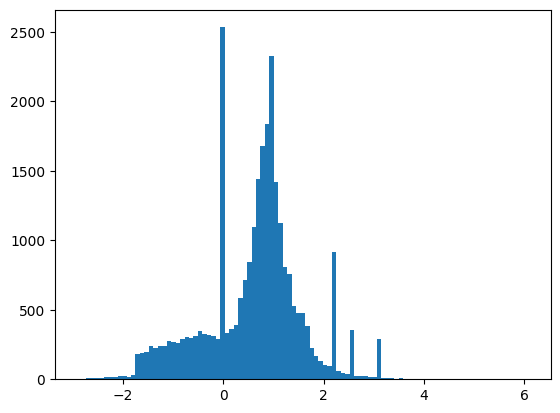

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

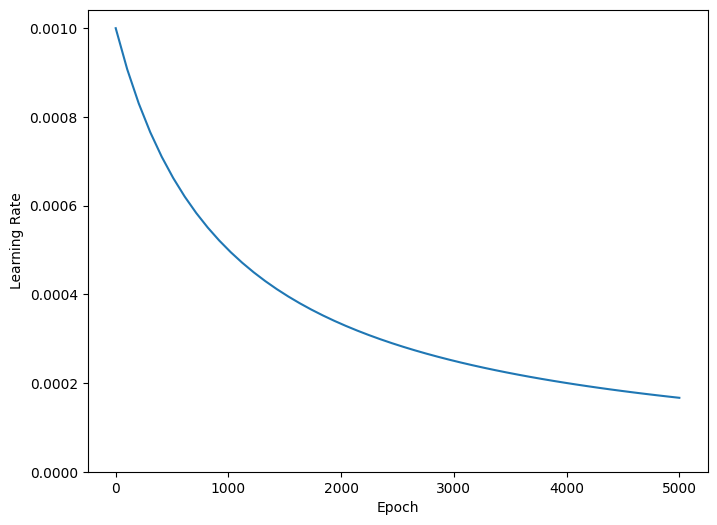

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481 (1.88 KB)


Trainable params: 481 (1.88 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5138,  binary_crossentropy:0.7983,  loss:0.7983,  val_accuracy:0.4720,  val_binary_crossentropy:0.7599,  val_loss:0.7599,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5973,  binary_crossentropy:0.6268,  loss:0.6268,  val_accuracy:0.5540,  val_binary_crossentropy:0.6353,  val_loss:0.6353,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6241,  binary_crossentropy:0.6112,  loss:0.6112,  val_accuracy:0.6100,  val_binary_crossentropy:0.6124,  val_loss:0.6124,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6453,  binary_crossentropy:0.5991,  loss:0.5991,  val_accuracy:0.6190,  val_binary_crossentropy:0.6009,  val_loss:0.6009,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6612,  binary_crossentropy:0.5910,  loss:0.5910,  val_accuracy:0.6340,  val_binary_crossentropy:0.5907,  val_loss:0.5907,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6658,  binary_crossentropy:0.5862,  loss:0.5862,  val_accuracy:0.6450,  val_binary_crossentropy:0.5869,  val_loss:0.5869,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6687,  binary_crossentropy:0.5819,  loss:0.5819,  val_accuracy:0.6730,  val_binary_crossentropy:0.5801,  val_loss:0.5801,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6722,  binary_crossentropy:0.5786,  loss:0.5786,  val_accuracy:0.6650,  val_binary_crossentropy:0.5804,  val_loss:0.5804,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6766,  binary_crossentropy:0.5762,  loss:0.5762,  val_accuracy:0.6620,  val_binary_crossentropy:0.5799,  val_loss:0.5799,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6764,  binary_crossentropy:0.5744,  loss:0.5744,  val_accuracy:0.6690,  val_binary_crossentropy:0.5798,  val_loss:0.5798,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6781,  binary_crossentropy:0.5727,  loss:0.5727,  val_accuracy:0.6680,  val_binary_crossentropy:0.5803,  val_loss:0.5803,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

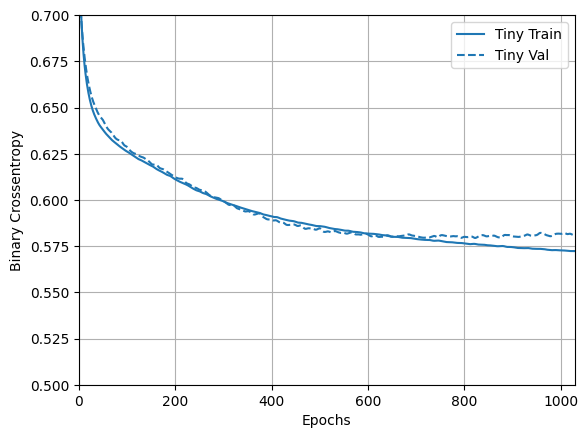

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4964,  binary_crossentropy:0.7176,  loss:0.7176,  val_accuracy:0.5140,  val_binary_crossentropy:0.6872,  val_loss:0.6872,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6112,  binary_crossentropy:0.6161,  loss:0.6161,  val_accuracy:0.5890,  val_binary_crossentropy:0.6178,  val_loss:0.6178,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6406,  binary_crossentropy:0.5998,  loss:0.5998,  val_accuracy:0.6110,  val_binary_crossentropy:0.6055,  val_loss:0.6055,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6614,  binary_crossentropy:0.5863,  loss:0.5863,  val_accuracy:0.6080,  val_binary_crossentropy:0.6063,  val_loss:0.6063,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6754,  binary_crossentropy:0.5722,  loss:0.5722,  val_accuracy:0.6470,  val_binary_crossentropy:0.5993,  val_loss:0.5993,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6884,  binary_crossentropy:0.5623,  loss:0.5623,  val_accuracy:0.6500,  val_binary_crossentropy:0.5965,  val_loss:0.5965,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6979,  binary_crossentropy:0.5560,  loss:0.5560,  val_accuracy:0.6640,  val_binary_crossentropy:0.5958,  val_loss:0.5958,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6969,  binary_crossentropy:0.5519,  loss:0.5519,  val_accuracy:0.6570,  val_binary_crossentropy:0.5965,  val_loss:0.5965,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5041,  binary_crossentropy:0.6867,  loss:0.6867,  val_accuracy:0.4950,  val_binary_crossentropy:0.6753,  val_loss:0.6753,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7159,  binary_crossentropy:0.5321,  loss:0.5321,  val_accuracy:0.6350,  val_binary_crossentropy:0.6132,  val_loss:0.6132,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7767,  binary_crossentropy:0.4410,  loss:0.4410,  val_accuracy:0.6500,  val_binary_crossentropy:0.6798,  val_loss:0.6798,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5119,  binary_crossentropy:0.8286,  loss:0.8286,  val_accuracy:0.4910,  val_binary_crossentropy:0.6822,  val_loss:0.6822,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0025,  loss:0.0025,  val_accuracy:0.6540,  val_binary_crossentropy:1.8026,  val_loss:1.8026,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6430,  val_binary_crossentropy:2.4872,  val_loss:2.4872,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

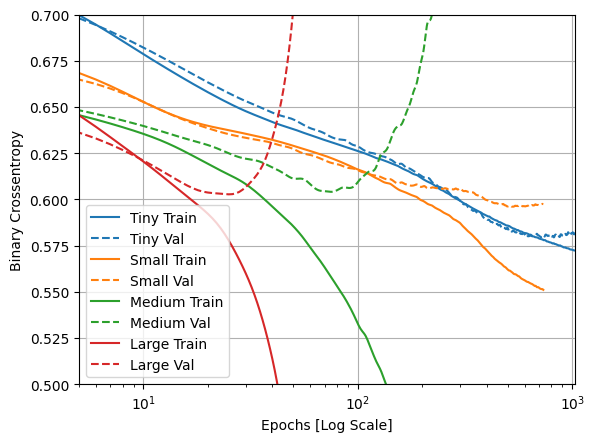

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook (Sorry, this doesn't
display on tensorflow.org):

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpce8z03ca/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5018,  binary_crossentropy:0.8441,  loss:2.3729,  val_accuracy:0.4600,  val_binary_crossentropy:0.6955,  val_loss:2.1563,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6543,  binary_crossentropy:0.5953,  loss:0.6205,  val_accuracy:0.6520,  val_binary_crossentropy:0.5786,  val_loss:0.6038,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6760,  binary_crossentropy:0.5787,  loss:0.6041,  val_accuracy:0.6980,  val_binary_crossentropy:0.5783,  val_loss:0.6035,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6803,  binary_crossentropy:0.5726,  loss:0.5975,  val_accuracy:0.6780,  val_binary_crossentropy:0.5803,  val_loss:0.6054,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6872,  binary_crossentropy:0.5631,  loss:0.5902,  val_accuracy:0.6380,  val_binary_crossentropy:0.5953,  val_loss:0.6223,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

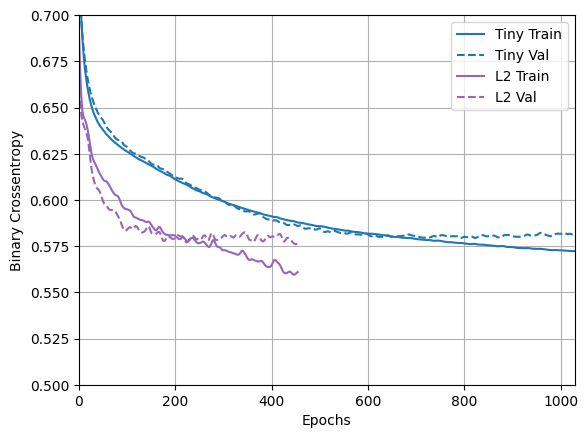

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5182,  binary_crossentropy:0.8057,  loss:0.8057,  val_accuracy:0.5020,  val_binary_crossentropy:0.6713,  val_loss:0.6713,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6610,  binary_crossentropy:0.5969,  loss:0.5969,  val_accuracy:0.6870,  val_binary_crossentropy:0.5783,  val_loss:0.5783,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6926,  binary_crossentropy:0.5561,  loss:0.5561,  val_accuracy:0.6780,  val_binary_crossentropy:0.5859,  val_loss:0.5859,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7187,  binary_crossentropy:0.5170,  loss:0.5170,  val_accuracy:0.6820,  val_binary_crossentropy:0.6071,  val_loss:0.6071,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

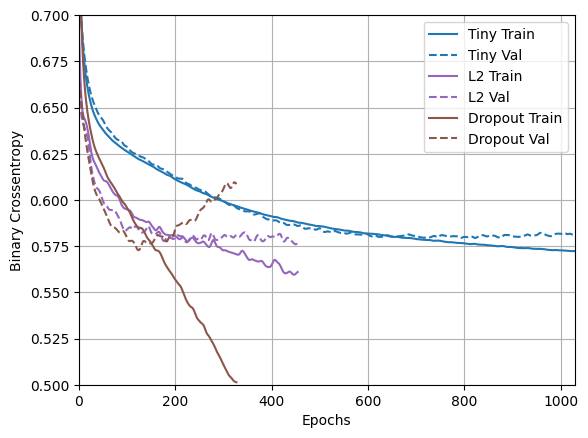

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5109,  binary_crossentropy:0.7885,  loss:0.9471,  val_accuracy:0.5800,  val_binary_crossentropy:0.6998,  val_loss:0.8576,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6489,  binary_crossentropy:0.6047,  loss:0.6349,  val_accuracy:0.6540,  val_binary_crossentropy:0.5801,  val_loss:0.6102,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6656,  binary_crossentropy:0.5889,  loss:0.6156,  val_accuracy:0.6900,  val_binary_crossentropy:0.5713,  val_loss:0.5980,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6685,  binary_crossentropy:0.5782,  loss:0.6076,  val_accuracy:0.6940,  val_binary_crossentropy:0.5658,  val_loss:0.5953,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6789,  binary_crossentropy:0.5743,  loss:0.6056,  val_accuracy:0.6650,  val_binary_crossentropy:0.5666,  val_loss:0.5980,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6812,  binary_crossentropy:0.5706,  loss:0.6036,  val_accuracy:0.6870,  val_binary_crossentropy:0.5555,  val_loss:0.5885,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6801,  binary_crossentropy:0.5667,  loss:0.6011,  val_accuracy:0.6880,  val_binary_crossentropy:0.5527,  val_loss:0.5872,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6857,  binary_crossentropy:0.5630,  loss:0.5989,  val_accuracy:0.7030,  val_binary_crossentropy:0.5451,  val_loss:0.5810,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6919,  binary_crossentropy:0.5581,  loss:0.5955,  val_accuracy:0.6900,  val_binary_crossentropy:0.5497,  val_loss:0.5871,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6946,  binary_crossentropy:0.5538,  loss:0.5928,  val_accuracy:0.6870,  val_binary_crossentropy:0.5452,  val_loss:0.5842,  
.

.

.

.

.

.

.

.

(0.5, 0.7)

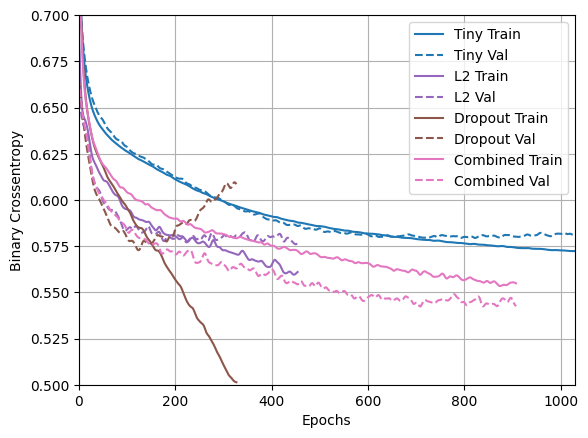

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded run the following into a code-cell  (Sorry, this doesn't display on tensorflow.org):

In [ ]:
%tensorboard --logdir {logdir}/regularizers

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.